DESCRIPTION 

In Sub-Saharan Africa, crop diseases and pests are responsible for up to a 40% reduction in crop yields each year, significantly impacting food security and economic stability. Since agriculture employs over 60% of the population and contributes roughly 23% of the region's GDP, this loss is especially detrimental.

The increasing prevalence of crop diseases, driven by climate change and limited access to advanced agricultural technologies, has affected key crops, with diseases like tomato leaf curl virus and pepper blight leading to major yield reductions. To address this, I aim to develop a machine learning solution capable of accurately detecting and identifying diseases in three essential crops: corn, pepper, and tomato.

Exploratory Data Analysis (EDA)
The project begins with thorough Exploratory Data Analysis (EDA) to understand the patterns, distributions, and potential outliers in the dataset, which includes labeled images of corn, pepper, and tomato crops showing various diseases. EDA will help reveal underlying trends, such as the frequency of each disease, the diversity within each class, and any imbalances in the dataset. This analysis will guide the data preprocessing steps and aid in building a model that can generalize well to unseen cases.

Model Selection: YOLO (You Only Look Once)
To address the challenge of disease detection, I am utilizing the YOLO (You Only Look Once) object detection model. YOLO is known for its speed and accuracy, making it suitable for deployment on edge devices, including entry-level smartphones widely accessible to subsistence farmers. YOLO’s single-stage detection approach enables it to detect multiple diseases within an image in real time, making it effective for identifying various diseases even in complex agricultural environments. The model will be fine-tuned to detect the specific diseases present in corn, pepper, and tomato crops.

Objective
This challenge aims to develop a robust machine learning model that can:

Accurately Detect Multiple Diseases: Identify different diseases in corn, pepper, and tomato crops with high precision, even when encountering diseases not included in the training data.

Deploy Efficiently on Edge Devices: Ensure the model is optimized for performance on low-cost smartphones, which are commonly used by subsistence farmers in Sub-Saharan Africa.

By combining EDA insights and the power of the YOLO model, I aim to create a solution that delivers timely and accurate disease identification, contributing to improved crop productivity, sustainability, and food security for millions in the region.

In [1]:
# Install ultralytics
!pip install -U ultralytics

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/13/77/d561ac3a075ba46ef20381b9dcda3af56acbd8af18511dbfcee57413e3f8/ultralytics-8.3.27-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/879.0 kB ? eta -:--:--
   ---------------------------------------- 10.2/879.0 kB ? eta -:--:--
   ---------------------------------------- 10.2/879.0 kB ? eta -:--:--
   ---------------------------------------- 10.2/879.0 kB ? eta -:--:--
   ---------------------------------------- 10.2/879.0 kB ? eta -:--:--
   ---------------------------------------- 10.2/879.0 kB ? eta -:--:--
   ---------------------------------------- 10.2/879.0 kB ? eta -:--:--
   - -------------------------------------- 30.7/879.0 kB 72.6 kB/s eta 0:00:12
   - -------------------------------------- 41.0/879.0 kB 89.3 kB/s eta 0:00:10
   -- ------------------------------------ 61.4/879.0 kB 136.5 kB/s eta 0:00:06
   ---- ---------------------------------- 92.2/8

In [3]:
# Import libraries
import pandas as pd #for data manipulation 
import os # interacting with operating system 
from pathlib import Path #handling file system paths 
import shutil # for copying,moving and moving directions and files 
from sklearn.model_selection import train_test_split #splitting the dataset into testing and training 
from sklearn.preprocessing import LabelEncoder #converting categorical columns into numerical
from tqdm.notebook import tqdm #displaying a progress bar
import cv2 #image processing and computer vision tasks
import yaml #used for configuration
import matplotlib.pyplot as plt #for data visualization
from ultralytics import YOLO #model used to detect for objects in images and videos in real time with high accuracy 
import multiprocessing #allows for parallel exucation of tasks
!pip install pyspark pyarrow
!pip install wordcloud

  Using cached pyspark-3.5.3.tar.gz (317.3 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  ERROR: Error [WinError 225] Operation did not complete successfully because the file contains a virus or potentially unwanted software while executing command python setup.py egg_info
ERROR: Could not install packages due to an OSError: [WinError 225] Operation did not complete successfully because the file contains a virus or potentially unwanted software



In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('max_colwidth', 1000)
import os, random, sys
from tqdm import tqdm
tqdm.pandas()

from IPython.core.display import HTML
from IPython.display import Image
from collections import Counter
import json


from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from wordcloud import WordCloud
from plotly import tools
import seaborn as sns
from PIL import Image

import tensorflow as tf

init_notebook_mode(connected=True)
%matplotlib inline 

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cv2


import multiprocessing
from pathlib import Path
import shutil
# import pyspark.pandas as ps

READING  DaTA AND EXPLORATORY DATA ANALYSIS 

In [7]:
# Path to where your data is stored
DATA_DIR = Path("C:\\Users\\Administrator\\Downloads\\archive (3)")

# Preview data files available
os.listdir(DATA_DIR)

['images', 'labels', 'SampleSubmission.csv', 'Test.csv', 'Train.csv']

In [9]:
from pathlib import Path

# Set up directories for training a YOLO model

# Images directories
DATASET_DIR = Path(r'C:\Users\Administrator\Downloads\archive (3)')
IMAGES_DIR = DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'
TEST_LABELS_DIR = LABELS_DIR / 'test'

# Create directories if they do not exist
TRAIN_IMAGES_DIR.mkdir(parents=True, exist_ok=True)
VAL_IMAGES_DIR.mkdir(parents=True, exist_ok=True)
TEST_IMAGES_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_LABELS_DIR.mkdir(parents=True, exist_ok=True)
VAL_LABELS_DIR.mkdir(parents=True, exist_ok=True)
TEST_LABELS_DIR.mkdir(parents=True, exist_ok=True)


In [13]:
# Load train and test files
train = pd.read_csv(DATA_DIR / 'Train.csv')
test = pd.read_csv(DATA_DIR / 'Test.csv')

# Add an image_path column to both train and test sets
train['image_path'] = train['Image_ID'].apply(lambda x: Path('C:/Users/Administrator/Downloads/archive (3)/images') / x)
test['image_path'] = test['Image_ID'].apply(lambda x: Path('C:/Users/Administrator/Downloads/archive (3)/images') / x)

# Map str classes to ints (label encoding targets)
class_mapper = {x: y for x, y in zip(sorted(train['class'].unique()), range(train['class'].nunique()))}
train['class_id'] = train['class'].map(class_mapper)

# Preview the head of the train set
train.head()


Image_ID  confidence                  class         ymin        xmin  \
0  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   194.649671  328.803454   
1  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   149.632401  256.768914   
2  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   234.046875  327.138158   
3  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   221.277138  340.411184   
4  id_11ee1c.jpg         1.0        Pepper_Fusarium  2000.563598  989.588908   

          ymax         xmax  \
0   208.107730   341.967928   
1   162.910362   266.195724   
2   252.712993   338.876645   
3   238.593750   354.651316   
4  2184.252196  1401.748952   

                                                          image_path  class_id  
0  C:\Users\Administrator\Downloads\archive (3)\images\id_11543h.jpg         5  
1  C:\Users\Administrator\Downloads\archive (3)\images\id_11543h.jpg         5  
2  C:\Users\Administrator\Downloads\archive (3)\images\id_11543h.jpg         5  
3  C:\Users\Administrator\Downloads\archive (3)\images\id_11543h.jpg         5  
4  C:\Users\Administrator\Downloads\archive (3)\images\id_11ee1c.jpg         8

In [15]:
test.head()

Image_ID  confidence  class  ymin  xmin  ymax  xmax  \
0  id_128pxx.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
1  id_12jbci.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
2  id_143s4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
3  id_14tfmb.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
4  id_14tw4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN   

                                                          image_path  
0  C:\Users\Administrator\Downloads\archive (3)\images\id_128pxx.jpg  
1  C:\Users\Administrator\Downloads\archive (3)\images\id_12jbci.jpg  
2  C:\Users\Administrator\Downloads\archive (3)\images\id_143s4o.jpg  
3  C:\Users\Administrator\Downloads\archive (3)\images\id_14tfmb.jpg  
4  C:\Users\Administrator\Downloads\archive (3)\images\id_14tw4o.jpg

In [17]:
# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset = ['Image_ID'], ignore_index = True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.25, stratify=train_unique_imgs_df['class'], random_state=42)

X_train = train[train.Image_ID.isin(X_train.Image_ID)]
X_val = train[train.Image_ID.isin(X_val.Image_ID)]

# Check shapes of training and validation data
X_train.shape, X_val.shape

((30777, 9), (10252, 9))

Descriptive Statistics

How many images and labels

In [20]:
print ("Total Images in the train:", train.Image_ID.nunique())
print ("Total Labels in the train:", train["class"].nunique())
print ("")

print ("Total Images in the test:", test.Image_ID.nunique())
print ("Total Labels in the test:", 0)
print ("")

Total Images in the train: 4902
Total Labels in the train: 23

Total Images in the test: 2101
Total Labels in the test: 0



Classes frequency distribution

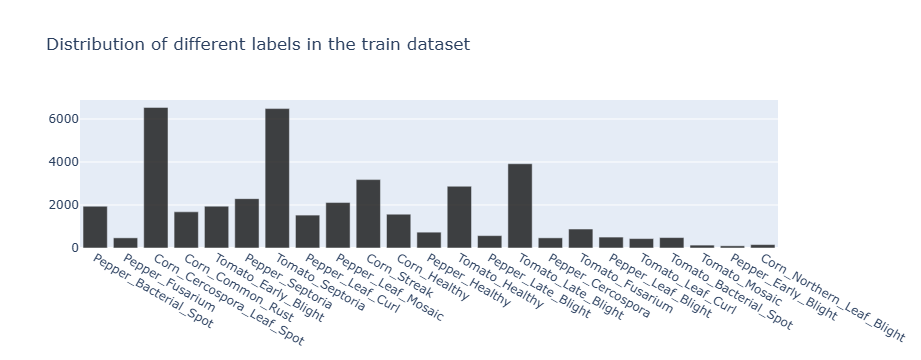

In [23]:
train_labels = Counter(train["class"])

xvalues = list(train_labels.keys())
yvalues = list(train_labels.values())

trace1 = go.Bar(x=xvalues, y=yvalues, opacity=0.8, name="Diseases count", marker=dict(color='rgba(20, 20, 20, 1)'))
layout = dict(width=800, title='Distribution of different labels in the train dataset', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

- The most frequent labels are: Corn_Cercospora_Leaf_Spot, Tomato_Septoria, Tomato_Late_Blight- 
The least frequent are: Corn_Northern_Leaf_Blight, Tomato_Mosaic, and Pepper_Early_Blight

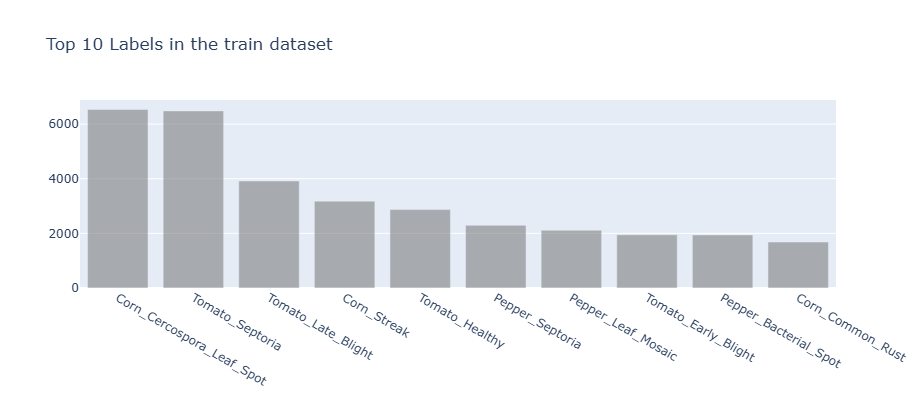

In [26]:
# most common labels 

temps = train_labels.most_common(10)
labels_tr = [""+str(x[0]) for x in temps]
values = [x[1] for x in temps]

trace1 = go.Bar(x=labels_tr, y=values, opacity=0.7, name="Disease count", marker=dict(color='rgba(120, 120, 120, 0.8)'))
layout = dict(height=400, title='Top 10 Labels in the train dataset', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

Number of annotation per plant types

In [29]:
train["plant"] = train["class"].apply(lambda x: x.split("_")[0])
train["disease"] = train["class"].apply(lambda x: "_".join(x.split("_")[1:]))

In [31]:
train.groupby("plant").agg({'Image_ID': ['nunique', 'count'], 'disease': ['nunique', "unique"]})

Image_ID        disease  \
        nunique  count nunique   
plant                            
Corn       1409  13128       5   
Pepper     2365  10745      10   
Tomato     1281  17156       8   

                                                                                                                                   
                                                                                                                           unique  
plant                                                                                                                              
Corn                                                   [Cercospora_Leaf_Spot, Common_Rust, Streak, Healthy, Northern_Leaf_Blight]  
Pepper  [Bacterial_Spot, Fusarium, Septoria, Leaf_Curl, Leaf_Mosaic, Healthy, Late_Blight, Cercospora, Leaf_Blight, Early_Blight]  
Tomato                                [Early_Blight, Septoria, Healthy, Late_Blight, Fusarium, Leaf_Curl, Bacterial_Spot, Mosaic]

In our train dataset, among 4902 images available:
1409 of them correspond to corn plants
2365 correspond to pepper plants
1281 come from tomato plants
Despite that tomato crops are the least present within our dataset, it is the one with most annotations (17156), and the the crop with the most images, pepper, is the one with the least annotations (only 10745).

The divergence in the number of annotations vs the number of images available could be explained by the fact that there are twice more diseases detected in pepper plants than in corn plants.

In [34]:
pd.crosstab(train.plant, train.disease).T

plant                 Corn  Pepper  Tomato
disease                                   
Bacterial_Spot           0    1943     484
Cercospora               0     472       0
Cercospora_Leaf_Spot  6538       0       0
Common_Rust           1682       0       0
Early_Blight             0     101    1946
Fusarium                 0     472     882
Healthy               1571     736    2872
Late_Blight              0     575    3918
Leaf_Blight              0     508       0
Leaf_Curl                0    1530     437
Leaf_Mosaic              0    2113       0
Mosaic                   0       0     134
Northern_Leaf_Blight   157       0       0
Septoria                 0    2295    6483
Streak                3180       0       0

Diseases related to corn plants are mainly: Cercospora leaf spot(6538), common rust(1682), northern leaf blight(157), and streak(3180).

Diseases only found on pepper plants are: Cercospora(472), leaf blight(508), and leaf mosaic(2113
)
Diseases only related to tomato plants are: Mosaic(13
4)
Diseases found on both pepper and tomato plants: Bacterial spot, Early blight, Fusarium, Late blight, Leaf curl, and Septoria

     On a given image, how many plants are there?

In [36]:
train.groupby("Image_ID")["plant"].nunique().value_counts()

plant
1    4749
2     153
Name: count, dtype: int64

Within our training set, there are 4749 images with only one plant, whereas there are 153 images with two plants.


In [38]:
images_with_two_plants = train.groupby("Image_ID")["plant"].nunique()[train.groupby("Image_ID")["plant"].nunique()==2].index.tolist()

In [40]:
train.loc[train.Image_ID.isin(images_with_two_plants)].groupby("Image_ID")['plant'].unique().apply(lambda x: sorted(x)).value_counts()

plant
[Pepper, Tomato]    153
Name: count, dtype: int64

The images with two crops cultivated contains only te pair: Pepper and Tomato. This could be explained by te fact they are probably usually cultivated together and they are subject to catch similar diseases.

    On a given image, how many diseases are there?

In [42]:
train.groupby("Image_ID")["disease"].nunique().value_counts()

disease
1    3923
2     873
3     101
4       5
Name: count, dtype: int64

Within our training set, there are 3923 images with only one disease detected, whereas there are 873 images with two diseases detected, 101 images with 3 diseases detected, and 5 images with 4 diseases detected.

In [44]:
images_with_two_disease = train.groupby("Image_ID")["disease"].nunique()[train.groupby("Image_ID")["disease"].nunique() == 2].index.tolist()

In [46]:
train.loc[train.Image_ID.isin(images_with_two_disease)].groupby("Image_ID")['disease'].unique().apply(lambda x: sorted(x)).value_counts()

disease
[Cercospora_Leaf_Spot, Common_Rust]             131
[Late_Blight, Septoria]                         125
[Cercospora_Leaf_Spot, Healthy]                  78
[Leaf_Curl, Leaf_Mosaic]                         70
[Bacterial_Spot, Leaf_Mosaic]                    66
[Cercospora_Leaf_Spot, Streak]                   51
[Early_Blight, Late_Blight]                      39
[Northern_Leaf_Blight, Streak]                   35
[Fusarium, Healthy]                              23
[Healthy, Leaf_Curl]                             20
[Leaf_Blight, Leaf_Curl]                         19
[Fusarium, Late_Blight]                          18
[Leaf_Blight, Leaf_Mosaic]                       17
[Cercospora, Leaf_Curl]                          16
[Cercospora, Leaf_Blight]                        14
[Bacterial_Spot, Leaf_Curl]                      14
[Leaf_Curl, Mosaic]                              14
[Common_Rust, Healthy]                           13
[Bacterial_Spot, Late_Blight]                    13
[Cer

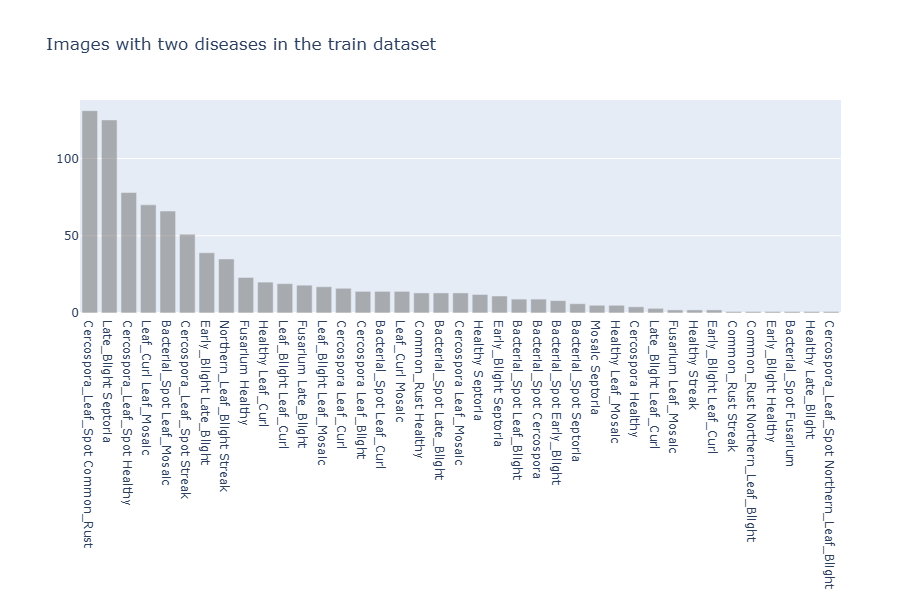

In [48]:
labels_tr = [" ".join(x) for x in train.loc[train.Image_ID.isin(images_with_two_disease)].groupby("Image_ID")['disease'].unique().apply(lambda x: sorted(x)).value_counts().index.tolist()]
values = train.loc[train.Image_ID.isin(images_with_two_disease)].groupby("Image_ID")['disease'].unique().apply(lambda x: sorted(x)).value_counts().values

trace1 = go.Bar(x=labels_tr, y=values, opacity=0.7, name="Disease count", marker=dict(color='rgba(120, 120, 120, 0.8)'))
layout = dict(height=600, title='Images with two diseases in the train dataset', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

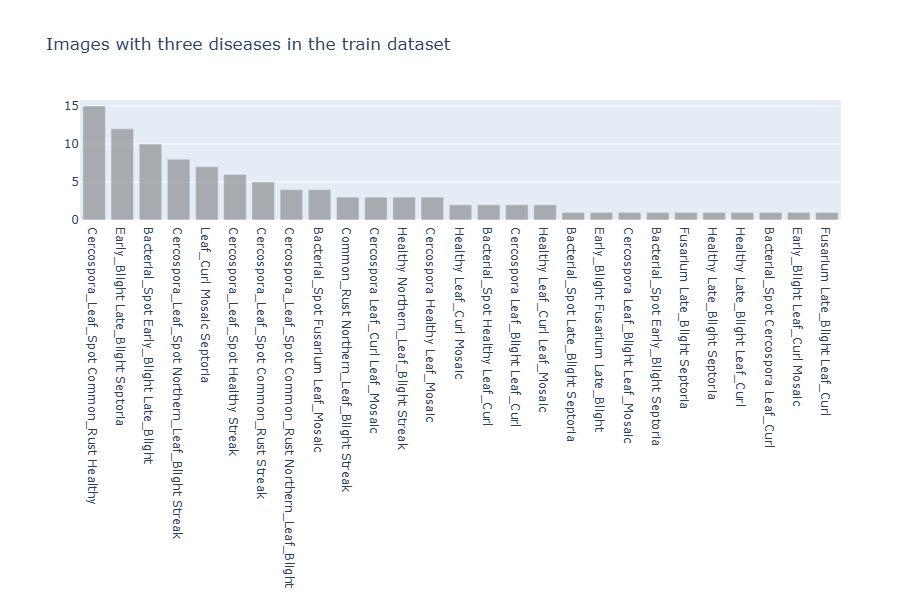

In [50]:
images_with_three_disease = train.groupby("Image_ID")["disease"].nunique()[train.groupby("Image_ID")["disease"].nunique() == 3].index.tolist()
labels_tr = [" ".join(x) for x in train.loc[train.Image_ID.isin(images_with_three_disease)].groupby("Image_ID")['disease'].unique().apply(lambda x: sorted(x)).value_counts().index.tolist()]
values = train.loc[train.Image_ID.isin(images_with_three_disease)].groupby("Image_ID")['disease'].unique().apply(lambda x: sorted(x)).value_counts().values

trace1 = go.Bar(x=labels_tr, y=values, opacity=0.7, name="Disease count", marker=dict(color='rgba(120, 120, 120, 0.8)'))
layout = dict(height=600, title='Images with three diseases in the train dataset', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

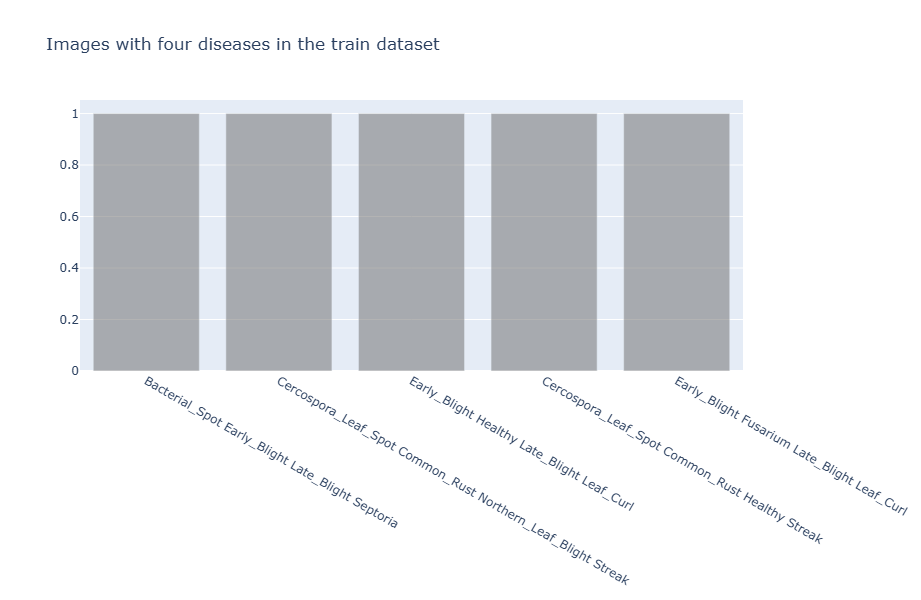

In [52]:
images_with_four_disease = train.groupby("Image_ID")["disease"].nunique()[train.groupby("Image_ID")["disease"].nunique() == 4].index.tolist()
labels_tr = [" ".join(x) for x in train.loc[train.Image_ID.isin(images_with_four_disease)].groupby("Image_ID")['disease'].unique().apply(lambda x: sorted(x)).value_counts().index.tolist()]
values = train.loc[train.Image_ID.isin(images_with_four_disease)].groupby("Image_ID")['disease'].unique().apply(lambda x: sorted(x)).value_counts().values

trace1 = go.Bar(x=labels_tr, y=values, opacity=0.7, name="Disease count", marker=dict(color='rgba(120, 120, 120, 0.8)'))
layout = dict(height=600, title='Images with four diseases in the train dataset', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

In [60]:
# Preview target distribution, seems there a class imbalance that needs to be handled
X_train['class'].value_counts(normalize = True), X_val['class'].value_counts(normalize = True)

(class
 Corn_Cercospora_Leaf_Spot    0.160444
 Tomato_Septoria              0.159047
 Tomato_Late_Blight           0.098905
 Corn_Streak                  0.077201
 Tomato_Healthy               0.069045
 Pepper_Septoria              0.051922
 Pepper_Leaf_Mosaic           0.051662
 Tomato_Early_Blight          0.047763
 Pepper_Bacterial_Spot        0.047665
 Corn_Common_Rust             0.040290
 Pepper_Leaf_Curl             0.037561
 Corn_Healthy                 0.037561
 Tomato_Fusarium              0.019950
 Pepper_Healthy               0.017935
 Pepper_Late_Blight           0.014296
 Pepper_Leaf_Blight           0.012574
 Tomato_Bacterial_Spot        0.011860
 Pepper_Cercospora            0.011405
 Pepper_Fusarium              0.011340
 Tomato_Leaf_Curl             0.011177
 Corn_Northern_Leaf_Blight    0.004289
 Tomato_Mosaic                0.003314
 Pepper_Early_Blight          0.002794
 Name: proportion, dtype: float64,
 class
 Corn_Cercospora_Leaf_Spot    0.156067
 Tomato_Septori

In [62]:
# Check if dirs exist, if they do, remove them, otherwise create them.
# This only needs to run once
for DIR in [TRAIN_IMAGES_DIR,VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR,VAL_LABELS_DIR,TEST_LABELS_DIR]:
  if DIR.exists():
    shutil.rmtree(DIR)
  DIR.mkdir(parents=True, exist_ok = True)

In [64]:
# Copy train, val and test images to their respective dirs
for img in tqdm(X_train.image_path.unique()):
  shutil.copy(img, TRAIN_IMAGES_DIR / img.parts[-1])

for img in tqdm(X_val.image_path.unique()):
  shutil.copy(img, VAL_IMAGES_DIR / img.parts[-1])

for img in tqdm(test.image_path.unique()):
  shutil.copy(img, TEST_IMAGES_DIR / img.parts[-1])

100%|██████████████████████████████████████████████████████████████████████████████| 2101/2101 [01:29<00:00, 23.59it/s]


In [11]:
X_train.head()

Image_ID  confidence                      class        ymin  \
0  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  194.649671   
1  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  149.632401   
2  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  234.046875   
3  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  221.277138   
6  id_11gglx.jpg         1.0  Corn_Cercospora_Leaf_Spot  774.562500   

          xmin        ymax         xmax  \
0   328.803454  208.107730   341.967928   
1   256.768914  162.910362   266.195724   
2   327.138158  252.712993   338.876645   
3   340.411184  238.593750   354.651316   
6  2735.933839  850.476742  2834.348725   

                                          image_path  class_id  
0  C:\Users\Administrator\Downloads\archive (3)\i...         5  
1  C:\Users\Administrator\Downloads\archive (3)\i...         5  
2  C:\Users\Administrator\Downloads\archive (3)\i...         5  
3  C:\Users\Administrator\Downloads\archive (3)\i...         5  
6  C:\Users\Administrator\Downloads\archive (3)\i...         0

In [12]:
import shutil
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import numpy as np
from PIL import Image

# Function to convert bounding boxes to YOLO format
def convert_to_yolo(bbox, width, height):
    ymin, xmin, ymax, xmax = bbox['ymin'], bbox['xmin'], bbox['ymax'], bbox['xmax']
    class_id = bbox['class_id']

    # Normalize the bounding box coordinates for YOLO format
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    return f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"

# Top-level function to save YOLO annotations for a single image
def save_yolo_annotations_task(task):
    image_path, bboxes, output_dir = task
    try:
        # Load image to get dimensions
        img = np.array(Image.open(str(image_path)))
        height, width, _ = img.shape
    except Exception as e:
        print(f"Error opening image {image_path}: {e}")
        return

    # Prepare the label file
    label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"
    
    # Write bounding box information to the label file
    with open(label_file, 'w') as f:
        for bbox in bboxes:
            annotation = convert_to_yolo(bbox, width, height)
            f.write(f"{annotation}\n")

# Function to clear the output directory to avoid any duplicate files
def clear_output_dir(output_dir):
    if Path(output_dir).exists():
        shutil.rmtree(output_dir)
    Path(output_dir).mkdir(parents=True, exist_ok=True)

# Process dataset without multiprocessing for debugging
def process_dataset_without_multiprocessing(dataframe, output_dir):
    # Clear the output directory first
    clear_output_dir(output_dir)

    # Group the DataFrame by 'image_path' to handle multiple annotations for the same image
    grouped = dataframe.groupby('image_path')
    tasks = [(image_path, group.to_dict('records'), output_dir) for image_path, group in grouped]

    # Sequentially process each task
    for task in tqdm(tasks, total=len(tasks)):
        save_yolo_annotations_task(task)

# Define paths for training and validation label directories
TRAIN_LABELS_DIR = Path("C:\\Users\\Administrator\\Downloads\\archive (3)\\labels\\train")
VAL_LABELS_DIR = Path("C:\\Users\\Administrator\\Downloads\\archive (3)\\labels\\val")

# Process training and validation datasets without multiprocessing
process_dataset_without_multiprocessing(X_train, TRAIN_LABELS_DIR)
process_dataset_without_multiprocessing(X_val, VAL_LABELS_DIR)

print("YOLO annotations successfully saved for training and validation datasets!")



100%|██████████████████████████████████████████████████████████████████████████████| 1226/1226 [12:29<00:00,  1.64it/s]

YOLO annotations successfully saved for training and validation datasets!


In [13]:
# Train images dir
TRAIN_IMAGES_DIR

WindowsPath('C:/Users/Administrator/Downloads/archive (3)/images/train')

Plotting id_11543h.jpg with 4 bounding boxes.


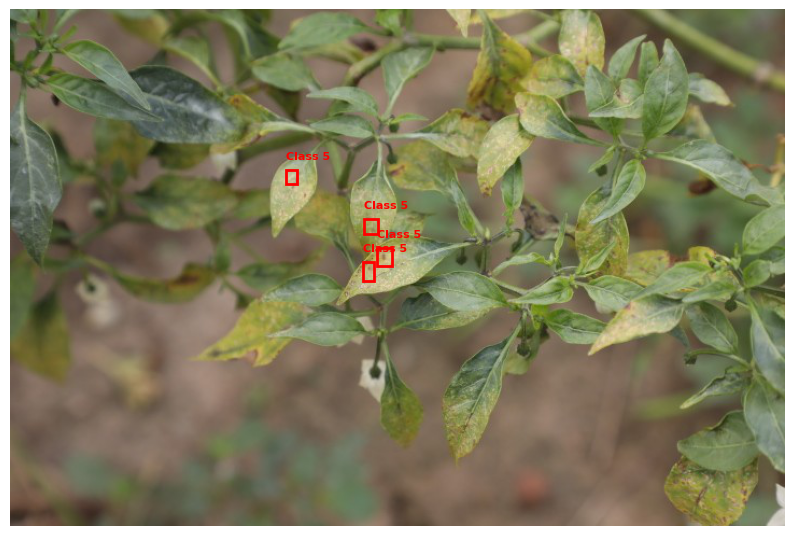

Plotting id_11gglx.jpg with 11 bounding boxes.


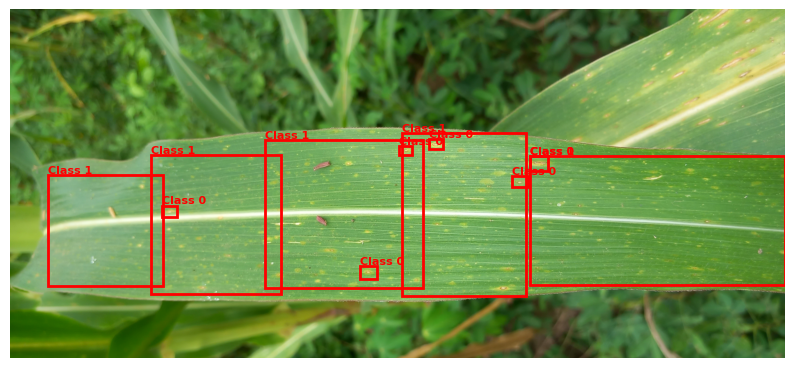

Plotting id_11zffz.jpg with 10 bounding boxes.


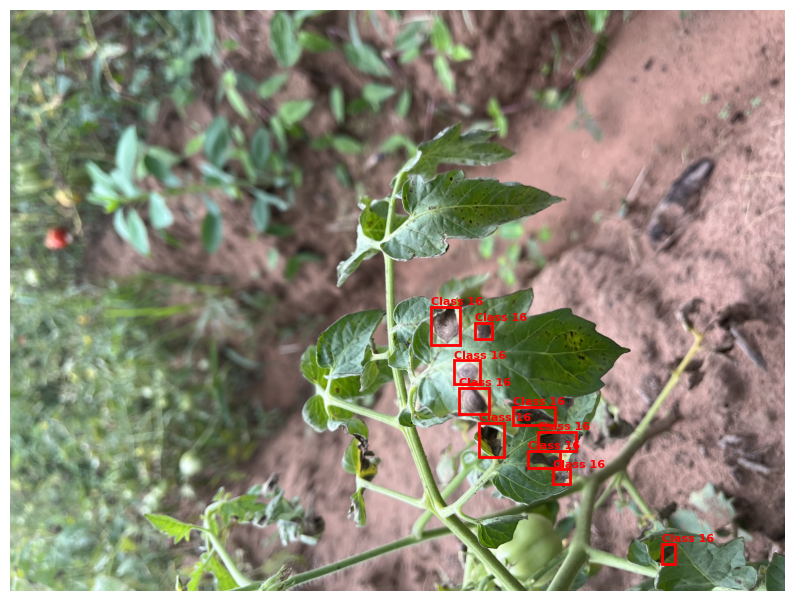

Plotting id_127uhh.jpg with 1 bounding boxes.


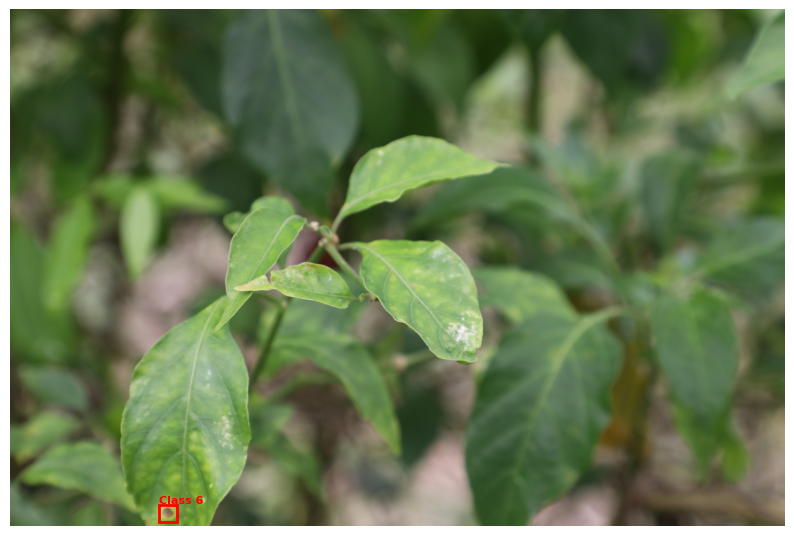

Plotting id_12q33h.jpg with 3 bounding boxes.


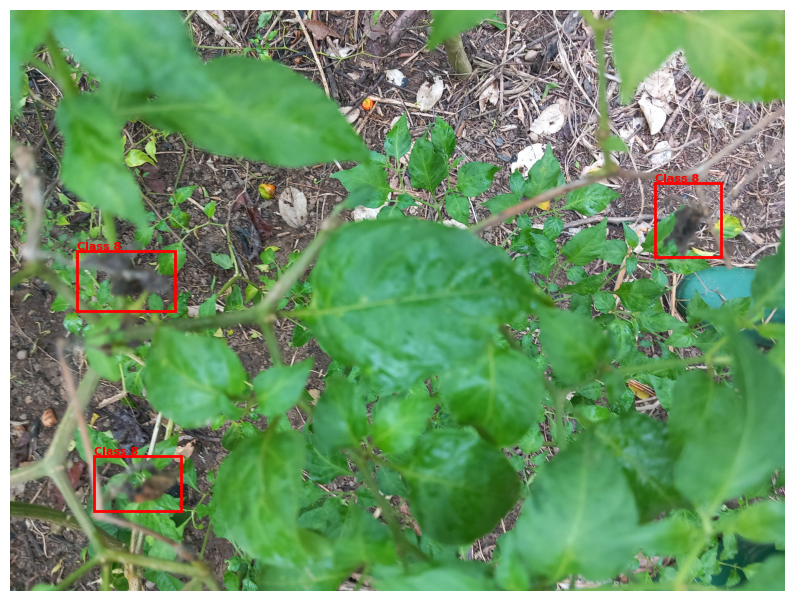

In [14]:
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = np.array(Image.open(str(image_path)))


    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=8, weight='bold')

    plt.axis('off')
    plt.show()

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:5]:
    image_path = IMAGE_DIR / image_name
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")


In [15]:
import yaml

# Get unique class names and number of classes
class_names = sorted(train['class'].unique().tolist())
num_classes = len(class_names)

# Define base directory for images
base_dir = r'C:\Users\Administrator\Downloads\archive (3)\images'

# Define paths for train, val, and test datasets
data_yaml = {
    'train': '/content/' + str("C:\\Users\\Administrator\\Downloads\\archive (3)\\images\\train"),  # Path to train images
    'val': '/content/' + str("C:\\Users\\Administrator\\Downloads\\archive (3)\\images\\val"),      # Path to validation images
    'test': '/content/' + str("C:\\Users\\Administrator\\Downloads\\archive (3)\\images\\test"),    # Path to test images (optional)
    'nc': num_classes,                             # Number of classes
    'names': class_names                           # List of class names
}

# Specify the path to save the data.yaml file
yaml_path = 'data.yaml'

# Write the YAML content to a file
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Optional: Preview the content of data.yaml
print(data_yaml)


{'train': '/content/C:\\Users\\Administrator\\Downloads\\archive (3)\\images\\train', 'val': '/content/C:\\Users\\Administrator\\Downloads\\archive (3)\\images\\val', 'test': '/content/C:\\Users\\Administrator\\Downloads\\archive (3)\\images\\test', 'nc': 23, 'names': ['Corn_Cercospora_Leaf_Spot', 'Corn_Common_Rust', 'Corn_Healthy', 'Corn_Northern_Leaf_Blight', 'Corn_Streak', 'Pepper_Bacterial_Spot', 'Pepper_Cercospora', 'Pepper_Early_Blight', 'Pepper_Fusarium', 'Pepper_Healthy', 'Pepper_Late_Blight', 'Pepper_Leaf_Blight', 'Pepper_Leaf_Curl', 'Pepper_Leaf_Mosaic', 'Pepper_Septoria', 'Tomato_Bacterial_Spot', 'Tomato_Early_Blight', 'Tomato_Fusarium', 'Tomato_Healthy', 'Tomato_Late_Blight', 'Tomato_Leaf_Curl', 'Tomato_Mosaic', 'Tomato_Septoria']}


In [33]:
# Load a YOLO pretrained model
model = YOLO("C:\\Users\\Administrator\\Downloads\\yolov8n.pt")

# Fine tune model to our data
model.train(
    data='data.yaml',          # Path to the dataset configuration
    epochs=10,                 # Number of epochs
    imgsz=640,                # Image size (height, width)
    batch=8,                   # Batch size
    device='cpu',             # Use CPU instead of GPU
    patience=5
)


Ultralytics 8.3.18  Python-3.11.5 torch-2.4.1+cpu CPU (Intel Core(TM) i7-7600U 2.80GHz)
engine\trainer: task=detect, mode=train, model=C:\Users\Administrator\Downloads\yolov8n.pt, data=data.yaml, epochs=10, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train28, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_c

train: Scanning C:\Users\Administrator\Downloads\archive (3)\labels\train.cache... 3676 images, 0 backgrounds, 0 corrup
val: Scanning C:\Users\Administrator\Downloads\archive (3)\labels\val.cache... 1226 images, 0 backgrounds, 0 corrupt: 1


Plotting labels to runs\detect\train28\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00037, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train28
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      2.684      4.768      1.902        137        640: 100%|██████████| 460/460 [1:22:12<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [10:15


                   all       1226      10252       0.41     0.0904     0.0375     0.0148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      2.455      3.622       1.66         27        640: 100%|██████████| 460/460 [45:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [06:35


                   all       1226      10252      0.272      0.108      0.061      0.025

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      2.386      3.321      1.645         25        640: 100%|██████████| 460/460 [46:33<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [06:16


                   all       1226      10252      0.219      0.153     0.0833     0.0324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      2.339      3.124      1.627         13        640: 100%|██████████| 460/460 [45:28<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [06:32


                   all       1226      10252      0.228      0.188     0.0969     0.0368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      2.298       2.94      1.601         21        640: 100%|██████████| 460/460 [45:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [05:56


                   all       1226      10252       0.23      0.198      0.116     0.0464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      2.277      2.841      1.583         27        640: 100%|██████████| 460/460 [43:48<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [06:04


                   all       1226      10252      0.282      0.199       0.12      0.047

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      2.241      2.725      1.559         36        640: 100%|██████████| 460/460 [42:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [05:49


                   all       1226      10252      0.304      0.212      0.138     0.0561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      2.224      2.675      1.548         17        640: 100%|██████████| 460/460 [43:20<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [05:56


                   all       1226      10252      0.417      0.229      0.151     0.0612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      2.195      2.594       1.54         43        640: 100%|██████████| 460/460 [43:08<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [05:50


                   all       1226      10252      0.373      0.234       0.15     0.0609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      2.174      2.555       1.53         33        640: 100%|██████████| 460/460 [42:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [06:04


                   all       1226      10252      0.313      0.236      0.159     0.0651

10 epochs completed in 9.130 hours.
Optimizer stripped from runs\detect\train28\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train28\weights\best.pt, 6.2MB

Validating runs\detect\train28\weights\best.pt...
Ultralytics 8.3.18  Python-3.11.5 torch-2.4.1+cpu CPU (Intel Core(TM) i7-7600U 2.80GHz)
Model summary (fused): 168 layers, 3,010,133 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [04:23


                   all       1226      10252      0.313      0.237      0.159     0.0651
Corn_Cercospora_Leaf_Spot        202       1600      0.388      0.344      0.308      0.111
      Corn_Common_Rust         79        442      0.275      0.307      0.202     0.0768
          Corn_Healthy         63        415      0.265      0.308      0.193     0.0726
Corn_Northern_Leaf_Blight         12         25          1          0          0          0
           Corn_Streak         87        804        0.2       0.57       0.22     0.0743
 Pepper_Bacterial_Spot        132        476      0.245      0.204      0.148     0.0402
     Pepper_Cercospora         41        121      0.255     0.0661     0.0673     0.0215
   Pepper_Early_Blight          2         15          0          0          0          0
       Pepper_Fusarium         52        123      0.221      0.577      0.314      0.102
        Pepper_Healthy         68        184       0.25      0.777      0.462      0.191
    Pepper_Late

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001D4029EE910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.

In [35]:
import os
print(os.getcwd())  # This will print your current working directory



C:\Users\Administrator


In [37]:
import os
for root, dirs, files in os.walk("C:/Users/Administrator"):
    if 'best.pt' in files:
        print(f"Found best.pt in: {os.path.join(root, 'best.pt')}")


Found best.pt in: C:/Users/Administrator\runs\detect\train13\weights\best.pt
Found best.pt in: C:/Users/Administrator\runs\detect\train16\weights\best.pt
Found best.pt in: C:/Users/Administrator\runs\detect\train20\weights\best.pt
Found best.pt in: C:/Users/Administrator\runs\detect\train22\weights\best.pt
Found best.pt in: C:/Users/Administrator\runs\detect\train26\weights\best.pt
Found best.pt in: C:/Users/Administrator\runs\detect\train28\weights\best.pt


In [39]:
# Validate the model on the validation set
model = YOLO('C:\\Users\\Administrator\\runs\\detect\\train13\\weights\\best.pt')

results = model.val()  


Ultralytics 8.3.18  Python-3.11.5 torch-2.4.1+cpu CPU (Intel Core(TM) i7-7600U 2.80GHz)
Model summary (fused): 186 layers, 2,688,853 parameters, 0 gradients, 6.8 GFLOPs


val: Scanning C:\Users\Administrator\Downloads\archive (3)\labels\val.cache... 1226 images, 0 backgrounds, 0 corrupt: 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [27:55


                   all       1226      10252      0.405     0.0852     0.0334     0.0128
Corn_Cercospora_Leaf_Spot        202       1600      0.179      0.296      0.124     0.0438
      Corn_Common_Rust         79        442      0.141      0.213     0.0686     0.0204
          Corn_Healthy         63        415       0.19     0.0506     0.0495     0.0152
Corn_Northern_Leaf_Blight         12         25          1          0          0          0
           Corn_Streak         87        804      0.221      0.243      0.121     0.0308
 Pepper_Bacterial_Spot        132        476     0.0251     0.0819    0.00986     0.0024
     Pepper_Cercospora         41        121     0.0206    0.00826    0.00442    0.00149
   Pepper_Early_Blight          2         15          1          0          0          0
       Pepper_Fusarium         52        123          1          0    0.00143     0.0006
        Pepper_Healthy         68        184      0.105      0.342      0.101     0.0389
    Pepper_Late

In [41]:
# Load the trained YOLO model
model = YOLO('C:\\Users\\Administrator\\runs\\detect\\train13\\weights\\best.pt')

# Path to the test images directory
test_dir_path = "C:\\Users\\Administrator\\Downloads\\archive (3)\\images\\test"

# Get a list of all image files in the test directory
image_files = os.listdir(test_dir_path)

# Initialize an empty list to store the results for all images
all_data = []

# Iterate through each image in the directory
for image_file in tqdm(image_files):
    # Full path to the image
    img_path = os.path.join(test_dir_path, image_file)

    # Make predictions on the image
    results = model(img_path)

    # Extract bounding boxes, confidence scores, and class labels
    boxes = results[0].boxes.xyxy.tolist()  # Bounding boxes in xyxy format
    classes = results[0].boxes.cls.tolist()  # Class indices
    confidences = results[0].boxes.conf.tolist()  # Confidence scores
    names = results[0].names  # Class names dictionary


    # Iterate through the results for this image
    for box, cls, conf in zip(boxes, classes, confidences):
        x1, y1, x2, y2 = box
        detected_class = names[int(cls)]  # Get the class name from the names dictionary

        # Add the result to the all_data list
        all_data.append({
            'Image_ID': image_file,
            'class': detected_class,
            'confidence': conf,
            'ymin': y1,
            'xmin': x1,
            'ymax': y2,
            'xmax': x2
        })

# Convert the list to a DataFrame for all images
sub = pd.DataFrame(all_data)

  0%|                                                                                         | 0/2101 [00:00<?, ?it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_128pxx.jpg: 704x1024 1 Tomato_Septoria, 3992.4ms
Speed: 249.1ms preprocess, 3992.4ms inference, 85.7ms postprocess per image at shape (1, 3, 704, 1024)


  0%|                                                                               | 1/2101 [00:06<3:33:36,  6.10s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_12jbci.jpg: 704x1024 (no detections), 440.1ms
Speed: 20.1ms preprocess, 440.1ms inference, 16.6ms postprocess per image at shape (1, 3, 704, 1024)


  0%|                                                                               | 2/2101 [00:06<1:42:50,  2.94s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_143s4o.jpg: 480x1024 (no detections), 1558.7ms
Speed: 15.6ms preprocess, 1558.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  0%|                                                                               | 3/2101 [00:08<1:25:01,  2.43s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_14tfmb.jpg: 768x1024 1 Tomato_Healthy, 2143.4ms
Speed: 29.5ms preprocess, 2143.4ms inference, 4.0ms postprocess per image at shape (1, 3, 768, 1024)


  0%|▏                                                                              | 4/2101 [00:11<1:25:13,  2.44s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_14tw4o.jpg: 768x1024 4 Tomato_Healthys, 630.1ms
Speed: 25.0ms preprocess, 630.1ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


  0%|▏                                                                              | 5/2101 [00:12<1:05:49,  1.88s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_15ozvw.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Healthy, 546.9ms
Speed: 16.8ms preprocess, 546.9ms inference, 4.0ms postprocess per image at shape (1, 3, 768, 1024)


  0%|▏                                                                                | 6/2101 [00:12<53:22,  1.53s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_163zns.jpg: 704x1024 3 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 6 Tomato_Septorias, 433.9ms
Speed: 10.4ms preprocess, 433.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


  0%|▎                                                                                | 7/2101 [00:13<41:41,  1.19s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1645r4.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 366.0ms
Speed: 19.5ms preprocess, 366.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  0%|▎                                                                                | 8/2101 [00:13<34:19,  1.02it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_167cbn.jpg: 704x1024 6 Tomato_Healthys, 453.2ms
Speed: 16.3ms preprocess, 453.2ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


  0%|▎                                                                                | 9/2101 [00:14<30:07,  1.16it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_176skz.jpg: 768x1024 2 Tomato_Septorias, 697.1ms
Speed: 20.9ms preprocess, 697.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  0%|▍                                                                               | 10/2101 [00:15<30:28,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_17bwk9.jpg: 1024x768 2 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 1 Tomato_Healthy, 2 Tomato_Late_Blights, 2672.1ms
Speed: 15.9ms preprocess, 2672.1ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


  1%|▍                                                                               | 11/2101 [00:18<52:07,  1.50s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_17u3md.jpg: 768x1024 1 Tomato_Healthy, 6 Tomato_Septorias, 426.9ms
Speed: 16.3ms preprocess, 426.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


  1%|▍                                                                               | 12/2101 [00:19<45:24,  1.30s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_18r32q.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 1 Tomato_Late_Blight, 8 Tomato_Septorias, 643.5ms
Speed: 15.6ms preprocess, 643.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  1%|▍                                                                               | 13/2101 [00:20<42:29,  1.22s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_18wf25.jpg: 768x1024 7 Corn_Streaks, 1 Tomato_Healthy, 543.2ms
Speed: 34.6ms preprocess, 543.2ms inference, 5.1ms postprocess per image at shape (1, 3, 768, 1024)


  1%|▌                                                                               | 14/2101 [00:21<38:26,  1.11s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1ag8gc.jpg: 768x1024 4 Pepper_Healthys, 532.8ms
Speed: 21.0ms preprocess, 532.8ms inference, 16.6ms postprocess per image at shape (1, 3, 768, 1024)


  1%|▌                                                                               | 15/2101 [00:21<35:43,  1.03s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1awm9t.jpg: 768x1024 (no detections), 494.4ms
Speed: 15.7ms preprocess, 494.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


  1%|▌                                                                               | 16/2101 [00:22<33:11,  1.05it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1b3zwu.jpg: 768x1024 (no detections), 497.4ms
Speed: 24.6ms preprocess, 497.4ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


  1%|▋                                                                               | 17/2101 [00:23<31:20,  1.11it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1ba1dt.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 366.6ms
Speed: 57.8ms preprocess, 366.6ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 1024)


  1%|▋                                                                               | 18/2101 [00:24<28:15,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1bkn2l.jpg: 768x1024 3 Tomato_Healthys, 4 Tomato_Septorias, 644.3ms
Speed: 14.6ms preprocess, 644.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


  1%|▋                                                                               | 19/2101 [00:25<30:17,  1.15it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1cl2pj.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 2 Pepper_Healthys, 605.9ms
Speed: 29.9ms preprocess, 605.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  1%|▊                                                                               | 20/2101 [00:25<30:51,  1.12it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1do3cp.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 552.1ms
Speed: 31.3ms preprocess, 552.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  1%|▊                                                                               | 21/2101 [00:26<30:18,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1duv4p.jpg: 704x1024 (no detections), 400.6ms
Speed: 31.8ms preprocess, 400.6ms inference, 17.7ms postprocess per image at shape (1, 3, 704, 1024)


  1%|▊                                                                               | 22/2101 [00:27<26:35,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1ecbrb.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 441.9ms
Speed: 15.6ms preprocess, 441.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  1%|▉                                                                               | 23/2101 [00:28<25:32,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1ei3l5.jpg: 768x1024 (no detections), 630.5ms
Speed: 22.1ms preprocess, 630.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


  1%|▉                                                                               | 24/2101 [00:28<26:56,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1f4a7k.jpg: 768x1024 2 Tomato_Healthys, 472.3ms
Speed: 31.3ms preprocess, 472.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


  1%|▉                                                                               | 25/2101 [00:29<26:44,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1fjr8m.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 1 Tomato_Early_Blight, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 548.8ms
Speed: 26.0ms preprocess, 548.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  1%|▉                                                                               | 26/2101 [00:30<28:38,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1flm7s.jpg: 768x1024 3 Pepper_Healthys, 492.9ms
Speed: 16.8ms preprocess, 492.9ms inference, 6.8ms postprocess per image at shape (1, 3, 768, 1024)


  1%|█                                                                               | 27/2101 [00:31<29:15,  1.18it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1gj2dl.jpg: 704x1024 2 Tomato_Septorias, 543.0ms
Speed: 25.4ms preprocess, 543.0ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


  1%|█                                                                               | 28/2101 [00:32<27:04,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1h4quq.jpg: 704x1024 (no detections), 439.7ms
Speed: 14.1ms preprocess, 439.7ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


  1%|█                                                                               | 29/2101 [00:32<24:25,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1i7ofl.jpg: 704x1024 (no detections), 461.5ms
Speed: 35.7ms preprocess, 461.5ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


  1%|█▏                                                                              | 30/2101 [00:33<22:53,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1iazt1.jpg: 768x1024 (no detections), 586.4ms
Speed: 32.5ms preprocess, 586.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  1%|█▏                                                                              | 31/2101 [00:34<24:50,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1ic5o7.jpg: 768x1024 4 Corn_Cercospora_Leaf_Spots, 7 Tomato_Septorias, 500.7ms
Speed: 25.7ms preprocess, 500.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  2%|█▏                                                                              | 32/2101 [00:34<24:34,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1ilfn6.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 362.6ms
Speed: 0.0ms preprocess, 362.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  2%|█▎                                                                              | 33/2101 [00:35<23:06,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1ipxx9.jpg: 768x1024 2 Pepper_Healthys, 494.1ms
Speed: 17.2ms preprocess, 494.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  2%|█▎                                                                              | 34/2101 [00:36<24:28,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1j317w.jpg: 768x1024 2 Pepper_Healthys, 2 Tomato_Healthys, 475.1ms
Speed: 15.6ms preprocess, 475.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  2%|█▎                                                                              | 35/2101 [00:36<25:21,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1jc2nw.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 6 Corn_Streaks, 633.0ms
Speed: 18.0ms preprocess, 633.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  2%|█▎                                                                              | 36/2101 [00:37<28:31,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1jqp7v.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 352.4ms
Speed: 10.0ms preprocess, 352.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  2%|█▍                                                                              | 37/2101 [00:38<24:55,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1kuwad.jpg: 480x1024 (no detections), 303.5ms
Speed: 13.8ms preprocess, 303.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


  2%|█▍                                                                              | 38/2101 [00:38<22:36,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1lgvqd.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 408.7ms
Speed: 4.1ms preprocess, 408.7ms inference, 7.5ms postprocess per image at shape (1, 3, 480, 1024)


  2%|█▍                                                                              | 39/2101 [00:39<22:50,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1muuin.jpg: 768x1024 2 Pepper_Healthys, 541.1ms
Speed: 18.1ms preprocess, 541.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  2%|█▌                                                                              | 40/2101 [00:40<24:27,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1n8epx.jpg: 768x1024 1 Tomato_Healthy, 634.9ms
Speed: 16.8ms preprocess, 634.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  2%|█▌                                                                              | 41/2101 [00:41<27:21,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1p2rir.jpg: 768x1024 2 Pepper_Healthys, 692.9ms
Speed: 36.4ms preprocess, 692.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  2%|█▌                                                                              | 42/2101 [00:42<29:17,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1pfyy3.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 544.0ms
Speed: 20.9ms preprocess, 544.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


  2%|█▋                                                                              | 43/2101 [00:43<29:05,  1.18it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1qbqle.jpg: 768x1024 3 Tomato_Septorias, 493.9ms
Speed: 15.7ms preprocess, 493.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  2%|█▋                                                                              | 44/2101 [00:44<29:00,  1.18it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1r1ydr.jpg: 704x1024 (no detections), 466.8ms
Speed: 16.9ms preprocess, 466.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  2%|█▋                                                                              | 45/2101 [00:44<25:38,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1rr1gd.jpg: 480x1024 1 Corn_Streak, 300.9ms
Speed: 16.6ms preprocess, 300.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  2%|█▊                                                                              | 46/2101 [00:45<22:56,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1sgtif.jpg: 768x1024 5 Corn_Streaks, 615.2ms
Speed: 15.6ms preprocess, 615.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  2%|█▊                                                                              | 47/2101 [00:46<26:16,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1t6gmo.jpg: 704x1024 1 Tomato_Septoria, 315.7ms
Speed: 16.7ms preprocess, 315.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  2%|█▊                                                                              | 48/2101 [00:46<22:17,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1u3kxg.jpg: 480x1024 (no detections), 368.6ms
Speed: 18.9ms preprocess, 368.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  2%|█▊                                                                              | 49/2101 [00:47<21:58,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1ujan6.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 423.1ms
Speed: 20.7ms preprocess, 423.1ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


  2%|█▉                                                                              | 50/2101 [00:47<20:31,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1ur7gy.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 269.7ms
Speed: 0.0ms preprocess, 269.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  2%|█▉                                                                              | 51/2101 [00:48<19:07,  1.79it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1v2dkb.jpg: 768x1024 (no detections), 509.8ms
Speed: 28.5ms preprocess, 509.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  2%|█▉                                                                              | 52/2101 [00:48<22:19,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1w1k4c.jpg: 768x1024 1 Pepper_Healthy, 1 Tomato_Septoria, 673.6ms
Speed: 30.0ms preprocess, 673.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  3%|██                                                                              | 53/2101 [00:49<25:14,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1wni6m.jpg: 768x1024 (no detections), 491.7ms
Speed: 31.3ms preprocess, 491.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  3%|██                                                                              | 54/2101 [00:50<25:51,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1x2zqp.jpg: 704x1024 7 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 3 Tomato_Late_Blights, 3 Tomato_Septorias, 433.3ms
Speed: 27.4ms preprocess, 433.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  3%|██                                                                              | 55/2101 [00:51<23:50,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1x9sri.jpg: 768x1024 4 Pepper_Healthys, 444.9ms
Speed: 20.4ms preprocess, 444.9ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


  3%|██▏                                                                             | 56/2101 [00:52<24:47,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1yplsq.jpg: 768x1024 2 Pepper_Healthys, 455.8ms
Speed: 29.9ms preprocess, 455.8ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


  3%|██▏                                                                             | 57/2101 [00:52<26:16,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_1zr69f.jpg: 704x1024 1 Tomato_Healthy, 582.7ms
Speed: 31.8ms preprocess, 582.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  3%|██▏                                                                             | 58/2101 [00:53<25:33,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_21hqo6.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 4 Corn_Common_Rusts, 320.1ms
Speed: 9.0ms preprocess, 320.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  3%|██▏                                                                             | 59/2101 [00:54<23:01,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_23mmij.jpg: 480x1024 (no detections), 287.1ms
Speed: 13.9ms preprocess, 287.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


  3%|██▎                                                                             | 60/2101 [00:54<21:06,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_249ds8.jpg: 768x1024 1 Pepper_Healthy, 469.6ms
Speed: 16.5ms preprocess, 469.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


  3%|██▎                                                                             | 61/2101 [00:55<23:04,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_24jt81.jpg: 768x1024 (no detections), 471.0ms
Speed: 31.3ms preprocess, 471.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  3%|██▎                                                                             | 62/2101 [00:56<24:06,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_25gjbm.jpg: 768x1024 4 Pepper_Healthys, 537.4ms
Speed: 24.2ms preprocess, 537.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  3%|██▍                                                                             | 63/2101 [00:57<25:30,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_27yxhg.jpg: 768x1024 7 Tomato_Healthys, 1 Tomato_Septoria, 519.3ms
Speed: 31.3ms preprocess, 519.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  3%|██▍                                                                             | 64/2101 [00:57<26:24,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_28jitl.jpg: 704x1024 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 1 Tomato_Late_Blight, 6 Tomato_Septorias, 424.6ms
Speed: 11.3ms preprocess, 424.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  3%|██▍                                                                             | 65/2101 [00:58<23:30,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_29dnro.jpg: 768x1024 (no detections), 535.0ms
Speed: 13.0ms preprocess, 535.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  3%|██▌                                                                             | 66/2101 [00:59<24:45,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_29h9oe.jpg: 480x1024 (no detections), 301.2ms
Speed: 0.0ms preprocess, 301.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  3%|██▌                                                                             | 67/2101 [00:59<22:12,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_29vdgx.jpg: 768x1024 (no detections), 511.5ms
Speed: 15.6ms preprocess, 511.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  3%|██▌                                                                             | 68/2101 [01:00<24:20,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2a6san.jpg: 768x1024 (no detections), 537.4ms
Speed: 24.7ms preprocess, 537.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  3%|██▋                                                                             | 69/2101 [01:01<25:49,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2b3fgf.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Septoria, 448.9ms
Speed: 21.1ms preprocess, 448.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  3%|██▋                                                                             | 70/2101 [01:01<23:26,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2bbwro.jpg: 480x1024 (no detections), 507.3ms
Speed: 0.0ms preprocess, 507.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 1024)


  3%|██▋                                                                             | 71/2101 [01:02<23:55,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2bqycr.jpg: 768x1024 (no detections), 496.1ms
Speed: 18.4ms preprocess, 496.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  3%|██▋                                                                             | 72/2101 [01:03<25:08,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2bssym.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 452.2ms
Speed: 13.0ms preprocess, 452.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  3%|██▊                                                                             | 73/2101 [01:04<24:09,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2c8vd5.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 256.0ms
Speed: 10.5ms preprocess, 256.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  4%|██▊                                                                             | 74/2101 [01:04<21:19,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2e9mkl.jpg: 704x1024 (no detections), 526.3ms
Speed: 85.5ms preprocess, 526.3ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


  4%|██▊                                                                             | 75/2101 [01:05<21:11,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2fic1h.jpg: 768x1024 1 Pepper_Healthy, 499.6ms
Speed: 17.9ms preprocess, 499.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  4%|██▉                                                                             | 76/2101 [01:06<22:47,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2fudj5.jpg: 768x1024 1 Tomato_Septoria, 518.9ms
Speed: 18.0ms preprocess, 518.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  4%|██▉                                                                             | 77/2101 [01:06<23:58,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2g429q.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 1 Pepper_Healthy, 409.8ms
Speed: 32.0ms preprocess, 409.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  4%|██▉                                                                             | 78/2101 [01:07<23:25,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2gbmnw.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 280.2ms
Speed: 15.6ms preprocess, 280.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  4%|███                                                                             | 79/2101 [01:08<21:41,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2h8kwk.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 400.9ms
Speed: 18.7ms preprocess, 400.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  4%|███                                                                             | 80/2101 [01:08<21:12,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2hejli.jpg: 704x1024 2 Tomato_Septorias, 428.2ms
Speed: 15.7ms preprocess, 428.2ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


  4%|███                                                                             | 81/2101 [01:09<19:51,  1.70it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2hg8h5.jpg: 704x1024 (no detections), 415.6ms
Speed: 30.1ms preprocess, 415.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  4%|███                                                                             | 82/2101 [01:09<18:53,  1.78it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2hi12d.jpg: 1024x768 1 Pepper_Healthy, 502.8ms
Speed: 17.4ms preprocess, 502.8ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


  4%|███▏                                                                            | 83/2101 [01:10<19:41,  1.71it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2hm6i2.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 239.6ms
Speed: 11.6ms preprocess, 239.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  4%|███▏                                                                            | 84/2101 [01:10<17:58,  1.87it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2j3vuq.jpg: 704x1024 11 Tomato_Healthys, 1 Tomato_Septoria, 593.2ms
Speed: 17.7ms preprocess, 593.2ms inference, 15.6ms postprocess per image at shape (1, 3, 704, 1024)


  4%|███▏                                                                            | 85/2101 [01:11<19:38,  1.71it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2j8ruh.jpg: 480x1024 1 Corn_Common_Rust, 283.5ms
Speed: 10.0ms preprocess, 283.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  4%|███▎                                                                            | 86/2101 [01:11<18:23,  1.83it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2jjwoe.jpg: 768x1024 (no detections), 582.2ms
Speed: 8.6ms preprocess, 582.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


  4%|███▎                                                                            | 87/2101 [01:12<22:12,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2k475s.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 605.7ms
Speed: 31.8ms preprocess, 605.7ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


  4%|███▎                                                                            | 88/2101 [01:13<24:13,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2kgi6f.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 520.4ms
Speed: 15.7ms preprocess, 520.4ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


  4%|███▍                                                                            | 89/2101 [01:14<25:01,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2l3s11.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 1 Tomato_Septoria, 500.0ms
Speed: 30.1ms preprocess, 500.0ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


  4%|███▍                                                                            | 90/2101 [01:14<23:12,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2lr93j.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Late_Blight, 467.4ms
Speed: 15.8ms preprocess, 467.4ms inference, 16.1ms postprocess per image at shape (1, 3, 768, 1024)


  4%|███▍                                                                            | 91/2101 [01:15<24:15,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2lxhbi.jpg: 768x1024 (no detections), 456.6ms
Speed: 15.6ms preprocess, 456.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  4%|███▌                                                                            | 92/2101 [01:16<24:33,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2mdbse.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Healthy, 1 Tomato_Septoria, 421.9ms
Speed: 16.9ms preprocess, 421.9ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


  4%|███▌                                                                            | 93/2101 [01:17<25:58,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2mi3wt.jpg: 768x1024 (no detections), 530.3ms
Speed: 76.0ms preprocess, 530.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


  4%|███▌                                                                            | 94/2101 [01:18<27:40,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2oc7n8.jpg: 768x1024 (no detections), 485.3ms
Speed: 39.0ms preprocess, 485.3ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


  5%|███▌                                                                            | 95/2101 [01:19<27:48,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2oos4m.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 2 Tomato_Late_Blights, 6 Tomato_Septorias, 478.0ms
Speed: 15.7ms preprocess, 478.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  5%|███▋                                                                            | 96/2101 [01:19<27:02,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2pqh9a.jpg: 480x1024 (no detections), 321.9ms
Speed: 1.5ms preprocess, 321.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  5%|███▋                                                                            | 97/2101 [01:20<23:47,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2q7lnt.jpg: 480x1024 (no detections), 430.6ms
Speed: 14.4ms preprocess, 430.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


  5%|███▋                                                                            | 98/2101 [01:21<23:17,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2rl9gr.jpg: 768x1024 (no detections), 452.0ms
Speed: 4.5ms preprocess, 452.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  5%|███▊                                                                            | 99/2101 [01:21<23:17,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2rstzs.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Healthy, 472.0ms
Speed: 31.3ms preprocess, 472.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  5%|███▊                                                                           | 100/2101 [01:22<25:07,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2sg62b.jpg: 480x1024 (no detections), 268.3ms
Speed: 16.6ms preprocess, 268.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


  5%|███▊                                                                           | 101/2101 [01:23<23:01,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2tyvws.jpg: 704x1024 (no detections), 566.6ms
Speed: 25.6ms preprocess, 566.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  5%|███▊                                                                           | 102/2101 [01:23<22:55,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2ugj8h.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 413.3ms
Speed: 3.3ms preprocess, 413.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  5%|███▊                                                                           | 103/2101 [01:24<22:03,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2uz6sz.jpg: 704x1024 2 Corn_Streaks, 437.0ms
Speed: 26.0ms preprocess, 437.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  5%|███▉                                                                           | 104/2101 [01:25<20:58,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2vh4ug.jpg: 768x1024 (no detections), 482.5ms
Speed: 26.7ms preprocess, 482.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  5%|███▉                                                                           | 105/2101 [01:25<22:19,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2wgano.jpg: 704x1024 (no detections), 426.9ms
Speed: 19.2ms preprocess, 426.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  5%|███▉                                                                           | 106/2101 [01:26<20:25,  1.63it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2x9ksf.jpg: 704x1024 1 Tomato_Healthy, 524.8ms
Speed: 16.0ms preprocess, 524.8ms inference, 2.2ms postprocess per image at shape (1, 3, 704, 1024)


  5%|████                                                                           | 107/2101 [01:26<20:04,  1.65it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2xucw1.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Septoria, 390.2ms
Speed: 20.2ms preprocess, 390.2ms inference, 15.8ms postprocess per image at shape (1, 3, 704, 1024)


  5%|████                                                                           | 108/2101 [01:27<18:29,  1.80it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_2zgnzd.jpg: 768x1024 1 Pepper_Healthy, 520.2ms
Speed: 25.7ms preprocess, 520.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


  5%|████                                                                           | 109/2101 [01:28<21:38,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_31ll76.jpg: 480x1024 1 Tomato_Late_Blight, 343.2ms
Speed: 15.9ms preprocess, 343.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  5%|████▏                                                                          | 110/2101 [01:28<20:16,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_31ll7c.jpg: 768x1024 1 Pepper_Healthy, 1 Tomato_Septoria, 454.8ms
Speed: 30.3ms preprocess, 454.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  5%|████▏                                                                          | 111/2101 [01:29<21:26,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_31ox6x.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 576.9ms
Speed: 38.7ms preprocess, 576.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  5%|████▏                                                                          | 112/2101 [01:30<24:03,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_31qjz4.jpg: 768x1024 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 1 Tomato_Late_Blight, 10 Tomato_Septorias, 628.0ms
Speed: 16.6ms preprocess, 628.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  5%|████▏                                                                          | 113/2101 [01:31<26:23,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_31rg58.jpg: 1024x768 1 Tomato_Healthy, 522.6ms
Speed: 20.8ms preprocess, 522.6ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


  5%|████▎                                                                          | 114/2101 [01:31<24:57,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_31vsit.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 420.7ms
Speed: 20.0ms preprocess, 420.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  5%|████▎                                                                          | 115/2101 [01:32<24:29,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_321ino.jpg: 704x1024 1 Tomato_Late_Blight, 608.9ms
Speed: 16.9ms preprocess, 608.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  6%|████▎                                                                          | 116/2101 [01:33<24:11,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3242wv.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 331.9ms
Speed: 21.0ms preprocess, 331.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  6%|████▍                                                                          | 117/2101 [01:33<21:58,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_32zk99.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Late_Blight, 3 Tomato_Septorias, 640.9ms
Speed: 21.1ms preprocess, 640.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  6%|████▍                                                                          | 118/2101 [01:34<22:31,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_33ptzo.jpg: 768x1024 1 Tomato_Healthy, 4 Tomato_Septorias, 487.0ms
Speed: 31.2ms preprocess, 487.0ms inference, 17.9ms postprocess per image at shape (1, 3, 768, 1024)


  6%|████▍                                                                          | 119/2101 [01:35<23:17,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_344lib.jpg: 768x1024 1 Pepper_Healthy, 584.8ms
Speed: 15.6ms preprocess, 584.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  6%|████▌                                                                          | 120/2101 [01:36<24:50,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_35152d.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 2 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 1 Tomato_Healthy, 2 Tomato_Late_Blights, 7 Tomato_Septorias, 526.1ms
Speed: 25.7ms preprocess, 526.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  6%|████▌                                                                          | 121/2101 [01:37<25:29,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_354gu8.jpg: 768x1024 (no detections), 438.0ms
Speed: 16.2ms preprocess, 438.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  6%|████▌                                                                          | 122/2101 [01:37<24:54,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_35etjl.jpg: 704x1024 (no detections), 524.3ms
Speed: 0.0ms preprocess, 524.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  6%|████▌                                                                          | 123/2101 [01:38<22:51,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3635c9.jpg: 480x1024 (no detections), 423.5ms
Speed: 9.7ms preprocess, 423.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  6%|████▋                                                                          | 124/2101 [01:38<21:21,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_368nze.jpg: 704x1024 (no detections), 435.8ms
Speed: 25.0ms preprocess, 435.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  6%|████▋                                                                          | 125/2101 [01:39<20:26,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_36g54u.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Healthy, 5 Tomato_Septorias, 462.8ms
Speed: 19.0ms preprocess, 462.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  6%|████▋                                                                          | 126/2101 [01:40<22:10,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_376wxu.jpg: 704x1024 1 Tomato_Healthy, 467.9ms
Speed: 29.5ms preprocess, 467.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  6%|████▊                                                                          | 127/2101 [01:40<21:27,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3955bb.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 3 Pepper_Bacterial_Spots, 5 Tomato_Healthys, 4 Tomato_Late_Blights, 8 Tomato_Septorias, 469.0ms
Speed: 21.0ms preprocess, 469.0ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


  6%|████▊                                                                          | 128/2101 [01:41<20:20,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_395gfp.jpg: 480x1024 1 Corn_Healthy, 1 Tomato_Septoria, 486.1ms
Speed: 2.9ms preprocess, 486.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  6%|████▊                                                                          | 129/2101 [01:42<20:38,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3a3l1q.jpg: 768x1024 (no detections), 514.3ms
Speed: 35.5ms preprocess, 514.3ms inference, 16.7ms postprocess per image at shape (1, 3, 768, 1024)


  6%|████▉                                                                          | 130/2101 [01:42<22:07,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3aeu3j.jpg: 768x1024 (no detections), 471.8ms
Speed: 15.7ms preprocess, 471.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


  6%|████▉                                                                          | 131/2101 [01:43<22:33,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3b8rfv.jpg: 480x1024 (no detections), 345.1ms
Speed: 0.0ms preprocess, 345.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


  6%|████▉                                                                          | 132/2101 [01:44<21:15,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3ba63d.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 448.2ms
Speed: 17.5ms preprocess, 448.2ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 1024)


  6%|█████                                                                          | 133/2101 [01:44<20:52,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3bqpk5.jpg: 704x1024 4 Tomato_Healthys, 1 Tomato_Septoria, 450.6ms
Speed: 29.8ms preprocess, 450.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  6%|█████                                                                          | 134/2101 [01:45<19:58,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3chb9m.jpg: 768x1024 (no detections), 564.0ms
Speed: 16.8ms preprocess, 564.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  6%|█████                                                                          | 135/2101 [01:46<21:58,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3cjmik.jpg: 704x1024 1 Tomato_Healthy, 3 Tomato_Septorias, 454.3ms
Speed: 0.0ms preprocess, 454.3ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


  6%|█████                                                                          | 136/2101 [01:46<20:01,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3d6efs.jpg: 480x1024 (no detections), 315.2ms
Speed: 10.0ms preprocess, 315.2ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 1024)


  7%|█████▏                                                                         | 137/2101 [01:47<18:52,  1.73it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3d76rn.jpg: 768x1024 1 Pepper_Healthy, 483.6ms
Speed: 29.0ms preprocess, 483.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|█████▏                                                                         | 138/2101 [01:47<21:30,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3d9beu.jpg: 768x1024 (no detections), 527.1ms
Speed: 15.6ms preprocess, 527.1ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


  7%|█████▏                                                                         | 139/2101 [01:48<23:26,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3dvunx.jpg: 704x1024 (no detections), 429.2ms
Speed: 7.5ms preprocess, 429.2ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


  7%|█████▎                                                                         | 140/2101 [01:49<20:49,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3f8vcd.jpg: 480x1024 3 Corn_Common_Rusts, 256.9ms
Speed: 20.6ms preprocess, 256.9ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 1024)


  7%|█████▎                                                                         | 141/2101 [01:49<18:40,  1.75it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3fj2ng.jpg: 480x1024 1 Corn_Common_Rust, 371.5ms
Speed: 17.0ms preprocess, 371.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  7%|█████▎                                                                         | 142/2101 [01:50<20:06,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3flda1.jpg: 768x1024 2 Pepper_Healthys, 469.2ms
Speed: 30.0ms preprocess, 469.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|█████▍                                                                         | 143/2101 [01:51<21:04,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3gdbjx.jpg: 704x1024 1 Tomato_Late_Blight, 2 Tomato_Septorias, 426.1ms
Speed: 6.5ms preprocess, 426.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  7%|█████▍                                                                         | 144/2101 [01:51<19:29,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3gqe9k.jpg: 768x1024 (no detections), 408.8ms
Speed: 16.5ms preprocess, 408.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|█████▍                                                                         | 145/2101 [01:52<25:51,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3gyfjv.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 347.2ms
Speed: 16.5ms preprocess, 347.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


  7%|█████▍                                                                         | 146/2101 [01:53<23:29,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3h2g1q.jpg: 768x1024 2 Corn_Streaks, 407.2ms
Speed: 15.7ms preprocess, 407.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|█████▌                                                                         | 147/2101 [01:54<25:31,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3iem2y.jpg: 768x1024 (no detections), 634.6ms
Speed: 31.3ms preprocess, 634.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|█████▌                                                                         | 148/2101 [01:55<27:45,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3j5uzk.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 487.8ms
Speed: 32.3ms preprocess, 487.8ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


  7%|█████▌                                                                         | 149/2101 [01:55<26:22,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3kgyvx.jpg: 768x1024 (no detections), 376.4ms
Speed: 15.6ms preprocess, 376.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|█████▋                                                                         | 150/2101 [01:56<26:21,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3lqynv.jpg: 768x1024 1 Pepper_Healthy, 405.4ms
Speed: 13.0ms preprocess, 405.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|█████▋                                                                         | 151/2101 [01:57<26:54,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3mbuzw.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 1 Tomato_Healthy, 5 Tomato_Septorias, 630.3ms
Speed: 0.0ms preprocess, 630.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|█████▋                                                                         | 152/2101 [01:58<26:34,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3mmvls.jpg: 704x1024 2 Corn_Streaks, 412.5ms
Speed: 16.5ms preprocess, 412.5ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


  7%|█████▊                                                                         | 153/2101 [01:58<23:15,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3n8txk.jpg: 768x1024 1 Pepper_Healthy, 335.8ms
Speed: 24.7ms preprocess, 335.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|█████▊                                                                         | 154/2101 [01:59<23:45,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3npb6z.jpg: 768x1024 5 Pepper_Healthys, 458.3ms
Speed: 15.6ms preprocess, 458.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|█████▊                                                                         | 155/2101 [02:00<24:19,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3orain.jpg: 768x1024 1 Pepper_Healthy, 2 Tomato_Healthys, 675.6ms
Speed: 12.0ms preprocess, 675.6ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|█████▊                                                                         | 156/2101 [02:01<25:27,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3otwhd.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 450.3ms
Speed: 26.5ms preprocess, 450.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  7%|█████▉                                                                         | 157/2101 [02:01<23:18,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3p14hw.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 4 Corn_Common_Rusts, 304.3ms
Speed: 1.1ms preprocess, 304.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


  8%|█████▉                                                                         | 158/2101 [02:02<20:57,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3pdf1g.jpg: 768x1024 (no detections), 485.1ms
Speed: 3.1ms preprocess, 485.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  8%|█████▉                                                                         | 159/2101 [02:03<21:06,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3qsykd.jpg: 768x1024 1 Corn_Streak, 510.4ms
Speed: 12.0ms preprocess, 510.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  8%|██████                                                                         | 160/2101 [02:03<23:37,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3r9xg4.jpg: 768x1024 (no detections), 453.6ms
Speed: 4.0ms preprocess, 453.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  8%|██████                                                                         | 161/2101 [02:04<23:17,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3ra9ha.jpg: 768x1024 2 Pepper_Healthys, 495.5ms
Speed: 16.6ms preprocess, 495.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  8%|██████                                                                         | 162/2101 [02:05<23:43,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3rz5sc.jpg: 704x1024 14 Tomato_Healthys, 497.8ms
Speed: 30.0ms preprocess, 497.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  8%|██████▏                                                                        | 163/2101 [02:06<22:37,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3s2n38.jpg: 480x1024 (no detections), 245.5ms
Speed: 28.1ms preprocess, 245.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  8%|██████▏                                                                        | 164/2101 [02:06<20:23,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3s4wk9.jpg: 480x1024 (no detections), 202.4ms
Speed: 16.0ms preprocess, 202.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  8%|██████▏                                                                        | 165/2101 [02:06<18:31,  1.74it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3sdsm9.jpg: 768x1024 (no detections), 423.0ms
Speed: 15.6ms preprocess, 423.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  8%|██████▏                                                                        | 166/2101 [02:07<20:20,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3sxmps.jpg: 704x1024 16 Corn_Streaks, 300.0ms
Speed: 20.1ms preprocess, 300.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  8%|██████▎                                                                        | 167/2101 [02:08<19:18,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3uw9qu.jpg: 768x1024 8 Tomato_Healthys, 422.2ms
Speed: 16.7ms preprocess, 422.2ms inference, 4.0ms postprocess per image at shape (1, 3, 768, 1024)


  8%|██████▎                                                                        | 168/2101 [02:08<20:03,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3veyaf.jpg: 768x1024 (no detections), 434.0ms
Speed: 15.6ms preprocess, 434.0ms inference, 12.1ms postprocess per image at shape (1, 3, 768, 1024)


  8%|██████▎                                                                        | 169/2101 [02:09<21:23,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3vps2a.jpg: 704x1024 4 Corn_Cercospora_Leaf_Spots, 8 Tomato_Septorias, 444.0ms
Speed: 14.8ms preprocess, 444.0ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


  8%|██████▍                                                                        | 170/2101 [02:10<19:50,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3vyyov.jpg: 704x1024 (no detections), 374.9ms
Speed: 22.0ms preprocess, 374.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  8%|██████▍                                                                        | 171/2101 [02:10<18:39,  1.72it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3ww7zp.jpg: 1024x768 2 Tomato_Healthys, 1 Tomato_Septoria, 413.3ms
Speed: 29.4ms preprocess, 413.3ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


  8%|██████▍                                                                        | 172/2101 [02:11<19:31,  1.65it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3wwsu6.jpg: 768x1024 1 Tomato_Healthy, 485.4ms
Speed: 0.0ms preprocess, 485.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  8%|██████▌                                                                        | 173/2101 [02:12<21:08,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3x6jk4.jpg: 768x1024 1 Tomato_Late_Blight, 461.6ms
Speed: 11.4ms preprocess, 461.6ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


  8%|██████▌                                                                        | 174/2101 [02:12<21:10,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3xd98y.jpg: 768x1024 (no detections), 488.1ms
Speed: 16.5ms preprocess, 488.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  8%|██████▌                                                                        | 175/2101 [02:13<22:47,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3xfbz7.jpg: 480x1024 1 Corn_Common_Rust, 290.5ms
Speed: 15.6ms preprocess, 290.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


  8%|██████▌                                                                        | 176/2101 [02:14<20:34,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3xys2u.jpg: 768x1024 5 Tomato_Healthys, 1 Tomato_Septoria, 421.7ms
Speed: 16.3ms preprocess, 421.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


  8%|██████▋                                                                        | 177/2101 [02:14<22:20,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3zb7ib.jpg: 768x1024 (no detections), 435.0ms
Speed: 18.4ms preprocess, 435.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  8%|██████▋                                                                        | 178/2101 [02:15<22:48,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_3zz57h.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Healthy, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 424.6ms
Speed: 14.5ms preprocess, 424.6ms inference, 8.6ms postprocess per image at shape (1, 3, 704, 1024)


  9%|██████▋                                                                        | 179/2101 [02:16<20:38,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_42cen6.jpg: 768x1024 (no detections), 475.8ms
Speed: 8.1ms preprocess, 475.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


  9%|██████▊                                                                        | 180/2101 [02:16<21:56,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_42fu9t.jpg: 768x1024 (no detections), 518.7ms
Speed: 32.4ms preprocess, 518.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  9%|██████▊                                                                        | 181/2101 [02:17<23:30,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_448jk9.jpg: 768x1024 1 Tomato_Septoria, 450.3ms
Speed: 15.6ms preprocess, 450.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  9%|██████▊                                                                        | 182/2101 [02:18<23:46,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_44kap9.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 1 Tomato_Septoria, 483.1ms
Speed: 31.0ms preprocess, 483.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  9%|██████▉                                                                        | 183/2101 [02:19<25:07,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_453a2w.jpg: 704x1024 1 Tomato_Healthy, 419.9ms
Speed: 21.1ms preprocess, 419.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


  9%|██████▉                                                                        | 184/2101 [02:19<22:07,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_45m535.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Healthy, 8 Tomato_Septorias, 534.0ms
Speed: 16.7ms preprocess, 534.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  9%|██████▉                                                                        | 185/2101 [02:20<22:55,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4685lf.jpg: 768x1024 (no detections), 466.9ms
Speed: 22.0ms preprocess, 466.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  9%|██████▉                                                                        | 186/2101 [02:21<22:54,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_46yqvy.jpg: 768x1024 4 Tomato_Healthys, 530.5ms
Speed: 15.6ms preprocess, 530.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  9%|███████                                                                        | 187/2101 [02:22<24:02,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_47mu5q.jpg: 768x1024 1 Pepper_Healthy, 512.5ms
Speed: 25.8ms preprocess, 512.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  9%|███████                                                                        | 188/2101 [02:23<24:10,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_49svy3.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 4 Tomato_Healthys, 1 Tomato_Septoria, 398.7ms
Speed: 15.6ms preprocess, 398.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  9%|███████                                                                        | 189/2101 [02:23<21:21,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_49yggj.jpg: 768x1024 3 Pepper_Healthys, 574.2ms
Speed: 16.2ms preprocess, 574.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  9%|███████▏                                                                       | 190/2101 [02:24<22:49,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4a1acf.jpg: 480x1024 (no detections), 265.0ms
Speed: 24.9ms preprocess, 265.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  9%|███████▏                                                                       | 191/2101 [02:24<20:23,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4b3j4p.jpg: 480x1024 1 Corn_Common_Rust, 257.9ms
Speed: 17.0ms preprocess, 257.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  9%|███████▏                                                                       | 192/2101 [02:25<18:49,  1.69it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4b6imu.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 1 Tomato_Septoria, 304.0ms
Speed: 7.7ms preprocess, 304.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  9%|███████▎                                                                       | 193/2101 [02:25<18:24,  1.73it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4bum3e.jpg: 480x1024 1 Corn_Common_Rust, 309.2ms
Speed: 15.7ms preprocess, 309.2ms inference, 16.8ms postprocess per image at shape (1, 3, 480, 1024)


  9%|███████▎                                                                       | 194/2101 [02:26<17:16,  1.84it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4cpauh.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Early_Blight, 398.9ms
Speed: 15.5ms preprocess, 398.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  9%|███████▎                                                                       | 195/2101 [02:26<16:44,  1.90it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4cuok5.jpg: 704x1024 8 Corn_Streaks, 497.4ms
Speed: 31.3ms preprocess, 497.4ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


  9%|███████▎                                                                       | 196/2101 [02:27<18:27,  1.72it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4dbgfb.jpg: 768x1024 (no detections), 322.7ms
Speed: 22.0ms preprocess, 322.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


  9%|███████▍                                                                       | 197/2101 [02:28<19:21,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4dbpyl.jpg: 768x1024 2 Pepper_Healthys, 349.8ms
Speed: 32.0ms preprocess, 349.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


  9%|███████▍                                                                       | 198/2101 [02:28<20:34,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4dibnv.jpg: 768x1024 2 Tomato_Healthys, 5 Tomato_Late_Blights, 1 Tomato_Septoria, 417.0ms
Speed: 31.2ms preprocess, 417.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  9%|███████▍                                                                       | 199/2101 [02:29<22:36,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4dn5fx.jpg: 768x1024 (no detections), 558.5ms
Speed: 32.0ms preprocess, 558.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 10%|███████▌                                                                       | 200/2101 [02:30<25:14,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4e982g.jpg: 704x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 375.7ms
Speed: 15.7ms preprocess, 375.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 10%|███████▌                                                                       | 201/2101 [02:31<22:06,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4ehke9.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 4 Corn_Common_Rusts, 358.3ms
Speed: 16.8ms preprocess, 358.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 10%|███████▌                                                                       | 202/2101 [02:31<21:27,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4ekbhi.jpg: 704x1024 (no detections), 333.7ms
Speed: 21.7ms preprocess, 333.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 10%|███████▋                                                                       | 203/2101 [02:32<18:34,  1.70it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4elbl1.jpg: 768x1024 1 Tomato_Healthy, 519.7ms
Speed: 31.3ms preprocess, 519.7ms inference, 15.9ms postprocess per image at shape (1, 3, 768, 1024)


 10%|███████▋                                                                       | 204/2101 [02:33<22:50,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4fk43b.jpg: 768x1024 (no detections), 403.5ms
Speed: 32.0ms preprocess, 403.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 10%|███████▋                                                                       | 205/2101 [02:34<23:42,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4fwxuw.jpg: 768x1024 2 Pepper_Bacterial_Spots, 3 Tomato_Healthys, 1 Tomato_Late_Blight, 597.5ms
Speed: 26.4ms preprocess, 597.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 10%|███████▋                                                                       | 206/2101 [02:35<25:48,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4fxqs4.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 636.7ms
Speed: 23.2ms preprocess, 636.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 10%|███████▊                                                                       | 207/2101 [02:35<26:16,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4gtki1.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 413.0ms
Speed: 15.6ms preprocess, 413.0ms inference, 15.7ms postprocess per image at shape (1, 3, 768, 1024)


 10%|███████▊                                                                       | 208/2101 [02:36<24:46,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4h2tir.jpg: 768x1024 (no detections), 741.4ms
Speed: 31.0ms preprocess, 741.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 10%|███████▊                                                                       | 209/2101 [02:37<28:13,  1.12it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4hcwzu.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 387.5ms
Speed: 15.6ms preprocess, 387.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 10%|███████▉                                                                       | 210/2101 [02:38<25:17,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4ib7rg.jpg: 768x1024 5 Tomato_Healthys, 530.4ms
Speed: 34.0ms preprocess, 530.4ms inference, 16.1ms postprocess per image at shape (1, 3, 768, 1024)


 10%|███████▉                                                                       | 211/2101 [02:39<25:48,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4jnmej.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Healthy, 520.6ms
Speed: 16.6ms preprocess, 520.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 10%|███████▉                                                                       | 212/2101 [02:39<24:11,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4l9mss.jpg: 768x1024 (no detections), 481.0ms
Speed: 32.8ms preprocess, 481.0ms inference, 7.6ms postprocess per image at shape (1, 3, 768, 1024)


 10%|████████                                                                       | 213/2101 [02:40<23:46,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4lh9hl.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 328.6ms
Speed: 18.1ms preprocess, 328.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 10%|████████                                                                       | 214/2101 [02:41<21:05,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4lj2qc.jpg: 768x1024 2 Pepper_Healthys, 425.9ms
Speed: 16.8ms preprocess, 425.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 10%|████████                                                                       | 215/2101 [02:41<21:44,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4m651z.jpg: 1024x768 2 Pepper_Healthys, 3 Tomato_Healthys, 444.2ms
Speed: 106.1ms preprocess, 444.2ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


 10%|████████                                                                       | 216/2101 [02:42<21:13,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4mdsot.jpg: 768x1024 2 Pepper_Healthys, 496.4ms
Speed: 30.0ms preprocess, 496.4ms inference, 16.6ms postprocess per image at shape (1, 3, 768, 1024)


 10%|████████▏                                                                      | 217/2101 [02:43<22:40,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4mnuo1.jpg: 768x1024 (no detections), 500.1ms
Speed: 5.6ms preprocess, 500.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 10%|████████▏                                                                      | 218/2101 [02:43<22:50,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4ocj2l.jpg: 768x1024 1 Tomato_Septoria, 368.5ms
Speed: 10.7ms preprocess, 368.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 10%|████████▏                                                                      | 219/2101 [02:44<21:41,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4ovqvp.jpg: 768x1024 (no detections), 512.4ms
Speed: 25.1ms preprocess, 512.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 10%|████████▎                                                                      | 220/2101 [02:45<24:48,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4p2irc.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 2 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 3 Tomato_Septorias, 517.5ms
Speed: 0.0ms preprocess, 517.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 11%|████████▎                                                                      | 221/2101 [02:46<27:33,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4pd3u5.jpg: 704x1024 (no detections), 341.1ms
Speed: 16.5ms preprocess, 341.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 11%|████████▎                                                                      | 222/2101 [02:47<22:58,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4pe56v.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 2 Pepper_Bacterial_Spots, 1 Pepper_Cercospora, 1 Tomato_Healthy, 5 Tomato_Septorias, 349.1ms
Speed: 14.0ms preprocess, 349.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 11%|████████▍                                                                      | 223/2101 [02:47<23:27,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4pghlm.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 7 Tomato_Septorias, 452.0ms
Speed: 23.0ms preprocess, 452.0ms inference, 15.8ms postprocess per image at shape (1, 3, 704, 1024)


 11%|████████▍                                                                      | 224/2101 [02:48<21:46,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4q5hnv.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 3 Corn_Common_Rusts, 350.7ms
Speed: 0.0ms preprocess, 350.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 11%|████████▍                                                                      | 225/2101 [02:48<19:48,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4q5z3j.jpg: 768x1024 2 Tomato_Septorias, 446.6ms
Speed: 14.0ms preprocess, 446.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 11%|████████▍                                                                      | 226/2101 [02:49<20:54,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4qddjz.jpg: 704x1024 (no detections), 381.9ms
Speed: 28.8ms preprocess, 381.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 11%|████████▌                                                                      | 227/2101 [02:50<24:31,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4qt66h.jpg: 704x1024 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 2 Tomato_Late_Blights, 4 Tomato_Septorias, 481.2ms
Speed: 16.5ms preprocess, 481.2ms inference, 1.6ms postprocess per image at shape (1, 3, 704, 1024)


 11%|████████▌                                                                      | 228/2101 [02:51<22:23,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4s92lg.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 284.3ms
Speed: 16.8ms preprocess, 284.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 11%|████████▌                                                                      | 229/2101 [02:51<19:35,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4t4xzp.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 504.6ms
Speed: 31.3ms preprocess, 504.6ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 11%|████████▋                                                                      | 230/2101 [02:52<22:43,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4ucv2f.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 183.8ms
Speed: 15.7ms preprocess, 183.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 11%|████████▋                                                                      | 231/2101 [02:53<18:57,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4uguai.jpg: 768x1024 2 Pepper_Healthys, 436.5ms
Speed: 31.3ms preprocess, 436.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 11%|████████▋                                                                      | 232/2101 [02:53<20:48,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4vkilt.jpg: 768x1024 (no detections), 635.0ms
Speed: 34.1ms preprocess, 635.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 11%|████████▊                                                                      | 233/2101 [02:54<23:25,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4xlzdn.jpg: 768x1024 (no detections), 473.0ms
Speed: 15.6ms preprocess, 473.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 11%|████████▊                                                                      | 234/2101 [02:55<23:17,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4xtjo9.jpg: 768x1024 (no detections), 443.0ms
Speed: 19.2ms preprocess, 443.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 11%|████████▊                                                                      | 235/2101 [02:56<21:49,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_4y5wkn.jpg: 704x1024 3 Corn_Streaks, 380.4ms
Speed: 13.2ms preprocess, 380.4ms inference, 16.1ms postprocess per image at shape (1, 3, 704, 1024)


 11%|████████▊                                                                      | 236/2101 [02:56<19:31,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_51cost.jpg: 768x1024 (no detections), 392.4ms
Speed: 15.7ms preprocess, 392.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 11%|████████▉                                                                      | 237/2101 [02:57<20:37,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_51d3zm.jpg: 768x1024 1 Pepper_Healthy, 399.5ms
Speed: 32.4ms preprocess, 399.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 11%|████████▉                                                                      | 238/2101 [02:58<20:57,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_51hikg.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 494.1ms
Speed: 24.9ms preprocess, 494.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 11%|████████▉                                                                      | 239/2101 [02:58<22:53,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_51imjc.jpg: 768x1024 1 Tomato_Late_Blight, 449.5ms
Speed: 0.0ms preprocess, 449.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█████████                                                                      | 240/2101 [02:59<22:19,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_52b2lm.jpg: 704x1024 (no detections), 461.1ms
Speed: 16.3ms preprocess, 461.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 11%|█████████                                                                      | 241/2101 [03:00<20:59,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_52ez3v.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 4 Tomato_Healthys, 1 Tomato_Late_Blight, 3 Tomato_Septorias, 453.8ms
Speed: 15.7ms preprocess, 453.8ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█████████                                                                      | 242/2101 [03:00<21:42,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_531xmh.jpg: 768x1024 (no detections), 475.1ms
Speed: 25.3ms preprocess, 475.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█████████▏                                                                     | 243/2101 [03:01<21:32,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_53qnw9.jpg: 704x1024 (no detections), 377.7ms
Speed: 21.8ms preprocess, 377.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 12%|█████████▏                                                                     | 244/2101 [03:02<19:04,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_547zax.jpg: 768x1024 2 Corn_Streaks, 408.3ms
Speed: 29.6ms preprocess, 408.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█████████▏                                                                     | 245/2101 [03:02<20:36,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_548kqt.jpg: 704x1024 (no detections), 455.6ms
Speed: 20.7ms preprocess, 455.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 12%|█████████▏                                                                     | 246/2101 [03:03<19:24,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_54rowo.jpg: 768x1024 1 Pepper_Healthy, 479.8ms
Speed: 17.8ms preprocess, 479.8ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█████████▎                                                                     | 247/2101 [03:04<20:56,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_552d3a.jpg: 480x1024 (no detections), 300.7ms
Speed: 18.1ms preprocess, 300.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 12%|█████████▎                                                                     | 248/2101 [03:04<19:06,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_55fkot.jpg: 480x1024 (no detections), 311.8ms
Speed: 21.7ms preprocess, 311.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 12%|█████████▎                                                                     | 249/2101 [03:05<17:46,  1.74it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_55g5f4.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 6 Tomato_Septorias, 517.7ms
Speed: 0.0ms preprocess, 517.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 12%|█████████▍                                                                     | 250/2101 [03:05<17:38,  1.75it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_55ibj2.jpg: 704x1024 4 Pepper_Bacterial_Spots, 4 Tomato_Septorias, 579.8ms
Speed: 15.6ms preprocess, 579.8ms inference, 12.2ms postprocess per image at shape (1, 3, 704, 1024)


 12%|█████████▍                                                                     | 251/2101 [03:06<18:34,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_55qasa.jpg: 768x1024 (no detections), 429.0ms
Speed: 15.6ms preprocess, 429.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█████████▍                                                                     | 252/2101 [03:06<19:09,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_55vjcs.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 458.3ms
Speed: 14.0ms preprocess, 458.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 12%|█████████▌                                                                     | 253/2101 [03:07<18:15,  1.69it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_56iu3x.jpg: 704x1024 1 Pepper_Healthy, 342.7ms
Speed: 16.2ms preprocess, 342.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 12%|█████████▌                                                                     | 254/2101 [03:07<16:13,  1.90it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_579elr.jpg: 768x1024 1 Pepper_Healthy, 417.1ms
Speed: 15.7ms preprocess, 417.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█████████▌                                                                     | 255/2101 [03:08<18:31,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_57eby8.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 3 Corn_Streaks, 512.6ms
Speed: 24.9ms preprocess, 512.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█████████▋                                                                     | 256/2101 [03:09<20:44,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_57tgn5.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 385.8ms
Speed: 0.0ms preprocess, 385.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 12%|█████████▋                                                                     | 257/2101 [03:10<19:14,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_582pu9.jpg: 704x1024 (no detections), 498.6ms
Speed: 15.7ms preprocess, 498.6ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 12%|█████████▋                                                                     | 258/2101 [03:11<22:42,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_583k2d.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 286.5ms
Speed: 20.0ms preprocess, 286.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 12%|█████████▋                                                                     | 259/2101 [03:11<20:52,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_585c6e.jpg: 1024x768 1 Tomato_Early_Blight, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 4 Tomato_Septorias, 416.9ms
Speed: 4.0ms preprocess, 416.9ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


 12%|█████████▊                                                                     | 260/2101 [03:12<19:29,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_597dyb.jpg: 480x1024 (no detections), 260.0ms
Speed: 16.5ms preprocess, 260.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 12%|█████████▊                                                                     | 261/2101 [03:12<17:54,  1.71it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_59lcde.jpg: 768x1024 1 Pepper_Healthy, 492.0ms
Speed: 19.7ms preprocess, 492.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█████████▊                                                                     | 262/2101 [03:13<19:34,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_59wz6j.jpg: 768x1024 4 Tomato_Healthys, 481.8ms
Speed: 0.0ms preprocess, 481.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█████████▉                                                                     | 263/2101 [03:14<20:00,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5a5kr6.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 312.1ms
Speed: 0.0ms preprocess, 312.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 13%|█████████▉                                                                     | 264/2101 [03:14<18:50,  1.63it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5axpej.jpg: 704x1024 (no detections), 437.0ms
Speed: 23.0ms preprocess, 437.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 13%|█████████▉                                                                     | 265/2101 [03:15<17:37,  1.74it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5bbjmw.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Late_Blight, 4 Tomato_Septorias, 467.0ms
Speed: 27.0ms preprocess, 467.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 13%|██████████                                                                     | 266/2101 [03:15<18:47,  1.63it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5bpv34.jpg: 768x1024 (no detections), 626.0ms
Speed: 16.6ms preprocess, 626.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 13%|██████████                                                                     | 267/2101 [03:16<21:26,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5cdy71.jpg: 768x1024 (no detections), 515.6ms
Speed: 16.6ms preprocess, 515.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 13%|██████████                                                                     | 268/2101 [03:17<22:16,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5cj4ox.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 3 Corn_Common_Rusts, 388.0ms
Speed: 5.0ms preprocess, 388.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 1024)


 13%|██████████                                                                     | 269/2101 [03:17<20:28,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5cvje7.jpg: 704x1024 5 Tomato_Healthys, 431.3ms
Speed: 16.6ms preprocess, 431.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 13%|██████████▏                                                                    | 270/2101 [03:19<24:34,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5edo28.jpg: 704x1024 1 Corn_Streak, 2 Pepper_Healthys, 446.6ms
Speed: 14.7ms preprocess, 446.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 13%|██████████▏                                                                    | 271/2101 [03:19<22:01,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5em74c.jpg: 704x1024 (no detections), 382.1ms
Speed: 7.0ms preprocess, 382.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 13%|██████████▏                                                                    | 272/2101 [03:20<24:07,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5fc5fb.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 5 Tomato_Healthys, 1 Tomato_Septoria, 464.4ms
Speed: 8.4ms preprocess, 464.4ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


 13%|██████████▎                                                                    | 273/2101 [03:21<21:34,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5fnzn2.jpg: 768x1024 3 Pepper_Healthys, 528.6ms
Speed: 8.5ms preprocess, 528.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 13%|██████████▎                                                                    | 274/2101 [03:21<22:09,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5fx7ix.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 498.6ms
Speed: 15.8ms preprocess, 498.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 13%|██████████▎                                                                    | 275/2101 [03:22<22:08,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5ha6ak.jpg: 768x1024 1 Pepper_Healthy, 2 Tomato_Healthys, 450.9ms
Speed: 22.9ms preprocess, 450.9ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 13%|██████████▍                                                                    | 276/2101 [03:23<21:45,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5i5ois.jpg: 768x1024 1 Pepper_Healthy, 381.3ms
Speed: 17.5ms preprocess, 381.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 13%|██████████▍                                                                    | 277/2101 [03:23<21:05,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5i7mpd.jpg: 768x1024 (no detections), 419.9ms
Speed: 27.4ms preprocess, 419.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 13%|██████████▍                                                                    | 278/2101 [03:24<20:44,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5ix9gy.jpg: 768x1024 5 Corn_Cercospora_Leaf_Spots, 2 Tomato_Healthys, 6 Tomato_Septorias, 433.2ms
Speed: 14.8ms preprocess, 433.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 13%|██████████▍                                                                    | 279/2101 [03:25<20:53,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5m2mei.jpg: 768x1024 (no detections), 514.2ms
Speed: 17.0ms preprocess, 514.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 13%|██████████▌                                                                    | 280/2101 [03:26<22:20,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5m8zts.jpg: 704x1024 1 Tomato_Septoria, 333.6ms
Speed: 15.6ms preprocess, 333.6ms inference, 15.6ms postprocess per image at shape (1, 3, 704, 1024)


 13%|██████████▌                                                                    | 281/2101 [03:26<18:57,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5mpvw2.jpg: 480x1024 1 Corn_Streak, 421.3ms
Speed: 20.6ms preprocess, 421.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 13%|██████████▌                                                                    | 282/2101 [03:27<18:45,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5n4q1c.jpg: 768x1024 1 Pepper_Healthy, 390.0ms
Speed: 15.7ms preprocess, 390.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 13%|██████████▋                                                                    | 283/2101 [03:27<20:11,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5n7ojq.jpg: 768x1024 2 Pepper_Healthys, 457.6ms
Speed: 26.3ms preprocess, 457.6ms inference, 16.5ms postprocess per image at shape (1, 3, 768, 1024)


 14%|██████████▋                                                                    | 284/2101 [03:28<20:45,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5na183.jpg: 704x1024 5 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 4 Tomato_Late_Blights, 4 Tomato_Septorias, 385.5ms
Speed: 0.0ms preprocess, 385.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 14%|██████████▋                                                                    | 285/2101 [03:29<18:29,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5o7llc.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 2 Tomato_Healthys, 451.8ms
Speed: 16.7ms preprocess, 451.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 14%|██████████▊                                                                    | 286/2101 [03:29<17:32,  1.72it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5orfrk.jpg: 768x1024 (no detections), 500.9ms
Speed: 3.2ms preprocess, 500.9ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


 14%|██████████▊                                                                    | 287/2101 [03:30<19:14,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5ouj35.jpg: 768x1024 2 Corn_Streaks, 1 Tomato_Healthy, 565.4ms
Speed: 16.6ms preprocess, 565.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|██████████▊                                                                    | 288/2101 [03:31<21:04,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5p5kxc.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 283.1ms
Speed: 17.7ms preprocess, 283.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 14%|██████████▊                                                                    | 289/2101 [03:31<18:32,  1.63it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5p7jwh.jpg: 768x1024 (no detections), 381.1ms
Speed: 24.4ms preprocess, 381.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|██████████▉                                                                    | 290/2101 [03:32<18:20,  1.65it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5pzodk.jpg: 704x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 427.6ms
Speed: 21.2ms preprocess, 427.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 14%|██████████▉                                                                    | 291/2101 [03:33<22:50,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5q1b17.jpg: 768x1024 1 Pepper_Healthy, 1 Tomato_Healthy, 411.9ms
Speed: 22.7ms preprocess, 411.9ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|██████████▉                                                                    | 292/2101 [03:34<22:48,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5qsqhn.jpg: 768x1024 (no detections), 594.2ms
Speed: 25.3ms preprocess, 594.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|███████████                                                                    | 293/2101 [03:34<24:48,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5qzo5c.jpg: 768x1024 (no detections), 441.0ms
Speed: 15.6ms preprocess, 441.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|███████████                                                                    | 294/2101 [03:35<26:28,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5r5lor.jpg: 704x1024 3 Tomato_Healthys, 354.0ms
Speed: 31.6ms preprocess, 354.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 14%|███████████                                                                    | 295/2101 [03:36<22:08,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5rhlbz.jpg: 768x1024 (no detections), 414.8ms
Speed: 20.4ms preprocess, 414.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|███████████▏                                                                   | 296/2101 [03:37<22:42,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5s6bb8.jpg: 768x1024 1 Tomato_Septoria, 516.6ms
Speed: 19.7ms preprocess, 516.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|███████████▏                                                                   | 297/2101 [03:37<22:53,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5sfgyq.jpg: 768x1024 (no detections), 474.1ms
Speed: 31.3ms preprocess, 474.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|███████████▏                                                                   | 298/2101 [03:38<22:46,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5sgfkz.jpg: 768x1024 (no detections), 432.2ms
Speed: 18.0ms preprocess, 432.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|███████████▏                                                                   | 299/2101 [03:39<22:35,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5suxct.jpg: 768x1024 (no detections), 327.9ms
Speed: 14.0ms preprocess, 327.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|███████████▎                                                                   | 300/2101 [03:40<22:24,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5txzmq.jpg: 768x1024 (no detections), 492.1ms
Speed: 30.0ms preprocess, 492.1ms inference, 3.2ms postprocess per image at shape (1, 3, 768, 1024)


 14%|███████████▎                                                                   | 301/2101 [03:41<24:15,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5uic4r.jpg: 768x1024 (no detections), 481.0ms
Speed: 16.0ms preprocess, 481.0ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


 14%|███████████▎                                                                   | 302/2101 [03:41<23:35,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5vopsr.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 412.0ms
Speed: 15.6ms preprocess, 412.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 14%|███████████▍                                                                   | 303/2101 [03:42<21:50,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5vzldu.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 231.1ms
Speed: 18.7ms preprocess, 231.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 14%|███████████▍                                                                   | 304/2101 [03:42<18:57,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5wnslm.jpg: 768x1024 2 Pepper_Healthys, 531.8ms
Speed: 49.9ms preprocess, 531.8ms inference, 4.0ms postprocess per image at shape (1, 3, 768, 1024)


 15%|███████████▍                                                                   | 305/2101 [03:44<23:16,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5xo7p2.jpg: 704x1024 14 Tomato_Healthys, 518.0ms
Speed: 16.1ms preprocess, 518.0ms inference, 8.0ms postprocess per image at shape (1, 3, 704, 1024)


 15%|███████████▌                                                                   | 306/2101 [03:44<21:31,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5y2eds.jpg: 704x1024 (no detections), 441.9ms
Speed: 28.4ms preprocess, 441.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 15%|███████████▌                                                                   | 307/2101 [03:45<19:24,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5z642c.jpg: 480x1024 (no detections), 282.7ms
Speed: 32.6ms preprocess, 282.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 15%|███████████▌                                                                   | 308/2101 [03:45<18:33,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5zch4o.jpg: 768x1024 (no detections), 506.5ms
Speed: 35.9ms preprocess, 506.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 15%|███████████▌                                                                   | 309/2101 [03:46<21:22,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5zp2z6.jpg: 768x1024 1 Pepper_Healthy, 463.8ms
Speed: 16.8ms preprocess, 463.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 15%|███████████▋                                                                   | 310/2101 [03:47<21:55,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_5zxk1b.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 488.1ms
Speed: 17.6ms preprocess, 488.1ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 1024)


 15%|███████████▋                                                                   | 311/2101 [03:47<21:11,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_61feie.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Early_Blight, 278.9ms
Speed: 0.0ms preprocess, 278.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 15%|███████████▋                                                                   | 312/2101 [03:48<19:02,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_61o6u5.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 415.1ms
Speed: 17.0ms preprocess, 415.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 15%|███████████▊                                                                   | 313/2101 [03:48<17:51,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_621lrw.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 234.4ms
Speed: 21.0ms preprocess, 234.4ms inference, 17.5ms postprocess per image at shape (1, 3, 480, 1024)


 15%|███████████▊                                                                   | 314/2101 [03:49<16:42,  1.78it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_625l96.jpg: 768x1024 5 Tomato_Healthys, 488.3ms
Speed: 17.8ms preprocess, 488.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 15%|███████████▊                                                                   | 315/2101 [03:50<18:31,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_63ebfz.jpg: 768x1024 (no detections), 574.2ms
Speed: 22.6ms preprocess, 574.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 15%|███████████▉                                                                   | 316/2101 [03:51<20:15,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_644x7c.jpg: 480x1024 (no detections), 397.4ms
Speed: 0.0ms preprocess, 397.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 15%|███████████▉                                                                   | 317/2101 [03:51<19:10,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_64g3s2.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 390.1ms
Speed: 15.6ms preprocess, 390.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 15%|███████████▉                                                                   | 318/2101 [03:52<17:23,  1.71it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_64kwgz.jpg: 704x1024 (no detections), 481.8ms
Speed: 15.6ms preprocess, 481.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 15%|███████████▉                                                                   | 319/2101 [03:52<16:48,  1.77it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_65fkic.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Healthy, 1 Tomato_Septoria, 467.2ms
Speed: 29.9ms preprocess, 467.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 15%|████████████                                                                   | 320/2101 [03:53<19:27,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_65xlnh.jpg: 768x1024 (no detections), 499.0ms
Speed: 15.0ms preprocess, 499.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 15%|████████████                                                                   | 321/2101 [03:54<20:13,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_66l41h.jpg: 704x1024 3 Corn_Cercospora_Leaf_Spots, 3 Tomato_Septorias, 379.4ms
Speed: 15.7ms preprocess, 379.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 15%|████████████                                                                   | 322/2101 [03:55<23:25,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_66sevr.jpg: 768x1024 (no detections), 468.0ms
Speed: 15.6ms preprocess, 468.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 15%|████████████▏                                                                  | 323/2101 [03:56<23:37,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_69lt2k.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 1 Tomato_Early_Blight, 2 Tomato_Late_Blights, 1 Tomato_Septoria, 490.1ms
Speed: 15.0ms preprocess, 490.1ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 15%|████████████▏                                                                  | 324/2101 [03:56<21:31,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_69tg4u.jpg: 480x1024 (no detections), 242.6ms
Speed: 7.6ms preprocess, 242.6ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 1024)


 15%|████████████▏                                                                  | 325/2101 [03:57<19:02,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6ablj3.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 4 Tomato_Healthys, 8 Tomato_Septorias, 443.8ms
Speed: 24.0ms preprocess, 443.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|████████████▎                                                                  | 326/2101 [03:57<20:43,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6agg8e.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 313.8ms
Speed: 15.6ms preprocess, 313.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 16%|████████████▎                                                                  | 327/2101 [03:58<19:20,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6bhffh.jpg: 768x1024 1 Tomato_Healthy, 427.0ms
Speed: 11.8ms preprocess, 427.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|████████████▎                                                                  | 328/2101 [03:59<19:49,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6bmjw1.jpg: 480x1024 (no detections), 379.2ms
Speed: 0.0ms preprocess, 379.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 16%|████████████▎                                                                  | 329/2101 [03:59<20:01,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6byeue.jpg: 768x1024 (no detections), 536.2ms
Speed: 22.8ms preprocess, 536.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|████████████▍                                                                  | 330/2101 [04:00<21:07,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6cyq6v.jpg: 768x1024 1 Pepper_Healthy, 485.6ms
Speed: 20.8ms preprocess, 485.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|████████████▍                                                                  | 331/2101 [04:01<22:42,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6d7eip.jpg: 768x1024 5 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 2 Tomato_Septorias, 498.4ms
Speed: 24.2ms preprocess, 498.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|████████████▍                                                                  | 332/2101 [04:02<22:57,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6dkki5.jpg: 704x1024 6 Tomato_Healthys, 375.1ms
Speed: 31.3ms preprocess, 375.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 16%|████████████▌                                                                  | 333/2101 [04:02<20:06,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6dkqbf.jpg: 480x1024 1 Corn_Streak, 455.8ms
Speed: 20.6ms preprocess, 455.8ms inference, 38.0ms postprocess per image at shape (1, 3, 480, 1024)


 16%|████████████▌                                                                  | 334/2101 [04:03<20:04,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6eec86.jpg: 704x1024 2 Pepper_Healthys, 1 Tomato_Healthy, 566.1ms
Speed: 20.5ms preprocess, 566.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 16%|████████████▌                                                                  | 335/2101 [04:04<20:00,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6efwbi.jpg: 768x1024 3 Pepper_Healthys, 389.8ms
Speed: 15.6ms preprocess, 389.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|████████████▋                                                                  | 336/2101 [04:04<20:07,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6eifyu.jpg: 768x1024 2 Pepper_Bacterial_Spots, 4 Tomato_Healthys, 1 Tomato_Septoria, 411.1ms
Speed: 32.2ms preprocess, 411.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|████████████▋                                                                  | 337/2101 [04:05<22:21,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6fq6o2.jpg: 768x1024 (no detections), 499.1ms
Speed: 15.6ms preprocess, 499.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|████████████▋                                                                  | 338/2101 [04:06<23:55,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6gsmac.jpg: 768x1024 (no detections), 516.2ms
Speed: 16.7ms preprocess, 516.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|████████████▋                                                                  | 339/2101 [04:07<23:34,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6h1lng.jpg: 768x1024 1 Tomato_Healthy, 499.3ms
Speed: 23.0ms preprocess, 499.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|████████████▊                                                                  | 340/2101 [04:08<23:18,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6h2aqe.jpg: 768x1024 1 Pepper_Healthy, 420.8ms
Speed: 26.1ms preprocess, 420.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|████████████▊                                                                  | 341/2101 [04:08<22:40,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6in2d1.jpg: 768x1024 1 Pepper_Healthy, 1 Tomato_Septoria, 448.9ms
Speed: 29.1ms preprocess, 448.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|████████████▊                                                                  | 342/2101 [04:10<32:48,  1.12s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6j38xe.jpg: 704x1024 1 Corn_Streak, 377.7ms
Speed: 16.9ms preprocess, 377.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 16%|████████████▉                                                                  | 343/2101 [04:11<27:08,  1.08it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6jqwnt.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 1 Pepper_Healthy, 481.0ms
Speed: 19.0ms preprocess, 481.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|████████████▉                                                                  | 344/2101 [04:12<28:23,  1.03it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6jthdg.jpg: 704x1024 12 Tomato_Healthys, 1 Tomato_Septoria, 426.8ms
Speed: 25.0ms preprocess, 426.8ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 16%|████████████▉                                                                  | 345/2101 [04:13<25:22,  1.15it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6kug84.jpg: 768x1024 (no detections), 416.4ms
Speed: 15.7ms preprocess, 416.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█████████████                                                                  | 346/2101 [04:13<24:09,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6kvuya.jpg: 1024x768 1 Pepper_Bacterial_Spot, 1 Tomato_Early_Blight, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 559.2ms
Speed: 22.8ms preprocess, 559.2ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


 17%|█████████████                                                                  | 347/2101 [04:14<24:44,  1.18it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6lhtdr.jpg: 480x1024 (no detections), 189.3ms
Speed: 0.0ms preprocess, 189.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 17%|█████████████                                                                  | 348/2101 [04:15<20:56,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6ls5fz.jpg: 768x1024 1 Pepper_Healthy, 2 Tomato_Healthys, 293.8ms
Speed: 22.8ms preprocess, 293.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█████████████                                                                  | 349/2101 [04:15<22:10,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6lvqcr.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 367.5ms
Speed: 0.0ms preprocess, 367.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 17%|█████████████▏                                                                 | 350/2101 [04:16<21:59,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6mbwwd.jpg: 704x1024 1 Corn_Streak, 1 Pepper_Healthy, 385.4ms
Speed: 15.6ms preprocess, 385.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 17%|█████████████▏                                                                 | 351/2101 [04:17<20:01,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6me9oq.jpg: 704x1024 1 Pepper_Healthy, 456.7ms
Speed: 23.0ms preprocess, 456.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 17%|█████████████▏                                                                 | 352/2101 [04:17<20:23,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6mlwm7.jpg: 704x1024 1 Pepper_Healthy, 1 Tomato_Healthy, 277.5ms
Speed: 18.0ms preprocess, 277.5ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 17%|█████████████▎                                                                 | 353/2101 [04:18<17:40,  1.65it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6n3beb.jpg: 768x1024 3 Tomato_Healthys, 466.2ms
Speed: 40.5ms preprocess, 466.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█████████████▎                                                                 | 354/2101 [04:19<23:33,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6p5yhs.jpg: 704x1024 3 Corn_Cercospora_Leaf_Spots, 2 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 2 Tomato_Late_Blights, 15 Tomato_Septorias, 408.4ms
Speed: 31.2ms preprocess, 408.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 17%|█████████████▎                                                                 | 355/2101 [04:20<21:31,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6rve6o.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 4 Corn_Streaks, 410.0ms
Speed: 14.0ms preprocess, 410.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█████████████▍                                                                 | 356/2101 [04:20<21:38,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6snfwg.jpg: 704x1024 5 Pepper_Bacterial_Spots, 4 Tomato_Healthys, 5 Tomato_Late_Blights, 24 Tomato_Septorias, 386.4ms
Speed: 15.7ms preprocess, 386.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 17%|█████████████▍                                                                 | 357/2101 [04:21<20:47,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6t3ibh.jpg: 768x1024 2 Pepper_Healthys, 502.5ms
Speed: 15.7ms preprocess, 502.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█████████████▍                                                                 | 358/2101 [04:22<21:43,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6t5h6b.jpg: 768x1024 1 Pepper_Healthy, 380.9ms
Speed: 16.1ms preprocess, 380.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█████████████▍                                                                 | 359/2101 [04:23<21:08,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6ubjte.jpg: 768x1024 (no detections), 427.0ms
Speed: 33.2ms preprocess, 427.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█████████████▌                                                                 | 360/2101 [04:24<25:43,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6voqfp.jpg: 768x1024 1 Tomato_Septoria, 327.0ms
Speed: 15.2ms preprocess, 327.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█████████████▌                                                                 | 361/2101 [04:25<24:20,  1.19it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6vybhj.jpg: 768x1024 2 Pepper_Healthys, 363.0ms
Speed: 39.5ms preprocess, 363.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█████████████▌                                                                 | 362/2101 [04:26<28:30,  1.02it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6wkf5g.jpg: 480x1024 (no detections), 340.8ms
Speed: 13.0ms preprocess, 340.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 17%|█████████████▋                                                                 | 363/2101 [04:27<25:41,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6wury1.jpg: 768x1024 (no detections), 500.2ms
Speed: 15.6ms preprocess, 500.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█████████████▋                                                                 | 364/2101 [04:27<24:56,  1.16it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6x353x.jpg: 480x1024 (no detections), 332.4ms
Speed: 0.0ms preprocess, 332.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 17%|█████████████▋                                                                 | 365/2101 [04:28<23:55,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6xxb78.jpg: 480x1024 (no detections), 266.4ms
Speed: 0.0ms preprocess, 266.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 17%|█████████████▊                                                                 | 366/2101 [04:29<21:02,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6y9eed.jpg: 480x1024 (no detections), 193.5ms
Speed: 18.0ms preprocess, 193.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 17%|█████████████▊                                                                 | 367/2101 [04:29<21:56,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6ytlea.jpg: 768x1024 (no detections), 430.3ms
Speed: 31.3ms preprocess, 430.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█████████████▊                                                                 | 368/2101 [04:31<24:47,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6z198g.jpg: 768x1024 1 Pepper_Healthy, 451.8ms
Speed: 32.6ms preprocess, 451.8ms inference, 8.2ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█████████████▊                                                                 | 369/2101 [04:32<28:54,  1.00s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6z6rcn.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 2 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 3 Tomato_Septorias, 457.4ms
Speed: 24.4ms preprocess, 457.4ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 18%|█████████████▉                                                                 | 370/2101 [04:33<25:30,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_6zyo3m.jpg: 768x1024 2 Pepper_Healthys, 290.4ms
Speed: 17.0ms preprocess, 290.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█████████████▉                                                                 | 371/2101 [04:33<23:33,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_713xf1.jpg: 704x1024 1 Pepper_Healthy, 1 Tomato_Healthy, 419.4ms
Speed: 19.0ms preprocess, 419.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 18%|█████████████▉                                                                 | 372/2101 [04:34<21:00,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7164i5.jpg: 768x1024 (no detections), 414.6ms
Speed: 15.6ms preprocess, 414.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 18%|██████████████                                                                 | 373/2101 [04:34<21:31,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_71dbgd.jpg: 704x1024 (no detections), 534.4ms
Speed: 17.8ms preprocess, 534.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 18%|██████████████                                                                 | 374/2101 [04:35<21:04,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_729m1t.jpg: 768x1024 (no detections), 302.6ms
Speed: 22.3ms preprocess, 302.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 18%|██████████████                                                                 | 375/2101 [04:36<20:51,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_72e33f.jpg: 704x1024 4 Tomato_Healthys, 421.9ms
Speed: 26.0ms preprocess, 421.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 18%|██████████████▏                                                                | 376/2101 [04:36<19:28,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_72kon6.jpg: 768x1024 (no detections), 468.1ms
Speed: 30.0ms preprocess, 468.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 18%|██████████████▏                                                                | 377/2101 [04:38<23:05,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_72yd92.jpg: 768x1024 3 Corn_Streaks, 1 Pepper_Healthy, 364.7ms
Speed: 13.0ms preprocess, 364.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 18%|██████████████▏                                                                | 378/2101 [04:39<26:56,  1.07it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_73pdc3.jpg: 768x1024 (no detections), 462.8ms
Speed: 26.6ms preprocess, 462.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 18%|██████████████▎                                                                | 379/2101 [04:40<27:26,  1.05it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_73qle5.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 5 Corn_Streaks, 334.4ms
Speed: 26.0ms preprocess, 334.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 18%|██████████████▎                                                                | 380/2101 [04:41<26:21,  1.09it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_74wdvd.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 402.1ms
Speed: 16.7ms preprocess, 402.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 18%|██████████████▎                                                                | 381/2101 [04:41<25:12,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_74x6an.jpg: 704x1024 (no detections), 565.5ms
Speed: 15.8ms preprocess, 565.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 18%|██████████████▎                                                                | 382/2101 [04:42<23:30,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_75ekgs.jpg: 768x1024 3 Tomato_Healthys, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 498.3ms
Speed: 34.7ms preprocess, 498.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 18%|██████████████▍                                                                | 383/2101 [04:43<23:16,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_75kyhd.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 4 Pepper_Bacterial_Spots, 2 Tomato_Early_Blights, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 7 Tomato_Septorias, 365.3ms
Speed: 17.3ms preprocess, 365.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 18%|██████████████▍                                                                | 384/2101 [04:43<20:08,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_76klav.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 13 Tomato_Septorias, 378.8ms
Speed: 15.6ms preprocess, 378.8ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


 18%|██████████████▍                                                                | 385/2101 [04:44<21:01,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_773byq.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 581.9ms
Speed: 15.7ms preprocess, 581.9ms inference, 31.3ms postprocess per image at shape (1, 3, 768, 1024)


 18%|██████████████▌                                                                | 386/2101 [04:45<21:52,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_79w816.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 9 Tomato_Septorias, 418.7ms
Speed: 18.3ms preprocess, 418.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 18%|██████████████▌                                                                | 387/2101 [04:46<21:50,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7a1y4r.jpg: 704x1024 1 Tomato_Septoria, 474.5ms
Speed: 0.0ms preprocess, 474.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 18%|██████████████▌                                                                | 388/2101 [04:46<19:42,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7ae4e6.jpg: 480x1024 (no detections), 257.2ms
Speed: 13.0ms preprocess, 257.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 19%|██████████████▋                                                                | 389/2101 [04:47<17:19,  1.65it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7au5v9.jpg: 768x1024 3 Pepper_Healthys, 350.1ms
Speed: 19.8ms preprocess, 350.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|██████████████▋                                                                | 390/2101 [04:47<18:57,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7avwiz.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 476.0ms
Speed: 14.4ms preprocess, 476.0ms inference, 2.4ms postprocess per image at shape (1, 3, 704, 1024)


 19%|██████████████▋                                                                | 391/2101 [04:48<19:21,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7b7zsf.jpg: 704x1024 1 Tomato_Healthy, 623.0ms
Speed: 17.3ms preprocess, 623.0ms inference, 9.0ms postprocess per image at shape (1, 3, 704, 1024)


 19%|██████████████▋                                                                | 392/2101 [04:49<20:18,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7bp5p5.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 543.4ms
Speed: 14.0ms preprocess, 543.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|██████████████▊                                                                | 393/2101 [04:50<23:33,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7btwd9.jpg: 768x1024 (no detections), 594.7ms
Speed: 20.0ms preprocess, 594.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|██████████████▊                                                                | 394/2101 [04:51<24:20,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7cyjb2.jpg: 768x1024 2 Pepper_Healthys, 452.9ms
Speed: 22.0ms preprocess, 452.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|██████████████▊                                                                | 395/2101 [04:52<23:52,  1.19it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7dyks5.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 2 Tomato_Septorias, 515.4ms
Speed: 37.4ms preprocess, 515.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 19%|██████████████▉                                                                | 396/2101 [04:52<22:26,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7e9jo7.jpg: 768x1024 (no detections), 543.7ms
Speed: 15.6ms preprocess, 543.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|██████████████▉                                                                | 397/2101 [04:53<23:45,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7ex4u9.jpg: 768x1024 (no detections), 423.9ms
Speed: 15.8ms preprocess, 423.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|██████████████▉                                                                | 398/2101 [04:54<25:02,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7f5smu.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 394.7ms
Speed: 14.0ms preprocess, 394.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|███████████████                                                                | 399/2101 [04:55<23:54,  1.19it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7f7inx.jpg: 768x1024 2 Pepper_Healthys, 607.8ms
Speed: 15.7ms preprocess, 607.8ms inference, 8.6ms postprocess per image at shape (1, 3, 768, 1024)


 19%|███████████████                                                                | 400/2101 [04:56<26:00,  1.09it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7fahu3.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 2 Tomato_Late_Blights, 2 Tomato_Septorias, 469.8ms
Speed: 10.0ms preprocess, 469.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|███████████████                                                                | 401/2101 [04:57<25:48,  1.10it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7fiufn.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 293.8ms
Speed: 0.0ms preprocess, 293.8ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 1024)


 19%|███████████████                                                                | 402/2101 [04:58<22:29,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7hjpgy.jpg: 768x1024 (no detections), 412.5ms
Speed: 16.9ms preprocess, 412.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|███████████████▏                                                               | 403/2101 [04:59<24:33,  1.15it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7hkomo.jpg: 768x1024 (no detections), 506.7ms
Speed: 15.0ms preprocess, 506.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|███████████████▏                                                               | 404/2101 [05:00<26:41,  1.06it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7iteag.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 298.0ms
Speed: 15.6ms preprocess, 298.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 19%|███████████████▏                                                               | 405/2101 [05:01<24:48,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7jw9qe.jpg: 768x1024 (no detections), 498.5ms
Speed: 15.6ms preprocess, 498.5ms inference, 16.6ms postprocess per image at shape (1, 3, 768, 1024)


 19%|███████████████▎                                                               | 406/2101 [05:02<26:56,  1.05it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7kabk1.jpg: 768x1024 (no detections), 480.2ms
Speed: 32.0ms preprocess, 480.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|███████████████▎                                                               | 407/2101 [05:03<31:19,  1.11s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7m9zxt.jpg: 768x1024 5 Corn_Cercospora_Leaf_Spots, 2 Corn_Streaks, 474.1ms
Speed: 16.0ms preprocess, 474.1ms inference, 16.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|███████████████▎                                                               | 408/2101 [05:04<29:07,  1.03s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7mc54q.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 469.5ms
Speed: 34.5ms preprocess, 469.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|███████████████▍                                                               | 409/2101 [05:05<27:07,  1.04it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7o8axf.jpg: 768x1024 (no detections), 556.2ms
Speed: 18.0ms preprocess, 556.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 20%|███████████████▍                                                               | 410/2101 [05:06<27:28,  1.03it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7oi1bn.jpg: 768x1024 1 Corn_Streak, 2 Tomato_Healthys, 616.4ms
Speed: 23.6ms preprocess, 616.4ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


 20%|███████████████▍                                                               | 411/2101 [05:07<29:18,  1.04s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7ostio.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 303.1ms
Speed: 0.0ms preprocess, 303.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 20%|███████████████▍                                                               | 412/2101 [05:08<25:16,  1.11it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7pqdur.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 9 Tomato_Septorias, 440.5ms
Speed: 16.8ms preprocess, 440.5ms inference, 15.6ms postprocess per image at shape (1, 3, 704, 1024)


 20%|███████████████▌                                                               | 413/2101 [05:08<22:14,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7q588w.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 2 Tomato_Late_Blights, 1 Tomato_Septoria, 413.3ms
Speed: 16.6ms preprocess, 413.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 20%|███████████████▌                                                               | 414/2101 [05:09<19:34,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7qxjy3.jpg: 480x1024 (no detections), 359.1ms
Speed: 0.0ms preprocess, 359.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 20%|███████████████▌                                                               | 415/2101 [05:09<19:31,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7r1mme.jpg: 768x1024 1 Tomato_Late_Blight, 523.6ms
Speed: 31.2ms preprocess, 523.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 20%|███████████████▋                                                               | 416/2101 [05:10<23:14,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7rstkc.jpg: 480x1024 (no detections), 317.9ms
Speed: 13.0ms preprocess, 317.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 20%|███████████████▋                                                               | 417/2101 [05:11<22:06,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7t3wma.jpg: 704x1024 1 Tomato_Septoria, 442.3ms
Speed: 28.3ms preprocess, 442.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 20%|███████████████▋                                                               | 418/2101 [05:12<20:11,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7tpm36.jpg: 768x1024 (no detections), 500.9ms
Speed: 22.0ms preprocess, 500.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 20%|███████████████▊                                                               | 419/2101 [05:13<22:47,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7u24fq.jpg: 704x1024 4 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 4 Tomato_Late_Blights, 11 Tomato_Septorias, 453.6ms
Speed: 13.0ms preprocess, 453.6ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 20%|███████████████▊                                                               | 420/2101 [05:13<20:19,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7u2vej.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 4 Corn_Common_Rusts, 321.6ms
Speed: 17.1ms preprocess, 321.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 20%|███████████████▊                                                               | 421/2101 [05:14<20:31,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7vwwth.jpg: 768x1024 (no detections), 465.9ms
Speed: 30.8ms preprocess, 465.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 20%|███████████████▊                                                               | 422/2101 [05:15<23:13,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7w3ion.jpg: 480x1024 (no detections), 339.7ms
Speed: 12.5ms preprocess, 339.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 20%|███████████████▉                                                               | 423/2101 [05:16<22:10,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7wpj7b.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 6 Tomato_Healthys, 1 Tomato_Late_Blight, 7 Tomato_Septorias, 714.5ms
Speed: 16.5ms preprocess, 714.5ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 20%|███████████████▉                                                               | 424/2101 [05:17<25:03,  1.12it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7yi124.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 1 Tomato_Early_Blight, 3 Tomato_Healthys, 4 Tomato_Septorias, 491.0ms
Speed: 33.8ms preprocess, 491.0ms inference, 16.8ms postprocess per image at shape (1, 3, 768, 1024)


 20%|███████████████▉                                                               | 425/2101 [05:18<24:39,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_7zm8n7.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 377.0ms
Speed: 15.8ms preprocess, 377.0ms inference, 6.5ms postprocess per image at shape (1, 3, 480, 1024)


 20%|████████████████                                                               | 426/2101 [05:18<22:33,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_81awdy.jpg: 768x1024 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 1 Tomato_Late_Blight, 24 Tomato_Septorias, 411.6ms
Speed: 21.4ms preprocess, 411.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 20%|████████████████                                                               | 427/2101 [05:19<21:58,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_81hzx1.jpg: 768x1024 (no detections), 464.5ms
Speed: 16.6ms preprocess, 464.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 20%|████████████████                                                               | 428/2101 [05:20<21:34,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_81v7vh.jpg: 768x1024 2 Tomato_Healthys, 1 Tomato_Late_Blight, 686.5ms
Speed: 15.4ms preprocess, 686.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 20%|████████████████▏                                                              | 429/2101 [05:21<22:40,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_81zaub.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 401.8ms
Speed: 8.1ms preprocess, 401.8ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 1024)


 20%|████████████████▏                                                              | 430/2101 [05:21<20:42,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_823ado.jpg: 768x1024 1 Tomato_Healthy, 2 Tomato_Septorias, 744.6ms
Speed: 4.0ms preprocess, 744.6ms inference, 9.1ms postprocess per image at shape (1, 3, 768, 1024)


 21%|████████████████▏                                                              | 431/2101 [05:22<23:57,  1.16it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_82aph4.jpg: 480x1024 (no detections), 250.0ms
Speed: 15.8ms preprocess, 250.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 21%|████████████████▏                                                              | 432/2101 [05:23<20:40,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_82sfhl.jpg: 768x1024 7 Corn_Streaks, 3 Pepper_Healthys, 553.4ms
Speed: 28.4ms preprocess, 553.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 21%|████████████████▎                                                              | 433/2101 [05:24<21:53,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8435o8.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 286.2ms
Speed: 9.9ms preprocess, 286.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 21%|████████████████▎                                                              | 434/2101 [05:24<20:03,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_84t5vq.jpg: 704x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 5 Tomato_Septorias, 481.9ms
Speed: 33.0ms preprocess, 481.9ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)


 21%|████████████████▎                                                              | 435/2101 [05:25<19:02,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_858lid.jpg: 768x1024 3 Tomato_Healthys, 492.3ms
Speed: 16.7ms preprocess, 492.3ms inference, 4.4ms postprocess per image at shape (1, 3, 768, 1024)


 21%|████████████████▍                                                              | 436/2101 [05:26<19:37,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_86z6zd.jpg: 768x1024 1 Pepper_Leaf_Blight, 1 Tomato_Healthy, 481.8ms
Speed: 33.6ms preprocess, 481.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 21%|████████████████▍                                                              | 437/2101 [05:27<21:57,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_873iil.jpg: 768x1024 1 Tomato_Healthy, 514.7ms
Speed: 15.8ms preprocess, 514.7ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 21%|████████████████▍                                                              | 438/2101 [05:28<21:38,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_88t8ce.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 355.4ms
Speed: 8.9ms preprocess, 355.4ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 1024)


 21%|████████████████▌                                                              | 439/2101 [05:28<19:54,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_89spfc.jpg: 704x1024 1 Pepper_Healthy, 4 Tomato_Healthys, 362.2ms
Speed: 21.1ms preprocess, 362.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 21%|████████████████▌                                                              | 440/2101 [05:29<17:41,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_89t6h3.jpg: 768x1024 1 Pepper_Bacterial_Spot, 2 Tomato_Septorias, 499.8ms
Speed: 24.8ms preprocess, 499.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 21%|████████████████▌                                                              | 441/2101 [05:29<18:17,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_89uywz.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 349.0ms
Speed: 8.9ms preprocess, 349.0ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 1024)


 21%|████████████████▌                                                              | 442/2101 [05:30<17:18,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8a7a7c.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 283.8ms
Speed: 8.0ms preprocess, 283.8ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 1024)


 21%|████████████████▋                                                              | 443/2101 [05:30<15:46,  1.75it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8beigq.jpg: 704x1024 1 Tomato_Septoria, 523.9ms
Speed: 19.3ms preprocess, 523.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 21%|████████████████▋                                                              | 444/2101 [05:31<15:40,  1.76it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8bij5v.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 2 Tomato_Healthys, 1 Tomato_Late_Blight, 6 Tomato_Septorias, 454.5ms
Speed: 22.4ms preprocess, 454.5ms inference, 8.0ms postprocess per image at shape (1, 3, 768, 1024)


 21%|████████████████▋                                                              | 445/2101 [05:31<16:44,  1.65it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8cznb8.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Healthy, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 748.1ms
Speed: 35.2ms preprocess, 748.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 21%|████████████████▊                                                              | 446/2101 [05:33<21:01,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8dg3gv.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 4 Tomato_Healthys, 1 Tomato_Septoria, 391.5ms
Speed: 17.4ms preprocess, 391.5ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 21%|████████████████▊                                                              | 447/2101 [05:33<18:53,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8ecz7a.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Septoria, 409.2ms
Speed: 14.0ms preprocess, 409.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 21%|████████████████▊                                                              | 448/2101 [05:34<19:30,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8ex65i.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 266.6ms
Speed: 8.0ms preprocess, 266.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 21%|████████████████▉                                                              | 449/2101 [05:34<17:52,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8eywkt.jpg: 768x1024 1 Pepper_Healthy, 449.4ms
Speed: 30.4ms preprocess, 449.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 21%|████████████████▉                                                              | 450/2101 [05:35<18:39,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8ez5ji.jpg: 768x1024 2 Pepper_Healthys, 470.6ms
Speed: 18.8ms preprocess, 470.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 21%|████████████████▉                                                              | 451/2101 [05:36<19:25,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8ezudn.jpg: 480x1024 (no detections), 330.4ms
Speed: 9.0ms preprocess, 330.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 22%|████████████████▉                                                              | 452/2101 [05:36<17:39,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8fq1tc.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 546.5ms
Speed: 20.0ms preprocess, 546.5ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 22%|█████████████████                                                              | 453/2101 [05:37<19:43,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8gt3nu.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Septoria, 415.6ms
Speed: 24.8ms preprocess, 415.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 22%|█████████████████                                                              | 454/2101 [05:38<19:52,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8h8htl.jpg: 768x1024 (no detections), 468.4ms
Speed: 26.8ms preprocess, 468.4ms inference, 9.2ms postprocess per image at shape (1, 3, 768, 1024)


 22%|█████████████████                                                              | 455/2101 [05:39<20:23,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8i9ymq.jpg: 768x1024 1 Tomato_Septoria, 502.1ms
Speed: 22.3ms preprocess, 502.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 22%|█████████████████▏                                                             | 456/2101 [05:40<20:49,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8ibswv.jpg: 768x1024 (no detections), 442.2ms
Speed: 15.7ms preprocess, 442.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 22%|█████████████████▏                                                             | 457/2101 [05:40<20:27,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8ie3x6.jpg: 480x1024 1 Corn_Healthy, 272.2ms
Speed: 10.4ms preprocess, 272.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 1024)


 22%|█████████████████▏                                                             | 458/2101 [05:41<17:59,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8ijngt.jpg: 768x1024 (no detections), 433.0ms
Speed: 19.3ms preprocess, 433.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 22%|█████████████████▎                                                             | 459/2101 [05:42<18:30,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8im4h2.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 6 Tomato_Septorias, 546.1ms
Speed: 17.9ms preprocess, 546.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 22%|█████████████████▎                                                             | 460/2101 [05:42<18:00,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8iztl1.jpg: 704x1024 1 Tomato_Healthy, 1 Tomato_Septoria, 486.5ms
Speed: 21.8ms preprocess, 486.5ms inference, 4.0ms postprocess per image at shape (1, 3, 704, 1024)


 22%|█████████████████▎                                                             | 461/2101 [05:43<17:33,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8j4fp7.jpg: 768x1024 (no detections), 410.6ms
Speed: 21.0ms preprocess, 410.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 22%|█████████████████▎                                                             | 462/2101 [05:43<18:22,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8k9n4c.jpg: 768x1024 1 Pepper_Healthy, 502.5ms
Speed: 31.0ms preprocess, 502.5ms inference, 7.7ms postprocess per image at shape (1, 3, 768, 1024)


 22%|█████████████████▍                                                             | 463/2101 [05:44<19:22,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8kekkl.jpg: 768x1024 1 Pepper_Bacterial_Spot, 8 Tomato_Healthys, 1 Tomato_Late_Blight, 5 Tomato_Septorias, 388.7ms
Speed: 14.8ms preprocess, 388.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 22%|█████████████████▍                                                             | 464/2101 [05:45<19:10,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8khdbi.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 442.5ms
Speed: 12.9ms preprocess, 442.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 22%|█████████████████▍                                                             | 465/2101 [05:46<20:11,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8kszxa.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 1 Tomato_Septoria, 240.3ms
Speed: 7.0ms preprocess, 240.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 22%|█████████████████▌                                                             | 466/2101 [05:46<17:53,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8l3hm3.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 3 Tomato_Septorias, 400.5ms
Speed: 15.1ms preprocess, 400.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 22%|█████████████████▌                                                             | 467/2101 [05:47<18:57,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8lz1qy.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Healthy, 268.5ms
Speed: 17.2ms preprocess, 268.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 22%|█████████████████▌                                                             | 468/2101 [05:48<17:54,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8mlgdz.jpg: 480x1024 2 Corn_Common_Rusts, 269.9ms
Speed: 16.7ms preprocess, 269.9ms inference, 9.0ms postprocess per image at shape (1, 3, 480, 1024)


 22%|█████████████████▋                                                             | 469/2101 [05:48<16:28,  1.65it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8mrspk.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 236.0ms
Speed: 5.6ms preprocess, 236.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 22%|█████████████████▋                                                             | 470/2101 [05:48<14:51,  1.83it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8nneme.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 497.9ms
Speed: 20.3ms preprocess, 497.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 22%|█████████████████▋                                                             | 471/2101 [05:49<15:12,  1.79it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8odeo5.jpg: 704x1024 1 Tomato_Healthy, 408.8ms
Speed: 16.0ms preprocess, 408.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 22%|█████████████████▋                                                             | 472/2101 [05:50<20:52,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8pu1d9.jpg: 480x1024 (no detections), 266.8ms
Speed: 9.0ms preprocess, 266.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 23%|█████████████████▊                                                             | 473/2101 [05:51<18:29,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8pxury.jpg: 768x1024 1 Pepper_Healthy, 1 Tomato_Healthy, 1 Tomato_Septoria, 516.6ms
Speed: 16.9ms preprocess, 516.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 23%|█████████████████▊                                                             | 474/2101 [05:52<19:07,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8pzfm1.jpg: 704x1024 7 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 7 Tomato_Septorias, 350.9ms
Speed: 16.6ms preprocess, 350.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 23%|█████████████████▊                                                             | 475/2101 [05:52<16:55,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8q3it3.jpg: 480x1024 (no detections), 294.0ms
Speed: 8.0ms preprocess, 294.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 23%|█████████████████▉                                                             | 476/2101 [05:53<15:45,  1.72it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8qe4sh.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 475.5ms
Speed: 5.7ms preprocess, 475.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 23%|█████████████████▉                                                             | 477/2101 [05:53<16:32,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8qminv.jpg: 768x1024 1 Tomato_Healthy, 487.2ms
Speed: 24.2ms preprocess, 487.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 23%|█████████████████▉                                                             | 478/2101 [05:54<18:14,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8rjabw.jpg: 768x1024 1 Pepper_Healthy, 3 Tomato_Healthys, 4 Tomato_Septorias, 473.3ms
Speed: 25.4ms preprocess, 473.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██████████████████                                                             | 479/2101 [05:55<19:54,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8rx1wr.jpg: 704x1024 (no detections), 482.9ms
Speed: 15.8ms preprocess, 482.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 23%|██████████████████                                                             | 480/2101 [05:56<18:57,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8stz9b.jpg: 704x1024 4 Pepper_Bacterial_Spots, 4 Tomato_Healthys, 1 Tomato_Septoria, 488.2ms
Speed: 19.5ms preprocess, 488.2ms inference, 8.9ms postprocess per image at shape (1, 3, 704, 1024)


 23%|██████████████████                                                             | 481/2101 [05:56<18:01,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8t239a.jpg: 768x1024 1 Pepper_Healthy, 1 Tomato_Late_Blight, 492.7ms
Speed: 21.6ms preprocess, 492.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██████████████████                                                             | 482/2101 [05:57<19:49,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8t6sd1.jpg: 768x1024 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 2 Tomato_Late_Blights, 9 Tomato_Septorias, 428.5ms
Speed: 49.9ms preprocess, 428.5ms inference, 13.2ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██████████████████▏                                                            | 483/2101 [05:58<22:40,  1.19it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8tib8k.jpg: 768x1024 9 Tomato_Healthys, 395.2ms
Speed: 19.1ms preprocess, 395.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██████████████████▏                                                            | 484/2101 [05:59<24:34,  1.10it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8u5umc.jpg: 480x1024 (no detections), 437.7ms
Speed: 15.6ms preprocess, 437.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 23%|██████████████████▏                                                            | 485/2101 [06:00<22:50,  1.18it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8ufnbr.jpg: 768x1024 3 Pepper_Healthys, 2 Tomato_Healthys, 492.3ms
Speed: 17.0ms preprocess, 492.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██████████████████▎                                                            | 486/2101 [06:01<22:27,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8ufry4.jpg: 704x1024 (no detections), 440.1ms
Speed: 15.7ms preprocess, 440.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 23%|██████████████████▎                                                            | 487/2101 [06:01<20:07,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8ul61q.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 207.6ms
Speed: 9.1ms preprocess, 207.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 1024)


 23%|██████████████████▎                                                            | 488/2101 [06:02<17:21,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8vu549.jpg: 480x1024 (no detections), 274.3ms
Speed: 8.9ms preprocess, 274.3ms inference, 9.0ms postprocess per image at shape (1, 3, 480, 1024)


 23%|██████████████████▍                                                            | 489/2101 [06:02<17:16,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8vwpsa.jpg: 768x1024 1 Tomato_Septoria, 314.4ms
Speed: 9.0ms preprocess, 314.4ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██████████████████▍                                                            | 490/2101 [06:03<19:09,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8wedbj.jpg: 768x1024 1 Pepper_Healthy, 577.6ms
Speed: 40.2ms preprocess, 577.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██████████████████▍                                                            | 491/2101 [06:04<21:32,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8xpclv.jpg: 768x1024 (no detections), 549.9ms
Speed: 21.6ms preprocess, 549.9ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██████████████████▍                                                            | 492/2101 [06:05<22:10,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8xxudj.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 246.1ms
Speed: 16.2ms preprocess, 246.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 23%|██████████████████▌                                                            | 493/2101 [06:06<19:30,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8y8wlr.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Septoria, 525.2ms
Speed: 17.6ms preprocess, 525.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██████████████████▌                                                            | 494/2101 [06:07<21:45,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8zdqys.jpg: 768x1024 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 2 Tomato_Late_Blights, 3 Tomato_Septorias, 383.6ms
Speed: 14.0ms preprocess, 383.6ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██████████████████▌                                                            | 495/2101 [06:07<22:11,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_8zerhw.jpg: 768x1024 1 Corn_Common_Rust, 8 Corn_Streaks, 446.2ms
Speed: 14.0ms preprocess, 446.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██████████████████▋                                                            | 496/2101 [06:08<21:29,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_915g8c.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 400.0ms
Speed: 16.7ms preprocess, 400.0ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 24%|██████████████████▋                                                            | 497/2101 [06:09<19:08,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_916cou.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Healthy, 2 Tomato_Late_Blights, 6 Tomato_Septorias, 366.7ms
Speed: 9.8ms preprocess, 366.7ms inference, 0.3ms postprocess per image at shape (1, 3, 704, 1024)


 24%|██████████████████▋                                                            | 498/2101 [06:09<16:56,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9173ov.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 245.1ms
Speed: 10.0ms preprocess, 245.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 24%|██████████████████▊                                                            | 499/2101 [06:10<16:40,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_91kyxj.jpg: 704x1024 3 Tomato_Healthys, 446.6ms
Speed: 18.5ms preprocess, 446.6ms inference, 15.6ms postprocess per image at shape (1, 3, 704, 1024)


 24%|██████████████████▊                                                            | 500/2101 [06:10<16:07,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_91p5wb.jpg: 1024x768 6 Corn_Cercospora_Leaf_Spots, 1 Tomato_Early_Blight, 2 Tomato_Healthys, 3 Tomato_Septorias, 335.3ms
Speed: 18.0ms preprocess, 335.3ms inference, 7.9ms postprocess per image at shape (1, 3, 1024, 768)


 24%|██████████████████▊                                                            | 501/2101 [06:11<15:31,  1.72it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_923wue.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 366.6ms
Speed: 15.6ms preprocess, 366.6ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 1024)


 24%|██████████████████▉                                                            | 502/2101 [06:11<16:21,  1.63it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_934rzx.jpg: 768x1024 2 Pepper_Healthys, 437.1ms
Speed: 31.8ms preprocess, 437.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██████████████████▉                                                            | 503/2101 [06:13<19:51,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_93fksw.jpg: 768x1024 (no detections), 456.6ms
Speed: 31.3ms preprocess, 456.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██████████████████▉                                                            | 504/2101 [06:14<22:35,  1.18it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9414hc.jpg: 704x1024 (no detections), 417.5ms
Speed: 14.7ms preprocess, 417.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 24%|██████████████████▉                                                            | 505/2101 [06:14<19:22,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_956uk4.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 417.1ms
Speed: 17.3ms preprocess, 417.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|███████████████████                                                            | 506/2101 [06:15<24:21,  1.09it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_95g1ep.jpg: 768x1024 1 Pepper_Healthy, 582.4ms
Speed: 34.3ms preprocess, 582.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|███████████████████                                                            | 507/2101 [06:16<25:36,  1.04it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_95vzyj.jpg: 768x1024 (no detections), 328.4ms
Speed: 28.9ms preprocess, 328.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|███████████████████                                                            | 508/2101 [06:17<23:02,  1.15it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_96gf81.jpg: 768x1024 1 Tomato_Late_Blight, 1 Tomato_Septoria, 427.3ms
Speed: 13.7ms preprocess, 427.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|███████████████████▏                                                           | 509/2101 [06:18<23:45,  1.12it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_97h8ww.jpg: 768x1024 (no detections), 405.3ms
Speed: 23.9ms preprocess, 405.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|███████████████████▏                                                           | 510/2101 [06:19<23:08,  1.15it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_97jknw.jpg: 768x1024 (no detections), 457.9ms
Speed: 27.3ms preprocess, 457.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|███████████████████▏                                                           | 511/2101 [06:20<24:00,  1.10it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_98awiq.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 1 Tomato_Healthy, 1 Tomato_Septoria, 381.5ms
Speed: 15.0ms preprocess, 381.5ms inference, 16.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|███████████████████▎                                                           | 512/2101 [06:21<25:20,  1.05it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_98gj7h.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Healthy, 1 Tomato_Septoria, 501.8ms
Speed: 14.7ms preprocess, 501.8ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|███████████████████▎                                                           | 513/2101 [06:22<24:02,  1.10it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9952c6.jpg: 768x1024 (no detections), 375.3ms
Speed: 11.6ms preprocess, 375.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|███████████████████▎                                                           | 514/2101 [06:23<23:20,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_99u23h.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Septoria, 538.8ms
Speed: 13.6ms preprocess, 538.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|███████████████████▎                                                           | 515/2101 [06:24<24:50,  1.06it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9abncz.jpg: 768x1024 (no detections), 467.8ms
Speed: 16.4ms preprocess, 467.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|███████████████████▍                                                           | 516/2101 [06:25<24:25,  1.08it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9bl54o.jpg: 768x1024 2 Pepper_Healthys, 398.2ms
Speed: 15.8ms preprocess, 398.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|███████████████████▍                                                           | 517/2101 [06:25<24:09,  1.09it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9dqwsl.jpg: 768x1024 (no detections), 423.0ms
Speed: 11.8ms preprocess, 423.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|███████████████████▍                                                           | 518/2101 [06:26<24:23,  1.08it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9efz9u.jpg: 704x1024 1 Pepper_Healthy, 404.1ms
Speed: 37.6ms preprocess, 404.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 25%|███████████████████▌                                                           | 519/2101 [06:27<21:33,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9f1lu2.jpg: 768x1024 3 Corn_Streaks, 510.0ms
Speed: 9.4ms preprocess, 510.0ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


 25%|███████████████████▌                                                           | 520/2101 [06:28<23:38,  1.11it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9fx3wt.jpg: 480x1024 (no detections), 332.5ms
Speed: 15.6ms preprocess, 332.5ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 1024)


 25%|███████████████████▌                                                           | 521/2101 [06:29<22:58,  1.15it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9h1g6g.jpg: 704x1024 13 Corn_Streaks, 349.8ms
Speed: 16.0ms preprocess, 349.8ms inference, 7.8ms postprocess per image at shape (1, 3, 704, 1024)


 25%|███████████████████▋                                                           | 522/2101 [06:29<19:56,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9ha8vd.jpg: 704x1024 (no detections), 410.0ms
Speed: 4.3ms preprocess, 410.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 25%|███████████████████▋                                                           | 523/2101 [06:30<17:35,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9i759h.jpg: 768x1024 (no detections), 393.2ms
Speed: 16.0ms preprocess, 393.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|███████████████████▋                                                           | 524/2101 [06:31<18:40,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9iobrn.jpg: 768x1024 (no detections), 384.7ms
Speed: 31.3ms preprocess, 384.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|███████████████████▋                                                           | 525/2101 [06:31<19:38,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9iuxhl.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 1 Tomato_Septoria, 491.3ms
Speed: 17.1ms preprocess, 491.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 25%|███████████████████▊                                                           | 526/2101 [06:32<18:11,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9j1i1c.jpg: 768x1024 1 Tomato_Healthy, 413.2ms
Speed: 22.9ms preprocess, 413.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|███████████████████▊                                                           | 527/2101 [06:33<18:41,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9j3gcw.jpg: 704x1024 (no detections), 399.9ms
Speed: 16.8ms preprocess, 399.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 25%|███████████████████▊                                                           | 528/2101 [06:33<16:30,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9j9flv.jpg: 768x1024 (no detections), 463.5ms
Speed: 22.0ms preprocess, 463.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|███████████████████▉                                                           | 529/2101 [06:34<18:53,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9jofpt.jpg: 768x1024 1 Pepper_Healthy, 2 Tomato_Healthys, 388.6ms
Speed: 21.7ms preprocess, 388.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|███████████████████▉                                                           | 530/2101 [06:35<19:03,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9krfb9.jpg: 768x1024 7 Tomato_Healthys, 508.9ms
Speed: 19.3ms preprocess, 508.9ms inference, 7.5ms postprocess per image at shape (1, 3, 768, 1024)


 25%|███████████████████▉                                                           | 531/2101 [06:36<21:43,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9l2ay7.jpg: 1024x768 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 1 Tomato_Septoria, 515.3ms
Speed: 14.0ms preprocess, 515.3ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


 25%|████████████████████                                                           | 532/2101 [06:37<21:03,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9legf4.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 1 Tomato_Healthy, 525.8ms
Speed: 26.8ms preprocess, 525.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|████████████████████                                                           | 533/2101 [06:38<25:03,  1.04it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9lmvp9.jpg: 768x1024 2 Tomato_Healthys, 448.7ms
Speed: 30.0ms preprocess, 448.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|████████████████████                                                           | 534/2101 [06:39<24:26,  1.07it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9lxok1.jpg: 768x1024 (no detections), 495.1ms
Speed: 31.3ms preprocess, 495.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|████████████████████                                                           | 535/2101 [06:40<23:30,  1.11it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9m4n6r.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Healthy, 2 Tomato_Healthys, 418.5ms
Speed: 8.9ms preprocess, 418.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|████████████████████▏                                                          | 536/2101 [06:40<20:46,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9myeru.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 1 Tomato_Septoria, 390.1ms
Speed: 13.5ms preprocess, 390.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|████████████████████▏                                                          | 537/2101 [06:41<22:03,  1.18it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9oecyz.jpg: 704x1024 (no detections), 379.3ms
Speed: 18.6ms preprocess, 379.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 26%|████████████████████▏                                                          | 538/2101 [06:42<19:15,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9ooeau.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 390.0ms
Speed: 10.8ms preprocess, 390.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 26%|████████████████████▎                                                          | 539/2101 [06:42<18:46,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9oy1kb.jpg: 704x1024 (no detections), 366.5ms
Speed: 10.9ms preprocess, 366.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 26%|████████████████████▎                                                          | 540/2101 [06:43<16:16,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9p2pp3.jpg: 768x1024 1 Pepper_Bacterial_Spot, 635.5ms
Speed: 18.7ms preprocess, 635.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|████████████████████▎                                                          | 541/2101 [06:44<19:21,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9plzqb.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Common_Rust, 317.5ms
Speed: 8.0ms preprocess, 317.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 26%|████████████████████▍                                                          | 542/2101 [06:44<17:48,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9s93kr.jpg: 768x1024 1 Corn_Streak, 445.6ms
Speed: 29.0ms preprocess, 445.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|████████████████████▍                                                          | 543/2101 [06:45<19:39,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9tnknt.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 459.1ms
Speed: 34.0ms preprocess, 459.1ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|████████████████████▍                                                          | 544/2101 [06:46<20:38,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9uekrs.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 283.1ms
Speed: 16.8ms preprocess, 283.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 26%|████████████████████▍                                                          | 545/2101 [06:47<18:14,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9ulqob.jpg: 704x1024 (no detections), 425.0ms
Speed: 23.6ms preprocess, 425.0ms inference, 7.6ms postprocess per image at shape (1, 3, 704, 1024)


 26%|████████████████████▌                                                          | 546/2101 [06:47<16:52,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9v3rev.jpg: 768x1024 (no detections), 441.7ms
Speed: 24.6ms preprocess, 441.7ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|████████████████████▌                                                          | 547/2101 [06:48<20:07,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9vzs7i.jpg: 768x1024 (no detections), 386.9ms
Speed: 15.6ms preprocess, 386.9ms inference, 8.9ms postprocess per image at shape (1, 3, 768, 1024)


 26%|████████████████████▌                                                          | 548/2101 [06:49<20:57,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9x647j.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 8 Corn_Common_Rusts, 359.5ms
Speed: 12.0ms preprocess, 359.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 26%|████████████████████▋                                                          | 549/2101 [06:50<19:33,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9x6o81.jpg: 768x1024 1 Tomato_Healthy, 432.5ms
Speed: 13.7ms preprocess, 432.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|████████████████████▋                                                          | 550/2101 [06:51<19:23,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9xfxds.jpg: 768x1024 5 Corn_Streaks, 1 Tomato_Healthy, 470.7ms
Speed: 15.6ms preprocess, 470.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|████████████████████▋                                                          | 551/2101 [06:52<22:34,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9xmn2m.jpg: 768x1024 2 Tomato_Healthys, 399.7ms
Speed: 23.9ms preprocess, 399.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|████████████████████▊                                                          | 552/2101 [06:53<22:33,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9yfh9i.jpg: 768x1024 (no detections), 396.0ms
Speed: 27.4ms preprocess, 396.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|████████████████████▊                                                          | 553/2101 [06:53<21:08,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9zrvwf.jpg: 768x1024 (no detections), 517.9ms
Speed: 21.0ms preprocess, 517.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|████████████████████▊                                                          | 554/2101 [06:54<22:40,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_9zunmp.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 337.7ms
Speed: 34.0ms preprocess, 337.7ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 1024)


 26%|████████████████████▊                                                          | 555/2101 [06:55<20:43,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_a18dsf.jpg: 768x1024 6 Tomato_Healthys, 503.2ms
Speed: 15.8ms preprocess, 503.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|████████████████████▉                                                          | 556/2101 [06:56<21:38,  1.19it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_a1ik2w.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 331.3ms
Speed: 12.6ms preprocess, 331.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|████████████████████▉                                                          | 557/2101 [06:57<22:28,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_a2iczv.jpg: 768x1024 1 Pepper_Healthy, 479.4ms
Speed: 10.4ms preprocess, 479.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|████████████████████▉                                                          | 558/2101 [06:58<22:58,  1.12it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_a34mxy.jpg: 768x1024 1 Pepper_Bacterial_Spot, 2 Pepper_Healthys, 1 Tomato_Early_Blight, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 415.7ms
Speed: 17.4ms preprocess, 415.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|█████████████████████                                                          | 559/2101 [06:59<22:12,  1.16it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_a361cu.jpg: 480x1024 (no detections), 358.6ms
Speed: 22.9ms preprocess, 358.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 27%|█████████████████████                                                          | 560/2101 [06:59<20:32,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_a43w8n.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 468.4ms
Speed: 18.0ms preprocess, 468.4ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 27%|█████████████████████                                                          | 561/2101 [07:00<20:18,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_a4eidi.jpg: 768x1024 (no detections), 626.0ms
Speed: 18.4ms preprocess, 626.0ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


 27%|█████████████████████▏                                                         | 562/2101 [07:01<21:11,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_a4p8jj.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 280.6ms
Speed: 11.5ms preprocess, 280.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 27%|█████████████████████▏                                                         | 563/2101 [07:01<18:09,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_a4wilf.jpg: 768x1024 (no detections), 560.7ms
Speed: 22.8ms preprocess, 560.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|█████████████████████▏                                                         | 564/2101 [07:02<20:16,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_a62a5s.jpg: 768x1024 1 Corn_Streak, 583.4ms
Speed: 33.3ms preprocess, 583.4ms inference, 8.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|█████████████████████▏                                                         | 565/2101 [07:03<21:09,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_a6km4h.jpg: 768x1024 6 Pepper_Healthys, 516.0ms
Speed: 34.7ms preprocess, 516.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 27%|█████████████████████▎                                                         | 566/2101 [07:04<23:06,  1.11it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_a8c6w8.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 223.2ms
Speed: 15.8ms preprocess, 223.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 27%|█████████████████████▎                                                         | 567/2101 [07:05<20:06,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_a8hgcl.jpg: 768x1024 (no detections), 561.8ms
Speed: 16.1ms preprocess, 561.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|█████████████████████▎                                                         | 568/2101 [07:06<26:13,  1.03s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_a9aet4.jpg: 768x1024 (no detections), 479.3ms
Speed: 18.4ms preprocess, 479.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|█████████████████████▍                                                         | 569/2101 [07:08<28:39,  1.12s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_a9ckto.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Septoria, 384.4ms
Speed: 15.7ms preprocess, 384.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|█████████████████████▍                                                         | 570/2101 [07:09<26:24,  1.03s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_a9h8yw.jpg: 768x1024 (no detections), 475.7ms
Speed: 12.7ms preprocess, 475.7ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 27%|█████████████████████▍                                                         | 571/2101 [07:09<25:34,  1.00s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_aamief.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 259.6ms
Speed: 14.6ms preprocess, 259.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 27%|█████████████████████▌                                                         | 572/2101 [07:10<22:05,  1.15it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_aawd6w.jpg: 768x1024 1 Tomato_Septoria, 438.3ms
Speed: 31.0ms preprocess, 438.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|█████████████████████▌                                                         | 573/2101 [07:11<24:06,  1.06it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_adki5u.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 308.7ms
Speed: 15.5ms preprocess, 308.7ms inference, 7.6ms postprocess per image at shape (1, 3, 480, 1024)


 27%|█████████████████████▌                                                         | 574/2101 [07:12<21:26,  1.19it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_adozns.jpg: 704x1024 (no detections), 369.6ms
Speed: 13.2ms preprocess, 369.6ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 27%|█████████████████████▌                                                         | 575/2101 [07:13<21:33,  1.18it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ae5kx3.jpg: 768x1024 (no detections), 487.6ms
Speed: 29.0ms preprocess, 487.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|█████████████████████▋                                                         | 576/2101 [07:14<22:45,  1.12it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_afocdo.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 3 Tomato_Septorias, 489.0ms
Speed: 19.8ms preprocess, 489.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 27%|█████████████████████▋                                                         | 577/2101 [07:14<20:14,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ais9dz.jpg: 768x1024 3 Pepper_Healthys, 318.1ms
Speed: 16.6ms preprocess, 318.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 28%|█████████████████████▋                                                         | 578/2101 [07:15<19:25,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_aj5p67.jpg: 768x1024 (no detections), 334.4ms
Speed: 31.9ms preprocess, 334.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 28%|█████████████████████▊                                                         | 579/2101 [07:16<19:40,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_al9ua9.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 323.5ms
Speed: 15.7ms preprocess, 323.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 28%|█████████████████████▊                                                         | 580/2101 [07:16<17:47,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ald851.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 3 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 2 Tomato_Late_Blights, 3 Tomato_Septorias, 365.0ms
Speed: 25.6ms preprocess, 365.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 28%|█████████████████████▊                                                         | 581/2101 [07:17<16:18,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_alksbp.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 1 Tomato_Septoria, 422.6ms
Speed: 22.2ms preprocess, 422.6ms inference, 8.0ms postprocess per image at shape (1, 3, 768, 1024)


 28%|█████████████████████▉                                                         | 582/2101 [07:17<17:00,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_alyp95.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 274.5ms
Speed: 8.0ms preprocess, 274.5ms inference, 8.5ms postprocess per image at shape (1, 3, 480, 1024)


 28%|█████████████████████▉                                                         | 583/2101 [07:18<15:41,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_amugf1.jpg: 480x1024 (no detections), 266.6ms
Speed: 9.9ms preprocess, 266.6ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 1024)


 28%|█████████████████████▉                                                         | 584/2101 [07:18<14:22,  1.76it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ao2r69.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Early_Blight, 2 Tomato_Late_Blights, 456.9ms
Speed: 14.4ms preprocess, 456.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 28%|█████████████████████▉                                                         | 585/2101 [07:19<16:37,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_aols4a.jpg: 768x1024 (no detections), 483.1ms
Speed: 24.4ms preprocess, 483.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██████████████████████                                                         | 586/2101 [07:20<18:00,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_aoubd3.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 333.3ms
Speed: 7.9ms preprocess, 333.3ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 1024)


 28%|██████████████████████                                                         | 587/2101 [07:21<16:39,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_aovzli.jpg: 704x1024 (no detections), 501.9ms
Speed: 16.2ms preprocess, 501.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 28%|██████████████████████                                                         | 588/2101 [07:21<15:39,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_apt7i5.jpg: 768x1024 3 Corn_Streaks, 558.8ms
Speed: 24.0ms preprocess, 558.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██████████████████████▏                                                        | 589/2101 [07:22<19:20,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_aq3i1h.jpg: 480x1024 (no detections), 316.2ms
Speed: 16.8ms preprocess, 316.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 28%|██████████████████████▏                                                        | 590/2101 [07:23<17:36,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_aqdin6.jpg: 768x1024 1 Pepper_Healthy, 440.4ms
Speed: 18.3ms preprocess, 440.4ms inference, 8.8ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██████████████████████▏                                                        | 591/2101 [07:24<18:17,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_aqsfb2.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 499.9ms
Speed: 16.6ms preprocess, 499.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 28%|██████████████████████▎                                                        | 592/2101 [07:24<17:34,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_arlzsy.jpg: 768x1024 1 Pepper_Healthy, 412.5ms
Speed: 22.4ms preprocess, 412.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██████████████████████▎                                                        | 593/2101 [07:25<18:27,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_arntjq.jpg: 768x1024 2 Tomato_Healthys, 1 Tomato_Late_Blight, 451.6ms
Speed: 19.0ms preprocess, 451.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██████████████████████▎                                                        | 594/2101 [07:26<18:41,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_asozwl.jpg: 768x1024 2 Tomato_Septorias, 463.0ms
Speed: 17.3ms preprocess, 463.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██████████████████████▎                                                        | 595/2101 [07:26<18:06,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_atam6w.jpg: 768x1024 (no detections), 462.2ms
Speed: 13.5ms preprocess, 462.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██████████████████████▍                                                        | 596/2101 [07:27<19:05,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_av1me3.jpg: 768x1024 1 Tomato_Late_Blight, 457.4ms
Speed: 22.6ms preprocess, 457.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██████████████████████▍                                                        | 597/2101 [07:28<20:04,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_awr46o.jpg: 768x1024 (no detections), 448.6ms
Speed: 26.6ms preprocess, 448.6ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██████████████████████▍                                                        | 598/2101 [07:29<20:56,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_axf8fk.jpg: 704x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 7 Tomato_Septorias, 392.1ms
Speed: 10.6ms preprocess, 392.1ms inference, 2.3ms postprocess per image at shape (1, 3, 704, 1024)


 29%|██████████████████████▌                                                        | 599/2101 [07:30<18:18,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_axktj2.jpg: 704x1024 (no detections), 418.6ms
Speed: 15.4ms preprocess, 418.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 29%|██████████████████████▌                                                        | 600/2101 [07:30<16:37,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ayeiia.jpg: 768x1024 6 Corn_Streaks, 343.9ms
Speed: 15.7ms preprocess, 343.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██████████████████████▌                                                        | 601/2101 [07:31<19:30,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ayklsb.jpg: 704x1024 (no detections), 525.9ms
Speed: 30.2ms preprocess, 525.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 29%|██████████████████████▋                                                        | 602/2101 [07:32<18:23,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_azkhqh.jpg: 704x1024 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 8 Tomato_Septorias, 482.8ms
Speed: 16.0ms preprocess, 482.8ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 29%|██████████████████████▋                                                        | 603/2101 [07:33<18:15,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_b1mlcd.jpg: 704x1024 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 408.5ms
Speed: 17.2ms preprocess, 408.5ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 29%|██████████████████████▋                                                        | 604/2101 [07:33<16:04,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_b3m1rt.jpg: 704x1024 1 Pepper_Bacterial_Spot, 3 Tomato_Healthys, 1 Tomato_Septoria, 557.7ms
Speed: 26.5ms preprocess, 557.7ms inference, 17.0ms postprocess per image at shape (1, 3, 704, 1024)


 29%|██████████████████████▋                                                        | 605/2101 [07:34<19:34,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_b53h5f.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 255.6ms
Speed: 10.2ms preprocess, 255.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 29%|██████████████████████▊                                                        | 606/2101 [07:35<16:44,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_b57hwl.jpg: 768x1024 (no detections), 347.0ms
Speed: 9.1ms preprocess, 347.0ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██████████████████████▊                                                        | 607/2101 [07:35<17:09,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_b6xvk6.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Late_Blight, 475.6ms
Speed: 26.0ms preprocess, 475.6ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 29%|██████████████████████▊                                                        | 608/2101 [07:36<16:31,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_b7rak7.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 4 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 2 Tomato_Late_Blights, 8 Tomato_Septorias, 348.6ms
Speed: 14.0ms preprocess, 348.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██████████████████████▉                                                        | 609/2101 [07:36<16:09,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_b936hs.jpg: 768x1024 (no detections), 374.4ms
Speed: 16.3ms preprocess, 374.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██████████████████████▉                                                        | 610/2101 [07:37<16:10,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ba497i.jpg: 704x1024 3 Pepper_Bacterial_Spots, 467.5ms
Speed: 11.2ms preprocess, 467.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 29%|██████████████████████▉                                                        | 611/2101 [07:38<15:40,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_baah8x.jpg: 768x1024 5 Corn_Streaks, 433.1ms
Speed: 16.8ms preprocess, 433.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 29%|███████████████████████                                                        | 612/2101 [07:39<17:40,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_balc2h.jpg: 768x1024 2 Pepper_Bacterial_Spots, 2 Tomato_Healthys, 8 Tomato_Septorias, 634.5ms
Speed: 15.6ms preprocess, 634.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 29%|███████████████████████                                                        | 613/2101 [07:40<19:42,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bb4gyf.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 3 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 1 Tomato_Septoria, 419.3ms
Speed: 15.6ms preprocess, 419.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 29%|███████████████████████                                                        | 614/2101 [07:40<17:23,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bbargq.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 2 Tomato_Septorias, 432.0ms
Speed: 25.6ms preprocess, 432.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 29%|███████████████████████                                                        | 615/2101 [07:41<19:51,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bbipv7.jpg: 768x1024 4 Corn_Streaks, 399.7ms
Speed: 18.0ms preprocess, 399.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 29%|███████████████████████▏                                                       | 616/2101 [07:42<20:07,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bcphfe.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 2 Corn_Common_Rusts, 323.3ms
Speed: 15.8ms preprocess, 323.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 29%|███████████████████████▏                                                       | 617/2101 [07:43<19:55,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bd3i3d.jpg: 768x1024 3 Tomato_Healthys, 332.9ms
Speed: 25.2ms preprocess, 332.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 29%|███████████████████████▏                                                       | 618/2101 [07:43<19:09,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bdv523.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 348.8ms
Speed: 16.0ms preprocess, 348.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 1024)


 29%|███████████████████████▎                                                       | 619/2101 [07:44<19:13,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_benqsu.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 2 Tomato_Late_Blights, 8 Tomato_Septorias, 340.8ms
Speed: 23.4ms preprocess, 340.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 30%|███████████████████████▎                                                       | 620/2101 [07:45<16:51,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bfa75p.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 249.1ms
Speed: 8.9ms preprocess, 249.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 30%|███████████████████████▎                                                       | 621/2101 [07:45<15:00,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bfgdei.jpg: 704x1024 (no detections), 399.4ms
Speed: 33.3ms preprocess, 399.4ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 30%|███████████████████████▍                                                       | 622/2101 [07:46<14:10,  1.74it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bg26bh.jpg: 704x1024 (no detections), 429.1ms
Speed: 9.0ms preprocess, 429.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 30%|███████████████████████▍                                                       | 623/2101 [07:46<14:17,  1.72it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bg729r.jpg: 480x1024 (no detections), 282.2ms
Speed: 16.7ms preprocess, 282.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 30%|███████████████████████▍                                                       | 624/2101 [07:47<13:57,  1.76it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bgnocb.jpg: 480x1024 (no detections), 305.4ms
Speed: 12.0ms preprocess, 305.4ms inference, 16.0ms postprocess per image at shape (1, 3, 480, 1024)


 30%|███████████████████████▌                                                       | 625/2101 [07:48<16:30,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bhr3l9.jpg: 768x1024 3 Corn_Streaks, 433.5ms
Speed: 9.0ms preprocess, 433.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 30%|███████████████████████▌                                                       | 626/2101 [07:48<17:09,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bhwpqz.jpg: 768x1024 3 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 7 Tomato_Septorias, 396.3ms
Speed: 18.5ms preprocess, 396.3ms inference, 6.9ms postprocess per image at shape (1, 3, 768, 1024)


 30%|███████████████████████▌                                                       | 627/2101 [07:49<18:17,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bizwcx.jpg: 768x1024 (no detections), 496.8ms
Speed: 17.1ms preprocess, 496.8ms inference, 12.7ms postprocess per image at shape (1, 3, 768, 1024)


 30%|███████████████████████▌                                                       | 628/2101 [07:50<18:35,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bj5tvk.jpg: 768x1024 (no detections), 520.5ms
Speed: 16.0ms preprocess, 520.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 30%|███████████████████████▋                                                       | 629/2101 [07:51<18:46,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bj8g6o.jpg: 704x1024 (no detections), 364.3ms
Speed: 33.3ms preprocess, 364.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 30%|███████████████████████▋                                                       | 630/2101 [07:51<16:09,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bk2qa8.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 447.2ms
Speed: 27.0ms preprocess, 447.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 30%|███████████████████████▋                                                       | 631/2101 [07:52<19:29,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bkmc61.jpg: 768x1024 (no detections), 338.9ms
Speed: 14.6ms preprocess, 338.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 30%|███████████████████████▊                                                       | 632/2101 [07:53<18:05,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bkxxtd.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 341.5ms
Speed: 16.1ms preprocess, 341.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 30%|███████████████████████▊                                                       | 633/2101 [07:53<16:24,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bl13p1.jpg: 704x1024 (no detections), 363.8ms
Speed: 16.8ms preprocess, 363.8ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)


 30%|███████████████████████▊                                                       | 634/2101 [07:54<14:38,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_blogez.jpg: 704x1024 4 Tomato_Healthys, 489.1ms
Speed: 21.7ms preprocess, 489.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 30%|███████████████████████▉                                                       | 635/2101 [07:55<15:04,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_blvrue.jpg: 704x1024 1 Tomato_Septoria, 555.8ms
Speed: 8.7ms preprocess, 555.8ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 30%|███████████████████████▉                                                       | 636/2101 [07:55<15:04,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bm7n4h.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Septoria, 475.2ms
Speed: 9.0ms preprocess, 475.2ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


 30%|███████████████████████▉                                                       | 637/2101 [07:56<15:02,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bm9o3p.jpg: 768x1024 5 Tomato_Healthys, 444.5ms
Speed: 17.2ms preprocess, 444.5ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 30%|███████████████████████▉                                                       | 638/2101 [07:57<15:40,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bmwjs3.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 3 Pepper_Bacterial_Spots, 8 Tomato_Septorias, 372.3ms
Speed: 18.5ms preprocess, 372.3ms inference, 9.0ms postprocess per image at shape (1, 3, 768, 1024)


 30%|████████████████████████                                                       | 639/2101 [07:57<16:05,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bn3jdx.jpg: 480x1024 1 Tomato_Septoria, 323.2ms
Speed: 11.7ms preprocess, 323.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 30%|████████████████████████                                                       | 640/2101 [07:58<15:09,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bneq55.jpg: 768x1024 2 Tomato_Late_Blights, 5 Tomato_Septorias, 409.1ms
Speed: 20.5ms preprocess, 409.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 31%|████████████████████████                                                       | 641/2101 [07:59<17:25,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bnqdre.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 326.9ms
Speed: 15.7ms preprocess, 326.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 31%|████████████████████████▏                                                      | 642/2101 [07:59<16:34,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bodkar.jpg: 768x1024 3 Pepper_Bacterial_Spots, 2 Tomato_Healthys, 2 Tomato_Late_Blights, 3 Tomato_Septorias, 512.5ms
Speed: 19.0ms preprocess, 512.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 31%|████████████████████████▏                                                      | 643/2101 [08:00<18:39,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bok537.jpg: 768x1024 (no detections), 432.2ms
Speed: 18.1ms preprocess, 432.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 31%|████████████████████████▏                                                      | 644/2101 [08:01<18:34,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bpoy14.jpg: 704x1024 7 Pepper_Bacterial_Spots, 3 Tomato_Healthys, 1 Tomato_Late_Blight, 16 Tomato_Septorias, 416.5ms
Speed: 10.9ms preprocess, 416.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 31%|████████████████████████▎                                                      | 645/2101 [08:02<16:47,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bqbu9m.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 2 Pepper_Bacterial_Spots, 2 Tomato_Healthys, 1 Tomato_Late_Blight, 8 Tomato_Septorias, 391.8ms
Speed: 16.9ms preprocess, 391.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 31%|████████████████████████▎                                                      | 646/2101 [08:02<15:25,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bqknox.jpg: 480x1024 (no detections), 327.9ms
Speed: 11.0ms preprocess, 327.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 31%|████████████████████████▎                                                      | 647/2101 [08:03<15:05,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_brje4r.jpg: 480x1024 (no detections), 327.2ms
Speed: 13.9ms preprocess, 327.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 31%|████████████████████████▎                                                      | 648/2101 [08:03<14:26,  1.68it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_brsmnd.jpg: 704x1024 13 Tomato_Healthys, 424.9ms
Speed: 22.4ms preprocess, 424.9ms inference, 8.0ms postprocess per image at shape (1, 3, 704, 1024)


 31%|████████████████████████▍                                                      | 649/2101 [08:04<13:47,  1.75it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bsvqyu.jpg: 768x1024 3 Pepper_Healthys, 626.0ms
Speed: 21.6ms preprocess, 626.0ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 31%|████████████████████████▍                                                      | 650/2101 [08:05<16:55,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bu7pd5.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 521.4ms
Speed: 21.3ms preprocess, 521.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 31%|████████████████████████▍                                                      | 651/2101 [08:05<15:56,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_buyppa.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 4 Tomato_Late_Blights, 6 Tomato_Septorias, 508.0ms
Speed: 20.5ms preprocess, 508.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 31%|████████████████████████▌                                                      | 652/2101 [08:06<18:21,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bvcgpc.jpg: 768x1024 1 Tomato_Septoria, 438.2ms
Speed: 19.8ms preprocess, 438.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 31%|████████████████████████▌                                                      | 653/2101 [08:07<18:56,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bw9xeh.jpg: 768x1024 (no detections), 450.2ms
Speed: 18.6ms preprocess, 450.2ms inference, 4.3ms postprocess per image at shape (1, 3, 768, 1024)


 31%|████████████████████████▌                                                      | 654/2101 [08:08<18:48,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bwuzoy.jpg: 768x1024 4 Corn_Cercospora_Leaf_Spots, 3 Corn_Streaks, 1 Pepper_Bacterial_Spot, 6 Tomato_Septorias, 438.0ms
Speed: 20.0ms preprocess, 438.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 31%|████████████████████████▋                                                      | 655/2101 [08:09<18:59,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bwv9mn.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Late_Blight, 544.6ms
Speed: 22.5ms preprocess, 544.6ms inference, 8.0ms postprocess per image at shape (1, 3, 704, 1024)


 31%|████████████████████████▋                                                      | 656/2101 [08:09<17:47,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bx27gf.jpg: 768x1024 11 Corn_Streaks, 528.2ms
Speed: 21.6ms preprocess, 528.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 31%|████████████████████████▋                                                      | 657/2101 [08:10<18:51,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bx8pre.jpg: 480x1024 (no detections), 349.0ms
Speed: 4.8ms preprocess, 349.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 31%|████████████████████████▋                                                      | 658/2101 [08:11<17:18,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bxga6y.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 372.5ms
Speed: 8.0ms preprocess, 372.5ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 1024)


 31%|████████████████████████▊                                                      | 659/2101 [08:11<16:09,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bxoagn.jpg: 1024x768 (no detections), 483.4ms
Speed: 16.5ms preprocess, 483.4ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


 31%|████████████████████████▊                                                      | 660/2101 [08:12<15:50,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bxrqf7.jpg: 768x1024 (no detections), 585.1ms
Speed: 23.7ms preprocess, 585.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 31%|████████████████████████▊                                                      | 661/2101 [08:13<18:07,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bxz1md.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 3 Tomato_Late_Blights, 6 Tomato_Septorias, 498.5ms
Speed: 17.0ms preprocess, 498.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 32%|████████████████████████▉                                                      | 662/2101 [08:14<19:21,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bychfe.jpg: 768x1024 (no detections), 455.6ms
Speed: 19.0ms preprocess, 455.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 32%|████████████████████████▉                                                      | 663/2101 [08:15<20:11,  1.19it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_byl4f4.jpg: 768x1024 1 Pepper_Healthy, 441.3ms
Speed: 21.8ms preprocess, 441.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 32%|████████████████████████▉                                                      | 664/2101 [08:16<19:43,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_bywimn.jpg: 480x1024 1 Tomato_Septoria, 316.0ms
Speed: 8.0ms preprocess, 316.0ms inference, 6.2ms postprocess per image at shape (1, 3, 480, 1024)


 32%|█████████████████████████                                                      | 665/2101 [08:16<17:43,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_c2lsit.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 2 Tomato_Healthys, 2 Tomato_Septorias, 439.7ms
Speed: 14.0ms preprocess, 439.7ms inference, 4.5ms postprocess per image at shape (1, 3, 704, 1024)


 32%|█████████████████████████                                                      | 666/2101 [08:17<16:09,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_c3abzu.jpg: 704x1024 1 Pepper_Cercospora, 1 Tomato_Septoria, 458.7ms
Speed: 12.5ms preprocess, 458.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 32%|█████████████████████████                                                      | 667/2101 [08:17<15:21,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_c3pa1h.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 1 Tomato_Healthy, 532.0ms
Speed: 26.4ms preprocess, 532.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 32%|█████████████████████████                                                      | 668/2101 [08:18<17:09,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_c429kf.jpg: 768x1024 1 Pepper_Bacterial_Spot, 453.5ms
Speed: 21.2ms preprocess, 453.5ms inference, 0.3ms postprocess per image at shape (1, 3, 768, 1024)


 32%|█████████████████████████▏                                                     | 669/2101 [08:19<17:23,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_c4br2x.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 299.6ms
Speed: 12.8ms preprocess, 299.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 32%|█████████████████████████▏                                                     | 670/2101 [08:19<16:17,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_c78beh.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 538.1ms
Speed: 22.7ms preprocess, 538.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 32%|█████████████████████████▏                                                     | 671/2101 [08:20<18:50,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_c7y52g.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 1 Pepper_Septoria, 1 Tomato_Healthy, 2 Tomato_Septorias, 452.3ms
Speed: 19.2ms preprocess, 452.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 32%|█████████████████████████▎                                                     | 672/2101 [08:21<18:57,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_c826sj.jpg: 768x1024 2 Pepper_Healthys, 452.5ms
Speed: 19.9ms preprocess, 452.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 32%|█████████████████████████▎                                                     | 673/2101 [08:22<19:26,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_c9v9tg.jpg: 704x1024 (no detections), 386.7ms
Speed: 19.6ms preprocess, 386.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 32%|█████████████████████████▎                                                     | 674/2101 [08:23<16:36,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cacp4w.jpg: 768x1024 (no detections), 429.9ms
Speed: 16.5ms preprocess, 429.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 32%|█████████████████████████▍                                                     | 675/2101 [08:23<17:23,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cadiom.jpg: 704x1024 (no detections), 448.2ms
Speed: 24.8ms preprocess, 448.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 32%|█████████████████████████▍                                                     | 676/2101 [08:24<16:13,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cauhe7.jpg: 768x1024 1 Pepper_Healthy, 481.1ms
Speed: 17.8ms preprocess, 481.1ms inference, 9.0ms postprocess per image at shape (1, 3, 768, 1024)


 32%|█████████████████████████▍                                                     | 677/2101 [08:25<16:39,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cavdtj.jpg: 704x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 300.2ms
Speed: 21.4ms preprocess, 300.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 32%|█████████████████████████▍                                                     | 678/2101 [08:25<14:20,  1.65it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cayfin.jpg: 704x1024 1 Corn_Streak, 437.8ms
Speed: 9.7ms preprocess, 437.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 32%|█████████████████████████▌                                                     | 679/2101 [08:26<13:54,  1.70it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cb6crv.jpg: 704x1024 (no detections), 282.8ms
Speed: 19.9ms preprocess, 282.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 32%|█████████████████████████▌                                                     | 680/2101 [08:26<13:12,  1.79it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cbzpg9.jpg: 704x1024 22 Corn_Streaks, 465.6ms
Speed: 15.2ms preprocess, 465.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 32%|█████████████████████████▌                                                     | 681/2101 [08:27<12:59,  1.82it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ccpncl.jpg: 768x1024 (no detections), 383.3ms
Speed: 24.2ms preprocess, 383.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 32%|█████████████████████████▋                                                     | 682/2101 [08:27<13:42,  1.73it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ccza1l.jpg: 768x1024 1 Tomato_Healthy, 419.0ms
Speed: 24.0ms preprocess, 419.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 33%|█████████████████████████▋                                                     | 683/2101 [08:28<17:06,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cddmqu.jpg: 768x1024 (no detections), 333.3ms
Speed: 13.5ms preprocess, 333.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 33%|█████████████████████████▋                                                     | 684/2101 [08:29<16:16,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cdn8gg.jpg: 704x1024 1 Pepper_Bacterial_Spot, 2 Tomato_Late_Blights, 3 Tomato_Septorias, 443.2ms
Speed: 15.4ms preprocess, 443.2ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)


 33%|█████████████████████████▊                                                     | 685/2101 [08:30<16:45,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cdw8yr.jpg: 704x1024 1 Pepper_Healthy, 586.2ms
Speed: 10.0ms preprocess, 586.2ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)


 33%|█████████████████████████▊                                                     | 686/2101 [08:31<18:06,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ceg1jw.jpg: 480x1024 4 Corn_Common_Rusts, 347.9ms
Speed: 18.0ms preprocess, 347.9ms inference, 16.5ms postprocess per image at shape (1, 3, 480, 1024)


 33%|█████████████████████████▊                                                     | 687/2101 [08:31<16:27,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cfujak.jpg: 768x1024 1 Pepper_Healthy, 387.2ms
Speed: 23.8ms preprocess, 387.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 33%|█████████████████████████▊                                                     | 688/2101 [08:32<17:30,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cg2qds.jpg: 768x1024 3 Pepper_Healthys, 440.6ms
Speed: 26.2ms preprocess, 440.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 33%|█████████████████████████▉                                                     | 689/2101 [08:33<18:24,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cg9fg6.jpg: 480x1024 (no detections), 401.1ms
Speed: 16.8ms preprocess, 401.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 33%|█████████████████████████▉                                                     | 690/2101 [08:34<17:38,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cggrrh.jpg: 768x1024 4 Corn_Cercospora_Leaf_Spots, 7 Tomato_Healthys, 2 Tomato_Septorias, 323.2ms
Speed: 11.0ms preprocess, 323.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 33%|█████████████████████████▉                                                     | 691/2101 [08:34<18:52,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cgsbiz.jpg: 704x1024 1 Pepper_Healthy, 607.6ms
Speed: 16.8ms preprocess, 607.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 33%|██████████████████████████                                                     | 692/2101 [08:35<17:44,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_chf9bu.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 275.5ms
Speed: 10.3ms preprocess, 275.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 33%|██████████████████████████                                                     | 693/2101 [08:36<16:43,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cjjo1q.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Tomato_Septoria, 301.8ms
Speed: 15.7ms preprocess, 301.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 33%|██████████████████████████                                                     | 694/2101 [08:37<17:53,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cjmgyc.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 396.4ms
Speed: 31.3ms preprocess, 396.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 33%|██████████████████████████▏                                                    | 695/2101 [08:37<18:17,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ck3rir.jpg: 768x1024 (no detections), 353.3ms
Speed: 13.9ms preprocess, 353.3ms inference, 7.6ms postprocess per image at shape (1, 3, 768, 1024)


 33%|██████████████████████████▏                                                    | 696/2101 [08:38<16:53,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ckcf6h.jpg: 480x1024 (no detections), 199.8ms
Speed: 8.1ms preprocess, 199.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 33%|██████████████████████████▏                                                    | 697/2101 [08:38<15:12,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ckgw2y.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 1 Tomato_Septoria, 398.8ms
Speed: 24.4ms preprocess, 398.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 33%|██████████████████████████▏                                                    | 698/2101 [08:39<13:57,  1.68it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ckiesg.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 256.6ms
Speed: 11.6ms preprocess, 256.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 33%|██████████████████████████▎                                                    | 699/2101 [08:40<13:38,  1.71it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ckpzp4.jpg: 768x1024 1 Pepper_Healthy, 327.7ms
Speed: 26.1ms preprocess, 327.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 33%|██████████████████████████▎                                                    | 700/2101 [08:40<13:47,  1.69it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ckvqqh.jpg: 480x1024 1 Corn_Common_Rust, 320.1ms
Speed: 14.1ms preprocess, 320.1ms inference, 7.3ms postprocess per image at shape (1, 3, 480, 1024)


 33%|██████████████████████████▎                                                    | 701/2101 [08:41<13:37,  1.71it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cl4oc2.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 229.1ms
Speed: 9.6ms preprocess, 229.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 33%|██████████████████████████▍                                                    | 702/2101 [08:41<12:39,  1.84it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_clfnks.jpg: 768x1024 1 Pepper_Healthy, 454.7ms
Speed: 20.0ms preprocess, 454.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 33%|██████████████████████████▍                                                    | 703/2101 [08:42<14:00,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_clg265.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 275.2ms
Speed: 13.9ms preprocess, 275.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 34%|██████████████████████████▍                                                    | 704/2101 [08:43<15:05,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_clmkky.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 2 Tomato_Septorias, 438.5ms
Speed: 15.0ms preprocess, 438.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 34%|██████████████████████████▌                                                    | 705/2101 [08:43<14:30,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cmsrkl.jpg: 768x1024 1 Pepper_Healthy, 393.0ms
Speed: 14.5ms preprocess, 393.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 34%|██████████████████████████▌                                                    | 706/2101 [08:44<14:40,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cnf9sj.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 325.0ms
Speed: 16.5ms preprocess, 325.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 34%|██████████████████████████▌                                                    | 707/2101 [08:44<13:05,  1.77it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_coelzc.jpg: 768x1024 1 Tomato_Healthy, 572.4ms
Speed: 19.4ms preprocess, 572.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 34%|██████████████████████████▌                                                    | 708/2101 [08:45<15:16,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_coh23e.jpg: 704x1024 2 Pepper_Healthys, 598.9ms
Speed: 8.8ms preprocess, 598.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 34%|██████████████████████████▋                                                    | 709/2101 [08:46<16:07,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cojo2c.jpg: 768x1024 3 Pepper_Healthys, 477.6ms
Speed: 29.0ms preprocess, 477.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 34%|██████████████████████████▋                                                    | 710/2101 [08:47<19:30,  1.19it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cq1voo.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 4 Tomato_Healthys, 3 Tomato_Septorias, 502.8ms
Speed: 33.0ms preprocess, 502.8ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 34%|██████████████████████████▋                                                    | 711/2101 [08:48<20:16,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_crmabu.jpg: 768x1024 (no detections), 371.3ms
Speed: 21.0ms preprocess, 371.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 34%|██████████████████████████▊                                                    | 712/2101 [08:49<18:13,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cs25fb.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 1 Tomato_Healthy, 359.7ms
Speed: 15.8ms preprocess, 359.7ms inference, 3.4ms postprocess per image at shape (1, 3, 704, 1024)


 34%|██████████████████████████▊                                                    | 713/2101 [08:49<17:43,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cs5yaj.jpg: 704x1024 1 Tomato_Healthy, 540.1ms
Speed: 17.7ms preprocess, 540.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 34%|██████████████████████████▊                                                    | 714/2101 [08:50<16:28,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cszgjb.jpg: 768x1024 (no detections), 401.9ms
Speed: 16.7ms preprocess, 401.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 34%|██████████████████████████▉                                                    | 715/2101 [08:51<16:38,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ct35pp.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 6 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 3 Tomato_Late_Blights, 379.9ms
Speed: 20.0ms preprocess, 379.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 34%|██████████████████████████▉                                                    | 716/2101 [08:51<15:33,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ctmew1.jpg: 704x1024 11 Corn_Streaks, 372.4ms
Speed: 18.7ms preprocess, 372.4ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 34%|██████████████████████████▉                                                    | 717/2101 [08:52<14:01,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cu5zis.jpg: 480x1024 (no detections), 370.0ms
Speed: 8.9ms preprocess, 370.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 34%|██████████████████████████▉                                                    | 718/2101 [08:52<13:46,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cudjiq.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 3 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 4 Tomato_Septorias, 412.3ms
Speed: 22.1ms preprocess, 412.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███████████████████████████                                                    | 719/2101 [08:53<13:41,  1.68it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cvtq8y.jpg: 768x1024 (no detections), 407.2ms
Speed: 17.7ms preprocess, 407.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███████████████████████████                                                    | 720/2101 [08:54<14:36,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cw9n1o.jpg: 768x1024 2 Tomato_Healthys, 449.8ms
Speed: 16.5ms preprocess, 449.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███████████████████████████                                                    | 721/2101 [08:54<15:15,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cwee1w.jpg: 768x1024 (no detections), 509.2ms
Speed: 20.0ms preprocess, 509.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███████████████████████████▏                                                   | 722/2101 [08:55<16:38,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cwfgfw.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 3 Pepper_Bacterial_Spots, 7 Tomato_Septorias, 441.3ms
Speed: 20.7ms preprocess, 441.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 34%|███████████████████████████▏                                                   | 723/2101 [08:56<15:15,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cxlyiu.jpg: 768x1024 (no detections), 400.6ms
Speed: 24.7ms preprocess, 400.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███████████████████████████▏                                                   | 724/2101 [08:56<15:19,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cxvsqe.jpg: 768x1024 1 Tomato_Healthy, 495.6ms
Speed: 20.3ms preprocess, 495.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███████████████████████████▎                                                   | 725/2101 [08:57<16:17,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cxwa7u.jpg: 704x1024 1 Tomato_Healthy, 1 Tomato_Septoria, 407.6ms
Speed: 20.0ms preprocess, 407.6ms inference, 2.4ms postprocess per image at shape (1, 3, 704, 1024)


 35%|███████████████████████████▎                                                   | 726/2101 [08:58<14:46,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cyq199.jpg: 704x1024 1 Pepper_Healthy, 1 Tomato_Healthy, 407.5ms
Speed: 16.9ms preprocess, 407.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 35%|███████████████████████████▎                                                   | 727/2101 [08:58<13:28,  1.70it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_cze149.jpg: 704x1024 3 Tomato_Healthys, 621.5ms
Speed: 7.8ms preprocess, 621.5ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 35%|███████████████████████████▎                                                   | 728/2101 [08:59<13:53,  1.65it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_czsg54.jpg: 768x1024 (no detections), 477.4ms
Speed: 19.5ms preprocess, 477.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███████████████████████████▍                                                   | 729/2101 [09:00<15:00,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d1my4q.jpg: 768x1024 1 Pepper_Healthy, 415.3ms
Speed: 19.5ms preprocess, 415.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███████████████████████████▍                                                   | 730/2101 [09:00<15:21,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d1s7jh.jpg: 704x1024 (no detections), 435.3ms
Speed: 16.5ms preprocess, 435.3ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 35%|███████████████████████████▍                                                   | 731/2101 [09:01<14:30,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d1y7i4.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 9 Tomato_Healthys, 1 Tomato_Septoria, 433.3ms
Speed: 16.5ms preprocess, 433.3ms inference, 5.0ms postprocess per image at shape (1, 3, 704, 1024)


 35%|███████████████████████████▌                                                   | 732/2101 [09:01<13:37,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d24cfs.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 324.5ms
Speed: 8.9ms preprocess, 324.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 35%|███████████████████████████▌                                                   | 733/2101 [09:02<12:52,  1.77it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d2h417.jpg: 768x1024 2 Pepper_Healthys, 443.4ms
Speed: 18.6ms preprocess, 443.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███████████████████████████▌                                                   | 734/2101 [09:03<13:59,  1.63it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d2imj9.jpg: 480x1024 3 Corn_Common_Rusts, 348.4ms
Speed: 26.2ms preprocess, 348.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 35%|███████████████████████████▋                                                   | 735/2101 [09:03<14:07,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d2owzk.jpg: 768x1024 5 Tomato_Septorias, 438.9ms
Speed: 18.5ms preprocess, 438.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███████████████████████████▋                                                   | 736/2101 [09:04<15:15,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d2yreh.jpg: 768x1024 3 Pepper_Healthys, 435.1ms
Speed: 16.7ms preprocess, 435.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███████████████████████████▋                                                   | 737/2101 [09:05<15:37,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d3f7sw.jpg: 704x1024 (no detections), 393.8ms
Speed: 22.5ms preprocess, 393.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 35%|███████████████████████████▋                                                   | 738/2101 [09:05<14:17,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d3lq2m.jpg: 768x1024 3 Pepper_Bacterial_Spots, 3 Tomato_Early_Blights, 4 Tomato_Healthys, 1 Tomato_Late_Blight, 6 Tomato_Septorias, 467.6ms
Speed: 17.1ms preprocess, 467.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███████████████████████████▊                                                   | 739/2101 [09:06<14:14,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d3r29j.jpg: 768x1024 8 Tomato_Healthys, 449.0ms
Speed: 16.4ms preprocess, 449.0ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███████████████████████████▊                                                   | 740/2101 [09:07<15:09,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d3swt3.jpg: 768x1024 (no detections), 438.9ms
Speed: 23.9ms preprocess, 438.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███████████████████████████▊                                                   | 741/2101 [09:07<16:00,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d4yx4o.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Healthy, 2 Tomato_Late_Blights, 10 Tomato_Septorias, 450.0ms
Speed: 17.5ms preprocess, 450.0ms inference, 7.7ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███████████████████████████▉                                                   | 742/2101 [09:08<16:09,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d5853o.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 327.0ms
Speed: 40.6ms preprocess, 327.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 35%|███████████████████████████▉                                                   | 743/2101 [09:09<15:34,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d5d6wm.jpg: 704x1024 (no detections), 425.6ms
Speed: 15.8ms preprocess, 425.6ms inference, 9.6ms postprocess per image at shape (1, 3, 704, 1024)


 35%|███████████████████████████▉                                                   | 744/2101 [09:09<14:24,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d5ynnr.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Early_Blight, 549.4ms
Speed: 16.8ms preprocess, 549.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 35%|████████████████████████████                                                   | 745/2101 [09:10<15:50,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d6cl6u.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 250.7ms
Speed: 8.1ms preprocess, 250.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 36%|████████████████████████████                                                   | 746/2101 [09:11<14:04,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d6gcio.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 314.2ms
Speed: 15.4ms preprocess, 314.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 36%|████████████████████████████                                                   | 747/2101 [09:11<13:07,  1.72it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d796cy.jpg: 704x1024 1 Pepper_Healthy, 423.3ms
Speed: 19.2ms preprocess, 423.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 36%|████████████████████████████▏                                                  | 748/2101 [09:12<16:20,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d7c3s4.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 310.0ms
Speed: 7.8ms preprocess, 310.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 36%|████████████████████████████▏                                                  | 749/2101 [09:13<14:47,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d7lcyj.jpg: 768x1024 (no detections), 633.2ms
Speed: 28.1ms preprocess, 633.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 36%|████████████████████████████▏                                                  | 750/2101 [09:14<17:10,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d8cpkz.jpg: 704x1024 1 Pepper_Healthy, 1 Tomato_Healthy, 428.5ms
Speed: 17.0ms preprocess, 428.5ms inference, 8.0ms postprocess per image at shape (1, 3, 704, 1024)


 36%|████████████████████████████▏                                                  | 751/2101 [09:14<15:37,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d938tv.jpg: 480x1024 (no detections), 272.5ms
Speed: 10.0ms preprocess, 272.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 36%|████████████████████████████▎                                                  | 752/2101 [09:15<14:25,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_d96f8m.jpg: 704x1024 3 Corn_Cercospora_Leaf_Spots, 6 Tomato_Septorias, 397.4ms
Speed: 16.0ms preprocess, 397.4ms inference, 4.0ms postprocess per image at shape (1, 3, 704, 1024)


 36%|████████████████████████████▎                                                  | 753/2101 [09:15<13:16,  1.69it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dan5xc.jpg: 704x1024 3 Tomato_Healthys, 2 Tomato_Late_Blights, 3 Tomato_Septorias, 425.5ms
Speed: 15.7ms preprocess, 425.5ms inference, 0.3ms postprocess per image at shape (1, 3, 704, 1024)


 36%|████████████████████████████▎                                                  | 754/2101 [09:16<12:35,  1.78it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dash9c.jpg: 768x1024 (no detections), 439.9ms
Speed: 19.7ms preprocess, 439.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 36%|████████████████████████████▍                                                  | 755/2101 [09:16<14:30,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dbapls.jpg: 480x1024 (no detections), 366.7ms
Speed: 10.1ms preprocess, 366.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 36%|████████████████████████████▍                                                  | 756/2101 [09:17<14:11,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dbl1x7.jpg: 768x1024 1 Pepper_Healthy, 1 Tomato_Septoria, 549.8ms
Speed: 13.4ms preprocess, 549.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 36%|████████████████████████████▍                                                  | 757/2101 [09:18<16:49,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dc94tf.jpg: 768x1024 (no detections), 550.8ms
Speed: 20.3ms preprocess, 550.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 36%|████████████████████████████▌                                                  | 758/2101 [09:19<17:49,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dd9pni.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Healthy, 2 Tomato_Septorias, 674.1ms
Speed: 26.0ms preprocess, 674.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 36%|████████████████████████████▌                                                  | 759/2101 [09:20<19:56,  1.12it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ddka72.jpg: 768x1024 4 Pepper_Healthys, 499.0ms
Speed: 13.7ms preprocess, 499.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 36%|████████████████████████████▌                                                  | 760/2101 [09:21<20:12,  1.11it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ddr5d8.jpg: 768x1024 1 Pepper_Healthy, 520.7ms
Speed: 29.4ms preprocess, 520.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 36%|████████████████████████████▌                                                  | 761/2101 [09:22<20:50,  1.07it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dgibxy.jpg: 704x1024 (no detections), 450.0ms
Speed: 11.3ms preprocess, 450.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 36%|████████████████████████████▋                                                  | 762/2101 [09:23<18:14,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dgqqwg.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 263.3ms
Speed: 18.9ms preprocess, 263.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 36%|████████████████████████████▋                                                  | 763/2101 [09:23<16:09,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_di69er.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 1 Tomato_Septoria, 430.9ms
Speed: 24.7ms preprocess, 430.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 36%|████████████████████████████▋                                                  | 764/2101 [09:24<16:30,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_djlx8f.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 2 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 4 Tomato_Septorias, 420.4ms
Speed: 15.6ms preprocess, 420.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 36%|████████████████████████████▊                                                  | 765/2101 [09:24<14:58,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dkb8im.jpg: 480x1024 1 Tomato_Late_Blight, 318.0ms
Speed: 15.6ms preprocess, 318.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 36%|████████████████████████████▊                                                  | 766/2101 [09:25<14:28,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dkdp5z.jpg: 704x1024 1 Tomato_Healthy, 525.6ms
Speed: 24.6ms preprocess, 525.6ms inference, 7.6ms postprocess per image at shape (1, 3, 704, 1024)


 37%|████████████████████████████▊                                                  | 767/2101 [09:26<14:33,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dkxzos.jpg: 768x1024 (no detections), 473.8ms
Speed: 14.6ms preprocess, 473.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 37%|████████████████████████████▉                                                  | 768/2101 [09:27<16:13,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dlypj4.jpg: 768x1024 (no detections), 466.6ms
Speed: 15.7ms preprocess, 466.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 37%|████████████████████████████▉                                                  | 769/2101 [09:28<18:05,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dn1wqr.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 307.6ms
Speed: 9.6ms preprocess, 307.6ms inference, 7.9ms postprocess per image at shape (1, 3, 480, 1024)


 37%|████████████████████████████▉                                                  | 770/2101 [09:28<15:57,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dn3w7r.jpg: 1024x768 (no detections), 465.9ms
Speed: 19.1ms preprocess, 465.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 768)


 37%|████████████████████████████▉                                                  | 771/2101 [09:29<15:24,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dni4as.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 308.7ms
Speed: 7.7ms preprocess, 308.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 37%|█████████████████████████████                                                  | 772/2101 [09:29<14:01,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dnm7cm.jpg: 768x1024 (no detections), 463.2ms
Speed: 24.7ms preprocess, 463.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 37%|█████████████████████████████                                                  | 773/2101 [09:30<14:45,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dobcyo.jpg: 768x1024 (no detections), 436.4ms
Speed: 16.0ms preprocess, 436.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 37%|█████████████████████████████                                                  | 774/2101 [09:31<16:11,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dozhbt.jpg: 480x1024 12 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 403.0ms
Speed: 8.0ms preprocess, 403.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 1024)


 37%|█████████████████████████████▏                                                 | 775/2101 [09:31<15:07,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dqol5t.jpg: 768x1024 (no detections), 440.0ms
Speed: 26.5ms preprocess, 440.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 37%|█████████████████████████████▏                                                 | 776/2101 [09:32<15:31,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_drh1op.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 305.5ms
Speed: 14.6ms preprocess, 305.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 37%|█████████████████████████████▏                                                 | 777/2101 [09:33<14:06,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dry813.jpg: 768x1024 3 Pepper_Healthys, 647.2ms
Speed: 22.5ms preprocess, 647.2ms inference, 0.1ms postprocess per image at shape (1, 3, 768, 1024)


 37%|█████████████████████████████▎                                                 | 778/2101 [09:34<16:14,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dscw71.jpg: 768x1024 1 Tomato_Healthy, 400.8ms
Speed: 23.6ms preprocess, 400.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 37%|█████████████████████████████▎                                                 | 779/2101 [09:34<16:24,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dswvyx.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 3 Pepper_Bacterial_Spots, 6 Tomato_Late_Blights, 5 Tomato_Septorias, 449.3ms
Speed: 17.5ms preprocess, 449.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 37%|█████████████████████████████▎                                                 | 780/2101 [09:35<16:18,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dtlkaz.jpg: 704x1024 4 Corn_Streaks, 437.2ms
Speed: 10.1ms preprocess, 437.2ms inference, 4.8ms postprocess per image at shape (1, 3, 704, 1024)


 37%|█████████████████████████████▎                                                 | 781/2101 [09:36<15:05,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dtry16.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 278.4ms
Speed: 13.0ms preprocess, 278.4ms inference, 9.0ms postprocess per image at shape (1, 3, 480, 1024)


 37%|█████████████████████████████▍                                                 | 782/2101 [09:36<13:45,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dttmgf.jpg: 480x1024 (no detections), 317.0ms
Speed: 15.8ms preprocess, 317.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 37%|█████████████████████████████▍                                                 | 783/2101 [09:37<13:53,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_du3t2t.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 4 Pepper_Bacterial_Spots, 6 Tomato_Septorias, 436.2ms
Speed: 16.8ms preprocess, 436.2ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 37%|█████████████████████████████▍                                                 | 784/2101 [09:37<13:37,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dw9fjt.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Healthy, 424.7ms
Speed: 19.0ms preprocess, 424.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 37%|█████████████████████████████▌                                                 | 785/2101 [09:38<14:13,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dwogct.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 307.9ms
Speed: 17.8ms preprocess, 307.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 37%|█████████████████████████████▌                                                 | 786/2101 [09:39<14:08,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_dwzsh5.jpg: 704x1024 (no detections), 556.8ms
Speed: 17.8ms preprocess, 556.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 37%|█████████████████████████████▌                                                 | 787/2101 [09:39<14:47,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_e12mgg.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 309.1ms
Speed: 10.7ms preprocess, 309.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 38%|█████████████████████████████▋                                                 | 788/2101 [09:40<14:37,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_e2igxp.jpg: 768x1024 (no detections), 443.1ms
Speed: 23.6ms preprocess, 443.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 38%|█████████████████████████████▋                                                 | 789/2101 [09:41<16:30,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_e2pa6s.jpg: 1024x768 (no detections), 449.8ms
Speed: 17.8ms preprocess, 449.8ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 768)


 38%|█████████████████████████████▋                                                 | 790/2101 [09:42<16:43,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_e2znq9.jpg: 768x1024 1 Pepper_Healthy, 460.7ms
Speed: 17.5ms preprocess, 460.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 38%|█████████████████████████████▋                                                 | 791/2101 [09:43<18:44,  1.16it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_e42xow.jpg: 768x1024 (no detections), 454.0ms
Speed: 26.5ms preprocess, 454.0ms inference, 9.0ms postprocess per image at shape (1, 3, 768, 1024)


 38%|█████████████████████████████▊                                                 | 792/2101 [09:45<24:02,  1.10s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_e4ez67.jpg: 480x1024 (no detections), 248.9ms
Speed: 4.9ms preprocess, 248.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 38%|█████████████████████████████▊                                                 | 793/2101 [09:45<20:16,  1.07it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_e7dvme.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Healthy, 511.4ms
Speed: 31.3ms preprocess, 511.4ms inference, 6.4ms postprocess per image at shape (1, 3, 768, 1024)


 38%|█████████████████████████████▊                                                 | 794/2101 [09:46<22:05,  1.01s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_e8t46v.jpg: 768x1024 1 Pepper_Healthy, 358.2ms
Speed: 17.9ms preprocess, 358.2ms inference, 8.0ms postprocess per image at shape (1, 3, 768, 1024)


 38%|█████████████████████████████▉                                                 | 795/2101 [09:47<21:15,  1.02it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_e8xljn.jpg: 704x1024 4 Tomato_Healthys, 1 Tomato_Septoria, 408.5ms
Speed: 17.0ms preprocess, 408.5ms inference, 7.6ms postprocess per image at shape (1, 3, 704, 1024)


 38%|█████████████████████████████▉                                                 | 796/2101 [09:48<18:04,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_e93auk.jpg: 768x1024 (no detections), 539.0ms
Speed: 20.0ms preprocess, 539.0ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 38%|█████████████████████████████▉                                                 | 797/2101 [09:49<19:34,  1.11it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_e9euuk.jpg: 768x1024 1 Pepper_Healthy, 414.3ms
Speed: 29.3ms preprocess, 414.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 38%|██████████████████████████████                                                 | 798/2101 [09:50<19:11,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_e9rahp.jpg: 768x1024 1 Pepper_Healthy, 455.6ms
Speed: 26.8ms preprocess, 455.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 38%|██████████████████████████████                                                 | 799/2101 [09:51<20:18,  1.07it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_e9wvnf.jpg: 768x1024 1 Pepper_Healthy, 520.5ms
Speed: 29.0ms preprocess, 520.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 38%|██████████████████████████████                                                 | 800/2101 [09:52<22:30,  1.04s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ea8ct3.jpg: 704x1024 12 Corn_Streaks, 1 Pepper_Healthy, 324.3ms
Speed: 12.4ms preprocess, 324.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 38%|██████████████████████████████                                                 | 801/2101 [09:52<18:33,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_eairus.jpg: 768x1024 4 Tomato_Healthys, 1 Tomato_Septoria, 395.1ms
Speed: 22.8ms preprocess, 395.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 38%|██████████████████████████████▏                                                | 802/2101 [09:53<19:07,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ebed94.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 1 Tomato_Septoria, 607.6ms
Speed: 11.1ms preprocess, 607.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 38%|██████████████████████████████▏                                                | 803/2101 [09:54<18:03,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ebz59v.jpg: 704x1024 1 Corn_Streak, 444.6ms
Speed: 16.9ms preprocess, 444.6ms inference, 4.0ms postprocess per image at shape (1, 3, 704, 1024)


 38%|██████████████████████████████▏                                                | 804/2101 [09:55<16:51,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ec2rik.jpg: 768x1024 3 Pepper_Healthys, 482.1ms
Speed: 16.0ms preprocess, 482.1ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 38%|██████████████████████████████▎                                                | 805/2101 [09:56<16:52,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_eckt44.jpg: 768x1024 2 Pepper_Healthys, 1 Tomato_Septoria, 499.6ms
Speed: 16.8ms preprocess, 499.6ms inference, 8.9ms postprocess per image at shape (1, 3, 768, 1024)


 38%|██████████████████████████████▎                                                | 806/2101 [09:56<17:04,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ecrewx.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 191.0ms
Speed: 9.8ms preprocess, 191.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 38%|██████████████████████████████▎                                                | 807/2101 [09:57<14:08,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ecxlma.jpg: 768x1024 1 Tomato_Septoria, 440.7ms
Speed: 21.8ms preprocess, 440.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 38%|██████████████████████████████▍                                                | 808/2101 [09:58<15:51,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ed4pdt.jpg: 768x1024 6 Tomato_Healthys, 357.6ms
Speed: 13.9ms preprocess, 357.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 39%|██████████████████████████████▍                                                | 809/2101 [09:58<16:29,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ediliw.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Septoria, 466.1ms
Speed: 21.8ms preprocess, 466.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 39%|██████████████████████████████▍                                                | 810/2101 [09:59<15:22,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_edjp2j.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 6 Corn_Common_Rusts, 338.0ms
Speed: 23.2ms preprocess, 338.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 39%|██████████████████████████████▍                                                | 811/2101 [10:00<15:46,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_edsl8g.jpg: 768x1024 2 Pepper_Healthys, 463.9ms
Speed: 31.2ms preprocess, 463.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 39%|██████████████████████████████▌                                                | 812/2101 [10:01<18:56,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ee3yqr.jpg: 704x1024 3 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 431.6ms
Speed: 27.0ms preprocess, 431.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 39%|██████████████████████████████▌                                                | 813/2101 [10:02<19:33,  1.10it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_eemr4h.jpg: 768x1024 1 Tomato_Septoria, 383.4ms
Speed: 13.7ms preprocess, 383.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 39%|██████████████████████████████▌                                                | 814/2101 [10:03<17:48,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ees476.jpg: 704x1024 3 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 2 Tomato_Septorias, 333.0ms
Speed: 17.5ms preprocess, 333.0ms inference, 7.7ms postprocess per image at shape (1, 3, 704, 1024)


 39%|██████████████████████████████▋                                                | 815/2101 [10:03<16:23,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_eg2bs1.jpg: 768x1024 (no detections), 509.5ms
Speed: 10.2ms preprocess, 509.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 39%|██████████████████████████████▋                                                | 816/2101 [10:04<17:47,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ejjcf7.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 2 Pepper_Bacterial_Spots, 342.3ms
Speed: 16.2ms preprocess, 342.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 39%|██████████████████████████████▋                                                | 817/2101 [10:05<15:17,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ek3i3d.jpg: 768x1024 1 Pepper_Healthy, 392.7ms
Speed: 23.2ms preprocess, 392.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 39%|██████████████████████████████▊                                                | 818/2101 [10:06<16:28,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_el81dx.jpg: 768x1024 3 Pepper_Healthys, 467.1ms
Speed: 17.9ms preprocess, 467.1ms inference, 3.5ms postprocess per image at shape (1, 3, 768, 1024)


 39%|██████████████████████████████▊                                                | 819/2101 [10:06<17:24,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_elihq5.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Early_Blight, 439.8ms
Speed: 18.8ms preprocess, 439.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 39%|██████████████████████████████▊                                                | 820/2101 [10:07<17:49,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_elsdma.jpg: 768x1024 4 Pepper_Healthys, 440.8ms
Speed: 12.8ms preprocess, 440.8ms inference, 9.0ms postprocess per image at shape (1, 3, 768, 1024)


 39%|██████████████████████████████▊                                                | 821/2101 [10:08<18:32,  1.15it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_eluugf.jpg: 768x1024 2 Pepper_Healthys, 455.1ms
Speed: 22.0ms preprocess, 455.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 39%|██████████████████████████████▉                                                | 822/2101 [10:09<18:47,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_emgj8i.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 3 Corn_Common_Rusts, 265.5ms
Speed: 15.3ms preprocess, 265.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 39%|██████████████████████████████▉                                                | 823/2101 [10:10<16:19,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_emro8e.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Septoria, 548.8ms
Speed: 25.4ms preprocess, 548.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 39%|██████████████████████████████▉                                                | 824/2101 [10:11<18:31,  1.15it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_en4xqh.jpg: 768x1024 (no detections), 597.8ms
Speed: 15.6ms preprocess, 597.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███████████████████████████████                                                | 825/2101 [10:12<19:12,  1.11it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_encfd3.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 2 Corn_Common_Rusts, 258.3ms
Speed: 21.5ms preprocess, 258.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 39%|███████████████████████████████                                                | 826/2101 [10:12<17:08,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_eo4vhn.jpg: 768x1024 1 Pepper_Healthy, 380.4ms
Speed: 16.4ms preprocess, 380.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███████████████████████████████                                                | 827/2101 [10:13<17:12,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_eo8h4u.jpg: 704x1024 1 Pepper_Healthy, 400.1ms
Speed: 15.0ms preprocess, 400.1ms inference, 8.0ms postprocess per image at shape (1, 3, 704, 1024)


 39%|███████████████████████████████▏                                               | 828/2101 [10:14<15:21,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_eoihsi.jpg: 768x1024 (no detections), 448.9ms
Speed: 24.5ms preprocess, 448.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███████████████████████████████▏                                               | 829/2101 [10:15<17:10,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_eoyqyg.jpg: 768x1024 (no detections), 437.2ms
Speed: 16.5ms preprocess, 437.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███████████████████████████████▏                                               | 830/2101 [10:16<18:10,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_eponqz.jpg: 480x1024 (no detections), 305.9ms
Speed: 6.0ms preprocess, 305.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 40%|███████████████████████████████▏                                               | 831/2101 [10:17<18:15,  1.16it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ept88v.jpg: 480x1024 3 Corn_Common_Rusts, 266.7ms
Speed: 7.8ms preprocess, 266.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 40%|███████████████████████████████▎                                               | 832/2101 [10:17<15:30,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_eqjzoh.jpg: 704x1024 1 Pepper_Healthy, 407.4ms
Speed: 14.8ms preprocess, 407.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 40%|███████████████████████████████▎                                               | 833/2101 [10:18<13:58,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ere3cz.jpg: 704x1024 1 Tomato_Healthy, 2 Tomato_Septorias, 436.7ms
Speed: 15.4ms preprocess, 436.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 40%|███████████████████████████████▎                                               | 834/2101 [10:18<13:39,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_eri6ww.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 2 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 14 Tomato_Septorias, 472.9ms
Speed: 7.0ms preprocess, 472.9ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███████████████████████████████▍                                               | 835/2101 [10:19<14:57,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ermmxi.jpg: 704x1024 (no detections), 364.2ms
Speed: 27.0ms preprocess, 364.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 40%|███████████████████████████████▍                                               | 836/2101 [10:19<13:32,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_es7bb1.jpg: 768x1024 1 Pepper_Bacterial_Spot, 603.7ms
Speed: 120.3ms preprocess, 603.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███████████████████████████████▍                                               | 837/2101 [10:21<16:03,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_eskuxf.jpg: 768x1024 (no detections), 505.2ms
Speed: 31.2ms preprocess, 505.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███████████████████████████████▌                                               | 838/2101 [10:22<17:51,  1.18it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_et1if7.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 346.2ms
Speed: 18.4ms preprocess, 346.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 40%|███████████████████████████████▌                                               | 839/2101 [10:22<16:54,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_et4hex.jpg: 480x1024 (no detections), 200.2ms
Speed: 10.1ms preprocess, 200.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 40%|███████████████████████████████▌                                               | 840/2101 [10:23<14:13,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_eth5uo.jpg: 768x1024 1 Corn_Common_Rust, 1 Tomato_Healthy, 310.6ms
Speed: 17.9ms preprocess, 310.6ms inference, 3.8ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███████████████████████████████▌                                               | 841/2101 [10:23<14:13,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_euopfo.jpg: 480x1024 (no detections), 243.6ms
Speed: 1.0ms preprocess, 243.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 1024)


 40%|███████████████████████████████▋                                               | 842/2101 [10:24<12:57,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_evidt5.jpg: 480x1024 (no detections), 293.7ms
Speed: 8.9ms preprocess, 293.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 40%|███████████████████████████████▋                                               | 843/2101 [10:24<12:19,  1.70it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_evxfo6.jpg: 768x1024 2 Tomato_Healthys, 392.0ms
Speed: 20.6ms preprocess, 392.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███████████████████████████████▋                                               | 844/2101 [10:25<14:17,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ewaz4c.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 2 Pepper_Bacterial_Spots, 5 Tomato_Septorias, 424.2ms
Speed: 33.6ms preprocess, 424.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███████████████████████████████▊                                               | 845/2101 [10:26<16:54,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ewd3zh.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Streaks, 509.3ms
Speed: 31.2ms preprocess, 509.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███████████████████████████████▊                                               | 846/2101 [10:27<18:39,  1.12it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ewl6ab.jpg: 768x1024 3 Pepper_Healthys, 1 Tomato_Healthy, 562.4ms
Speed: 30.0ms preprocess, 562.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███████████████████████████████▊                                               | 847/2101 [10:28<19:11,  1.09it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ex7fii.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 338.6ms
Speed: 14.6ms preprocess, 338.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 40%|███████████████████████████████▉                                               | 848/2101 [10:29<17:14,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_exdt31.jpg: 480x1024 2 Corn_Common_Rusts, 279.2ms
Speed: 21.3ms preprocess, 279.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 40%|███████████████████████████████▉                                               | 849/2101 [10:30<15:35,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ey2hau.jpg: 480x1024 (no detections), 259.4ms
Speed: 7.5ms preprocess, 259.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 40%|███████████████████████████████▉                                               | 850/2101 [10:30<14:11,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ey5um9.jpg: 768x1024 (no detections), 593.2ms
Speed: 24.3ms preprocess, 593.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 41%|███████████████████████████████▉                                               | 851/2101 [10:31<17:44,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_eyv4ok.jpg: 704x1024 9 Tomato_Healthys, 466.7ms
Speed: 14.3ms preprocess, 466.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 41%|████████████████████████████████                                               | 852/2101 [10:32<16:01,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_eyvy4e.jpg: 704x1024 (no detections), 437.2ms
Speed: 12.0ms preprocess, 437.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 41%|████████████████████████████████                                               | 853/2101 [10:33<16:08,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ez2f4v.jpg: 768x1024 2 Tomato_Septorias, 295.4ms
Speed: 21.7ms preprocess, 295.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████████████████████████████████                                               | 854/2101 [10:33<14:56,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_f2a5b3.jpg: 768x1024 (no detections), 361.5ms
Speed: 17.5ms preprocess, 361.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████████████████████████████████▏                                              | 855/2101 [10:34<16:09,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_f39664.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 1 Tomato_Septoria, 327.6ms
Speed: 15.9ms preprocess, 327.6ms inference, 6.7ms postprocess per image at shape (1, 3, 480, 1024)


 41%|████████████████████████████████▏                                              | 856/2101 [10:35<15:18,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_f3yjws.jpg: 768x1024 1 Tomato_Healthy, 401.3ms
Speed: 17.1ms preprocess, 401.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████████████████████████████████▏                                              | 857/2101 [10:36<15:35,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_f41pga.jpg: 768x1024 7 Tomato_Healthys, 475.3ms
Speed: 16.6ms preprocess, 475.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████████████████████████████████▎                                              | 858/2101 [10:37<16:47,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_f6cbqo.jpg: 704x1024 2 Tomato_Healthys, 401.5ms
Speed: 21.8ms preprocess, 401.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 41%|████████████████████████████████▎                                              | 859/2101 [10:37<15:43,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_f7i2ix.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 321.5ms
Speed: 15.8ms preprocess, 321.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 41%|████████████████████████████████▎                                              | 860/2101 [10:38<15:24,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_f7limj.jpg: 768x1024 1 Pepper_Bacterial_Spot, 3 Tomato_Healthys, 4 Tomato_Septorias, 457.8ms
Speed: 16.8ms preprocess, 457.8ms inference, 8.8ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████████████████████████████████▎                                              | 861/2101 [10:39<15:48,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_f8ek1v.jpg: 704x1024 (no detections), 431.0ms
Speed: 18.0ms preprocess, 431.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 41%|████████████████████████████████▍                                              | 862/2101 [10:39<13:57,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_f8jmz5.jpg: 704x1024 2 Tomato_Septorias, 406.0ms
Speed: 7.6ms preprocess, 406.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 41%|████████████████████████████████▍                                              | 863/2101 [10:40<12:27,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_f8vyce.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Common_Rusts, 286.8ms
Speed: 14.0ms preprocess, 286.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 41%|████████████████████████████████▍                                              | 864/2101 [10:40<11:36,  1.78it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_f926r6.jpg: 704x1024 1 Tomato_Septoria, 416.4ms
Speed: 26.6ms preprocess, 416.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 41%|████████████████████████████████▌                                              | 865/2101 [10:41<11:11,  1.84it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_f92qpj.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Healthy, 663.4ms
Speed: 27.8ms preprocess, 663.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████████████████████████████████▌                                              | 866/2101 [10:42<14:15,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_f9f7ve.jpg: 480x1024 4 Corn_Healthys, 330.4ms
Speed: 8.0ms preprocess, 330.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 41%|████████████████████████████████▌                                              | 867/2101 [10:42<13:00,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fa7szp.jpg: 768x1024 1 Pepper_Healthy, 486.3ms
Speed: 24.1ms preprocess, 486.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████████████████████████████████▋                                              | 868/2101 [10:43<14:32,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fbqfl4.jpg: 768x1024 (no detections), 454.8ms
Speed: 18.9ms preprocess, 454.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████████████████████████████████▋                                              | 869/2101 [10:44<14:57,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fbuq5h.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 557.1ms
Speed: 28.0ms preprocess, 557.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████████████████████████████████▋                                              | 870/2101 [10:45<15:45,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fc34b4.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Streaks, 476.7ms
Speed: 14.7ms preprocess, 476.7ms inference, 4.3ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████████████████████████████████▊                                              | 871/2101 [10:45<15:50,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fcp8de.jpg: 704x1024 7 Pepper_Bacterial_Spots, 3 Tomato_Healthys, 3 Tomato_Late_Blights, 3 Tomato_Septorias, 448.6ms
Speed: 14.0ms preprocess, 448.6ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 42%|████████████████████████████████▊                                              | 872/2101 [10:46<14:21,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fd8gqm.jpg: 768x1024 2 Pepper_Healthys, 574.7ms
Speed: 16.0ms preprocess, 574.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████████████████████████████████▊                                              | 873/2101 [10:47<15:26,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fdepai.jpg: 768x1024 2 Tomato_Septorias, 475.6ms
Speed: 13.0ms preprocess, 475.6ms inference, 4.0ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████████████████████████████████▊                                              | 874/2101 [10:48<15:43,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fdgccx.jpg: 768x1024 (no detections), 458.7ms
Speed: 24.1ms preprocess, 458.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████████████████████████████████▉                                              | 875/2101 [10:48<15:36,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fekvfw.jpg: 768x1024 (no detections), 434.4ms
Speed: 17.8ms preprocess, 434.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████████████████████████████████▉                                              | 876/2101 [10:49<15:33,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fepqz8.jpg: 480x1024 (no detections), 318.4ms
Speed: 17.2ms preprocess, 318.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 42%|████████████████████████████████▉                                              | 877/2101 [10:50<13:58,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fg7lpj.jpg: 768x1024 (no detections), 423.1ms
Speed: 26.8ms preprocess, 423.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 42%|█████████████████████████████████                                              | 878/2101 [10:50<14:19,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fgkv56.jpg: 768x1024 (no detections), 436.1ms
Speed: 14.6ms preprocess, 436.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 42%|█████████████████████████████████                                              | 879/2101 [10:51<14:23,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fgvcct.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 346.6ms
Speed: 17.5ms preprocess, 346.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 42%|█████████████████████████████████                                              | 880/2101 [10:52<13:31,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fhiiqj.jpg: 768x1024 (no detections), 435.1ms
Speed: 23.3ms preprocess, 435.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 42%|█████████████████████████████████▏                                             | 881/2101 [10:53<14:19,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fiw4kp.jpg: 768x1024 (no detections), 449.7ms
Speed: 23.7ms preprocess, 449.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 42%|█████████████████████████████████▏                                             | 882/2101 [10:53<14:35,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fj9nsp.jpg: 704x1024 3 Pepper_Bacterial_Spots, 2 Tomato_Healthys, 1 Tomato_Late_Blight, 557.4ms
Speed: 21.8ms preprocess, 557.4ms inference, 10.7ms postprocess per image at shape (1, 3, 704, 1024)


 42%|█████████████████████████████████▏                                             | 883/2101 [10:54<14:13,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_flqlyb.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 2 Tomato_Healthys, 2 Tomato_Septorias, 415.4ms
Speed: 22.2ms preprocess, 415.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 42%|█████████████████████████████████▏                                             | 884/2101 [10:54<13:02,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fmkrio.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 283.2ms
Speed: 8.6ms preprocess, 283.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 42%|█████████████████████████████████▎                                             | 885/2101 [10:55<12:24,  1.63it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fonfgt.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 1 Pepper_Leaf_Blight, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 10 Tomato_Septorias, 455.9ms
Speed: 22.7ms preprocess, 455.9ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 42%|█████████████████████████████████▎                                             | 886/2101 [10:56<12:31,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fp42f9.jpg: 704x1024 1 Tomato_Healthy, 436.6ms
Speed: 13.3ms preprocess, 436.6ms inference, 7.7ms postprocess per image at shape (1, 3, 704, 1024)


 42%|█████████████████████████████████▎                                             | 887/2101 [10:56<11:41,  1.73it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fp8yh1.jpg: 704x1024 1 Tomato_Septoria, 462.7ms
Speed: 20.5ms preprocess, 462.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 42%|█████████████████████████████████▍                                             | 888/2101 [10:57<11:27,  1.76it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fprhf3.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Common_Rust, 1 Pepper_Bacterial_Spot, 331.3ms
Speed: 18.9ms preprocess, 331.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 42%|█████████████████████████████████▍                                             | 889/2101 [10:57<11:18,  1.79it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fq79ml.jpg: 704x1024 6 Tomato_Healthys, 427.3ms
Speed: 17.6ms preprocess, 427.3ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


 42%|█████████████████████████████████▍                                             | 890/2101 [10:58<10:59,  1.84it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fr26o8.jpg: 480x1024 2 Corn_Healthys, 329.8ms
Speed: 11.2ms preprocess, 329.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 42%|█████████████████████████████████▌                                             | 891/2101 [10:58<10:47,  1.87it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fr9mjb.jpg: 768x1024 1 Tomato_Healthy, 447.0ms
Speed: 25.8ms preprocess, 447.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 42%|█████████████████████████████████▌                                             | 892/2101 [10:59<12:38,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_frhr24.jpg: 768x1024 1 Pepper_Healthy, 449.7ms
Speed: 24.5ms preprocess, 449.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 43%|█████████████████████████████████▌                                             | 893/2101 [11:00<13:12,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fsuj4a.jpg: 704x1024 2 Tomato_Healthys, 415.7ms
Speed: 17.4ms preprocess, 415.7ms inference, 4.1ms postprocess per image at shape (1, 3, 704, 1024)


 43%|█████████████████████████████████▌                                             | 894/2101 [11:00<12:04,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fttj4r.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 3 Corn_Common_Rusts, 307.6ms
Speed: 16.6ms preprocess, 307.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 43%|█████████████████████████████████▋                                             | 895/2101 [11:01<11:49,  1.70it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fuyecs.jpg: 768x1024 1 Tomato_Late_Blight, 4 Tomato_Septorias, 620.7ms
Speed: 23.7ms preprocess, 620.7ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 43%|█████████████████████████████████▋                                             | 896/2101 [11:02<14:51,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fv84jg.jpg: 704x1024 2 Tomato_Healthys, 448.5ms
Speed: 21.1ms preprocess, 448.5ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


 43%|█████████████████████████████████▋                                             | 897/2101 [11:02<13:22,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fvf2r2.jpg: 768x1024 (no detections), 466.5ms
Speed: 12.8ms preprocess, 466.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 43%|█████████████████████████████████▊                                             | 898/2101 [11:03<14:23,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fvxmr4.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 317.9ms
Speed: 17.5ms preprocess, 317.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 43%|█████████████████████████████████▊                                             | 899/2101 [11:04<13:16,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fw3983.jpg: 768x1024 (no detections), 444.7ms
Speed: 21.9ms preprocess, 444.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 43%|█████████████████████████████████▊                                             | 900/2101 [11:05<14:24,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fwn6yk.jpg: 768x1024 (no detections), 451.4ms
Speed: 25.6ms preprocess, 451.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 43%|█████████████████████████████████▉                                             | 901/2101 [11:05<14:58,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fwo9u8.jpg: 768x1024 1 Tomato_Septoria, 457.8ms
Speed: 17.9ms preprocess, 457.8ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 43%|█████████████████████████████████▉                                             | 902/2101 [11:06<15:47,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fx1lvj.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 268.2ms
Speed: 7.9ms preprocess, 268.2ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 1024)


 43%|█████████████████████████████████▉                                             | 903/2101 [11:07<13:39,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fy6pok.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 315.4ms
Speed: 8.4ms preprocess, 315.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 43%|█████████████████████████████████▉                                             | 904/2101 [11:07<12:47,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fybv8t.jpg: 768x1024 3 Tomato_Healthys, 455.8ms
Speed: 16.7ms preprocess, 455.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 43%|██████████████████████████████████                                             | 905/2101 [11:08<13:59,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fz5l1k.jpg: 768x1024 (no detections), 432.7ms
Speed: 12.0ms preprocess, 432.7ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 43%|██████████████████████████████████                                             | 906/2101 [11:09<14:48,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_fz9brn.jpg: 704x1024 1 Tomato_Healthy, 1 Tomato_Septoria, 586.1ms
Speed: 17.8ms preprocess, 586.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 43%|██████████████████████████████████                                             | 907/2101 [11:10<14:04,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_g18k6l.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Healthys, 1 Tomato_Septoria, 282.0ms
Speed: 6.7ms preprocess, 282.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 43%|██████████████████████████████████▏                                            | 908/2101 [11:10<12:49,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_g292r8.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 2 Tomato_Healthys, 6 Tomato_Septorias, 425.2ms
Speed: 17.8ms preprocess, 425.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 43%|██████████████████████████████████▏                                            | 909/2101 [11:11<11:57,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_g2b4hm.jpg: 768x1024 7 Tomato_Healthys, 419.6ms
Speed: 23.9ms preprocess, 419.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 43%|██████████████████████████████████▏                                            | 910/2101 [11:11<13:38,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_g2ouyg.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 305.1ms
Speed: 13.6ms preprocess, 305.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 43%|██████████████████████████████████▎                                            | 911/2101 [11:12<12:32,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_g2q9e9.jpg: 768x1024 1 Pepper_Healthy, 1 Tomato_Septoria, 451.7ms
Speed: 21.8ms preprocess, 451.7ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 43%|██████████████████████████████████▎                                            | 912/2101 [11:13<13:30,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_g2qawn.jpg: 768x1024 3 Tomato_Healthys, 359.9ms
Speed: 15.0ms preprocess, 359.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 43%|██████████████████████████████████▎                                            | 913/2101 [11:13<13:36,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_g2syp1.jpg: 704x1024 1 Pepper_Healthy, 424.5ms
Speed: 7.7ms preprocess, 424.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 44%|██████████████████████████████████▎                                            | 914/2101 [11:14<12:18,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_g2wexk.jpg: 704x1024 17 Corn_Streaks, 1 Pepper_Healthy, 377.2ms
Speed: 15.8ms preprocess, 377.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 44%|██████████████████████████████████▍                                            | 915/2101 [11:15<11:54,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_g3jqtu.jpg: 768x1024 (no detections), 414.0ms
Speed: 25.6ms preprocess, 414.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 44%|██████████████████████████████████▍                                            | 916/2101 [11:15<12:42,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_g6atc5.jpg: 768x1024 (no detections), 470.3ms
Speed: 15.5ms preprocess, 470.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 44%|██████████████████████████████████▍                                            | 917/2101 [11:16<13:23,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_g6fpt8.jpg: 1024x768 1 Pepper_Bacterial_Spot, 1 Tomato_Septoria, 442.2ms
Speed: 14.0ms preprocess, 442.2ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 768)


 44%|██████████████████████████████████▌                                            | 918/2101 [11:17<12:51,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_g7hao9.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 420.1ms
Speed: 22.9ms preprocess, 420.1ms inference, 8.5ms postprocess per image at shape (1, 3, 768, 1024)


 44%|██████████████████████████████████▌                                            | 919/2101 [11:18<14:59,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_g7qqgn.jpg: 768x1024 12 Corn_Streaks, 466.8ms
Speed: 19.8ms preprocess, 466.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 44%|██████████████████████████████████▌                                            | 920/2101 [11:19<16:46,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_g8aro1.jpg: 704x1024 2 Tomato_Healthys, 376.4ms
Speed: 21.0ms preprocess, 376.4ms inference, 8.0ms postprocess per image at shape (1, 3, 704, 1024)


 44%|██████████████████████████████████▋                                            | 921/2101 [11:19<14:34,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_g8bojy.jpg: 768x1024 1 Pepper_Healthy, 466.8ms
Speed: 16.8ms preprocess, 466.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 44%|██████████████████████████████████▋                                            | 922/2101 [11:20<14:59,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_g9a4dh.jpg: 704x1024 15 Tomato_Healthys, 433.1ms
Speed: 14.4ms preprocess, 433.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 44%|██████████████████████████████████▋                                            | 923/2101 [11:21<13:30,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gaosuc.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 399.9ms
Speed: 16.8ms preprocess, 399.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 44%|██████████████████████████████████▋                                            | 924/2101 [11:21<12:27,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gb24nk.jpg: 704x1024 1 Tomato_Septoria, 390.2ms
Speed: 17.8ms preprocess, 390.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 44%|██████████████████████████████████▊                                            | 925/2101 [11:21<11:14,  1.74it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gcgn81.jpg: 768x1024 (no detections), 465.0ms
Speed: 17.4ms preprocess, 465.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 44%|██████████████████████████████████▊                                            | 926/2101 [11:22<12:58,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gdguzu.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 449.8ms
Speed: 16.3ms preprocess, 449.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 1024)


 44%|██████████████████████████████████▊                                            | 927/2101 [11:23<12:43,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gdmets.jpg: 768x1024 (no detections), 444.6ms
Speed: 22.7ms preprocess, 444.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 44%|██████████████████████████████████▉                                            | 928/2101 [11:24<13:11,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gdo5qk.jpg: 768x1024 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 4 Tomato_Late_Blights, 11 Tomato_Septorias, 461.9ms
Speed: 15.6ms preprocess, 461.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 44%|██████████████████████████████████▉                                            | 929/2101 [11:24<13:58,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gdzuvb.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 273.4ms
Speed: 12.2ms preprocess, 273.4ms inference, 9.0ms postprocess per image at shape (1, 3, 480, 1024)


 44%|██████████████████████████████████▉                                            | 930/2101 [11:25<12:38,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gea4uj.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 327.9ms
Speed: 8.0ms preprocess, 327.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 44%|███████████████████████████████████                                            | 931/2101 [11:25<11:52,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gecw5n.jpg: 704x1024 1 Tomato_Early_Blight, 8 Tomato_Healthys, 441.3ms
Speed: 17.8ms preprocess, 441.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 44%|███████████████████████████████████                                            | 932/2101 [11:26<11:21,  1.71it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gfa5r6.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 292.2ms
Speed: 7.7ms preprocess, 292.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 44%|███████████████████████████████████                                            | 933/2101 [11:26<10:46,  1.81it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ggwul6.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 2 Pepper_Healthys, 366.3ms
Speed: 17.3ms preprocess, 366.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 44%|███████████████████████████████████                                            | 934/2101 [11:27<10:08,  1.92it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ghjppr.jpg: 704x1024 1 Pepper_Healthy, 424.7ms
Speed: 12.2ms preprocess, 424.7ms inference, 6.5ms postprocess per image at shape (1, 3, 704, 1024)


 45%|███████████████████████████████████▏                                           | 935/2101 [11:27<10:04,  1.93it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ghkcyn.jpg: 480x1024 (no detections), 342.2ms
Speed: 16.5ms preprocess, 342.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 45%|███████████████████████████████████▏                                           | 936/2101 [11:28<10:11,  1.90it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_giggl2.jpg: 768x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 2 Tomato_Healthys, 4 Tomato_Late_Blights, 24 Tomato_Septorias, 450.6ms
Speed: 23.7ms preprocess, 450.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 45%|███████████████████████████████████▏                                           | 937/2101 [11:29<12:06,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_giy5ow.jpg: 768x1024 3 Pepper_Bacterial_Spots, 3 Tomato_Septorias, 443.9ms
Speed: 22.7ms preprocess, 443.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 45%|███████████████████████████████████▎                                           | 938/2101 [11:30<12:44,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gj7fqf.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 7 Corn_Common_Rusts, 259.2ms
Speed: 18.7ms preprocess, 259.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 45%|███████████████████████████████████▎                                           | 939/2101 [11:30<11:38,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gkcqoc.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 439.1ms
Speed: 25.8ms preprocess, 439.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 45%|███████████████████████████████████▎                                           | 940/2101 [11:31<13:00,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_glcdvh.jpg: 768x1024 4 Tomato_Healthys, 1 Tomato_Septoria, 475.1ms
Speed: 22.9ms preprocess, 475.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 45%|███████████████████████████████████▍                                           | 941/2101 [11:32<13:47,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_glqk68.jpg: 768x1024 (no detections), 442.9ms
Speed: 23.7ms preprocess, 442.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 45%|███████████████████████████████████▍                                           | 942/2101 [11:32<13:54,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gmbomg.jpg: 480x1024 (no detections), 331.9ms
Speed: 14.8ms preprocess, 331.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 45%|███████████████████████████████████▍                                           | 943/2101 [11:33<12:41,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gndwyk.jpg: 768x1024 (no detections), 464.2ms
Speed: 13.7ms preprocess, 464.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 45%|███████████████████████████████████▍                                           | 944/2101 [11:34<13:20,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gnvuha.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 449.8ms
Speed: 25.4ms preprocess, 449.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 45%|███████████████████████████████████▌                                           | 945/2101 [11:34<13:44,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gq6auz.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 304.6ms
Speed: 11.0ms preprocess, 304.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 45%|███████████████████████████████████▌                                           | 946/2101 [11:35<12:23,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gqm648.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Healthy, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 500.7ms
Speed: 14.8ms preprocess, 500.7ms inference, 8.0ms postprocess per image at shape (1, 3, 768, 1024)


 45%|███████████████████████████████████▌                                           | 947/2101 [11:36<13:14,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gqrqpj.jpg: 480x1024 (no detections), 442.1ms
Speed: 16.8ms preprocess, 442.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 45%|███████████████████████████████████▋                                           | 948/2101 [11:36<12:49,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gr1g74.jpg: 704x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 2 Tomato_Septorias, 495.0ms
Speed: 17.6ms preprocess, 495.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 45%|███████████████████████████████████▋                                           | 949/2101 [11:37<12:20,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gr7aw2.jpg: 480x1024 (no detections), 373.9ms
Speed: 8.0ms preprocess, 373.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 45%|███████████████████████████████████▋                                           | 950/2101 [11:38<11:54,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_grykg2.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Septoria, 767.4ms
Speed: 22.7ms preprocess, 767.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 45%|███████████████████████████████████▊                                           | 951/2101 [11:38<13:15,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gsrzkl.jpg: 768x1024 (no detections), 463.3ms
Speed: 19.3ms preprocess, 463.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 45%|███████████████████████████████████▊                                           | 952/2101 [11:39<13:42,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gtetxd.jpg: 768x1024 7 Corn_Streaks, 498.8ms
Speed: 26.7ms preprocess, 498.8ms inference, 7.6ms postprocess per image at shape (1, 3, 768, 1024)


 45%|███████████████████████████████████▊                                           | 953/2101 [11:40<14:24,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gtgu67.jpg: 704x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 5 Tomato_Septorias, 489.7ms
Speed: 16.3ms preprocess, 489.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 45%|███████████████████████████████████▊                                           | 954/2101 [11:41<13:18,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gto1et.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 325.2ms
Speed: 15.6ms preprocess, 325.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 45%|███████████████████████████████████▉                                           | 955/2101 [11:41<12:14,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gufb56.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 298.9ms
Speed: 11.7ms preprocess, 298.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 46%|███████████████████████████████████▉                                           | 956/2101 [11:42<11:24,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gumdcy.jpg: 768x1024 2 Corn_Streaks, 442.1ms
Speed: 16.7ms preprocess, 442.1ms inference, 8.3ms postprocess per image at shape (1, 3, 768, 1024)


 46%|███████████████████████████████████▉                                           | 957/2101 [11:42<12:19,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gungp7.jpg: 480x1024 (no detections), 324.4ms
Speed: 8.9ms preprocess, 324.4ms inference, 0.1ms postprocess per image at shape (1, 3, 480, 1024)


 46%|████████████████████████████████████                                           | 958/2101 [11:43<11:25,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_guq1wn.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 275.2ms
Speed: 13.0ms preprocess, 275.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 46%|████████████████████████████████████                                           | 959/2101 [11:43<10:45,  1.77it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gvh7x7.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 320.5ms
Speed: 12.6ms preprocess, 320.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 46%|████████████████████████████████████                                           | 960/2101 [11:44<10:22,  1.83it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gvhrfz.jpg: 768x1024 (no detections), 458.1ms
Speed: 19.5ms preprocess, 458.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████████████████████████████████████▏                                          | 961/2101 [11:45<11:51,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gvp46r.jpg: 768x1024 (no detections), 467.5ms
Speed: 16.5ms preprocess, 467.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████████████████████████████████████▏                                          | 962/2101 [11:45<12:35,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gwhsbx.jpg: 768x1024 6 Pepper_Healthys, 655.5ms
Speed: 19.9ms preprocess, 655.5ms inference, 7.8ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████████████████████████████████████▏                                          | 963/2101 [11:46<14:13,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gwsemu.jpg: 768x1024 (no detections), 460.2ms
Speed: 25.4ms preprocess, 460.2ms inference, 5.3ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████████████████████████████████████▏                                          | 964/2101 [11:47<14:15,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gxlf7w.jpg: 768x1024 (no detections), 470.4ms
Speed: 22.7ms preprocess, 470.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████████████████████████████████████▎                                          | 965/2101 [11:48<14:16,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_gy4t47.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 264.4ms
Speed: 9.8ms preprocess, 264.4ms inference, 9.0ms postprocess per image at shape (1, 3, 480, 1024)


 46%|████████████████████████████████████▎                                          | 966/2101 [11:48<12:43,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_h29zb3.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Septoria, 432.9ms
Speed: 20.6ms preprocess, 432.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████████████████████████████████████▎                                          | 967/2101 [11:49<13:03,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_h2u3h9.jpg: 704x1024 1 Pepper_Bacterial_Spot, 6 Tomato_Septorias, 405.8ms
Speed: 16.8ms preprocess, 405.8ms inference, 1.6ms postprocess per image at shape (1, 3, 704, 1024)


 46%|████████████████████████████████████▍                                          | 968/2101 [11:50<11:58,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_h2x7of.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 487.2ms
Speed: 21.1ms preprocess, 487.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████████████████████████████████████▍                                          | 969/2101 [11:50<13:11,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_h3fquk.jpg: 704x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 3 Tomato_Septorias, 399.9ms
Speed: 16.8ms preprocess, 399.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 46%|████████████████████████████████████▍                                          | 970/2101 [11:51<12:03,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_h3tv25.jpg: 768x1024 (no detections), 474.7ms
Speed: 21.7ms preprocess, 474.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████████████████████████████████████▌                                          | 971/2101 [11:52<12:47,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_h3y3la.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 2 Tomato_Septorias, 325.5ms
Speed: 12.8ms preprocess, 325.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 46%|████████████████████████████████████▌                                          | 972/2101 [11:52<11:55,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_h44l9s.jpg: 704x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 1 Tomato_Septoria, 441.0ms
Speed: 11.8ms preprocess, 441.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 46%|████████████████████████████████████▌                                          | 973/2101 [11:53<11:17,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_h4fcz7.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 2 Tomato_Septorias, 444.3ms
Speed: 14.7ms preprocess, 444.3ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


 46%|████████████████████████████████████▌                                          | 974/2101 [11:53<10:54,  1.72it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_h5vrdg.jpg: 768x1024 2 Tomato_Healthys, 553.8ms
Speed: 19.1ms preprocess, 553.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████████████████████████████████████▋                                          | 975/2101 [11:54<12:24,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_h79fyh.jpg: 704x1024 (no detections), 391.9ms
Speed: 16.7ms preprocess, 391.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 46%|████████████████████████████████████▋                                          | 976/2101 [11:55<11:22,  1.65it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_h913yt.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 5 Pepper_Bacterial_Spots, 2 Tomato_Early_Blights, 2 Tomato_Healthys, 3 Tomato_Late_Blights, 7 Tomato_Septorias, 393.3ms
Speed: 18.4ms preprocess, 393.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████████████████████████████████████▋                                          | 977/2101 [11:55<12:24,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_h9ewld.jpg: 768x1024 2 Pepper_Healthys, 416.4ms
Speed: 22.4ms preprocess, 416.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████████████████████████████████████▊                                          | 978/2101 [11:56<13:17,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hapl92.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 650.9ms
Speed: 12.9ms preprocess, 650.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 47%|████████████████████████████████████▊                                          | 979/2101 [11:57<15:35,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hayzlx.jpg: 480x1024 (no detections), 279.1ms
Speed: 11.0ms preprocess, 279.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 47%|████████████████████████████████████▊                                          | 980/2101 [11:58<13:46,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hbuslk.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 7 Tomato_Healthys, 4 Tomato_Septorias, 441.4ms
Speed: 19.5ms preprocess, 441.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████████████████████████████████████▉                                          | 981/2101 [11:59<13:42,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hcgp9l.jpg: 768x1024 1 Pepper_Healthy, 414.8ms
Speed: 14.9ms preprocess, 414.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████████████████████████████████████▉                                          | 982/2101 [11:59<13:52,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_he7c31.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 315.7ms
Speed: 9.4ms preprocess, 315.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 47%|████████████████████████████████████▉                                          | 983/2101 [12:00<12:51,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hei4kk.jpg: 768x1024 1 Tomato_Late_Blight, 398.0ms
Speed: 22.8ms preprocess, 398.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████████████████████████████████████▉                                          | 984/2101 [12:01<13:39,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hf1h63.jpg: 704x1024 (no detections), 374.3ms
Speed: 16.6ms preprocess, 374.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 47%|█████████████████████████████████████                                          | 985/2101 [12:01<12:24,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hf4bye.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 309.9ms
Speed: 14.0ms preprocess, 309.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 47%|█████████████████████████████████████                                          | 986/2101 [12:02<11:37,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hfy8rb.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 2 Tomato_Healthys, 383.1ms
Speed: 15.6ms preprocess, 383.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 47%|█████████████████████████████████████                                          | 987/2101 [12:02<10:54,  1.70it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hfysua.jpg: 768x1024 (no detections), 429.4ms
Speed: 25.7ms preprocess, 429.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 47%|█████████████████████████████████████▏                                         | 988/2101 [12:03<13:23,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hh1izs.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 327.9ms
Speed: 37.7ms preprocess, 327.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 47%|█████████████████████████████████████▏                                         | 989/2101 [12:04<14:24,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hhckbu.jpg: 768x1024 (no detections), 357.6ms
Speed: 14.2ms preprocess, 357.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 47%|█████████████████████████████████████▏                                         | 990/2101 [12:05<14:11,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hhq9aw.jpg: 704x1024 3 Corn_Cercospora_Leaf_Spots, 328.8ms
Speed: 20.1ms preprocess, 328.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 47%|█████████████████████████████████████▎                                         | 991/2101 [12:05<12:14,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hiayoh.jpg: 768x1024 4 Tomato_Healthys, 1 Tomato_Septoria, 414.9ms
Speed: 17.8ms preprocess, 414.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 47%|█████████████████████████████████████▎                                         | 992/2101 [12:06<12:51,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hidd5i.jpg: 768x1024 (no detections), 407.7ms
Speed: 25.9ms preprocess, 407.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 47%|█████████████████████████████████████▎                                         | 993/2101 [12:07<13:55,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hiyibv.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 423.5ms
Speed: 20.0ms preprocess, 423.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 47%|█████████████████████████████████████▍                                         | 994/2101 [12:08<14:56,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hizwmp.jpg: 480x1024 (no detections), 207.7ms
Speed: 16.1ms preprocess, 207.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 47%|█████████████████████████████████████▍                                         | 995/2101 [12:08<12:41,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hj9k7k.jpg: 768x1024 (no detections), 514.4ms
Speed: 23.7ms preprocess, 514.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 47%|█████████████████████████████████████▍                                         | 996/2101 [12:09<14:07,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hje4sg.jpg: 768x1024 (no detections), 376.4ms
Speed: 19.6ms preprocess, 376.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 47%|█████████████████████████████████████▍                                         | 997/2101 [12:10<13:59,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hjhvmr.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 327.9ms
Speed: 13.0ms preprocess, 327.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 48%|█████████████████████████████████████▌                                         | 998/2101 [12:11<12:32,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hka7oq.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 320.5ms
Speed: 8.6ms preprocess, 320.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 48%|█████████████████████████████████████▌                                         | 999/2101 [12:11<12:41,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hkv3zh.jpg: 704x1024 (no detections), 383.1ms
Speed: 14.6ms preprocess, 383.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 48%|█████████████████████████████████████▏                                        | 1000/2101 [12:12<11:24,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hl2gnu.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 320.0ms
Speed: 13.3ms preprocess, 320.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 48%|█████████████████████████████████████▏                                        | 1001/2101 [12:12<10:58,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hl615f.jpg: 704x1024 9 Corn_Streaks, 1 Pepper_Healthy, 379.1ms
Speed: 10.0ms preprocess, 379.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 48%|█████████████████████████████████████▏                                        | 1002/2101 [12:13<10:31,  1.74it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hleug3.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Septoria, 431.4ms
Speed: 26.5ms preprocess, 431.4ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 48%|█████████████████████████████████████▏                                        | 1003/2101 [12:14<11:21,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hm28eq.jpg: 768x1024 (no detections), 467.4ms
Speed: 15.5ms preprocess, 467.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 48%|█████████████████████████████████████▎                                        | 1004/2101 [12:14<12:07,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hmpreg.jpg: 768x1024 1 Tomato_Early_Blight, 2 Tomato_Healthys, 3 Tomato_Late_Blights, 5 Tomato_Septorias, 417.7ms
Speed: 23.2ms preprocess, 417.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 48%|█████████████████████████████████████▎                                        | 1005/2101 [12:15<13:13,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hn3wj3.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Healthy, 2 Tomato_Septorias, 417.5ms
Speed: 15.7ms preprocess, 417.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 48%|█████████████████████████████████████▎                                        | 1006/2101 [12:16<13:01,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hncvkf.jpg: 704x1024 4 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 1 Pepper_Leaf_Blight, 2 Tomato_Septorias, 412.7ms
Speed: 23.9ms preprocess, 412.7ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


 48%|█████████████████████████████████████▍                                        | 1007/2101 [12:16<11:49,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hnkswo.jpg: 768x1024 (no detections), 543.0ms
Speed: 22.9ms preprocess, 543.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 48%|█████████████████████████████████████▍                                        | 1008/2101 [12:17<13:19,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hntpbc.jpg: 768x1024 4 Corn_Cercospora_Leaf_Spots, 6 Pepper_Bacterial_Spots, 4 Tomato_Late_Blights, 7 Tomato_Septorias, 450.0ms
Speed: 19.0ms preprocess, 450.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 48%|█████████████████████████████████████▍                                        | 1009/2101 [12:18<12:53,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hnysfj.jpg: 768x1024 (no detections), 491.7ms
Speed: 26.6ms preprocess, 491.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 48%|█████████████████████████████████████▍                                        | 1010/2101 [12:19<13:30,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hp16gx.jpg: 480x1024 (no detections), 321.1ms
Speed: 12.0ms preprocess, 321.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 48%|█████████████████████████████████████▌                                        | 1011/2101 [12:19<12:40,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hp8wm3.jpg: 704x1024 1 Tomato_Healthy, 441.2ms
Speed: 23.5ms preprocess, 441.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 48%|█████████████████████████████████████▌                                        | 1012/2101 [12:20<11:42,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hqkzm1.jpg: 768x1024 2 Pepper_Healthys, 1 Tomato_Late_Blight, 473.3ms
Speed: 25.6ms preprocess, 473.3ms inference, 9.8ms postprocess per image at shape (1, 3, 768, 1024)


 48%|█████████████████████████████████████▌                                        | 1013/2101 [12:21<12:17,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hr9qqw.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 280.5ms
Speed: 8.0ms preprocess, 280.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 48%|█████████████████████████████████████▋                                        | 1014/2101 [12:21<11:05,  1.63it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hruvug.jpg: 480x1024 (no detections), 310.8ms
Speed: 13.9ms preprocess, 310.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 48%|█████████████████████████████████████▋                                        | 1015/2101 [12:22<10:26,  1.73it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_htmjuz.jpg: 768x1024 3 Corn_Streaks, 449.7ms
Speed: 19.2ms preprocess, 449.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 48%|█████████████████████████████████████▋                                        | 1016/2101 [12:22<11:25,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_htot13.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 3 Corn_Common_Rusts, 297.0ms
Speed: 13.2ms preprocess, 297.0ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 1024)


 48%|█████████████████████████████████████▊                                        | 1017/2101 [12:23<10:43,  1.68it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hu4gds.jpg: 768x1024 1 Pepper_Healthy, 534.1ms
Speed: 23.6ms preprocess, 534.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 48%|█████████████████████████████████████▊                                        | 1018/2101 [12:24<11:56,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hue5td.jpg: 768x1024 4 Corn_Cercospora_Leaf_Spots, 2 Pepper_Bacterial_Spots, 1 Pepper_Cercospora, 1 Tomato_Healthy, 6 Tomato_Septorias, 490.1ms
Speed: 19.2ms preprocess, 490.1ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 49%|█████████████████████████████████████▊                                        | 1019/2101 [12:24<12:38,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_huyv83.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 3 Pepper_Bacterial_Spots, 1 Pepper_Cercospora, 7 Tomato_Late_Blights, 10 Tomato_Septorias, 475.2ms
Speed: 16.4ms preprocess, 475.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 49%|█████████████████████████████████████▊                                        | 1020/2101 [12:25<12:12,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hvz48h.jpg: 768x1024 1 Tomato_Healthy, 474.1ms
Speed: 30.0ms preprocess, 474.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 49%|█████████████████████████████████████▉                                        | 1021/2101 [12:26<13:05,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hwveyu.jpg: 768x1024 4 Pepper_Healthys, 465.0ms
Speed: 20.8ms preprocess, 465.0ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 49%|█████████████████████████████████████▉                                        | 1022/2101 [12:27<13:15,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hxf39h.jpg: 768x1024 (no detections), 406.4ms
Speed: 25.9ms preprocess, 406.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 49%|█████████████████████████████████████▉                                        | 1023/2101 [12:27<13:03,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hxg4rx.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Septoria, 400.0ms
Speed: 16.7ms preprocess, 400.0ms inference, 9.6ms postprocess per image at shape (1, 3, 704, 1024)


 49%|██████████████████████████████████████                                        | 1024/2101 [12:28<11:51,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hxtgug.jpg: 704x1024 (no detections), 380.1ms
Speed: 19.8ms preprocess, 380.1ms inference, 9.0ms postprocess per image at shape (1, 3, 704, 1024)


 49%|██████████████████████████████████████                                        | 1025/2101 [12:28<10:33,  1.70it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hxwdhl.jpg: 768x1024 (no detections), 467.5ms
Speed: 23.8ms preprocess, 467.5ms inference, 8.7ms postprocess per image at shape (1, 3, 768, 1024)


 49%|██████████████████████████████████████                                        | 1026/2101 [12:29<11:28,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hxzuex.jpg: 768x1024 (no detections), 392.4ms
Speed: 16.7ms preprocess, 392.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 49%|██████████████████████████████████████▏                                       | 1027/2101 [12:30<11:41,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hydbz8.jpg: 768x1024 3 Pepper_Healthys, 406.5ms
Speed: 18.7ms preprocess, 406.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 49%|██████████████████████████████████████▏                                       | 1028/2101 [12:30<11:52,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hyg81d.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 280.1ms
Speed: 11.7ms preprocess, 280.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 49%|██████████████████████████████████████▏                                       | 1029/2101 [12:31<10:40,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hypvhz.jpg: 768x1024 2 Tomato_Late_Blights, 401.7ms
Speed: 19.6ms preprocess, 401.7ms inference, 7.6ms postprocess per image at shape (1, 3, 768, 1024)


 49%|██████████████████████████████████████▏                                       | 1030/2101 [12:32<11:29,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hz22nq.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 2 Tomato_Late_Blights, 4 Tomato_Septorias, 427.2ms
Speed: 21.8ms preprocess, 427.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 49%|██████████████████████████████████████▎                                       | 1031/2101 [12:32<10:59,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hz628c.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 265.4ms
Speed: 11.8ms preprocess, 265.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 49%|██████████████████████████████████████▎                                       | 1032/2101 [12:33<10:09,  1.75it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_hzil93.jpg: 768x1024 4 Corn_Cercospora_Leaf_Spots, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 420.5ms
Speed: 16.7ms preprocess, 420.5ms inference, 8.7ms postprocess per image at shape (1, 3, 768, 1024)


 49%|██████████████████████████████████████▎                                       | 1033/2101 [12:33<10:51,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_i1i7jv.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 4 Pepper_Bacterial_Spots, 2 Tomato_Healthys, 6 Tomato_Late_Blights, 7 Tomato_Septorias, 647.6ms
Speed: 26.2ms preprocess, 647.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 49%|██████████████████████████████████████▍                                       | 1034/2101 [12:34<12:00,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_i1s3cr.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 5 Corn_Common_Rusts, 286.0ms
Speed: 13.0ms preprocess, 286.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 49%|██████████████████████████████████████▍                                       | 1035/2101 [12:35<10:47,  1.65it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_i1vv7o.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 3 Tomato_Late_Blights, 3 Tomato_Septorias, 407.5ms
Speed: 18.6ms preprocess, 407.5ms inference, 0.1ms postprocess per image at shape (1, 3, 768, 1024)


 49%|██████████████████████████████████████▍                                       | 1036/2101 [12:35<12:04,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_i1xyc1.jpg: 704x1024 2 Pepper_Healthys, 379.5ms
Speed: 13.6ms preprocess, 379.5ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 49%|██████████████████████████████████████▍                                       | 1037/2101 [12:36<10:53,  1.63it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_i29hgm.jpg: 768x1024 (no detections), 425.2ms
Speed: 20.7ms preprocess, 425.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 49%|██████████████████████████████████████▌                                       | 1038/2101 [12:37<11:54,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_i2k73m.jpg: 480x1024 (no detections), 319.7ms
Speed: 11.7ms preprocess, 319.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 49%|██████████████████████████████████████▌                                       | 1039/2101 [12:37<11:23,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_i5wdq6.jpg: 768x1024 (no detections), 374.1ms
Speed: 21.3ms preprocess, 374.1ms inference, 8.8ms postprocess per image at shape (1, 3, 768, 1024)


 50%|██████████████████████████████████████▌                                       | 1040/2101 [12:38<12:22,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_i6nxgf.jpg: 768x1024 1 Tomato_Septoria, 458.1ms
Speed: 13.9ms preprocess, 458.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 50%|██████████████████████████████████████▋                                       | 1041/2101 [12:39<13:56,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_i6u6hk.jpg: 704x1024 (no detections), 427.3ms
Speed: 16.0ms preprocess, 427.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 50%|██████████████████████████████████████▋                                       | 1042/2101 [12:40<12:21,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_i75y2h.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 5 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 2 Tomato_Healthys, 2 Tomato_Late_Blights, 14 Tomato_Septorias, 466.6ms
Speed: 15.6ms preprocess, 466.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 50%|██████████████████████████████████████▋                                       | 1043/2101 [12:41<13:45,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_i7av5o.jpg: 768x1024 1 Pepper_Healthy, 547.5ms
Speed: 18.8ms preprocess, 547.5ms inference, 4.0ms postprocess per image at shape (1, 3, 768, 1024)


 50%|██████████████████████████████████████▊                                       | 1044/2101 [12:41<14:12,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_i7sqx3.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9 Corn_Common_Rusts, 348.8ms
Speed: 19.0ms preprocess, 348.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 50%|██████████████████████████████████████▊                                       | 1045/2101 [12:42<13:09,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_i86q51.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 4 Corn_Common_Rusts, 1 Corn_Streak, 348.2ms
Speed: 11.0ms preprocess, 348.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 50%|██████████████████████████████████████▊                                       | 1046/2101 [12:43<12:07,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_i8z6q2.jpg: 704x1024 1 Pepper_Healthy, 471.2ms
Speed: 25.2ms preprocess, 471.2ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 50%|██████████████████████████████████████▊                                       | 1047/2101 [12:43<11:26,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_i9swcc.jpg: 480x1024 (no detections), 415.5ms
Speed: 12.1ms preprocess, 415.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 50%|██████████████████████████████████████▉                                       | 1048/2101 [12:44<11:23,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ib2w7q.jpg: 768x1024 4 Corn_Cercospora_Leaf_Spots, 407.8ms
Speed: 15.5ms preprocess, 407.8ms inference, 8.7ms postprocess per image at shape (1, 3, 768, 1024)


 50%|██████████████████████████████████████▉                                       | 1049/2101 [12:45<12:13,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ibat4z.jpg: 768x1024 1 Pepper_Healthy, 434.8ms
Speed: 16.7ms preprocess, 434.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 50%|██████████████████████████████████████▉                                       | 1050/2101 [12:45<12:55,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ibixw2.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 384.2ms
Speed: 5.4ms preprocess, 384.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 50%|███████████████████████████████████████                                       | 1051/2101 [12:46<12:39,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ibjec2.jpg: 768x1024 5 Corn_Cercospora_Leaf_Spots, 2 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 15 Tomato_Septorias, 394.6ms
Speed: 21.7ms preprocess, 394.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 50%|███████████████████████████████████████                                       | 1052/2101 [12:47<14:14,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ibw5dj.jpg: 768x1024 (no detections), 437.8ms
Speed: 19.1ms preprocess, 437.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 50%|███████████████████████████████████████                                       | 1053/2101 [12:48<14:27,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ie1w2m.jpg: 704x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 412.7ms
Speed: 18.7ms preprocess, 412.7ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 50%|███████████████████████████████████████▏                                      | 1054/2101 [12:49<12:39,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_if9qzy.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Healthy, 436.2ms
Speed: 31.0ms preprocess, 436.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 50%|███████████████████████████████████████▏                                      | 1055/2101 [12:50<15:10,  1.15it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ifacsf.jpg: 768x1024 4 Pepper_Healthys, 465.3ms
Speed: 15.9ms preprocess, 465.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 50%|███████████████████████████████████████▏                                      | 1056/2101 [12:51<14:33,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ifakmt.jpg: 768x1024 1 Pepper_Healthy, 2 Tomato_Healthys, 471.8ms
Speed: 15.8ms preprocess, 471.8ms inference, 3.5ms postprocess per image at shape (1, 3, 768, 1024)


 50%|███████████████████████████████████████▏                                      | 1057/2101 [12:51<13:41,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ifknev.jpg: 480x1024 (no detections), 256.0ms
Speed: 7.7ms preprocess, 256.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 50%|███████████████████████████████████████▎                                      | 1058/2101 [12:52<11:53,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_igodm2.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 1 Tomato_Septoria, 383.9ms
Speed: 15.8ms preprocess, 383.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 50%|███████████████████████████████████████▎                                      | 1059/2101 [12:52<12:14,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ihfvx4.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 7 Tomato_Septorias, 423.4ms
Speed: 18.7ms preprocess, 423.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 50%|███████████████████████████████████████▎                                      | 1060/2101 [12:53<12:43,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_iiaglt.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 2 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Blight, 4 Tomato_Septorias, 429.9ms
Speed: 14.0ms preprocess, 429.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 50%|███████████████████████████████████████▍                                      | 1061/2101 [12:54<12:14,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_iicmme.jpg: 768x1024 (no detections), 412.9ms
Speed: 20.2ms preprocess, 412.9ms inference, 7.8ms postprocess per image at shape (1, 3, 768, 1024)


 51%|███████████████████████████████████████▍                                      | 1062/2101 [12:55<13:01,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_iii6kt.jpg: 768x1024 (no detections), 458.7ms
Speed: 19.0ms preprocess, 458.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 51%|███████████████████████████████████████▍                                      | 1063/2101 [12:55<13:00,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ijb4j6.jpg: 768x1024 3 Pepper_Healthys, 416.8ms
Speed: 24.3ms preprocess, 416.8ms inference, 8.8ms postprocess per image at shape (1, 3, 768, 1024)


 51%|███████████████████████████████████████▌                                      | 1064/2101 [12:56<12:59,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ijoh2u.jpg: 768x1024 (no detections), 416.5ms
Speed: 15.6ms preprocess, 416.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 51%|███████████████████████████████████████▌                                      | 1065/2101 [12:57<15:04,  1.15it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ijuk4f.jpg: 768x1024 2 Pepper_Healthys, 407.2ms
Speed: 33.8ms preprocess, 407.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 51%|███████████████████████████████████████▌                                      | 1066/2101 [12:58<14:12,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ijwxbo.jpg: 768x1024 1 Pepper_Healthy, 437.2ms
Speed: 9.0ms preprocess, 437.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 51%|███████████████████████████████████████▌                                      | 1067/2101 [12:59<14:03,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ik5wvw.jpg: 768x1024 4 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 3 Tomato_Healthys, 8 Tomato_Late_Blights, 10 Tomato_Septorias, 385.0ms
Speed: 22.9ms preprocess, 385.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 51%|███████████████████████████████████████▋                                      | 1068/2101 [13:00<13:26,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ik6eq5.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 298.7ms
Speed: 17.6ms preprocess, 298.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 51%|███████████████████████████████████████▋                                      | 1069/2101 [13:00<12:09,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ikvjyx.jpg: 768x1024 (no detections), 427.0ms
Speed: 22.8ms preprocess, 427.0ms inference, 7.8ms postprocess per image at shape (1, 3, 768, 1024)


 51%|███████████████████████████████████████▋                                      | 1070/2101 [13:01<12:57,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_il6lzl.jpg: 768x1024 1 Corn_Streak, 1 Pepper_Healthy, 472.4ms
Speed: 27.3ms preprocess, 472.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 51%|███████████████████████████████████████▊                                      | 1071/2101 [13:02<14:13,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_imw33u.jpg: 768x1024 1 Tomato_Late_Blight, 460.9ms
Speed: 22.4ms preprocess, 460.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 51%|███████████████████████████████████████▊                                      | 1072/2101 [13:03<14:03,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_inejhl.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 324.4ms
Speed: 6.0ms preprocess, 324.4ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 1024)


 51%|███████████████████████████████████████▊                                      | 1073/2101 [13:03<12:57,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_inkn3f.jpg: 704x1024 1 Tomato_Healthy, 440.9ms
Speed: 9.0ms preprocess, 440.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 51%|███████████████████████████████████████▊                                      | 1074/2101 [13:04<11:42,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_inl3f5.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 324.5ms
Speed: 14.5ms preprocess, 324.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 51%|███████████████████████████████████████▉                                      | 1075/2101 [13:04<10:44,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ino6ds.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 8 Tomato_Healthys, 5 Tomato_Septorias, 530.0ms
Speed: 21.5ms preprocess, 530.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 51%|███████████████████████████████████████▉                                      | 1076/2101 [13:05<12:07,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_invdvv.jpg: 704x1024 4 Tomato_Healthys, 11 Tomato_Septorias, 499.7ms
Speed: 13.0ms preprocess, 499.7ms inference, 8.3ms postprocess per image at shape (1, 3, 704, 1024)


 51%|███████████████████████████████████████▉                                      | 1077/2101 [13:06<11:34,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_inxrsp.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 1 Tomato_Healthy, 2 Tomato_Late_Blights, 1 Tomato_Septoria, 331.5ms
Speed: 18.8ms preprocess, 331.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 51%|████████████████████████████████████████                                      | 1078/2101 [13:06<10:59,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_iowchl.jpg: 768x1024 (no detections), 469.4ms
Speed: 30.1ms preprocess, 469.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 51%|████████████████████████████████████████                                      | 1079/2101 [13:07<11:53,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_iq68wc.jpg: 1024x768 2 Pepper_Healthys, 474.8ms
Speed: 17.0ms preprocess, 474.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 768)


 51%|████████████████████████████████████████                                      | 1080/2101 [13:08<11:28,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_iqpbix.jpg: 768x1024 1 Pepper_Healthy, 474.0ms
Speed: 10.4ms preprocess, 474.0ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 51%|████████████████████████████████████████▏                                     | 1081/2101 [13:09<11:59,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ir2dck.jpg: 768x1024 (no detections), 415.4ms
Speed: 31.3ms preprocess, 415.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 51%|████████████████████████████████████████▏                                     | 1082/2101 [13:09<11:56,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_irh248.jpg: 768x1024 6 Corn_Cercospora_Leaf_Spots, 3 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Blight, 1 Tomato_Late_Blight, 15 Tomato_Septorias, 416.8ms
Speed: 23.1ms preprocess, 416.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 52%|████████████████████████████████████████▏                                     | 1083/2101 [13:10<12:48,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_is4h2k.jpg: 768x1024 (no detections), 417.9ms
Speed: 29.9ms preprocess, 417.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 52%|████████████████████████████████████████▏                                     | 1084/2101 [13:11<12:35,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_isl76a.jpg: 768x1024 1 Pepper_Healthy, 557.1ms
Speed: 15.6ms preprocess, 557.1ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 52%|████████████████████████████████████████▎                                     | 1085/2101 [13:12<12:58,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_iuhhpt.jpg: 768x1024 (no detections), 519.9ms
Speed: 29.2ms preprocess, 519.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 52%|████████████████████████████████████████▎                                     | 1086/2101 [13:13<13:48,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_iuva9t.jpg: 768x1024 1 Pepper_Healthy, 484.6ms
Speed: 16.1ms preprocess, 484.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 52%|████████████████████████████████████████▎                                     | 1087/2101 [13:13<13:35,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ive5t8.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Common_Rust, 273.2ms
Speed: 9.8ms preprocess, 273.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 52%|████████████████████████████████████████▍                                     | 1088/2101 [13:14<12:07,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ivx616.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 7 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 1 Tomato_Healthy, 3 Tomato_Late_Blights, 1 Tomato_Septoria, 435.2ms
Speed: 17.5ms preprocess, 435.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 52%|████████████████████████████████████████▍                                     | 1089/2101 [13:15<11:07,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_iwl6ow.jpg: 480x1024 (no detections), 304.5ms
Speed: 16.8ms preprocess, 304.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 52%|████████████████████████████████████████▍                                     | 1090/2101 [13:15<10:28,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_iwy9c7.jpg: 704x1024 (no detections), 433.3ms
Speed: 11.6ms preprocess, 433.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 52%|████████████████████████████████████████▌                                     | 1091/2101 [13:16<10:03,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ix7si9.jpg: 480x1024 (no detections), 286.8ms
Speed: 8.5ms preprocess, 286.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 52%|████████████████████████████████████████▌                                     | 1092/2101 [13:16<09:26,  1.78it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ixpnes.jpg: 768x1024 4 Pepper_Healthys, 411.1ms
Speed: 21.1ms preprocess, 411.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 52%|████████████████████████████████████████▌                                     | 1093/2101 [13:17<10:07,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_iyfa3y.jpg: 480x1024 (no detections), 449.7ms
Speed: 18.5ms preprocess, 449.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 52%|████████████████████████████████████████▌                                     | 1094/2101 [13:17<10:21,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_iytwrm.jpg: 768x1024 2 Pepper_Healthys, 1 Tomato_Healthy, 470.5ms
Speed: 18.0ms preprocess, 470.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 52%|████████████████████████████████████████▋                                     | 1095/2101 [13:18<10:50,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_iza9v7.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 268.3ms
Speed: 16.0ms preprocess, 268.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 1024)


 52%|████████████████████████████████████████▋                                     | 1096/2101 [13:19<09:50,  1.70it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_izf712.jpg: 768x1024 (no detections), 432.8ms
Speed: 23.6ms preprocess, 432.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 52%|████████████████████████████████████████▋                                     | 1097/2101 [13:19<10:28,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_j1gaau.jpg: 768x1024 3 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 2 Tomato_Late_Blights, 2 Tomato_Septorias, 416.4ms
Speed: 25.2ms preprocess, 416.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 52%|████████████████████████████████████████▊                                     | 1098/2101 [13:20<11:22,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_j2dx1c.jpg: 704x1024 (no detections), 442.0ms
Speed: 15.7ms preprocess, 442.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 52%|████████████████████████████████████████▊                                     | 1099/2101 [13:21<10:25,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_j2xr3t.jpg: 768x1024 (no detections), 426.2ms
Speed: 18.5ms preprocess, 426.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 52%|████████████████████████████████████████▊                                     | 1100/2101 [13:21<11:00,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_j3ni1q.jpg: 768x1024 (no detections), 407.9ms
Speed: 21.0ms preprocess, 407.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 52%|████████████████████████████████████████▊                                     | 1101/2101 [13:22<11:43,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_j43l75.jpg: 768x1024 (no detections), 429.4ms
Speed: 16.7ms preprocess, 429.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 52%|████████████████████████████████████████▉                                     | 1102/2101 [13:23<12:00,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_j45fyl.jpg: 480x1024 (no detections), 249.8ms
Speed: 14.8ms preprocess, 249.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 52%|████████████████████████████████████████▉                                     | 1103/2101 [13:23<11:02,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_j53x77.jpg: 768x1024 4 Corn_Streaks, 414.6ms
Speed: 18.1ms preprocess, 414.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 53%|████████████████████████████████████████▉                                     | 1104/2101 [13:24<11:22,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_j58yf6.jpg: 768x1024 3 Pepper_Bacterial_Spots, 1 Tomato_Septoria, 465.3ms
Speed: 13.9ms preprocess, 465.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████████████████████████████████████████                                     | 1105/2101 [13:25<12:18,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_j62b9f.jpg: 480x1024 (no detections), 334.4ms
Speed: 30.0ms preprocess, 334.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 1024)


 53%|█████████████████████████████████████████                                     | 1106/2101 [13:26<12:33,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_j7asf7.jpg: 1024x768 3 Corn_Cercospora_Leaf_Spots, 1 Tomato_Late_Blight, 469.5ms
Speed: 16.8ms preprocess, 469.5ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 768)


 53%|█████████████████████████████████████████                                     | 1107/2101 [13:27<12:13,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_j89io5.jpg: 768x1024 (no detections), 442.9ms
Speed: 29.3ms preprocess, 442.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████████████████████████████████████████▏                                    | 1108/2101 [13:27<12:30,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_j8de4e.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 391.3ms
Speed: 16.7ms preprocess, 391.3ms inference, 8.9ms postprocess per image at shape (1, 3, 704, 1024)


 53%|█████████████████████████████████████████▏                                    | 1109/2101 [13:28<11:05,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_j8n9w9.jpg: 768x1024 6 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 11 Tomato_Septorias, 407.4ms
Speed: 25.8ms preprocess, 407.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████████████████████████████████████████▏                                    | 1110/2101 [13:29<11:43,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_j8vsxn.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Early_Blight, 1 Tomato_Septoria, 421.7ms
Speed: 20.1ms preprocess, 421.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████████████████████████████████████████▏                                    | 1111/2101 [13:29<12:10,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_j9bgho.jpg: 704x1024 (no detections), 384.6ms
Speed: 23.6ms preprocess, 384.6ms inference, 8.0ms postprocess per image at shape (1, 3, 704, 1024)


 53%|█████████████████████████████████████████▎                                    | 1112/2101 [13:30<13:33,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_j9k4ta.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 5 Corn_Streaks, 408.7ms
Speed: 17.0ms preprocess, 408.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████████████████████████████████████████▎                                    | 1113/2101 [13:31<13:16,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ja4biv.jpg: 768x1024 (no detections), 365.5ms
Speed: 16.6ms preprocess, 365.5ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████████████████████████████████████████▎                                    | 1114/2101 [13:32<12:58,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jasv8g.jpg: 768x1024 (no detections), 550.8ms
Speed: 23.6ms preprocess, 550.8ms inference, 4.8ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████████████████████████████████████████▍                                    | 1115/2101 [13:33<13:54,  1.18it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jatmpw.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 13 Tomato_Healthys, 2 Tomato_Septorias, 414.7ms
Speed: 17.9ms preprocess, 414.7ms inference, 8.4ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████████████████████████████████████████▍                                    | 1116/2101 [13:34<13:43,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jazc6s.jpg: 480x1024 (no detections), 333.6ms
Speed: 7.6ms preprocess, 333.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 53%|█████████████████████████████████████████▍                                    | 1117/2101 [13:34<12:08,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jbstpq.jpg: 480x1024 (no detections), 292.5ms
Speed: 7.4ms preprocess, 292.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 53%|█████████████████████████████████████████▌                                    | 1118/2101 [13:35<10:47,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jbtxf1.jpg: 768x1024 1 Pepper_Bacterial_Spot, 2 Tomato_Late_Blights, 419.6ms
Speed: 17.9ms preprocess, 419.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████████████████████████████████████████▌                                    | 1119/2101 [13:35<11:06,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jbw2pa.jpg: 704x1024 (no detections), 420.5ms
Speed: 15.0ms preprocess, 420.5ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 53%|█████████████████████████████████████████▌                                    | 1120/2101 [13:36<10:37,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jendnb.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9 Corn_Common_Rusts, 280.6ms
Speed: 8.0ms preprocess, 280.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 53%|█████████████████████████████████████████▌                                    | 1121/2101 [13:37<09:43,  1.68it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jf1rha.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 2 Pepper_Healthys, 1 Tomato_Late_Blight, 4 Tomato_Septorias, 442.7ms
Speed: 21.6ms preprocess, 442.7ms inference, 3.8ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████████████████████████████████████████▋                                    | 1122/2101 [13:37<10:31,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jfhzw6.jpg: 768x1024 2 Pepper_Healthys, 435.8ms
Speed: 23.5ms preprocess, 435.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████████████████████████████████████████▋                                    | 1123/2101 [13:38<10:53,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jfvt92.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 307.0ms
Speed: 0.0ms preprocess, 307.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 53%|█████████████████████████████████████████▋                                    | 1124/2101 [13:38<09:59,  1.63it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jichkb.jpg: 768x1024 1 Pepper_Healthy, 372.2ms
Speed: 6.0ms preprocess, 372.2ms inference, 15.7ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████████████████████████████████████████▊                                    | 1125/2101 [13:39<10:11,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jikz24.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Late_Blight, 287.4ms
Speed: 15.6ms preprocess, 287.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 54%|█████████████████████████████████████████▊                                    | 1126/2101 [13:40<09:18,  1.75it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jilso9.jpg: 768x1024 1 Tomato_Late_Blight, 654.0ms
Speed: 32.2ms preprocess, 654.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████████████████████████████████████████▊                                    | 1127/2101 [13:41<11:08,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jj56k4.jpg: 704x1024 1 Tomato_Septoria, 408.6ms
Speed: 14.2ms preprocess, 408.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 54%|█████████████████████████████████████████▉                                    | 1128/2101 [13:41<09:58,  1.63it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jj91ad.jpg: 768x1024 (no detections), 483.1ms
Speed: 16.9ms preprocess, 483.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████████████████████████████████████████▉                                    | 1129/2101 [13:42<11:00,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jk1pii.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 3 Tomato_Septorias, 449.6ms
Speed: 17.8ms preprocess, 449.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 54%|█████████████████████████████████████████▉                                    | 1130/2101 [13:42<10:36,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jk1u1s.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 287.2ms
Speed: 10.0ms preprocess, 287.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 54%|█████████████████████████████████████████▉                                    | 1131/2101 [13:43<09:48,  1.65it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jkyyj1.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 4 Tomato_Septorias, 363.7ms
Speed: 12.6ms preprocess, 363.7ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 54%|██████████████████████████████████████████                                    | 1132/2101 [13:43<09:02,  1.78it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jlibpi.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 294.1ms
Speed: 11.6ms preprocess, 294.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 54%|██████████████████████████████████████████                                    | 1133/2101 [13:44<08:56,  1.80it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jly7x5.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Tomato_Septoria, 268.7ms
Speed: 11.5ms preprocess, 268.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 54%|██████████████████████████████████████████                                    | 1134/2101 [13:44<08:44,  1.84it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jmrdw8.jpg: 704x1024 1 Tomato_Healthy, 430.3ms
Speed: 16.0ms preprocess, 430.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 54%|██████████████████████████████████████████▏                                   | 1135/2101 [13:45<08:36,  1.87it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jmxusg.jpg: 768x1024 3 Corn_Streaks, 1 Tomato_Healthy, 432.3ms
Speed: 14.5ms preprocess, 432.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 54%|██████████████████████████████████████████▏                                   | 1136/2101 [13:46<10:15,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_joj4r2.jpg: 480x1024 1 Corn_Healthy, 228.5ms
Speed: 16.3ms preprocess, 228.5ms inference, 4.8ms postprocess per image at shape (1, 3, 480, 1024)


 54%|██████████████████████████████████████████▏                                   | 1137/2101 [13:46<09:28,  1.70it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jpg2tw.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Late_Blight, 427.3ms
Speed: 20.7ms preprocess, 427.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 54%|██████████████████████████████████████████▏                                   | 1138/2101 [13:47<10:36,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jppat3.jpg: 1024x768 1 Tomato_Early_Blight, 1 Tomato_Healthy, 2 Tomato_Late_Blights, 1 Tomato_Septoria, 618.5ms
Speed: 15.0ms preprocess, 618.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 768)


 54%|██████████████████████████████████████████▎                                   | 1139/2101 [13:48<11:06,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jq3e8d.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 2 Tomato_Healthys, 398.5ms
Speed: 28.0ms preprocess, 398.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 54%|██████████████████████████████████████████▎                                   | 1140/2101 [13:49<12:18,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jr7llb.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 3 Tomato_Healthys, 1 Tomato_Late_Blight, 407.6ms
Speed: 17.9ms preprocess, 407.6ms inference, 9.0ms postprocess per image at shape (1, 3, 768, 1024)


 54%|██████████████████████████████████████████▎                                   | 1141/2101 [13:50<12:43,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jtx27m.jpg: 768x1024 (no detections), 705.5ms
Speed: 23.1ms preprocess, 705.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 54%|██████████████████████████████████████████▍                                   | 1142/2101 [13:51<14:16,  1.12it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jvuh5s.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Streak, 522.2ms
Speed: 25.9ms preprocess, 522.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 54%|██████████████████████████████████████████▍                                   | 1143/2101 [13:52<14:47,  1.08it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jw5v4g.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 358.7ms
Speed: 16.1ms preprocess, 358.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 54%|██████████████████████████████████████████▍                                   | 1144/2101 [13:52<12:57,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jx29w7.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 399.7ms
Speed: 9.5ms preprocess, 399.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 54%|██████████████████████████████████████████▌                                   | 1145/2101 [13:53<11:58,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jx3gsf.jpg: 768x1024 4 Pepper_Bacterial_Spots, 2 Tomato_Healthys, 9 Tomato_Septorias, 548.8ms
Speed: 19.2ms preprocess, 548.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 55%|██████████████████████████████████████████▌                                   | 1146/2101 [13:54<13:20,  1.19it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jx4ifj.jpg: 768x1024 (no detections), 494.1ms
Speed: 22.3ms preprocess, 494.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 55%|██████████████████████████████████████████▌                                   | 1147/2101 [13:55<13:39,  1.16it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jylaut.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 3 Tomato_Healthys, 4 Tomato_Septorias, 449.2ms
Speed: 19.0ms preprocess, 449.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 55%|██████████████████████████████████████████▌                                   | 1148/2101 [13:56<14:18,  1.11it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jyoay4.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 324.1ms
Speed: 5.0ms preprocess, 324.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 55%|██████████████████████████████████████████▋                                   | 1149/2101 [13:56<12:37,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jz6iej.jpg: 768x1024 (no detections), 435.2ms
Speed: 20.0ms preprocess, 435.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 55%|██████████████████████████████████████████▋                                   | 1150/2101 [13:57<12:36,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jzhp42.jpg: 704x1024 (no detections), 416.5ms
Speed: 11.6ms preprocess, 416.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 55%|██████████████████████████████████████████▋                                   | 1151/2101 [13:58<11:10,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_jzrsdt.jpg: 480x1024 (no detections), 361.0ms
Speed: 13.2ms preprocess, 361.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 55%|██████████████████████████████████████████▊                                   | 1152/2101 [13:58<10:34,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_k1uwef.jpg: 704x1024 1 Tomato_Healthy, 458.3ms
Speed: 19.0ms preprocess, 458.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 55%|██████████████████████████████████████████▊                                   | 1153/2101 [13:59<10:05,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_k1vgb1.jpg: 704x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 6 Tomato_Septorias, 467.5ms
Speed: 132.1ms preprocess, 467.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 55%|██████████████████████████████████████████▊                                   | 1154/2101 [14:00<10:09,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_k2hml9.jpg: 704x1024 (no detections), 430.9ms
Speed: 16.8ms preprocess, 430.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 55%|██████████████████████████████████████████▉                                   | 1155/2101 [14:00<09:29,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_k2ysxl.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 269.5ms
Speed: 9.5ms preprocess, 269.5ms inference, 8.6ms postprocess per image at shape (1, 3, 480, 1024)


 55%|██████████████████████████████████████████▉                                   | 1156/2101 [14:01<09:06,  1.73it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_k3nh6g.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 2 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 3 Tomato_Septorias, 416.6ms
Speed: 16.6ms preprocess, 416.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 55%|██████████████████████████████████████████▉                                   | 1157/2101 [14:02<10:59,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_k41qiu.jpg: 768x1024 (no detections), 424.5ms
Speed: 22.6ms preprocess, 424.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 55%|██████████████████████████████████████████▉                                   | 1158/2101 [14:02<11:40,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_k4ei9p.jpg: 704x1024 (no detections), 448.0ms
Speed: 18.2ms preprocess, 448.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 55%|███████████████████████████████████████████                                   | 1159/2101 [14:03<10:28,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_k6rvh9.jpg: 704x1024 4 Corn_Cercospora_Leaf_Spots, 2 Tomato_Healthys, 4 Tomato_Septorias, 441.2ms
Speed: 13.0ms preprocess, 441.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 55%|███████████████████████████████████████████                                   | 1160/2101 [14:03<09:55,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_k6x9x7.jpg: 704x1024 (no detections), 390.2ms
Speed: 18.2ms preprocess, 390.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 55%|███████████████████████████████████████████                                   | 1161/2101 [14:04<09:19,  1.68it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_k9mvdp.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 327.6ms
Speed: 4.0ms preprocess, 327.6ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 1024)


 55%|███████████████████████████████████████████▏                                  | 1162/2101 [14:05<09:28,  1.65it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_k9nnhm.jpg: 704x1024 1 Pepper_Bacterial_Spot, 3 Tomato_Septorias, 443.6ms
Speed: 25.6ms preprocess, 443.6ms inference, 4.0ms postprocess per image at shape (1, 3, 704, 1024)


 55%|███████████████████████████████████████████▏                                  | 1163/2101 [14:05<09:05,  1.72it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ka5hhm.jpg: 768x1024 1 Tomato_Healthy, 358.6ms
Speed: 14.0ms preprocess, 358.6ms inference, 7.6ms postprocess per image at shape (1, 3, 768, 1024)


 55%|███████████████████████████████████████████▏                                  | 1164/2101 [14:06<10:22,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kaaoti.jpg: 768x1024 3 Tomato_Septorias, 419.5ms
Speed: 23.6ms preprocess, 419.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 55%|███████████████████████████████████████████▎                                  | 1165/2101 [14:07<12:52,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kb9v32.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 2 Pepper_Healthys, 1 Tomato_Late_Blight, 6 Tomato_Septorias, 398.1ms
Speed: 21.3ms preprocess, 398.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 55%|███████████████████████████████████████████▎                                  | 1166/2101 [14:08<13:04,  1.19it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kbgoon.jpg: 704x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 630.8ms
Speed: 19.9ms preprocess, 630.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 56%|███████████████████████████████████████████▎                                  | 1167/2101 [14:09<12:27,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kbjt26.jpg: 704x1024 (no detections), 382.0ms
Speed: 25.8ms preprocess, 382.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 56%|███████████████████████████████████████████▎                                  | 1168/2101 [14:09<10:50,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kcxdy4.jpg: 768x1024 (no detections), 421.5ms
Speed: 23.3ms preprocess, 421.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 56%|███████████████████████████████████████████▍                                  | 1169/2101 [14:10<11:34,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kd931u.jpg: 768x1024 2 Pepper_Healthys, 432.2ms
Speed: 16.7ms preprocess, 432.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 56%|███████████████████████████████████████████▍                                  | 1170/2101 [14:11<12:28,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kdsomh.jpg: 768x1024 4 Tomato_Healthys, 440.5ms
Speed: 29.3ms preprocess, 440.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 56%|███████████████████████████████████████████▍                                  | 1171/2101 [14:12<13:21,  1.16it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ke4s5l.jpg: 704x1024 (no detections), 388.4ms
Speed: 20.4ms preprocess, 388.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 56%|███████████████████████████████████████████▌                                  | 1172/2101 [14:12<11:19,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kee4ko.jpg: 704x1024 9 Tomato_Healthys, 1 Tomato_Late_Blight, 416.6ms
Speed: 14.6ms preprocess, 416.6ms inference, 7.3ms postprocess per image at shape (1, 3, 704, 1024)


 56%|███████████████████████████████████████████▌                                  | 1173/2101 [14:13<10:23,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_keo7kb.jpg: 704x1024 4 Corn_Streaks, 400.2ms
Speed: 8.3ms preprocess, 400.2ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


 56%|███████████████████████████████████████████▌                                  | 1174/2101 [14:13<09:36,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kf6fm8.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 379.3ms
Speed: 22.7ms preprocess, 379.3ms inference, 8.4ms postprocess per image at shape (1, 3, 704, 1024)


 56%|███████████████████████████████████████████▌                                  | 1175/2101 [14:14<08:41,  1.78it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kg8wst.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 2 Pepper_Bacterial_Spots, 8 Tomato_Healthys, 3 Tomato_Septorias, 445.7ms
Speed: 15.2ms preprocess, 445.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 56%|███████████████████████████████████████████▋                                  | 1176/2101 [14:15<10:41,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kgwzs6.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 453.5ms
Speed: 20.6ms preprocess, 453.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 56%|███████████████████████████████████████████▋                                  | 1177/2101 [14:16<11:20,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_khdayu.jpg: 480x1024 3 Corn_Common_Rusts, 377.9ms
Speed: 36.8ms preprocess, 377.9ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 1024)


 56%|███████████████████████████████████████████▋                                  | 1178/2101 [14:17<11:43,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_khgn7q.jpg: 768x1024 (no detections), 416.7ms
Speed: 25.4ms preprocess, 416.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 56%|███████████████████████████████████████████▊                                  | 1179/2101 [14:17<12:23,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kikbak.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Septoria, 405.4ms
Speed: 21.0ms preprocess, 405.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 56%|███████████████████████████████████████████▊                                  | 1180/2101 [14:18<11:25,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kiqrpq.jpg: 768x1024 (no detections), 393.5ms
Speed: 21.0ms preprocess, 393.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 56%|███████████████████████████████████████████▊                                  | 1181/2101 [14:19<11:31,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kjkx6m.jpg: 768x1024 (no detections), 385.2ms
Speed: 22.7ms preprocess, 385.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 56%|███████████████████████████████████████████▉                                  | 1182/2101 [14:20<13:02,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kkm1lv.jpg: 704x1024 1 Tomato_Healthy, 463.1ms
Speed: 14.0ms preprocess, 463.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 56%|███████████████████████████████████████████▉                                  | 1183/2101 [14:20<11:29,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kkwkuj.jpg: 768x1024 2 Pepper_Healthys, 448.5ms
Speed: 20.1ms preprocess, 448.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 56%|███████████████████████████████████████████▉                                  | 1184/2101 [14:21<12:11,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kl9e6s.jpg: 768x1024 (no detections), 475.5ms
Speed: 14.3ms preprocess, 475.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 56%|███████████████████████████████████████████▉                                  | 1185/2101 [14:22<12:41,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_klde9s.jpg: 768x1024 (no detections), 415.4ms
Speed: 19.2ms preprocess, 415.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 56%|████████████████████████████████████████████                                  | 1186/2101 [14:23<13:16,  1.15it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kn7z35.jpg: 480x1024 (no detections), 262.6ms
Speed: 14.7ms preprocess, 262.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 56%|████████████████████████████████████████████                                  | 1187/2101 [14:24<11:57,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ko15l7.jpg: 768x1024 (no detections), 465.1ms
Speed: 18.0ms preprocess, 465.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 57%|████████████████████████████████████████████                                  | 1188/2101 [14:25<12:28,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kp9u82.jpg: 768x1024 2 Pepper_Bacterial_Spots, 4 Tomato_Late_Blights, 20 Tomato_Septorias, 441.2ms
Speed: 16.8ms preprocess, 441.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 57%|████████████████████████████████████████████▏                                 | 1189/2101 [14:26<14:31,  1.05it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kptmz3.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 316.4ms
Speed: 16.6ms preprocess, 316.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 57%|████████████████████████████████████████████▏                                 | 1190/2101 [14:27<12:58,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kq8g7c.jpg: 768x1024 (no detections), 419.7ms
Speed: 24.0ms preprocess, 419.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 57%|████████████████████████████████████████████▏                                 | 1191/2101 [14:27<13:07,  1.16it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kr9trr.jpg: 768x1024 2 Tomato_Healthys, 432.9ms
Speed: 18.1ms preprocess, 432.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 57%|████████████████████████████████████████████▎                                 | 1192/2101 [14:28<12:57,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_krdhxb.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 2 Corn_Common_Rusts, 376.5ms
Speed: 77.0ms preprocess, 376.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 57%|████████████████████████████████████████████▎                                 | 1193/2101 [14:29<12:39,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_krgx6h.jpg: 768x1024 1 Pepper_Healthy, 2 Tomato_Healthys, 453.0ms
Speed: 14.4ms preprocess, 453.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 57%|████████████████████████████████████████████▎                                 | 1194/2101 [14:30<12:40,  1.19it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_krjuve.jpg: 768x1024 3 Tomato_Healthys, 1 Tomato_Late_Blight, 495.0ms
Speed: 21.6ms preprocess, 495.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 57%|████████████████████████████████████████████▎                                 | 1195/2101 [14:31<13:11,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_krxr3u.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 274.3ms
Speed: 8.9ms preprocess, 274.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 57%|████████████████████████████████████████████▍                                 | 1196/2101 [14:31<11:31,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ks4jyj.jpg: 768x1024 (no detections), 475.2ms
Speed: 13.1ms preprocess, 475.2ms inference, 7.6ms postprocess per image at shape (1, 3, 768, 1024)


 57%|████████████████████████████████████████████▍                                 | 1197/2101 [14:32<11:58,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ksby5v.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 5 Tomato_Healthys, 4 Tomato_Septorias, 442.5ms
Speed: 9.4ms preprocess, 442.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 57%|████████████████████████████████████████████▍                                 | 1198/2101 [14:33<10:50,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ksmh4p.jpg: 704x1024 1 Pepper_Bacterial_Spot, 9 Tomato_Septorias, 384.0ms
Speed: 19.5ms preprocess, 384.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 57%|████████████████████████████████████████████▌                                 | 1199/2101 [14:34<11:58,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ksqpvl.jpg: 704x1024 3 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 1 Tomato_Healthy, 2 Tomato_Late_Blights, 4 Tomato_Septorias, 386.1ms
Speed: 17.8ms preprocess, 386.1ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


 57%|████████████████████████████████████████████▌                                 | 1200/2101 [14:34<10:40,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kttv87.jpg: 704x1024 1 Pepper_Healthy, 383.8ms
Speed: 15.8ms preprocess, 383.8ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 57%|████████████████████████████████████████████▌                                 | 1201/2101 [14:35<09:50,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kuhdwt.jpg: 768x1024 1 Pepper_Healthy, 422.4ms
Speed: 19.4ms preprocess, 422.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 57%|████████████████████████████████████████████▌                                 | 1202/2101 [14:36<10:13,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kup1dy.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 3 Tomato_Healthys, 1 Tomato_Septoria, 570.3ms
Speed: 16.6ms preprocess, 570.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 57%|████████████████████████████████████████████▋                                 | 1203/2101 [14:36<10:14,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kv9anz.jpg: 768x1024 1 Tomato_Septoria, 431.2ms
Speed: 19.9ms preprocess, 431.2ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 57%|████████████████████████████████████████████▋                                 | 1204/2101 [14:37<10:39,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kvi68g.jpg: 704x1024 (no detections), 367.7ms
Speed: 15.6ms preprocess, 367.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 57%|████████████████████████████████████████████▋                                 | 1205/2101 [14:38<09:32,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kvmq85.jpg: 768x1024 (no detections), 425.2ms
Speed: 24.2ms preprocess, 425.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 57%|████████████████████████████████████████████▊                                 | 1206/2101 [14:38<10:25,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kvrdtv.jpg: 768x1024 1 Tomato_Late_Blight, 467.7ms
Speed: 17.0ms preprocess, 467.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 57%|████████████████████████████████████████████▊                                 | 1207/2101 [14:39<11:35,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kvwsg9.jpg: 768x1024 (no detections), 425.5ms
Speed: 23.7ms preprocess, 425.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 57%|████████████████████████████████████████████▊                                 | 1208/2101 [14:40<11:49,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kvyq3g.jpg: 768x1024 (no detections), 443.8ms
Speed: 14.6ms preprocess, 443.8ms inference, 8.0ms postprocess per image at shape (1, 3, 768, 1024)


 58%|████████████████████████████████████████████▉                                 | 1209/2101 [14:41<12:44,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kxou2s.jpg: 768x1024 (no detections), 399.9ms
Speed: 23.6ms preprocess, 399.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 58%|████████████████████████████████████████████▉                                 | 1210/2101 [14:42<12:16,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ky7g4z.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 432.4ms
Speed: 18.0ms preprocess, 432.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 58%|████████████████████████████████████████████▉                                 | 1211/2101 [14:43<11:53,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_kzwcvk.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 1 Corn_Streak, 284.0ms
Speed: 10.5ms preprocess, 284.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 58%|████████████████████████████████████████████▉                                 | 1212/2101 [14:43<10:32,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_l1gmfp.jpg: 768x1024 2 Pepper_Healthys, 1 Tomato_Healthy, 480.1ms
Speed: 26.4ms preprocess, 480.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████████████████████████████████████████████                                 | 1213/2101 [14:44<11:02,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_l21hv1.jpg: 768x1024 2 Tomato_Early_Blights, 2 Tomato_Healthys, 1 Tomato_Septoria, 313.2ms
Speed: 17.5ms preprocess, 313.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████████████████████████████████████████████                                 | 1214/2101 [14:45<10:52,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_l2b28t.jpg: 704x1024 1 Tomato_Healthy, 6 Tomato_Septorias, 283.0ms
Speed: 18.8ms preprocess, 283.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 58%|█████████████████████████████████████████████                                 | 1215/2101 [14:45<09:12,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_l3nfqh.jpg: 704x1024 1 Tomato_Late_Blight, 2 Tomato_Septorias, 298.3ms
Speed: 12.0ms preprocess, 298.3ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 58%|█████████████████████████████████████████████▏                                | 1216/2101 [14:45<08:01,  1.84it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_l3nhpd.jpg: 480x1024 (no detections), 201.1ms
Speed: 9.0ms preprocess, 201.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 58%|█████████████████████████████████████████████▏                                | 1217/2101 [14:46<07:20,  2.01it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_l4lkfx.jpg: 768x1024 1 Pepper_Bacterial_Spot, 308.8ms
Speed: 17.0ms preprocess, 308.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████████████████████████████████████████████▏                                | 1218/2101 [14:46<07:51,  1.87it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_l5bxe4.jpg: 768x1024 4 Pepper_Healthys, 298.6ms
Speed: 14.0ms preprocess, 298.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████████████████████████████████████████████▎                                | 1219/2101 [14:47<08:06,  1.81it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_l5k4kv.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Early_Blight, 2 Tomato_Late_Blights, 3 Tomato_Septorias, 319.5ms
Speed: 12.7ms preprocess, 319.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████████████████████████████████████████████▎                                | 1220/2101 [14:48<08:22,  1.75it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_l62kut.jpg: 768x1024 (no detections), 305.0ms
Speed: 11.0ms preprocess, 305.0ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████████████████████████████████████████████▎                                | 1221/2101 [14:48<08:32,  1.72it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_l7jatg.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 1 Pepper_Healthy, 1 Tomato_Early_Blight, 305.9ms
Speed: 8.0ms preprocess, 305.9ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████████████████████████████████████████████▎                                | 1222/2101 [14:49<08:37,  1.70it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_l92bfc.jpg: 768x1024 1 Pepper_Healthy, 303.1ms
Speed: 13.6ms preprocess, 303.1ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████████████████████████████████████████████▍                                | 1223/2101 [14:49<08:42,  1.68it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_l9rbxn.jpg: 768x1024 2 Pepper_Healthys, 312.2ms
Speed: 9.0ms preprocess, 312.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████████████████████████████████████████████▍                                | 1224/2101 [14:50<08:48,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_l9xfzs.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Healthy, 424.5ms
Speed: 14.9ms preprocess, 424.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████████████████████████████████████████████▍                                | 1225/2101 [14:51<09:26,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lbt53u.jpg: 480x1024 (no detections), 200.1ms
Speed: 8.0ms preprocess, 200.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 58%|█████████████████████████████████████████████▌                                | 1226/2101 [14:51<08:14,  1.77it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lcq65m.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 193.0ms
Speed: 8.7ms preprocess, 193.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 58%|█████████████████████████████████████████████▌                                | 1227/2101 [14:52<07:42,  1.89it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lcw2d5.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 188.0ms
Speed: 9.0ms preprocess, 188.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 58%|█████████████████████████████████████████████▌                                | 1228/2101 [14:52<07:09,  2.03it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ldgehb.jpg: 704x1024 3 Pepper_Bacterial_Spots, 2 Tomato_Late_Blights, 5 Tomato_Septorias, 287.8ms
Speed: 12.0ms preprocess, 287.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 58%|█████████████████████████████████████████████▋                                | 1229/2101 [14:52<06:39,  2.18it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ldggce.jpg: 480x1024 (no detections), 197.9ms
Speed: 8.0ms preprocess, 197.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 59%|█████████████████████████████████████████████▋                                | 1230/2101 [14:53<06:15,  2.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_le2mal.jpg: 768x1024 1 Tomato_Healthy, 383.4ms
Speed: 16.7ms preprocess, 383.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████████████████████████████████████████████▋                                | 1231/2101 [14:53<07:12,  2.01it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lf9qz4.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Septoria, 1 Tomato_Late_Blight, 303.6ms
Speed: 13.0ms preprocess, 303.6ms inference, 8.0ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████████████████████████████████████████████▋                                | 1232/2101 [14:54<07:36,  1.91it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lfpt6y.jpg: 768x1024 2 Tomato_Healthys, 302.0ms
Speed: 14.3ms preprocess, 302.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████████████████████████████████████████████▊                                | 1233/2101 [14:55<07:44,  1.87it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lgmwc1.jpg: 768x1024 (no detections), 312.7ms
Speed: 12.0ms preprocess, 312.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████████████████████████████████████████████▊                                | 1234/2101 [14:55<07:49,  1.85it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lgxs7l.jpg: 480x1024 1 Corn_Healthy, 1 Tomato_Septoria, 202.6ms
Speed: 10.0ms preprocess, 202.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 59%|█████████████████████████████████████████████▊                                | 1235/2101 [14:55<06:58,  2.07it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lhd9bf.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 11 Tomato_Septorias, 310.5ms
Speed: 11.7ms preprocess, 310.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████████████████████████████████████████████▉                                | 1236/2101 [14:56<07:16,  1.98it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lhen4z.jpg: 768x1024 (no detections), 321.4ms
Speed: 6.8ms preprocess, 321.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████████████████████████████████████████████▉                                | 1237/2101 [14:57<07:38,  1.89it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lhzte6.jpg: 768x1024 2 Pepper_Bacterial_Spots, 2 Tomato_Late_Blights, 3 Tomato_Septorias, 422.2ms
Speed: 15.0ms preprocess, 422.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████████████████████████████████████████████▉                                | 1238/2101 [14:57<08:16,  1.74it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_li2cp6.jpg: 704x1024 5 Tomato_Healthys, 577.5ms
Speed: 8.0ms preprocess, 577.5ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 59%|█████████████████████████████████████████████▉                                | 1239/2101 [14:58<08:31,  1.68it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_li5r3m.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 10 Tomato_Septorias, 396.9ms
Speed: 18.7ms preprocess, 396.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 59%|██████████████████████████████████████████████                                | 1240/2101 [14:59<08:17,  1.73it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_liojaf.jpg: 704x1024 (no detections), 354.6ms
Speed: 19.7ms preprocess, 354.6ms inference, 0.9ms postprocess per image at shape (1, 3, 704, 1024)


 59%|██████████████████████████████████████████████                                | 1241/2101 [14:59<07:35,  1.89it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lk4lpm.jpg: 768x1024 (no detections), 394.1ms
Speed: 13.0ms preprocess, 394.1ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 59%|██████████████████████████████████████████████                                | 1242/2101 [15:00<08:14,  1.74it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_llhtml.jpg: 768x1024 1 Pepper_Healthy, 1 Tomato_Healthy, 423.9ms
Speed: 17.1ms preprocess, 423.9ms inference, 8.9ms postprocess per image at shape (1, 3, 768, 1024)


 59%|██████████████████████████████████████████████▏                               | 1243/2101 [15:00<09:23,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_llrmte.jpg: 768x1024 1 Pepper_Bacterial_Spot, 5 Tomato_Healthys, 376.4ms
Speed: 12.0ms preprocess, 376.4ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 59%|██████████████████████████████████████████████▏                               | 1244/2101 [15:01<09:56,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_llvzgv.jpg: 480x1024 (no detections), 290.2ms
Speed: 8.7ms preprocess, 290.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 59%|██████████████████████████████████████████████▏                               | 1245/2101 [15:02<08:51,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lncxm4.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 323.5ms
Speed: 10.9ms preprocess, 323.5ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 59%|██████████████████████████████████████████████▎                               | 1246/2101 [15:02<07:56,  1.80it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lo6obz.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 2 Tomato_Septorias, 298.9ms
Speed: 12.2ms preprocess, 298.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 59%|██████████████████████████████████████████████▎                               | 1247/2101 [15:03<08:08,  1.75it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lo9kyy.jpg: 768x1024 2 Tomato_Healthys, 1 Tomato_Septoria, 298.8ms
Speed: 14.1ms preprocess, 298.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 59%|██████████████████████████████████████████████▎                               | 1248/2101 [15:03<08:13,  1.73it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lpi7s5.jpg: 704x1024 (no detections), 284.0ms
Speed: 15.0ms preprocess, 284.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 59%|██████████████████████████████████████████████▎                               | 1249/2101 [15:04<07:06,  2.00it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lpk58i.jpg: 1024x768 1 Pepper_Bacterial_Spot, 1 Tomato_Early_Blight, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 423.4ms
Speed: 13.7ms preprocess, 423.4ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


 59%|██████████████████████████████████████████████▍                               | 1250/2101 [15:04<07:45,  1.83it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lpqg7n.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 188.2ms
Speed: 8.0ms preprocess, 188.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 60%|██████████████████████████████████████████████▍                               | 1251/2101 [15:05<07:05,  2.00it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lpypdz.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 12 Tomato_Healthys, 1 Tomato_Septoria, 413.0ms
Speed: 19.6ms preprocess, 413.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████████████████████████████████████████████▍                               | 1252/2101 [15:05<08:08,  1.74it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lq5kgl.jpg: 704x1024 (no detections), 272.5ms
Speed: 12.0ms preprocess, 272.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 60%|██████████████████████████████████████████████▌                               | 1253/2101 [15:06<07:10,  1.97it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lrg3na.jpg: 768x1024 1 Tomato_Healthy, 307.4ms
Speed: 10.0ms preprocess, 307.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████████████████████████████████████████████▌                               | 1254/2101 [15:06<07:34,  1.86it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lroqph.jpg: 768x1024 (no detections), 341.3ms
Speed: 15.9ms preprocess, 341.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████████████████████████████████████████████▌                               | 1255/2101 [15:07<08:04,  1.75it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lshv4k.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 191.7ms
Speed: 17.0ms preprocess, 191.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 60%|██████████████████████████████████████████████▋                               | 1256/2101 [15:07<07:14,  1.94it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lsj6d7.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 317.6ms
Speed: 12.7ms preprocess, 317.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████████████████████████████████████████████▋                               | 1257/2101 [15:08<07:48,  1.80it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lsjfq9.jpg: 768x1024 1 Pepper_Bacterial_Spot, 307.7ms
Speed: 8.1ms preprocess, 307.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████████████████████████████████████████████▋                               | 1258/2101 [15:09<08:09,  1.72it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ltagpb.jpg: 704x1024 1 Pepper_Bacterial_Spot, 6 Tomato_Healthys, 5 Tomato_Septorias, 291.9ms
Speed: 14.0ms preprocess, 291.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 60%|██████████████████████████████████████████████▋                               | 1259/2101 [15:09<07:21,  1.91it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ltdf4a.jpg: 704x1024 5 Tomato_Healthys, 295.3ms
Speed: 8.0ms preprocess, 295.3ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 60%|██████████████████████████████████████████████▊                               | 1260/2101 [15:09<06:37,  2.11it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lujiwg.jpg: 768x1024 (no detections), 309.3ms
Speed: 17.7ms preprocess, 309.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████████████████████████████████████████████▊                               | 1261/2101 [15:10<07:11,  1.95it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_luktqr.jpg: 768x1024 5 Tomato_Healthys, 425.1ms
Speed: 13.0ms preprocess, 425.1ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████████████████████████████████████████████▊                               | 1262/2101 [15:11<08:28,  1.65it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lumwe2.jpg: 768x1024 2 Pepper_Healthys, 399.3ms
Speed: 19.0ms preprocess, 399.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████████████████████████████████████████████▉                               | 1263/2101 [15:12<08:51,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lvejv8.jpg: 704x1024 6 Tomato_Healthys, 283.1ms
Speed: 14.5ms preprocess, 283.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 60%|██████████████████████████████████████████████▉                               | 1264/2101 [15:12<07:44,  1.80it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lvpmve.jpg: 768x1024 1 Corn_Streak, 297.0ms
Speed: 18.4ms preprocess, 297.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████████████████████████████████████████████▉                               | 1265/2101 [15:13<08:10,  1.70it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lx9xes.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 2 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 307.7ms
Speed: 9.3ms preprocess, 307.7ms inference, 8.8ms postprocess per image at shape (1, 3, 768, 1024)


 60%|███████████████████████████████████████████████                               | 1266/2101 [15:13<08:24,  1.65it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lxkecb.jpg: 704x1024 1 Pepper_Bacterial_Spot, 2 Tomato_Septorias, 278.4ms
Speed: 13.8ms preprocess, 278.4ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 60%|███████████████████████████████████████████████                               | 1267/2101 [15:14<07:18,  1.90it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ly4a95.jpg: 768x1024 (no detections), 309.3ms
Speed: 19.2ms preprocess, 309.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 60%|███████████████████████████████████████████████                               | 1268/2101 [15:14<07:30,  1.85it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lyw4ym.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 197.1ms
Speed: 8.0ms preprocess, 197.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 60%|███████████████████████████████████████████████                               | 1269/2101 [15:15<07:03,  1.97it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lyxbbt.jpg: 768x1024 1 Corn_Streak, 300.7ms
Speed: 16.0ms preprocess, 300.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 60%|███████████████████████████████████████████████▏                              | 1270/2101 [15:16<08:48,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lzx232.jpg: 704x1024 (no detections), 287.2ms
Speed: 11.0ms preprocess, 287.2ms inference, 0.2ms postprocess per image at shape (1, 3, 704, 1024)


 60%|███████████████████████████████████████████████▏                              | 1271/2101 [15:16<07:34,  1.83it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_lzxx1n.jpg: 768x1024 1 Pepper_Leaf_Blight, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 3 Tomato_Septorias, 293.8ms
Speed: 17.1ms preprocess, 293.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 61%|███████████████████████████████████████████████▏                              | 1272/2101 [15:17<08:32,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_m16rkf.jpg: 1024x768 (no detections), 367.6ms
Speed: 43.3ms preprocess, 367.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 768)


 61%|███████████████████████████████████████████████▎                              | 1273/2101 [15:17<08:39,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_m2jg1g.jpg: 768x1024 1 Tomato_Septoria, 399.8ms
Speed: 14.9ms preprocess, 399.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 61%|███████████████████████████████████████████████▎                              | 1274/2101 [15:18<09:07,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_m3d9d5.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 193.7ms
Speed: 12.8ms preprocess, 193.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 61%|███████████████████████████████████████████████▎                              | 1275/2101 [15:18<08:03,  1.71it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_m4xioe.jpg: 704x1024 (no detections), 286.3ms
Speed: 14.8ms preprocess, 286.3ms inference, 0.3ms postprocess per image at shape (1, 3, 704, 1024)


 61%|███████████████████████████████████████████████▎                              | 1276/2101 [15:19<07:10,  1.91it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_m6s3yp.jpg: 704x1024 (no detections), 277.4ms
Speed: 12.4ms preprocess, 277.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 61%|███████████████████████████████████████████████▍                              | 1277/2101 [15:19<06:26,  2.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_m79ncq.jpg: 768x1024 1 Tomato_Healthy, 297.3ms
Speed: 13.7ms preprocess, 297.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 61%|███████████████████████████████████████████████▍                              | 1278/2101 [15:20<07:26,  1.84it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_m7uney.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 195.1ms
Speed: 8.0ms preprocess, 195.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 61%|███████████████████████████████████████████████▍                              | 1279/2101 [15:20<06:59,  1.96it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_m8e6jp.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 196.0ms
Speed: 8.0ms preprocess, 196.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 1024)


 61%|███████████████████████████████████████████████▌                              | 1280/2101 [15:21<06:44,  2.03it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_m8hgnt.jpg: 704x1024 6 Corn_Cercospora_Leaf_Spots, 6 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 1 Tomato_Healthy, 2 Tomato_Late_Blights, 6 Tomato_Septorias, 281.4ms
Speed: 16.9ms preprocess, 281.4ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 61%|███████████████████████████████████████████████▌                              | 1281/2101 [15:22<08:21,  1.63it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_m8kijf.jpg: 704x1024 1 Tomato_Septoria, 283.5ms
Speed: 14.8ms preprocess, 283.5ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 61%|███████████████████████████████████████████████▌                              | 1282/2101 [15:22<07:18,  1.87it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_m8vb7d.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 199.0ms
Speed: 9.0ms preprocess, 199.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


 61%|███████████████████████████████████████████████▋                              | 1283/2101 [15:22<06:32,  2.09it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_m96zyl.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 2 Corn_Common_Rusts, 190.1ms
Speed: 13.5ms preprocess, 190.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 61%|███████████████████████████████████████████████▋                              | 1284/2101 [15:23<06:24,  2.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_m9o3ft.jpg: 768x1024 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 1 Tomato_Late_Blight, 21 Tomato_Septorias, 415.6ms
Speed: 17.9ms preprocess, 415.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 61%|███████████████████████████████████████████████▋                              | 1285/2101 [15:24<08:12,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ma5sng.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 4 Pepper_Bacterial_Spots, 1 Pepper_Cercospora, 1 Tomato_Early_Blight, 3 Tomato_Healthys, 4 Tomato_Late_Blights, 4 Tomato_Septorias, 300.1ms
Speed: 13.0ms preprocess, 300.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 61%|███████████████████████████████████████████████▋                              | 1286/2101 [15:24<08:33,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ma86v7.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Septoria, 286.3ms
Speed: 12.1ms preprocess, 286.3ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 61%|███████████████████████████████████████████████▊                              | 1287/2101 [15:25<07:36,  1.78it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_may8mk.jpg: 768x1024 1 Pepper_Healthy, 1 Tomato_Healthy, 306.8ms
Speed: 14.8ms preprocess, 306.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 61%|███████████████████████████████████████████████▊                              | 1288/2101 [15:25<08:00,  1.69it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mb61jd.jpg: 768x1024 1 Pepper_Bacterial_Spot, 5 Tomato_Healthys, 3 Tomato_Late_Blights, 7 Tomato_Septorias, 302.0ms
Speed: 18.5ms preprocess, 302.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 61%|███████████████████████████████████████████████▊                              | 1289/2101 [15:26<08:20,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mb9qt1.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 208.1ms
Speed: 8.0ms preprocess, 208.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 61%|███████████████████████████████████████████████▉                              | 1290/2101 [15:27<07:38,  1.77it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mcahcp.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Late_Blight, 297.9ms
Speed: 13.0ms preprocess, 297.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 61%|███████████████████████████████████████████████▉                              | 1291/2101 [15:27<07:54,  1.71it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mctyn9.jpg: 768x1024 2 Tomato_Healthys, 1 Tomato_Late_Blight, 316.8ms
Speed: 16.9ms preprocess, 316.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 61%|███████████████████████████████████████████████▉                              | 1292/2101 [15:28<07:35,  1.78it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_md4xgg.jpg: 768x1024 (no detections), 304.8ms
Speed: 13.4ms preprocess, 304.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 62%|████████████████████████████████████████████████                              | 1293/2101 [15:28<07:41,  1.75it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mdhv53.jpg: 480x1024 1 Corn_Common_Rust, 240.7ms
Speed: 9.2ms preprocess, 240.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 62%|████████████████████████████████████████████████                              | 1294/2101 [15:29<08:14,  1.63it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mejg6e.jpg: 768x1024 3 Pepper_Healthys, 299.0ms
Speed: 13.8ms preprocess, 299.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 62%|████████████████████████████████████████████████                              | 1295/2101 [15:30<07:53,  1.70it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mfg3ge.jpg: 768x1024 2 Pepper_Healthys, 300.6ms
Speed: 14.0ms preprocess, 300.6ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 62%|████████████████████████████████████████████████                              | 1296/2101 [15:30<07:50,  1.71it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mfumer.jpg: 704x1024 (no detections), 287.5ms
Speed: 13.7ms preprocess, 287.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 62%|████████████████████████████████████████████████▏                             | 1297/2101 [15:31<07:04,  1.90it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mgfs3w.jpg: 704x1024 1 Tomato_Healthy, 283.3ms
Speed: 10.8ms preprocess, 283.3ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 62%|████████████████████████████████████████████████▏                             | 1298/2101 [15:31<06:10,  2.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mh4egk.jpg: 704x1024 (no detections), 288.9ms
Speed: 19.2ms preprocess, 288.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 62%|████████████████████████████████████████████████▏                             | 1299/2101 [15:31<05:44,  2.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mhjwtb.jpg: 704x1024 (no detections), 282.8ms
Speed: 13.1ms preprocess, 282.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 62%|████████████████████████████████████████████████▎                             | 1300/2101 [15:32<05:17,  2.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mhlaxx.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 5 Pepper_Bacterial_Spots, 3 Tomato_Late_Blights, 5 Tomato_Septorias, 305.7ms
Speed: 12.0ms preprocess, 305.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 62%|████████████████████████████████████████████████▎                             | 1301/2101 [15:32<06:00,  2.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mhlf19.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 193.6ms
Speed: 15.6ms preprocess, 193.6ms inference, 6.3ms postprocess per image at shape (1, 3, 480, 1024)


 62%|████████████████████████████████████████████████▎                             | 1302/2101 [15:33<05:50,  2.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mikmj3.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Common_Rust, 188.1ms
Speed: 8.0ms preprocess, 188.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 62%|████████████████████████████████████████████████▎                             | 1303/2101 [15:33<05:29,  2.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mjl6lr.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 9 Tomato_Septorias, 291.5ms
Speed: 13.7ms preprocess, 291.5ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 62%|████████████████████████████████████████████████▍                             | 1304/2101 [15:33<05:28,  2.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mjpu68.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 298.1ms
Speed: 13.0ms preprocess, 298.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 62%|████████████████████████████████████████████████▍                             | 1305/2101 [15:34<05:54,  2.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mjvtef.jpg: 1024x768 2 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 3 Tomato_Septorias, 306.0ms
Speed: 15.5ms preprocess, 306.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 768)


 62%|████████████████████████████████████████████████▍                             | 1306/2101 [15:34<05:56,  2.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mk4s6t.jpg: 768x1024 2 Pepper_Healthys, 1 Tomato_Healthy, 401.2ms
Speed: 7.1ms preprocess, 401.2ms inference, 4.0ms postprocess per image at shape (1, 3, 768, 1024)


 62%|████████████████████████████████████████████████▌                             | 1307/2101 [15:35<06:51,  1.93it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mkp6a7.jpg: 704x1024 11 Tomato_Healthys, 285.0ms
Speed: 16.0ms preprocess, 285.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 62%|████████████████████████████████████████████████▌                             | 1308/2101 [15:35<06:14,  2.12it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mm1t7k.jpg: 768x1024 (no detections), 320.3ms
Speed: 18.0ms preprocess, 320.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 62%|████████████████████████████████████████████████▌                             | 1309/2101 [15:36<06:36,  2.00it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mm3dw6.jpg: 768x1024 (no detections), 307.1ms
Speed: 13.0ms preprocess, 307.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 62%|████████████████████████████████████████████████▋                             | 1310/2101 [15:36<06:55,  1.90it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mnd281.jpg: 768x1024 (no detections), 302.9ms
Speed: 9.0ms preprocess, 302.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 62%|████████████████████████████████████████████████▋                             | 1311/2101 [15:37<07:10,  1.83it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mnwa7o.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 380.6ms
Speed: 23.5ms preprocess, 380.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 62%|████████████████████████████████████████████████▋                             | 1312/2101 [15:38<07:59,  1.65it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mo4b3c.jpg: 768x1024 (no detections), 311.8ms
Speed: 21.2ms preprocess, 311.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 62%|████████████████████████████████████████████████▋                             | 1313/2101 [15:38<07:55,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_moiedd.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 198.8ms
Speed: 10.0ms preprocess, 198.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 1024)


 63%|████████████████████████████████████████████████▊                             | 1314/2101 [15:39<07:08,  1.84it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mphkht.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 2 Pepper_Bacterial_Spots, 4 Tomato_Healthys, 3 Tomato_Septorias, 313.7ms
Speed: 19.6ms preprocess, 313.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 63%|████████████████████████████████████████████████▊                             | 1315/2101 [15:39<07:37,  1.72it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mpj7cs.jpg: 1024x768 3 Corn_Cercospora_Leaf_Spots, 2 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 3 Tomato_Septorias, 304.9ms
Speed: 17.9ms preprocess, 304.9ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 768)


 63%|████████████████████████████████████████████████▊                             | 1316/2101 [15:40<07:24,  1.77it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mq97dy.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 1 Tomato_Healthy, 183.1ms
Speed: 9.0ms preprocess, 183.1ms inference, 7.8ms postprocess per image at shape (1, 3, 480, 1024)


 63%|████████████████████████████████████████████████▉                             | 1317/2101 [15:40<07:03,  1.85it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mqjtvd.jpg: 480x1024 1 Tomato_Septoria, 202.9ms
Speed: 9.0ms preprocess, 202.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 63%|████████████████████████████████████████████████▉                             | 1318/2101 [15:41<06:31,  2.00it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mqnph7.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 317.4ms
Speed: 14.0ms preprocess, 317.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 63%|████████████████████████████████████████████████▉                             | 1319/2101 [15:42<08:31,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mqwnpr.jpg: 768x1024 1 Pepper_Healthy, 313.9ms
Speed: 18.5ms preprocess, 313.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 63%|█████████████████████████████████████████████████                             | 1320/2101 [15:43<09:30,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mr5871.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 473.6ms
Speed: 60.1ms preprocess, 473.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 63%|█████████████████████████████████████████████████                             | 1321/2101 [15:44<11:06,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mrhlyf.jpg: 704x1024 1 Corn_Streak, 287.1ms
Speed: 17.9ms preprocess, 287.1ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 63%|█████████████████████████████████████████████████                             | 1322/2101 [15:44<09:20,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mrihmn.jpg: 768x1024 (no detections), 540.0ms
Speed: 20.2ms preprocess, 540.0ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 63%|█████████████████████████████████████████████████                             | 1323/2101 [15:45<10:46,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mrpxhg.jpg: 768x1024 1 Pepper_Healthy, 457.9ms
Speed: 17.0ms preprocess, 457.9ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 63%|█████████████████████████████████████████████████▏                            | 1324/2101 [15:47<13:27,  1.04s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mrz83i.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 4 Tomato_Late_Blights, 1 Tomato_Septoria, 404.6ms
Speed: 20.0ms preprocess, 404.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 63%|█████████████████████████████████████████████████▏                            | 1325/2101 [15:47<11:27,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mtezu8.jpg: 704x1024 3 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 5 Tomato_Septorias, 391.8ms
Speed: 8.8ms preprocess, 391.8ms inference, 16.9ms postprocess per image at shape (1, 3, 704, 1024)


 63%|█████████████████████████████████████████████████▏                            | 1326/2101 [15:49<15:24,  1.19s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mtxeln.jpg: 480x1024 (no detections), 261.1ms
Speed: 15.7ms preprocess, 261.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 63%|█████████████████████████████████████████████████▎                            | 1327/2101 [15:50<14:22,  1.11s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mu3wi7.jpg: 704x1024 (no detections), 470.5ms
Speed: 39.0ms preprocess, 470.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 63%|█████████████████████████████████████████████████▎                            | 1328/2101 [15:51<13:59,  1.09s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mu7zqs.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Healthy, 416.5ms
Speed: 33.8ms preprocess, 416.5ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 63%|█████████████████████████████████████████████████▎                            | 1329/2101 [15:55<22:56,  1.78s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mv812i.jpg: 768x1024 1 Pepper_Healthy, 350.5ms
Speed: 20.1ms preprocess, 350.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 63%|█████████████████████████████████████████████████▍                            | 1330/2101 [15:56<18:55,  1.47s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mw3ycp.jpg: 768x1024 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 434.6ms
Speed: 36.2ms preprocess, 434.6ms inference, 15.8ms postprocess per image at shape (1, 3, 768, 1024)


 63%|█████████████████████████████████████████████████▍                            | 1331/2101 [15:58<23:48,  1.85s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mwbpy9.jpg: 768x1024 (no detections), 500.4ms
Speed: 21.0ms preprocess, 500.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 63%|█████████████████████████████████████████████████▍                            | 1332/2101 [16:00<22:35,  1.76s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mwl1yg.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 299.2ms
Speed: 15.4ms preprocess, 299.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 63%|█████████████████████████████████████████████████▍                            | 1333/2101 [16:03<26:34,  2.08s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mwmtm1.jpg: 768x1024 (no detections), 515.6ms
Speed: 22.0ms preprocess, 515.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 63%|█████████████████████████████████████████████████▌                            | 1334/2101 [16:04<25:15,  1.98s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mwrnst.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 400.5ms
Speed: 39.2ms preprocess, 400.5ms inference, 4.0ms postprocess per image at shape (1, 3, 704, 1024)


 64%|█████████████████████████████████████████████████▌                            | 1335/2101 [16:07<27:15,  2.13s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mx1gez.jpg: 768x1024 2 Corn_Streaks, 439.1ms
Speed: 15.6ms preprocess, 439.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 64%|█████████████████████████████████████████████████▌                            | 1336/2101 [16:12<37:10,  2.92s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mx89in.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 298.3ms
Speed: 12.7ms preprocess, 298.3ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 1024)


 64%|█████████████████████████████████████████████████▋                            | 1337/2101 [16:12<28:30,  2.24s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_my16fs.jpg: 768x1024 1 Pepper_Healthy, 452.3ms
Speed: 17.5ms preprocess, 452.3ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 64%|█████████████████████████████████████████████████▋                            | 1338/2101 [16:13<23:16,  1.83s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_my5uey.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 2 Tomato_Healthys, 6 Tomato_Septorias, 431.3ms
Speed: 20.7ms preprocess, 431.3ms inference, 6.9ms postprocess per image at shape (1, 3, 768, 1024)


 64%|█████████████████████████████████████████████████▋                            | 1339/2101 [16:15<23:30,  1.85s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_myvfll.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Septoria, 406.9ms
Speed: 30.3ms preprocess, 406.9ms inference, 8.0ms postprocess per image at shape (1, 3, 704, 1024)


 64%|█████████████████████████████████████████████████▋                            | 1340/2101 [16:17<25:39,  2.02s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mywser.jpg: 768x1024 (no detections), 421.2ms
Speed: 15.6ms preprocess, 421.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 64%|█████████████████████████████████████████████████▊                            | 1341/2101 [16:19<23:49,  1.88s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_myzcv5.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 2 Tomato_Healthys, 497.5ms
Speed: 20.1ms preprocess, 497.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 64%|█████████████████████████████████████████████████▊                            | 1342/2101 [16:22<26:45,  2.12s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_mzlxv4.jpg: 704x1024 1 Pepper_Healthy, 469.2ms
Speed: 22.0ms preprocess, 469.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 64%|█████████████████████████████████████████████████▊                            | 1343/2101 [16:22<21:08,  1.67s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n19jtx.jpg: 704x1024 (no detections), 512.2ms
Speed: 17.4ms preprocess, 512.2ms inference, 7.3ms postprocess per image at shape (1, 3, 704, 1024)


 64%|█████████████████████████████████████████████████▉                            | 1344/2101 [16:23<16:57,  1.34s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n2jwpj.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 1 Pepper_Healthy, 502.0ms
Speed: 34.3ms preprocess, 502.0ms inference, 11.9ms postprocess per image at shape (1, 3, 768, 1024)


 64%|█████████████████████████████████████████████████▉                            | 1345/2101 [16:24<15:40,  1.24s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n2syfq.jpg: 768x1024 1 Pepper_Healthy, 427.4ms
Speed: 16.9ms preprocess, 427.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 64%|█████████████████████████████████████████████████▉                            | 1346/2101 [16:25<14:58,  1.19s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n347cu.jpg: 704x1024 1 Pepper_Healthy, 375.6ms
Speed: 11.6ms preprocess, 375.6ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 64%|██████████████████████████████████████████████████                            | 1347/2101 [16:27<16:44,  1.33s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n3ml9c.jpg: 768x1024 1 Tomato_Late_Blight, 4 Tomato_Septorias, 390.7ms
Speed: 17.0ms preprocess, 390.7ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████████████████████████████████████████████████                            | 1348/2101 [16:30<23:56,  1.91s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n4c6a2.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 2 Corn_Common_Rusts, 271.8ms
Speed: 19.1ms preprocess, 271.8ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 1024)


 64%|██████████████████████████████████████████████████                            | 1349/2101 [16:33<28:28,  2.27s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n4voyx.jpg: 768x1024 (no detections), 498.6ms
Speed: 15.6ms preprocess, 498.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████████████████████████████████████████████████                            | 1350/2101 [16:36<31:51,  2.55s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n5rgat.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 1 Tomato_Septoria, 391.5ms
Speed: 16.9ms preprocess, 391.5ms inference, 8.3ms postprocess per image at shape (1, 3, 704, 1024)


 64%|██████████████████████████████████████████████████▏                           | 1351/2101 [16:38<28:48,  2.31s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n5z5wv.jpg: 768x1024 (no detections), 403.2ms
Speed: 19.4ms preprocess, 403.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████████████████████████████████████████████████▏                           | 1352/2101 [16:39<24:08,  1.93s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n7628s.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 283.2ms
Speed: 17.0ms preprocess, 283.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 64%|██████████████████████████████████████████████████▏                           | 1353/2101 [16:40<19:04,  1.53s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n76phc.jpg: 768x1024 1 Tomato_Septoria, 439.5ms
Speed: 15.6ms preprocess, 439.5ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████████████████████████████████████████████████▎                           | 1354/2101 [16:43<24:55,  2.00s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n7bt2w.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 204.7ms
Speed: 15.6ms preprocess, 204.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 64%|██████████████████████████████████████████████████▎                           | 1355/2101 [16:45<25:59,  2.09s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n7eppw.jpg: 704x1024 4 Tomato_Healthys, 392.3ms
Speed: 26.3ms preprocess, 392.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 65%|██████████████████████████████████████████████████▎                           | 1356/2101 [16:48<29:09,  2.35s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n7obfw.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 311.3ms
Speed: 15.7ms preprocess, 311.3ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 1024)


 65%|██████████████████████████████████████████████████▍                           | 1357/2101 [16:48<22:26,  1.81s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n85bcq.jpg: 768x1024 (no detections), 382.2ms
Speed: 21.0ms preprocess, 382.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████████████████████████████████████████████████▍                           | 1358/2101 [16:52<28:51,  2.33s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n8aepu.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 412.8ms
Speed: 32.6ms preprocess, 412.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████████████████████████████████████████████████▍                           | 1359/2101 [16:53<23:21,  1.89s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n8i5pt.jpg: 768x1024 5 Tomato_Healthys, 366.1ms
Speed: 16.0ms preprocess, 366.1ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████████████████████████████████████████████████▍                           | 1360/2101 [16:54<20:01,  1.62s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n8lp12.jpg: 480x1024 (no detections), 296.9ms
Speed: 0.0ms preprocess, 296.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 65%|██████████████████████████████████████████████████▌                           | 1361/2101 [16:55<16:21,  1.33s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n8nf5y.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 291.2ms
Speed: 0.0ms preprocess, 291.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 65%|██████████████████████████████████████████████████▌                           | 1362/2101 [16:56<16:36,  1.35s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n8njau.jpg: 1024x768 1 Tomato_Healthy, 1 Tomato_Late_Blight, 345.1ms
Speed: 22.1ms preprocess, 345.1ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


 65%|██████████████████████████████████████████████████▌                           | 1363/2101 [16:57<13:58,  1.14s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_n97x2c.jpg: 768x1024 (no detections), 397.4ms
Speed: 15.6ms preprocess, 397.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████████████████████████████████████████████████▋                           | 1364/2101 [17:00<21:44,  1.77s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nalc7q.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 232.0ms
Speed: 11.0ms preprocess, 232.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 65%|██████████████████████████████████████████████████▋                           | 1365/2101 [17:01<17:50,  1.46s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nb41gm.jpg: 704x1024 (no detections), 369.1ms
Speed: 30.5ms preprocess, 369.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 65%|██████████████████████████████████████████████████▋                           | 1366/2101 [17:01<14:02,  1.15s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nbhjum.jpg: 768x1024 (no detections), 406.5ms
Speed: 33.8ms preprocess, 406.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████████████████████████████████████████████████▊                           | 1367/2101 [17:02<12:29,  1.02s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nc72u5.jpg: 768x1024 3 Pepper_Healthys, 410.4ms
Speed: 23.0ms preprocess, 410.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████████████████████████████████████████████████▊                           | 1368/2101 [17:04<18:33,  1.52s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ncs1cd.jpg: 768x1024 2 Pepper_Healthys, 430.6ms
Speed: 17.3ms preprocess, 430.6ms inference, 8.2ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████████████████████████████████████████████████▊                           | 1369/2101 [17:07<22:35,  1.85s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nd5mjk.jpg: 768x1024 (no detections), 386.7ms
Speed: 31.3ms preprocess, 386.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████████████████████████████████████████████████▊                           | 1370/2101 [17:08<20:58,  1.72s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ne7ks6.jpg: 768x1024 9 Tomato_Healthys, 499.4ms
Speed: 36.4ms preprocess, 499.4ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████████████████████████████████████████████████▉                           | 1371/2101 [17:12<26:13,  2.16s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nf2zzu.jpg: 768x1024 (no detections), 513.8ms
Speed: 28.3ms preprocess, 513.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████████████████████████████████████████████████▉                           | 1372/2101 [17:13<23:39,  1.95s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nf3a8h.jpg: 480x1024 (no detections), 345.2ms
Speed: 15.6ms preprocess, 345.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 65%|██████████████████████████████████████████████████▉                           | 1373/2101 [17:14<18:53,  1.56s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nfiwoc.jpg: 704x1024 4 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 3 Tomato_Septorias, 368.5ms
Speed: 16.6ms preprocess, 368.5ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


 65%|███████████████████████████████████████████████████                           | 1374/2101 [17:14<14:51,  1.23s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ngglkj.jpg: 704x1024 1 Tomato_Late_Blight, 8 Tomato_Septorias, 396.0ms
Speed: 22.1ms preprocess, 396.0ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)


 65%|███████████████████████████████████████████████████                           | 1375/2101 [17:15<12:47,  1.06s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ni6kz9.jpg: 480x1024 (no detections), 275.5ms
Speed: 12.0ms preprocess, 275.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 65%|███████████████████████████████████████████████████                           | 1376/2101 [17:16<11:44,  1.03it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nis1n3.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 4 Tomato_Healthys, 1 Tomato_Late_Blight, 5 Tomato_Septorias, 407.6ms
Speed: 15.7ms preprocess, 407.6ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 66%|███████████████████████████████████████████████████                           | 1377/2101 [17:16<10:27,  1.15it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_njsuxa.jpg: 704x1024 3 Corn_Cercospora_Leaf_Spots, 2 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 17 Tomato_Septorias, 333.5ms
Speed: 17.2ms preprocess, 333.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 66%|███████████████████████████████████████████████████▏                          | 1378/2101 [17:17<09:20,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nk9nv1.jpg: 704x1024 (no detections), 376.9ms
Speed: 33.6ms preprocess, 376.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 66%|███████████████████████████████████████████████████▏                          | 1379/2101 [17:18<09:54,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nkph1n.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 4 Pepper_Bacterial_Spots, 11 Tomato_Septorias, 421.1ms
Speed: 24.2ms preprocess, 421.1ms inference, 3.1ms postprocess per image at shape (1, 3, 768, 1024)


 66%|███████████████████████████████████████████████████▏                          | 1380/2101 [17:19<09:51,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nkyni3.jpg: 704x1024 (no detections), 387.6ms
Speed: 18.6ms preprocess, 387.6ms inference, 1.3ms postprocess per image at shape (1, 3, 704, 1024)


 66%|███████████████████████████████████████████████████▎                          | 1381/2101 [17:19<08:31,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nlulxy.jpg: 768x1024 (no detections), 412.0ms
Speed: 30.0ms preprocess, 412.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 66%|███████████████████████████████████████████████████▎                          | 1382/2101 [17:20<08:39,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nlwv2u.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 281.0ms
Speed: 10.9ms preprocess, 281.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 66%|███████████████████████████████████████████████████▎                          | 1383/2101 [17:29<39:07,  3.27s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nnmosd.jpg: 704x1024 5 Tomato_Healthys, 356.5ms
Speed: 17.1ms preprocess, 356.5ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 66%|███████████████████████████████████████████████████▍                          | 1384/2101 [17:30<29:37,  2.48s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nob3ix.jpg: 704x1024 (no detections), 509.7ms
Speed: 34.6ms preprocess, 509.7ms inference, 4.0ms postprocess per image at shape (1, 3, 704, 1024)


 66%|███████████████████████████████████████████████████▍                          | 1385/2101 [17:30<23:39,  1.98s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nogtv9.jpg: 704x1024 2 Tomato_Septorias, 505.5ms
Speed: 46.9ms preprocess, 505.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 66%|███████████████████████████████████████████████████▍                          | 1386/2101 [17:31<18:47,  1.58s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_noyj88.jpg: 768x1024 (no detections), 410.0ms
Speed: 22.8ms preprocess, 410.0ms inference, 3.9ms postprocess per image at shape (1, 3, 768, 1024)


 66%|███████████████████████████████████████████████████▍                          | 1387/2101 [17:32<15:42,  1.32s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_np5qz5.jpg: 704x1024 (no detections), 380.4ms
Speed: 18.0ms preprocess, 380.4ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)


 66%|███████████████████████████████████████████████████▌                          | 1388/2101 [17:32<13:32,  1.14s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_np8z48.jpg: 704x1024 1 Tomato_Healthy, 1 Tomato_Septoria, 384.1ms
Speed: 20.7ms preprocess, 384.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 66%|███████████████████████████████████████████████████▌                          | 1389/2101 [17:33<11:11,  1.06it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_npxm6e.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 2 Corn_Common_Rusts, 289.8ms
Speed: 6.7ms preprocess, 289.8ms inference, 4.4ms postprocess per image at shape (1, 3, 480, 1024)


 66%|███████████████████████████████████████████████████▌                          | 1390/2101 [17:34<10:04,  1.18it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nr6u8q.jpg: 480x1024 1 Corn_Common_Rust, 299.3ms
Speed: 8.8ms preprocess, 299.3ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 1024)


 66%|███████████████████████████████████████████████████▋                          | 1391/2101 [17:34<08:54,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nrfy6o.jpg: 1024x768 2 Corn_Cercospora_Leaf_Spots, 2 Pepper_Bacterial_Spots, 411.0ms
Speed: 23.9ms preprocess, 411.0ms inference, 3.0ms postprocess per image at shape (1, 3, 1024, 768)


 66%|███████████████████████████████████████████████████▋                          | 1392/2101 [17:35<08:09,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nric2j.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Streak, 277.9ms
Speed: 11.0ms preprocess, 277.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 66%|███████████████████████████████████████████████████▋                          | 1393/2101 [17:35<07:57,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ns3ljp.jpg: 768x1024 5 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 1 Tomato_Late_Blight, 10 Tomato_Septorias, 418.0ms
Speed: 34.6ms preprocess, 418.0ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 66%|███████████████████████████████████████████████████▊                          | 1394/2101 [17:36<08:20,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nucvvz.jpg: 768x1024 2 Tomato_Healthys, 373.3ms
Speed: 25.1ms preprocess, 373.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 66%|███████████████████████████████████████████████████▊                          | 1395/2101 [17:37<08:16,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nunxb6.jpg: 768x1024 1 Pepper_Healthy, 401.2ms
Speed: 17.8ms preprocess, 401.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 66%|███████████████████████████████████████████████████▊                          | 1396/2101 [17:38<08:40,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nv7bkm.jpg: 768x1024 1 Tomato_Septoria, 386.6ms
Speed: 26.4ms preprocess, 386.6ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 66%|███████████████████████████████████████████████████▊                          | 1397/2101 [17:38<08:52,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nvmzaw.jpg: 768x1024 1 Pepper_Healthy, 338.5ms
Speed: 17.6ms preprocess, 338.5ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 67%|███████████████████████████████████████████████████▉                          | 1398/2101 [17:39<08:30,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nx9mzr.jpg: 768x1024 (no detections), 369.7ms
Speed: 23.7ms preprocess, 369.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 67%|███████████████████████████████████████████████████▉                          | 1399/2101 [17:40<08:32,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nxi5yi.jpg: 704x1024 3 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 3 Tomato_Healthys, 5 Tomato_Late_Blights, 13 Tomato_Septorias, 415.2ms
Speed: 14.0ms preprocess, 415.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 67%|███████████████████████████████████████████████████▉                          | 1400/2101 [17:40<07:49,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nyejox.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 421.9ms
Speed: 21.0ms preprocess, 421.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 67%|████████████████████████████████████████████████████                          | 1401/2101 [17:41<08:44,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nyklt2.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 413.8ms
Speed: 18.5ms preprocess, 413.8ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 67%|████████████████████████████████████████████████████                          | 1402/2101 [17:42<09:06,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_nz8orm.jpg: 768x1024 (no detections), 384.2ms
Speed: 23.2ms preprocess, 384.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 67%|████████████████████████████████████████████████████                          | 1403/2101 [17:43<09:04,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o1cxcg.jpg: 768x1024 2 Tomato_Healthys, 399.8ms
Speed: 35.0ms preprocess, 399.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 67%|████████████████████████████████████████████████████                          | 1404/2101 [17:44<10:41,  1.09it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o1iqbe.jpg: 704x1024 (no detections), 557.2ms
Speed: 20.9ms preprocess, 557.2ms inference, 1.3ms postprocess per image at shape (1, 3, 704, 1024)


 67%|████████████████████████████████████████████████████▏                         | 1405/2101 [17:45<11:13,  1.03it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o1j12q.jpg: 768x1024 1 Tomato_Septoria, 346.0ms
Speed: 15.9ms preprocess, 346.0ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)


 67%|████████████████████████████████████████████████████▏                         | 1406/2101 [17:46<10:58,  1.06it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o22ore.jpg: 704x1024 1 Tomato_Septoria, 351.3ms
Speed: 14.9ms preprocess, 351.3ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 67%|████████████████████████████████████████████████████▏                         | 1407/2101 [17:46<09:01,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o2m72h.jpg: 768x1024 (no detections), 430.1ms
Speed: 20.7ms preprocess, 430.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 67%|████████████████████████████████████████████████████▎                         | 1408/2101 [17:47<09:26,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o3ts54.jpg: 704x1024 8 Corn_Streaks, 338.4ms
Speed: 21.0ms preprocess, 338.4ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


 67%|████████████████████████████████████████████████████▎                         | 1409/2101 [17:48<08:25,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o47iiv.jpg: 768x1024 (no detections), 434.4ms
Speed: 32.9ms preprocess, 434.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 67%|████████████████████████████████████████████████████▎                         | 1410/2101 [17:49<09:49,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o4uphd.jpg: 768x1024 2 Pepper_Healthys, 445.8ms
Speed: 22.1ms preprocess, 445.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 67%|████████████████████████████████████████████████████▍                         | 1411/2101 [17:50<11:24,  1.01it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o566dp.jpg: 768x1024 (no detections), 419.8ms
Speed: 22.4ms preprocess, 419.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 67%|████████████████████████████████████████████████████▍                         | 1412/2101 [17:52<12:03,  1.05s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o56pt7.jpg: 768x1024 4 Tomato_Septorias, 446.0ms
Speed: 19.2ms preprocess, 446.0ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 67%|████████████████████████████████████████████████████▍                         | 1413/2101 [17:53<13:12,  1.15s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o59ra8.jpg: 480x1024 (no detections), 270.5ms
Speed: 1.0ms preprocess, 270.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 67%|████████████████████████████████████████████████████▍                         | 1414/2101 [17:53<11:05,  1.03it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o67wre.jpg: 768x1024 6 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Blight, 1 Tomato_Late_Blight, 4 Tomato_Septorias, 502.4ms
Speed: 16.6ms preprocess, 502.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 67%|████████████████████████████████████████████████████▌                         | 1415/2101 [17:55<11:58,  1.05s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o6ltln.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 270.8ms
Speed: 12.0ms preprocess, 270.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 67%|████████████████████████████████████████████████████▌                         | 1416/2101 [17:55<10:22,  1.10it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o6z2j1.jpg: 768x1024 1 Tomato_Septoria, 424.0ms
Speed: 15.7ms preprocess, 424.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 67%|████████████████████████████████████████████████████▌                         | 1417/2101 [17:56<10:32,  1.08it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o74f8m.jpg: 768x1024 (no detections), 384.1ms
Speed: 16.6ms preprocess, 384.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 67%|████████████████████████████████████████████████████▋                         | 1418/2101 [17:57<10:15,  1.11it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o7cybo.jpg: 768x1024 (no detections), 399.2ms
Speed: 17.8ms preprocess, 399.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 68%|████████████████████████████████████████████████████▋                         | 1419/2101 [17:58<10:05,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o7impu.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 1 Tomato_Early_Blight, 268.3ms
Speed: 16.3ms preprocess, 268.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 68%|████████████████████████████████████████████████████▋                         | 1420/2101 [17:59<09:15,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o7v2ip.jpg: 480x1024 (no detections), 290.2ms
Speed: 15.7ms preprocess, 290.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 68%|████████████████████████████████████████████████████▊                         | 1421/2101 [17:59<08:41,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o813rn.jpg: 768x1024 1 Tomato_Healthy, 450.8ms
Speed: 23.3ms preprocess, 450.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 68%|████████████████████████████████████████████████████▊                         | 1422/2101 [18:00<09:22,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o8llxl.jpg: 768x1024 1 Tomato_Early_Blight, 471.3ms
Speed: 20.6ms preprocess, 471.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 68%|████████████████████████████████████████████████████▊                         | 1423/2101 [18:01<10:10,  1.11it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o8v6bi.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 322.2ms
Speed: 16.6ms preprocess, 322.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 1024)


 68%|████████████████████████████████████████████████████▊                         | 1424/2101 [18:02<09:40,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o9cyxm.jpg: 768x1024 (no detections), 446.3ms
Speed: 24.6ms preprocess, 446.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 68%|████████████████████████████████████████████████████▉                         | 1425/2101 [18:03<10:35,  1.06it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_o9ngas.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Streak, 272.6ms
Speed: 15.7ms preprocess, 272.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 68%|████████████████████████████████████████████████████▉                         | 1426/2101 [18:04<09:25,  1.19it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_oaft5l.jpg: 704x1024 2 Pepper_Healthys, 392.7ms
Speed: 15.6ms preprocess, 392.7ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 68%|████████████████████████████████████████████████████▉                         | 1427/2101 [18:05<10:41,  1.05it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ob88nt.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 245.4ms
Speed: 15.6ms preprocess, 245.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 68%|█████████████████████████████████████████████████████                         | 1428/2101 [18:06<09:23,  1.19it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ob8x7f.jpg: 768x1024 1 Pepper_Bacterial_Spot, 432.1ms
Speed: 21.0ms preprocess, 432.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 68%|█████████████████████████████████████████████████████                         | 1429/2101 [18:07<09:49,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_obswbu.jpg: 480x1024 1 Corn_Common_Rust, 228.1ms
Speed: 17.3ms preprocess, 228.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 68%|█████████████████████████████████████████████████████                         | 1430/2101 [18:07<08:56,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_oc19xe.jpg: 704x1024 1 Tomato_Septoria, 419.9ms
Speed: 17.0ms preprocess, 419.9ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 68%|█████████████████████████████████████████████████████▏                        | 1431/2101 [18:08<07:48,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ocqvdq.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 8 Tomato_Septorias, 394.3ms
Speed: 18.8ms preprocess, 394.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 68%|█████████████████████████████████████████████████████▏                        | 1432/2101 [18:08<07:03,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ocsrjn.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 2 Corn_Common_Rusts, 271.1ms
Speed: 15.6ms preprocess, 271.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 68%|█████████████████████████████████████████████████████▏                        | 1433/2101 [18:09<06:52,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_od7nys.jpg: 768x1024 4 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 8 Tomato_Septorias, 390.4ms
Speed: 34.5ms preprocess, 390.4ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 68%|█████████████████████████████████████████████████████▏                        | 1434/2101 [18:10<08:01,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_odbbxm.jpg: 768x1024 2 Pepper_Healthys, 433.5ms
Speed: 19.0ms preprocess, 433.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 68%|█████████████████████████████████████████████████████▎                        | 1435/2101 [18:11<08:28,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_odc36n.jpg: 704x1024 1 Tomato_Healthy, 368.6ms
Speed: 18.0ms preprocess, 368.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 68%|█████████████████████████████████████████████████████▎                        | 1436/2101 [18:11<07:20,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_odl86z.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 227.7ms
Speed: 15.7ms preprocess, 227.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 68%|█████████████████████████████████████████████████████▎                        | 1437/2101 [18:12<06:59,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_odptr4.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Healthy, 408.2ms
Speed: 20.0ms preprocess, 408.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 68%|█████████████████████████████████████████████████████▍                        | 1438/2101 [18:12<07:49,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_odw7jb.jpg: 704x1024 3 Corn_Cercospora_Leaf_Spots, 4 Pepper_Bacterial_Spots, 2 Tomato_Healthys, 1 Tomato_Late_Blight, 351.8ms
Speed: 15.6ms preprocess, 351.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 68%|█████████████████████████████████████████████████████▍                        | 1439/2101 [18:13<06:53,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_oftupx.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 5 Corn_Common_Rusts, 256.4ms
Speed: 15.7ms preprocess, 256.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 69%|█████████████████████████████████████████████████████▍                        | 1440/2101 [18:13<06:42,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ofymrz.jpg: 768x1024 1 Pepper_Bacterial_Spot, 5 Tomato_Septorias, 451.7ms
Speed: 15.6ms preprocess, 451.7ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


 69%|█████████████████████████████████████████████████████▍                        | 1441/2101 [18:15<08:36,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ogcx76.jpg: 768x1024 (no detections), 499.4ms
Speed: 15.6ms preprocess, 499.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 69%|█████████████████████████████████████████████████████▌                        | 1442/2101 [18:16<09:54,  1.11it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ogngxr.jpg: 768x1024 (no detections), 482.5ms
Speed: 17.7ms preprocess, 482.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 69%|█████████████████████████████████████████████████████▌                        | 1443/2101 [18:17<11:12,  1.02s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ohj76l.jpg: 768x1024 1 Pepper_Healthy, 1 Tomato_Septoria, 469.8ms
Speed: 22.7ms preprocess, 469.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 69%|█████████████████████████████████████████████████████▌                        | 1444/2101 [18:18<11:19,  1.03s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ojdfbp.jpg: 704x1024 (no detections), 474.2ms
Speed: 33.8ms preprocess, 474.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 69%|█████████████████████████████████████████████████████▋                        | 1445/2101 [18:19<09:41,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ojusgg.jpg: 480x1024 (no detections), 280.9ms
Speed: 14.9ms preprocess, 280.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 69%|█████████████████████████████████████████████████████▋                        | 1446/2101 [18:19<09:03,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ok9fi4.jpg: 480x1024 2 Corn_Common_Rusts, 279.4ms
Speed: 4.7ms preprocess, 279.4ms inference, 15.8ms postprocess per image at shape (1, 3, 480, 1024)


 69%|█████████████████████████████████████████████████████▋                        | 1447/2101 [18:20<08:28,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_okguce.jpg: 768x1024 (no detections), 417.0ms
Speed: 16.2ms preprocess, 417.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 69%|█████████████████████████████████████████████████████▊                        | 1448/2101 [18:21<09:00,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_olyzny.jpg: 480x1024 (no detections), 412.3ms
Speed: 17.2ms preprocess, 412.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 69%|█████████████████████████████████████████████████████▊                        | 1449/2101 [18:22<08:32,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_om5rke.jpg: 480x1024 4 Corn_Common_Rusts, 254.1ms
Speed: 17.8ms preprocess, 254.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 69%|█████████████████████████████████████████████████████▊                        | 1450/2101 [18:22<08:01,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_on2xij.jpg: 768x1024 (no detections), 393.2ms
Speed: 21.0ms preprocess, 393.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 69%|█████████████████████████████████████████████████████▊                        | 1451/2101 [18:23<09:10,  1.18it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_onf46j.jpg: 768x1024 3 Pepper_Healthys, 452.6ms
Speed: 31.3ms preprocess, 452.6ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 69%|█████████████████████████████████████████████████████▉                        | 1452/2101 [18:24<09:28,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_op25et.jpg: 480x1024 (no detections), 275.2ms
Speed: 13.0ms preprocess, 275.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 69%|█████████████████████████████████████████████████████▉                        | 1453/2101 [18:25<08:14,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_op2bh5.jpg: 1024x768 1 Corn_Cercospora_Leaf_Spot, 2 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 364.8ms
Speed: 21.0ms preprocess, 364.8ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


 69%|█████████████████████████████████████████████████████▉                        | 1454/2101 [18:25<07:43,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_opc4t1.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 291.0ms
Speed: 12.0ms preprocess, 291.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 69%|██████████████████████████████████████████████████████                        | 1455/2101 [18:26<07:10,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_opk7co.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 8 Corn_Streaks, 374.5ms
Speed: 21.1ms preprocess, 374.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████████████████████████████████████████████████████                        | 1456/2101 [18:27<07:36,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_oq1vgd.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 336.2ms
Speed: 11.1ms preprocess, 336.2ms inference, 15.7ms postprocess per image at shape (1, 3, 704, 1024)


 69%|██████████████████████████████████████████████████████                        | 1457/2101 [18:27<06:45,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_oqca9t.jpg: 768x1024 (no detections), 442.6ms
Speed: 20.0ms preprocess, 442.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████████████████████████████████████████████████████▏                       | 1458/2101 [18:28<07:37,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_or533c.jpg: 768x1024 1 Pepper_Healthy, 397.2ms
Speed: 21.0ms preprocess, 397.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████████████████████████████████████████████████████▏                       | 1459/2101 [18:29<08:02,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ostb2x.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 287.7ms
Speed: 13.0ms preprocess, 287.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 69%|██████████████████████████████████████████████████████▏                       | 1460/2101 [18:30<07:23,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_otjomz.jpg: 768x1024 (no detections), 349.4ms
Speed: 22.0ms preprocess, 349.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████████████████████████████████████████████████████▏                       | 1461/2101 [18:30<07:54,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ovl6ha.jpg: 768x1024 1 Pepper_Bacterial_Spot, 424.0ms
Speed: 15.6ms preprocess, 424.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████████████████████████████████████████████████████▎                       | 1462/2101 [18:31<08:13,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ow5rlg.jpg: 768x1024 (no detections), 439.6ms
Speed: 21.0ms preprocess, 439.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████████████████████████████████████████████████████▎                       | 1463/2101 [18:32<08:26,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ow67vy.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 1 Tomato_Septoria, 392.8ms
Speed: 21.0ms preprocess, 392.8ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████████████████████████████████████████████████████▎                       | 1464/2101 [18:33<08:52,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_oxnxc7.jpg: 704x1024 4 Corn_Cercospora_Leaf_Spots, 10 Tomato_Septorias, 399.5ms
Speed: 22.0ms preprocess, 399.5ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


 70%|██████████████████████████████████████████████████████▍                       | 1465/2101 [18:34<07:52,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ozdkzk.jpg: 768x1024 17 Corn_Streaks, 1 Tomato_Healthy, 424.8ms
Speed: 21.0ms preprocess, 424.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████████████████████████████████████████████████████▍                       | 1466/2101 [18:34<08:29,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ozt4iz.jpg: 704x1024 4 Corn_Streaks, 394.7ms
Speed: 18.0ms preprocess, 394.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 70%|██████████████████████████████████████████████████████▍                       | 1467/2101 [18:35<07:31,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_p1ajdg.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 400.7ms
Speed: 19.0ms preprocess, 400.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 70%|██████████████████████████████████████████████████████▍                       | 1468/2101 [18:36<09:18,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_p1ep4z.jpg: 768x1024 1 Pepper_Healthy, 372.7ms
Speed: 11.7ms preprocess, 372.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████████████████████████████████████████████████████▌                       | 1469/2101 [18:37<08:46,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_p1qwzh.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Late_Blight, 429.4ms
Speed: 31.9ms preprocess, 429.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████████████████████████████████████████████████████▌                       | 1470/2101 [18:38<08:41,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_p2jfwd.jpg: 768x1024 2 Pepper_Healthys, 421.3ms
Speed: 21.0ms preprocess, 421.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████████████████████████████████████████████████████▌                       | 1471/2101 [18:39<08:33,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_p2jgtf.jpg: 768x1024 (no detections), 400.6ms
Speed: 31.4ms preprocess, 400.6ms inference, 2.9ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████████████████████████████████████████████████████▋                       | 1472/2101 [18:39<08:24,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_p31u26.jpg: 768x1024 1 Tomato_Septoria, 427.9ms
Speed: 18.0ms preprocess, 427.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████████████████████████████████████████████████████▋                       | 1473/2101 [18:40<08:27,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_p3qpqw.jpg: 1024x768 3 Pepper_Healthys, 451.0ms
Speed: 16.9ms preprocess, 451.0ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 768)


 70%|██████████████████████████████████████████████████████▋                       | 1474/2101 [18:41<07:52,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_p577dw.jpg: 704x1024 1 Tomato_Septoria, 390.7ms
Speed: 21.0ms preprocess, 390.7ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 70%|██████████████████████████████████████████████████████▊                       | 1475/2101 [18:41<07:06,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_p5m9vg.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Common_Rusts, 267.1ms
Speed: 15.7ms preprocess, 267.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 70%|██████████████████████████████████████████████████████▊                       | 1476/2101 [18:42<06:34,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_p6g1la.jpg: 480x1024 6 Corn_Common_Rusts, 298.3ms
Speed: 15.6ms preprocess, 298.3ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 1024)


 70%|██████████████████████████████████████████████████████▊                       | 1477/2101 [18:42<06:18,  1.65it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_p6od1o.jpg: 768x1024 1 Pepper_Healthy, 435.3ms
Speed: 15.6ms preprocess, 435.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████████████████████████████████████████████████████▊                       | 1478/2101 [18:43<06:42,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_p72i7q.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 285.8ms
Speed: 13.0ms preprocess, 285.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 70%|██████████████████████████████████████████████████████▉                       | 1479/2101 [18:44<06:17,  1.65it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_p8dtec.jpg: 480x1024 (no detections), 283.6ms
Speed: 12.0ms preprocess, 283.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 70%|██████████████████████████████████████████████████████▉                       | 1480/2101 [18:44<06:02,  1.71it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_p8ox4c.jpg: 704x1024 (no detections), 395.9ms
Speed: 21.0ms preprocess, 395.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 70%|██████████████████████████████████████████████████████▉                       | 1481/2101 [18:45<05:47,  1.79it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_p8uwzb.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 350.9ms
Speed: 22.0ms preprocess, 350.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 71%|███████████████████████████████████████████████████████                       | 1482/2101 [18:45<05:32,  1.86it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_p9zw3n.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 365.5ms
Speed: 21.0ms preprocess, 365.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 71%|███████████████████████████████████████████████████████                       | 1483/2101 [18:46<06:59,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_papikx.jpg: 768x1024 (no detections), 411.1ms
Speed: 21.0ms preprocess, 411.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████████████████████████████████████████████████████                       | 1484/2101 [18:47<07:30,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_patuve.jpg: 768x1024 (no detections), 424.7ms
Speed: 15.7ms preprocess, 424.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████████████████████████████████████████████████████▏                      | 1485/2101 [18:48<07:37,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pav18w.jpg: 768x1024 7 Tomato_Healthys, 2 Tomato_Septorias, 394.6ms
Speed: 21.0ms preprocess, 394.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████████████████████████████████████████████████████▏                      | 1486/2101 [18:49<08:13,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pbae9w.jpg: 704x1024 2 Tomato_Septorias, 369.8ms
Speed: 20.0ms preprocess, 369.8ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 71%|███████████████████████████████████████████████████████▏                      | 1487/2101 [18:49<07:17,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pbmukm.jpg: 768x1024 1 Tomato_Healthy, 403.5ms
Speed: 22.7ms preprocess, 403.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████████████████████████████████████████████████████▏                      | 1488/2101 [18:50<07:47,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pbtsqh.jpg: 768x1024 2 Tomato_Healthys, 432.0ms
Speed: 17.0ms preprocess, 432.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████████████████████████████████████████████████████▎                      | 1489/2101 [18:51<08:22,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pbv82l.jpg: 768x1024 4 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 4 Tomato_Healthys, 5 Tomato_Septorias, 419.5ms
Speed: 21.0ms preprocess, 419.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████████████████████████████████████████████████████▎                      | 1490/2101 [18:52<09:03,  1.12it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pbv9k1.jpg: 704x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 361.6ms
Speed: 22.0ms preprocess, 361.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 71%|███████████████████████████████████████████████████████▎                      | 1491/2101 [18:53<07:46,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pbye7c.jpg: 768x1024 5 Pepper_Healthys, 374.2ms
Speed: 31.3ms preprocess, 374.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████████████████████████████████████████████████████▍                      | 1492/2101 [18:53<07:50,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pchdf3.jpg: 768x1024 2 Pepper_Healthys, 418.8ms
Speed: 21.0ms preprocess, 418.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████████████████████████████████████████████████████▍                      | 1493/2101 [18:54<08:08,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pcuoif.jpg: 768x1024 (no detections), 394.2ms
Speed: 21.0ms preprocess, 394.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████████████████████████████████████████████████████▍                      | 1494/2101 [18:55<08:17,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pd71jx.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 265.3ms
Speed: 13.0ms preprocess, 265.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 71%|███████████████████████████████████████████████████████▌                      | 1495/2101 [18:56<07:20,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pdhk46.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 267.3ms
Speed: 13.0ms preprocess, 267.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 71%|███████████████████████████████████████████████████████▌                      | 1496/2101 [18:56<06:59,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pdyxtq.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 366.4ms
Speed: 18.9ms preprocess, 366.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 71%|███████████████████████████████████████████████████████▌                      | 1497/2101 [18:57<06:15,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pe2baj.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Septoria, 391.8ms
Speed: 18.0ms preprocess, 391.8ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 71%|███████████████████████████████████████████████████████▌                      | 1498/2101 [18:57<05:42,  1.76it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pepogt.jpg: 768x1024 (no detections), 415.5ms
Speed: 15.6ms preprocess, 415.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████████████████████████████████████████████████████▋                      | 1499/2101 [18:58<06:31,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pet4nc.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 2 Tomato_Septorias, 356.6ms
Speed: 21.0ms preprocess, 356.6ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 71%|███████████████████████████████████████████████████████▋                      | 1500/2101 [18:58<06:01,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pexok9.jpg: 768x1024 5 Pepper_Bacterial_Spots, 1 Pepper_Cercospora, 1 Tomato_Early_Blight, 2 Tomato_Late_Blights, 11 Tomato_Septorias, 418.5ms
Speed: 21.0ms preprocess, 418.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████████████████████████████████████████████████████▋                      | 1501/2101 [18:59<07:13,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pg4c13.jpg: 768x1024 (no detections), 437.6ms
Speed: 21.0ms preprocess, 437.6ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████████████████████████████████████████████████████▊                      | 1502/2101 [19:00<07:39,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_phczn7.jpg: 768x1024 1 Pepper_Healthy, 478.4ms
Speed: 21.0ms preprocess, 478.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████████████████████████████████████████████████████▊                      | 1503/2101 [19:01<08:08,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pi1398.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 3 Tomato_Healthys, 6 Tomato_Septorias, 416.9ms
Speed: 21.0ms preprocess, 416.9ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████████████████████████████████████████████████████▊                      | 1504/2101 [19:02<08:47,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_piu6wg.jpg: 768x1024 (no detections), 427.4ms
Speed: 37.3ms preprocess, 427.4ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████████████████████████████████████████████████████▊                      | 1505/2101 [19:03<08:43,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pj2pdn.jpg: 704x1024 (no detections), 389.3ms
Speed: 18.5ms preprocess, 389.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 72%|███████████████████████████████████████████████████████▉                      | 1506/2101 [19:04<07:35,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pj7w64.jpg: 768x1024 9 Corn_Streaks, 359.8ms
Speed: 31.3ms preprocess, 359.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████████████████████████████████████████████████████▉                      | 1507/2101 [19:05<07:43,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pjf8ge.jpg: 768x1024 (no detections), 394.4ms
Speed: 31.3ms preprocess, 394.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████████████████████████████████████████████████████▉                      | 1508/2101 [19:05<07:50,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pjqmnu.jpg: 768x1024 5 Corn_Cercospora_Leaf_Spots, 9 Tomato_Healthys, 1 Tomato_Septoria, 375.7ms
Speed: 21.4ms preprocess, 375.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 72%|████████████████████████████████████████████████████████                      | 1509/2101 [19:06<07:51,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pkoks1.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 11 Tomato_Healthys, 2 Tomato_Septorias, 404.2ms
Speed: 15.7ms preprocess, 404.2ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 72%|████████████████████████████████████████████████████████                      | 1510/2101 [19:07<07:51,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_plcgvp.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 279.2ms
Speed: 15.7ms preprocess, 279.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 72%|████████████████████████████████████████████████████████                      | 1511/2101 [19:08<07:10,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pmthn1.jpg: 1024x768 2 Tomato_Healthys, 1 Tomato_Late_Blight, 395.1ms
Speed: 22.0ms preprocess, 395.1ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


 72%|████████████████████████████████████████████████████████▏                     | 1512/2101 [19:08<06:54,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pn1zzg.jpg: 704x1024 5 Corn_Cercospora_Leaf_Spots, 4 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 1 Tomato_Healthy, 2 Tomato_Late_Blights, 3 Tomato_Septorias, 344.5ms
Speed: 5.0ms preprocess, 344.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 72%|████████████████████████████████████████████████████████▏                     | 1513/2101 [19:09<06:08,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pnfs7v.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 2 Tomato_Healthys, 4 Tomato_Septorias, 417.2ms
Speed: 15.9ms preprocess, 417.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 72%|████████████████████████████████████████████████████████▏                     | 1514/2101 [19:09<06:40,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pox8ti.jpg: 768x1024 1 Tomato_Late_Blight, 450.0ms
Speed: 17.7ms preprocess, 450.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 72%|████████████████████████████████████████████████████████▏                     | 1515/2101 [19:10<06:57,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_poy12y.jpg: 768x1024 1 Pepper_Healthy, 394.9ms
Speed: 31.3ms preprocess, 394.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 72%|████████████████████████████████████████████████████████▎                     | 1516/2101 [19:11<06:54,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pp3dip.jpg: 704x1024 6 Tomato_Healthys, 356.4ms
Speed: 19.0ms preprocess, 356.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 72%|████████████████████████████████████████████████████████▎                     | 1517/2101 [19:12<07:54,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pp51ch.jpg: 768x1024 2 Tomato_Septorias, 424.9ms
Speed: 21.0ms preprocess, 424.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 72%|████████████████████████████████████████████████████████▎                     | 1518/2101 [19:13<07:48,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ppc2sy.jpg: 704x1024 1 Tomato_Healthy, 393.4ms
Speed: 16.0ms preprocess, 393.4ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 72%|████████████████████████████████████████████████████████▍                     | 1519/2101 [19:13<06:45,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ppjjje.jpg: 480x1024 (no detections), 296.4ms
Speed: 0.0ms preprocess, 296.4ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 1024)


 72%|████████████████████████████████████████████████████████▍                     | 1520/2101 [19:14<06:08,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pqoya3.jpg: 768x1024 3 Pepper_Healthys, 412.3ms
Speed: 18.0ms preprocess, 412.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 72%|████████████████████████████████████████████████████████▍                     | 1521/2101 [19:14<06:33,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pr2ali.jpg: 480x1024 1 Corn_Common_Rust, 278.1ms
Speed: 15.6ms preprocess, 278.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 72%|████████████████████████████████████████████████████████▌                     | 1522/2101 [19:15<06:05,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_prdqiv.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 2 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 2 Tomato_Healthys, 1 Tomato_Late_Blight, 5 Tomato_Septorias, 359.3ms
Speed: 21.0ms preprocess, 359.3ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


 72%|████████████████████████████████████████████████████████▌                     | 1523/2101 [19:15<05:37,  1.71it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_prw3oi.jpg: 768x1024 (no detections), 357.0ms
Speed: 20.0ms preprocess, 357.0ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


 73%|████████████████████████████████████████████████████████▌                     | 1524/2101 [19:16<06:11,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ps45pv.jpg: 768x1024 2 Corn_Streaks, 370.0ms
Speed: 16.6ms preprocess, 370.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|████████████████████████████████████████████████████████▌                     | 1525/2101 [19:17<07:27,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ptlfqh.jpg: 768x1024 3 Pepper_Healthys, 420.7ms
Speed: 15.6ms preprocess, 420.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|████████████████████████████████████████████████████████▋                     | 1526/2101 [19:18<07:41,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pu58bt.jpg: 768x1024 (no detections), 403.2ms
Speed: 21.0ms preprocess, 403.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|████████████████████████████████████████████████████████▋                     | 1527/2101 [19:19<07:50,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pukqy8.jpg: 768x1024 (no detections), 416.9ms
Speed: 20.0ms preprocess, 416.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|████████████████████████████████████████████████████████▋                     | 1528/2101 [19:20<07:55,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_puldkg.jpg: 704x1024 (no detections), 458.4ms
Speed: 26.2ms preprocess, 458.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 73%|████████████████████████████████████████████████████████▊                     | 1529/2101 [19:20<07:16,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_puwlwb.jpg: 768x1024 7 Tomato_Healthys, 1 Tomato_Septoria, 474.0ms
Speed: 16.7ms preprocess, 474.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|████████████████████████████████████████████████████████▊                     | 1530/2101 [19:22<08:07,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pv2mml.jpg: 768x1024 2 Pepper_Healthys, 432.4ms
Speed: 22.3ms preprocess, 432.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|████████████████████████████████████████████████████████▊                     | 1531/2101 [19:22<08:18,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pvbaps.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 2 Pepper_Healthys, 435.3ms
Speed: 38.2ms preprocess, 435.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|████████████████████████████████████████████████████████▉                     | 1532/2101 [19:24<08:47,  1.08it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pvbvao.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 2 Tomato_Septorias, 498.9ms
Speed: 21.0ms preprocess, 498.9ms inference, 4.0ms postprocess per image at shape (1, 3, 704, 1024)


 73%|████████████████████████████████████████████████████████▉                     | 1533/2101 [19:24<07:56,  1.19it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pvfhqz.jpg: 768x1024 4 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 6 Tomato_Septorias, 415.7ms
Speed: 15.6ms preprocess, 415.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|████████████████████████████████████████████████████████▉                     | 1534/2101 [19:25<08:18,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pwe8ep.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 253.4ms
Speed: 0.0ms preprocess, 253.4ms inference, 16.8ms postprocess per image at shape (1, 3, 480, 1024)


 73%|████████████████████████████████████████████████████████▉                     | 1535/2101 [19:26<07:35,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pwq11j.jpg: 768x1024 1 Pepper_Healthy, 409.2ms
Speed: 22.0ms preprocess, 409.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|█████████████████████████████████████████████████████████                     | 1536/2101 [19:27<08:13,  1.15it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pzhc1a.jpg: 768x1024 1 Pepper_Healthy, 410.7ms
Speed: 21.0ms preprocess, 410.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|█████████████████████████████████████████████████████████                     | 1537/2101 [19:28<08:20,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_pzhd68.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 379.2ms
Speed: 17.0ms preprocess, 379.2ms inference, 8.0ms postprocess per image at shape (1, 3, 704, 1024)


 73%|█████████████████████████████████████████████████████████                     | 1538/2101 [19:28<07:06,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_q22l7e.jpg: 480x1024 (no detections), 292.2ms
Speed: 8.1ms preprocess, 292.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 73%|█████████████████████████████████████████████████████████▏                    | 1539/2101 [19:29<06:42,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_q3s5ol.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 1 Tomato_Early_Blight, 1 Tomato_Healthy, 2 Tomato_Late_Blights, 2 Tomato_Septorias, 450.8ms
Speed: 12.0ms preprocess, 450.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|█████████████████████████████████████████████████████████▏                    | 1540/2101 [19:30<07:19,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_q3zt4p.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 262.1ms
Speed: 13.0ms preprocess, 262.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 1024)


 73%|█████████████████████████████████████████████████████████▏                    | 1541/2101 [19:30<06:55,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_q4kaof.jpg: 768x1024 3 Corn_Streaks, 405.8ms
Speed: 11.7ms preprocess, 405.8ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|█████████████████████████████████████████████████████████▏                    | 1542/2101 [19:31<07:46,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_q4kp5j.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 3 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 4 Tomato_Septorias, 366.9ms
Speed: 0.0ms preprocess, 366.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 73%|█████████████████████████████████████████████████████████▎                    | 1543/2101 [19:32<06:40,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_q6kb3a.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 1 Tomato_Late_Blight, 3 Tomato_Septorias, 415.4ms
Speed: 15.6ms preprocess, 415.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|█████████████████████████████████████████████████████████▎                    | 1544/2101 [19:33<07:31,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_q6l85z.jpg: 768x1024 (no detections), 388.4ms
Speed: 25.9ms preprocess, 388.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 74%|█████████████████████████████████████████████████████████▎                    | 1545/2101 [19:34<07:43,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_q7365p.jpg: 768x1024 1 Tomato_Septoria, 437.5ms
Speed: 21.8ms preprocess, 437.5ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


 74%|█████████████████████████████████████████████████████████▍                    | 1546/2101 [19:35<08:08,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_q7frx4.jpg: 704x1024 (no detections), 401.5ms
Speed: 21.0ms preprocess, 401.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 74%|█████████████████████████████████████████████████████████▍                    | 1547/2101 [19:35<07:07,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_q8rhld.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 2 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 436.3ms
Speed: 21.0ms preprocess, 436.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 74%|█████████████████████████████████████████████████████████▍                    | 1548/2101 [19:36<08:17,  1.11it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_q97obi.jpg: 768x1024 1 Pepper_Healthy, 400.8ms
Speed: 21.0ms preprocess, 400.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 74%|█████████████████████████████████████████████████████████▌                    | 1549/2101 [19:38<09:08,  1.01it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qb7s2h.jpg: 768x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 1 Tomato_Septoria, 375.9ms
Speed: 23.0ms preprocess, 375.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 74%|█████████████████████████████████████████████████████████▌                    | 1550/2101 [19:39<09:38,  1.05s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qb9wbp.jpg: 704x1024 2 Tomato_Healthys, 2 Tomato_Septorias, 383.1ms
Speed: 17.6ms preprocess, 383.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 74%|█████████████████████████████████████████████████████████▌                    | 1551/2101 [19:39<08:08,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qbtsc5.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 269.9ms
Speed: 15.6ms preprocess, 269.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 74%|█████████████████████████████████████████████████████████▌                    | 1552/2101 [19:40<07:25,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qcaqhl.jpg: 768x1024 (no detections), 394.1ms
Speed: 20.0ms preprocess, 394.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 74%|█████████████████████████████████████████████████████████▋                    | 1553/2101 [19:41<07:40,  1.19it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qcfaoh.jpg: 704x1024 (no detections), 376.3ms
Speed: 15.6ms preprocess, 376.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 74%|█████████████████████████████████████████████████████████▋                    | 1554/2101 [19:41<06:44,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qdy23l.jpg: 704x1024 1 Tomato_Healthy, 1 Tomato_Septoria, 360.6ms
Speed: 16.0ms preprocess, 360.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 74%|█████████████████████████████████████████████████████████▋                    | 1555/2101 [19:42<05:52,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qfwvle.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Septoria, 356.1ms
Speed: 19.0ms preprocess, 356.1ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 74%|█████████████████████████████████████████████████████████▊                    | 1556/2101 [19:43<07:30,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qg95oz.jpg: 768x1024 9 Corn_Streaks, 391.7ms
Speed: 21.0ms preprocess, 391.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 74%|█████████████████████████████████████████████████████████▊                    | 1557/2101 [19:44<08:17,  1.09it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qgferf.jpg: 768x1024 5 Corn_Cercospora_Leaf_Spots, 421.1ms
Speed: 24.6ms preprocess, 421.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 74%|█████████████████████████████████████████████████████████▊                    | 1558/2101 [19:45<08:48,  1.03it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qgwyjj.jpg: 768x1024 7 Corn_Streaks, 400.2ms
Speed: 15.5ms preprocess, 400.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 74%|█████████████████████████████████████████████████████████▉                    | 1559/2101 [19:47<09:40,  1.07s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qi4jdh.jpg: 704x1024 4 Corn_Streaks, 344.5ms
Speed: 21.0ms preprocess, 344.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 74%|█████████████████████████████████████████████████████████▉                    | 1560/2101 [19:47<08:00,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qikmkc.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 268.2ms
Speed: 15.7ms preprocess, 268.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 74%|█████████████████████████████████████████████████████████▉                    | 1561/2101 [19:48<07:25,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qjw2kw.jpg: 768x1024 1 Tomato_Septoria, 389.8ms
Speed: 25.8ms preprocess, 389.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 74%|█████████████████████████████████████████████████████████▉                    | 1562/2101 [19:49<07:37,  1.18it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qk2k62.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 362.3ms
Speed: 22.0ms preprocess, 362.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 74%|██████████████████████████████████████████████████████████                    | 1563/2101 [19:50<07:50,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qkevv8.jpg: 768x1024 (no detections), 391.4ms
Speed: 25.3ms preprocess, 391.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 74%|██████████████████████████████████████████████████████████                    | 1564/2101 [19:51<08:15,  1.08it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qmp54e.jpg: 768x1024 1 Pepper_Healthy, 413.8ms
Speed: 31.2ms preprocess, 413.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 74%|██████████████████████████████████████████████████████████                    | 1565/2101 [19:52<08:12,  1.09it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qmuipp.jpg: 768x1024 (no detections), 373.6ms
Speed: 18.0ms preprocess, 373.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 75%|██████████████████████████████████████████████████████████▏                   | 1566/2101 [19:53<08:24,  1.06it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qocsq5.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 5 Pepper_Bacterial_Spots, 366.2ms
Speed: 16.9ms preprocess, 366.2ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 75%|██████████████████████████████████████████████████████████▏                   | 1567/2101 [19:53<07:05,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qpebaw.jpg: 768x1024 (no detections), 413.0ms
Speed: 21.0ms preprocess, 413.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 75%|██████████████████████████████████████████████████████████▏                   | 1568/2101 [19:54<07:53,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qpeicc.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 1 Pepper_Healthy, 1 Tomato_Septoria, 382.6ms
Speed: 16.5ms preprocess, 382.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 75%|██████████████████████████████████████████████████████████▏                   | 1569/2101 [19:55<08:00,  1.11it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qpxl4j.jpg: 768x1024 1 Tomato_Healthy, 357.5ms
Speed: 21.0ms preprocess, 357.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 75%|██████████████████████████████████████████████████████████▎                   | 1570/2101 [19:56<08:19,  1.06it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qqd4mk.jpg: 768x1024 (no detections), 388.3ms
Speed: 31.2ms preprocess, 388.3ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


 75%|██████████████████████████████████████████████████████████▎                   | 1571/2101 [19:57<08:39,  1.02it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qqn8gf.jpg: 768x1024 4 Tomato_Healthys, 403.9ms
Speed: 21.0ms preprocess, 403.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 75%|██████████████████████████████████████████████████████████▎                   | 1572/2101 [19:58<08:52,  1.01s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qr12t5.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 4 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 3 Tomato_Healthys, 12 Tomato_Late_Blights, 18 Tomato_Septorias, 361.0ms
Speed: 18.1ms preprocess, 361.0ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 75%|██████████████████████████████████████████████████████████▍                   | 1573/2101 [20:00<09:48,  1.11s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qriwi6.jpg: 480x1024 (no detections), 257.9ms
Speed: 12.0ms preprocess, 257.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 75%|██████████████████████████████████████████████████████████▍                   | 1574/2101 [20:00<08:20,  1.05it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qss4go.jpg: 704x1024 1 Pepper_Bacterial_Spot, 359.6ms
Speed: 16.8ms preprocess, 359.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 75%|██████████████████████████████████████████████████████████▍                   | 1575/2101 [20:01<06:55,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qstmhk.jpg: 768x1024 (no detections), 372.9ms
Speed: 17.0ms preprocess, 372.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 75%|██████████████████████████████████████████████████████████▌                   | 1576/2101 [20:02<07:36,  1.15it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qt6e38.jpg: 768x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 6 Tomato_Late_Blights, 7 Tomato_Septorias, 414.8ms
Speed: 15.6ms preprocess, 414.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 75%|██████████████████████████████████████████████████████████▌                   | 1577/2101 [20:03<08:05,  1.08it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qtqqq8.jpg: 768x1024 (no detections), 369.2ms
Speed: 34.8ms preprocess, 369.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 75%|██████████████████████████████████████████████████████████▌                   | 1578/2101 [20:04<08:05,  1.08it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_quz66f.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Common_Rust, 1 Corn_Streak, 276.0ms
Speed: 15.6ms preprocess, 276.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 75%|██████████████████████████████████████████████████████████▌                   | 1579/2101 [20:04<07:30,  1.16it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qw3jgu.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 244.7ms
Speed: 15.6ms preprocess, 244.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 75%|██████████████████████████████████████████████████████████▋                   | 1580/2101 [20:05<06:52,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qwnqga.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 303.7ms
Speed: 15.6ms preprocess, 303.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 75%|██████████████████████████████████████████████████████████▋                   | 1581/2101 [20:06<06:36,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qwsi9n.jpg: 704x1024 2 Tomato_Septorias, 387.1ms
Speed: 17.0ms preprocess, 387.1ms inference, 17.0ms postprocess per image at shape (1, 3, 704, 1024)


 75%|██████████████████████████████████████████████████████████▋                   | 1582/2101 [20:06<05:56,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qxdl8q.jpg: 704x1024 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 12 Tomato_Septorias, 401.7ms
Speed: 15.6ms preprocess, 401.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 75%|██████████████████████████████████████████████████████████▊                   | 1583/2101 [20:07<05:32,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qyhwi6.jpg: 768x1024 4 Corn_Cercospora_Leaf_Spots, 2 Pepper_Bacterial_Spots, 6 Tomato_Septorias, 427.2ms
Speed: 15.6ms preprocess, 427.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 75%|██████████████████████████████████████████████████████████▊                   | 1584/2101 [20:08<06:24,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_qzy91s.jpg: 768x1024 (no detections), 430.4ms
Speed: 20.0ms preprocess, 430.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 75%|██████████████████████████████████████████████████████████▊                   | 1585/2101 [20:09<06:51,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_r25gqn.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 248.6ms
Speed: 18.8ms preprocess, 248.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 75%|██████████████████████████████████████████████████████████▉                   | 1586/2101 [20:09<06:15,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_r2n5v2.jpg: 704x1024 6 Pepper_Bacterial_Spots, 2 Tomato_Healthys, 5 Tomato_Late_Blights, 4 Tomato_Septorias, 396.7ms
Speed: 31.3ms preprocess, 396.7ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 76%|██████████████████████████████████████████████████████████▉                   | 1587/2101 [20:10<05:42,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_r2u9p9.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 2 Tomato_Late_Blights, 5 Tomato_Septorias, 456.1ms
Speed: 9.0ms preprocess, 456.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 76%|██████████████████████████████████████████████████████████▉                   | 1588/2101 [20:11<06:38,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_r2vfm9.jpg: 768x1024 5 Corn_Streaks, 438.9ms
Speed: 21.0ms preprocess, 438.9ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 76%|██████████████████████████████████████████████████████████▉                   | 1589/2101 [20:12<07:21,  1.16it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_r2yizy.jpg: 768x1024 (no detections), 434.5ms
Speed: 15.7ms preprocess, 434.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████████████████████████████████████████████████████████                   | 1590/2101 [20:13<07:16,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_r4d2ck.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 288.0ms
Speed: 12.0ms preprocess, 288.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 76%|███████████████████████████████████████████████████████████                   | 1591/2101 [20:13<06:32,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_r4o2ee.jpg: 768x1024 (no detections), 461.6ms
Speed: 15.7ms preprocess, 461.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████████████████████████████████████████████████████████                   | 1592/2101 [20:14<07:05,  1.20it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_r4pkea.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 268.9ms
Speed: 3.0ms preprocess, 268.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 76%|███████████████████████████████████████████████████████████▏                  | 1593/2101 [20:15<06:30,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_r52lrv.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 263.1ms
Speed: 12.0ms preprocess, 263.1ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 1024)


 76%|███████████████████████████████████████████████████████████▏                  | 1594/2101 [20:15<05:59,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_r6mpvg.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 296.1ms
Speed: 13.0ms preprocess, 296.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 76%|███████████████████████████████████████████████████████████▏                  | 1595/2101 [20:16<05:48,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_r7urtm.jpg: 704x1024 2 Corn_Streaks, 1 Pepper_Healthy, 424.4ms
Speed: 16.6ms preprocess, 424.4ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 76%|███████████████████████████████████████████████████████████▎                  | 1596/2101 [20:17<05:28,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_r8wj2l.jpg: 704x1024 (no detections), 316.8ms
Speed: 24.9ms preprocess, 316.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 76%|███████████████████████████████████████████████████████████▎                  | 1597/2101 [20:18<06:33,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_r99wje.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 281.1ms
Speed: 13.0ms preprocess, 281.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 76%|███████████████████████████████████████████████████████████▎                  | 1598/2101 [20:18<06:21,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rab69o.jpg: 704x1024 (no detections), 384.7ms
Speed: 22.0ms preprocess, 384.7ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 76%|███████████████████████████████████████████████████████████▎                  | 1599/2101 [20:19<05:43,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rbhgje.jpg: 768x1024 (no detections), 411.5ms
Speed: 31.3ms preprocess, 411.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████████████████████████████████████████████████████████▍                  | 1600/2101 [20:20<07:05,  1.18it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rbjw4y.jpg: 768x1024 (no detections), 437.5ms
Speed: 31.2ms preprocess, 437.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████████████████████████████████████████████████████████▍                  | 1601/2101 [20:21<07:32,  1.11it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rbry72.jpg: 768x1024 1 Pepper_Healthy, 395.7ms
Speed: 31.3ms preprocess, 395.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████████████████████████████████████████████████████████▍                  | 1602/2101 [20:22<07:37,  1.09it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rd3k31.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 398.6ms
Speed: 15.6ms preprocess, 398.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████████████████████████████████████████████████████████▌                  | 1603/2101 [20:23<07:52,  1.05it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rdps6p.jpg: 480x1024 (no detections), 274.2ms
Speed: 12.0ms preprocess, 274.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 76%|███████████████████████████████████████████████████████████▌                  | 1604/2101 [20:24<07:07,  1.16it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rdrblk.jpg: 768x1024 (no detections), 385.5ms
Speed: 21.0ms preprocess, 385.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████████████████████████████████████████████████████████▌                  | 1605/2101 [20:25<07:14,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_receox.jpg: 768x1024 2 Tomato_Healthys, 454.5ms
Speed: 21.0ms preprocess, 454.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████████████████████████████████████████████████████████▌                  | 1606/2101 [20:26<07:31,  1.10it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_reee3l.jpg: 768x1024 2 Pepper_Healthys, 542.9ms
Speed: 24.8ms preprocess, 542.9ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████████████████████████████████████████████████████████▋                  | 1607/2101 [20:27<08:17,  1.01s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_repygf.jpg: 768x1024 (no detections), 464.6ms
Speed: 20.0ms preprocess, 464.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████████████████████████████████████████████████████████▋                  | 1608/2101 [20:28<08:43,  1.06s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_req3u2.jpg: 768x1024 (no detections), 519.2ms
Speed: 39.9ms preprocess, 519.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████████████████████████████████████████████████████████▋                  | 1609/2101 [20:29<09:08,  1.11s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rf3kby.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 1 Corn_Streak, 320.8ms
Speed: 13.0ms preprocess, 320.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 77%|███████████████████████████████████████████████████████████▊                  | 1610/2101 [20:30<08:11,  1.00s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rggfpb.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 2 Tomato_Septorias, 357.7ms
Speed: 16.7ms preprocess, 357.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 77%|███████████████████████████████████████████████████████████▊                  | 1611/2101 [20:30<06:44,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rh4qa4.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 1 Tomato_Late_Blight, 10 Tomato_Septorias, 394.6ms
Speed: 32.8ms preprocess, 394.6ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 77%|███████████████████████████████████████████████████████████▊                  | 1612/2101 [20:31<05:57,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rhesvv.jpg: 704x1024 1 Tomato_Healthy, 391.3ms
Speed: 16.8ms preprocess, 391.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 77%|███████████████████████████████████████████████████████████▉                  | 1613/2101 [20:31<05:15,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rhmp9f.jpg: 768x1024 (no detections), 382.1ms
Speed: 20.0ms preprocess, 382.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████████████████████████████████████████████████████████▉                  | 1614/2101 [20:32<06:11,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rhomwo.jpg: 768x1024 (no detections), 369.9ms
Speed: 15.6ms preprocess, 369.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████████████████████████████████████████████████████████▉                  | 1615/2101 [20:33<06:34,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rhqcg4.jpg: 768x1024 2 Tomato_Septorias, 391.7ms
Speed: 15.6ms preprocess, 391.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████████████████████████████████████████████████████████▉                  | 1616/2101 [20:34<06:56,  1.16it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rhqp84.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 258.9ms
Speed: 0.0ms preprocess, 258.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 77%|████████████████████████████████████████████████████████████                  | 1617/2101 [20:35<06:14,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ri1aif.jpg: 480x1024 (no detections), 249.1ms
Speed: 17.7ms preprocess, 249.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 77%|████████████████████████████████████████████████████████████                  | 1618/2101 [20:36<05:50,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rjejbx.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Common_Rusts, 287.3ms
Speed: 15.7ms preprocess, 287.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 77%|████████████████████████████████████████████████████████████                  | 1619/2101 [20:36<05:38,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rkswe5.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 3 Pepper_Bacterial_Spots, 2 Tomato_Healthys, 4 Tomato_Septorias, 405.0ms
Speed: 25.4ms preprocess, 405.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 77%|████████████████████████████████████████████████████████████▏                 | 1620/2101 [20:37<06:56,  1.16it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rmroc8.jpg: 768x1024 (no detections), 416.8ms
Speed: 15.6ms preprocess, 416.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 77%|████████████████████████████████████████████████████████████▏                 | 1621/2101 [20:38<07:01,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rmthb1.jpg: 768x1024 (no detections), 409.8ms
Speed: 15.6ms preprocess, 409.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 77%|████████████████████████████████████████████████████████████▏                 | 1622/2101 [20:40<07:45,  1.03it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rpwz63.jpg: 768x1024 3 Pepper_Bacterial_Spots, 3 Tomato_Healthys, 1 Tomato_Late_Blight, 10 Tomato_Septorias, 404.3ms
Speed: 18.9ms preprocess, 404.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 77%|████████████████████████████████████████████████████████████▎                 | 1623/2101 [20:41<08:25,  1.06s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rq99lw.jpg: 704x1024 (no detections), 344.8ms
Speed: 15.0ms preprocess, 344.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 77%|████████████████████████████████████████████████████████████▎                 | 1624/2101 [20:41<06:50,  1.16it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rqj21o.jpg: 768x1024 (no detections), 429.2ms
Speed: 15.6ms preprocess, 429.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 77%|████████████████████████████████████████████████████████████▎                 | 1625/2101 [20:42<07:11,  1.10it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rqk6wu.jpg: 704x1024 7 Tomato_Healthys, 1 Tomato_Septoria, 350.7ms
Speed: 15.7ms preprocess, 350.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 77%|████████████████████████████████████████████████████████████▎                 | 1626/2101 [20:43<06:11,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rqwx9o.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 242.1ms
Speed: 10.0ms preprocess, 242.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 77%|████████████████████████████████████████████████████████████▍                 | 1627/2101 [20:43<05:44,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rr623j.jpg: 704x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 390.1ms
Speed: 7.0ms preprocess, 390.1ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 77%|████████████████████████████████████████████████████████████▍                 | 1628/2101 [20:44<05:14,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rrjwz6.jpg: 704x1024 (no detections), 361.0ms
Speed: 16.0ms preprocess, 361.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 78%|████████████████████████████████████████████████████████████▍                 | 1629/2101 [20:44<04:37,  1.70it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rs2jeo.jpg: 704x1024 (no detections), 405.2ms
Speed: 12.0ms preprocess, 405.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 78%|████████████████████████████████████████████████████████████▌                 | 1630/2101 [20:45<04:16,  1.84it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rs79jf.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 2 Tomato_Septorias, 385.6ms
Speed: 17.7ms preprocess, 385.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|████████████████████████████████████████████████████████████▌                 | 1631/2101 [20:46<05:27,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rsepbj.jpg: 768x1024 1 Pepper_Healthy, 408.8ms
Speed: 15.6ms preprocess, 408.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|████████████████████████████████████████████████████████████▌                 | 1632/2101 [20:47<05:59,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rsudhv.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 376.3ms
Speed: 7.0ms preprocess, 376.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 78%|████████████████████████████████████████████████████████████▋                 | 1633/2101 [20:47<05:19,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rsxs7p.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 2 Pepper_Healthys, 382.1ms
Speed: 31.3ms preprocess, 382.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|████████████████████████████████████████████████████████████▋                 | 1634/2101 [20:48<05:42,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rtufv7.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 6 Tomato_Septorias, 397.5ms
Speed: 22.0ms preprocess, 397.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|████████████████████████████████████████████████████████████▋                 | 1635/2101 [20:49<06:09,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ru43np.jpg: 768x1024 5 Corn_Cercospora_Leaf_Spots, 7 Pepper_Bacterial_Spots, 2 Tomato_Early_Blights, 2 Tomato_Healthys, 6 Tomato_Late_Blights, 1 Tomato_Septoria, 417.2ms
Speed: 20.0ms preprocess, 417.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|████████████████████████████████████████████████████████████▋                 | 1636/2101 [20:50<06:10,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ru9qzd.jpg: 768x1024 7 Tomato_Healthys, 402.3ms
Speed: 31.2ms preprocess, 402.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|████████████████████████████████████████████████████████████▊                 | 1637/2101 [20:51<06:15,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rvdh7f.jpg: 768x1024 3 Pepper_Healthys, 391.0ms
Speed: 15.7ms preprocess, 391.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|████████████████████████████████████████████████████████████▊                 | 1638/2101 [20:51<06:11,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rvexwk.jpg: 768x1024 1 Tomato_Septoria, 413.9ms
Speed: 9.7ms preprocess, 413.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|████████████████████████████████████████████████████████████▊                 | 1639/2101 [20:52<06:03,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rvrtdy.jpg: 768x1024 1 Tomato_Septoria, 421.6ms
Speed: 15.6ms preprocess, 421.6ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|████████████████████████████████████████████████████████████▉                 | 1640/2101 [20:53<06:12,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rwyl2a.jpg: 768x1024 1 Pepper_Healthy, 391.0ms
Speed: 31.2ms preprocess, 391.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|████████████████████████████████████████████████████████████▉                 | 1641/2101 [20:54<06:12,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rxvw76.jpg: 704x1024 1 Tomato_Septoria, 365.1ms
Speed: 15.6ms preprocess, 365.1ms inference, 15.6ms postprocess per image at shape (1, 3, 704, 1024)


 78%|████████████████████████████████████████████████████████████▉                 | 1642/2101 [20:54<05:29,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ry4bvp.jpg: 1024x768 1 Tomato_Late_Blight, 2 Tomato_Septorias, 445.9ms
Speed: 35.4ms preprocess, 445.9ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


 78%|████████████████████████████████████████████████████████████▉                 | 1643/2101 [20:55<05:22,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ry64nm.jpg: 768x1024 (no detections), 403.3ms
Speed: 31.2ms preprocess, 403.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|█████████████████████████████████████████████████████████████                 | 1644/2101 [20:56<05:32,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_rzafrc.jpg: 768x1024 7 Tomato_Healthys, 448.1ms
Speed: 15.6ms preprocess, 448.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|█████████████████████████████████████████████████████████████                 | 1645/2101 [20:57<05:56,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s1n9us.jpg: 768x1024 (no detections), 428.8ms
Speed: 21.0ms preprocess, 428.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|█████████████████████████████████████████████████████████████                 | 1646/2101 [20:58<06:14,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s1p7v2.jpg: 768x1024 4 Tomato_Healthys, 1 Tomato_Late_Blight, 419.7ms
Speed: 21.0ms preprocess, 419.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|█████████████████████████████████████████████████████████████▏                | 1647/2101 [20:58<06:26,  1.18it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s1pq57.jpg: 768x1024 1 Pepper_Healthy, 5 Tomato_Healthys, 463.6ms
Speed: 15.6ms preprocess, 463.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|█████████████████████████████████████████████████████████████▏                | 1648/2101 [20:59<06:27,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s24b5n.jpg: 768x1024 (no detections), 415.4ms
Speed: 33.3ms preprocess, 415.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|█████████████████████████████████████████████████████████████▏                | 1649/2101 [21:00<06:23,  1.18it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s25b9h.jpg: 704x1024 1 Tomato_Septoria, 373.5ms
Speed: 20.4ms preprocess, 373.5ms inference, 15.7ms postprocess per image at shape (1, 3, 704, 1024)


 79%|█████████████████████████████████████████████████████████████▎                | 1650/2101 [21:01<05:36,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s25bff.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 379.2ms
Speed: 21.0ms preprocess, 379.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 79%|█████████████████████████████████████████████████████████████▎                | 1651/2101 [21:01<05:03,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s2vkow.jpg: 768x1024 1 Tomato_Healthy, 368.3ms
Speed: 21.0ms preprocess, 368.3ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 79%|█████████████████████████████████████████████████████████████▎                | 1652/2101 [21:02<05:38,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s3gdpu.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 2 Tomato_Septorias, 399.0ms
Speed: 0.0ms preprocess, 399.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 79%|█████████████████████████████████████████████████████████████▎                | 1653/2101 [21:03<05:53,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s3mp7a.jpg: 768x1024 1 Tomato_Healthy, 405.8ms
Speed: 20.9ms preprocess, 405.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 79%|█████████████████████████████████████████████████████████████▍                | 1654/2101 [21:04<05:56,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s4ymyw.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 5 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 2 Tomato_Healthys, 3 Tomato_Late_Blights, 4 Tomato_Septorias, 385.5ms
Speed: 21.0ms preprocess, 385.5ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


 79%|█████████████████████████████████████████████████████████████▍                | 1655/2101 [21:05<05:42,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s5lbjw.jpg: 704x1024 (no detections), 417.7ms
Speed: 19.4ms preprocess, 417.7ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 79%|█████████████████████████████████████████████████████████████▍                | 1656/2101 [21:05<05:04,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s66h47.jpg: 704x1024 (no detections), 378.6ms
Speed: 18.7ms preprocess, 378.6ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 79%|█████████████████████████████████████████████████████████████▌                | 1657/2101 [21:05<04:35,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s6fi4r.jpg: 704x1024 (no detections), 330.6ms
Speed: 16.2ms preprocess, 330.6ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 79%|█████████████████████████████████████████████████████████████▌                | 1658/2101 [21:06<04:10,  1.77it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s6y2pg.jpg: 768x1024 2 Pepper_Healthys, 383.3ms
Speed: 30.5ms preprocess, 383.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 79%|█████████████████████████████████████████████████████████████▌                | 1659/2101 [21:07<04:53,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s6zr2h.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 5 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 3 Tomato_Late_Blights, 25 Tomato_Septorias, 429.8ms
Speed: 31.3ms preprocess, 429.8ms inference, 3.9ms postprocess per image at shape (1, 3, 768, 1024)


 79%|█████████████████████████████████████████████████████████████▋                | 1660/2101 [21:08<05:25,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s73qhu.jpg: 704x1024 2 Corn_Streaks, 425.5ms
Speed: 21.0ms preprocess, 425.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 79%|█████████████████████████████████████████████████████████████▋                | 1661/2101 [21:08<04:59,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s79375.jpg: 480x1024 (no detections), 265.7ms
Speed: 0.0ms preprocess, 265.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 79%|█████████████████████████████████████████████████████████████▋                | 1662/2101 [21:09<04:39,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s7vj67.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 2 Tomato_Healthys, 1 Tomato_Septoria, 391.0ms
Speed: 31.2ms preprocess, 391.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 79%|█████████████████████████████████████████████████████████████▋                | 1663/2101 [21:10<04:58,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s821km.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Common_Rust, 255.9ms
Speed: 13.0ms preprocess, 255.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 79%|█████████████████████████████████████████████████████████████▊                | 1664/2101 [21:10<04:36,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s8bowp.jpg: 768x1024 1 Pepper_Healthy, 428.5ms
Speed: 20.0ms preprocess, 428.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 79%|█████████████████████████████████████████████████████████████▊                | 1665/2101 [21:11<05:01,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s93z7t.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 348.0ms
Speed: 0.0ms preprocess, 348.0ms inference, 17.5ms postprocess per image at shape (1, 3, 704, 1024)


 79%|█████████████████████████████████████████████████████████████▊                | 1666/2101 [21:11<04:26,  1.63it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_s9a1qg.jpg: 768x1024 (no detections), 406.6ms
Speed: 15.8ms preprocess, 406.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 79%|█████████████████████████████████████████████████████████████▉                | 1667/2101 [21:12<04:48,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_sal4xs.jpg: 768x1024 1 Tomato_Healthy, 429.4ms
Speed: 16.5ms preprocess, 429.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 79%|█████████████████████████████████████████████████████████████▉                | 1668/2101 [21:13<05:07,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_saur7o.jpg: 768x1024 1 Pepper_Bacterial_Spot, 3 Tomato_Healthys, 1 Tomato_Septoria, 414.4ms
Speed: 15.6ms preprocess, 414.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 79%|█████████████████████████████████████████████████████████████▉                | 1669/2101 [21:14<05:22,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_scns9e.jpg: 768x1024 (no detections), 385.6ms
Speed: 15.1ms preprocess, 385.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 79%|█████████████████████████████████████████████████████████████▉                | 1670/2101 [21:15<05:19,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_sd752t.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Healthy, 404.9ms
Speed: 23.9ms preprocess, 404.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 80%|██████████████████████████████████████████████████████████████                | 1671/2101 [21:15<05:21,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_sdfjfg.jpg: 768x1024 (no detections), 399.6ms
Speed: 17.5ms preprocess, 399.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 80%|██████████████████████████████████████████████████████████████                | 1672/2101 [21:16<05:25,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_sey5ca.jpg: 768x1024 (no detections), 375.3ms
Speed: 31.5ms preprocess, 375.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 80%|██████████████████████████████████████████████████████████████                | 1673/2101 [21:17<05:19,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_sfgmwt.jpg: 704x1024 (no detections), 357.1ms
Speed: 16.7ms preprocess, 357.1ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 80%|██████████████████████████████████████████████████████████████▏               | 1674/2101 [21:17<04:44,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_sfhjyw.jpg: 704x1024 (no detections), 360.1ms
Speed: 16.8ms preprocess, 360.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 80%|██████████████████████████████████████████████████████████████▏               | 1675/2101 [21:18<04:10,  1.70it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_sfrx1y.jpg: 768x1024 2 Corn_Streaks, 431.0ms
Speed: 33.3ms preprocess, 431.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 80%|██████████████████████████████████████████████████████████████▏               | 1676/2101 [21:19<04:39,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_sgf4cj.jpg: 704x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 398.2ms
Speed: 17.2ms preprocess, 398.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 80%|██████████████████████████████████████████████████████████████▎               | 1677/2101 [21:19<04:12,  1.68it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_shjsdv.jpg: 768x1024 (no detections), 425.2ms
Speed: 21.0ms preprocess, 425.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 80%|██████████████████████████████████████████████████████████████▎               | 1678/2101 [21:20<04:39,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_shq766.jpg: 768x1024 3 Pepper_Healthys, 1 Tomato_Healthy, 423.4ms
Speed: 15.7ms preprocess, 423.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 80%|██████████████████████████████████████████████████████████████▎               | 1679/2101 [21:20<04:45,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_shr9um.jpg: 480x1024 (no detections), 277.4ms
Speed: 13.0ms preprocess, 277.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 80%|██████████████████████████████████████████████████████████████▎               | 1680/2101 [21:21<04:32,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_si6po5.jpg: 768x1024 1 Pepper_Healthy, 441.2ms
Speed: 30.9ms preprocess, 441.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 80%|██████████████████████████████████████████████████████████████▍               | 1681/2101 [21:22<04:49,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_si9m5n.jpg: 768x1024 4 Pepper_Healthys, 415.3ms
Speed: 17.0ms preprocess, 415.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 80%|██████████████████████████████████████████████████████████████▍               | 1682/2101 [21:23<04:53,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_sjo7av.jpg: 704x1024 7 Tomato_Healthys, 391.2ms
Speed: 15.6ms preprocess, 391.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 80%|██████████████████████████████████████████████████████████████▍               | 1683/2101 [21:23<04:26,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_slq8jg.jpg: 704x1024 (no detections), 385.2ms
Speed: 9.2ms preprocess, 385.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 80%|██████████████████████████████████████████████████████████████▌               | 1684/2101 [21:23<03:58,  1.75it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_smchn6.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 251.3ms
Speed: 15.6ms preprocess, 251.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 80%|██████████████████████████████████████████████████████████████▌               | 1685/2101 [21:24<03:42,  1.87it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_smhki6.jpg: 768x1024 1 Tomato_Late_Blight, 350.5ms
Speed: 15.6ms preprocess, 350.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 80%|██████████████████████████████████████████████████████████████▌               | 1686/2101 [21:25<04:09,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_sn6k6a.jpg: 480x1024 (no detections), 301.1ms
Speed: 0.0ms preprocess, 301.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 80%|██████████████████████████████████████████████████████████████▋               | 1687/2101 [21:25<04:07,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_sp7ucp.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 410.5ms
Speed: 15.6ms preprocess, 410.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 80%|██████████████████████████████████████████████████████████████▋               | 1688/2101 [21:26<04:27,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_spad86.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 277.1ms
Speed: 16.9ms preprocess, 277.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 80%|██████████████████████████████████████████████████████████████▋               | 1689/2101 [21:27<04:12,  1.63it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_spkiuy.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 280.8ms
Speed: 13.0ms preprocess, 280.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 80%|██████████████████████████████████████████████████████████████▋               | 1690/2101 [21:27<03:59,  1.71it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_spsaqw.jpg: 704x1024 3 Corn_Streaks, 2 Pepper_Healthys, 407.7ms
Speed: 21.0ms preprocess, 407.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 80%|██████████████████████████████████████████████████████████████▊               | 1691/2101 [21:28<03:53,  1.76it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_sq65z3.jpg: 704x1024 (no detections), 284.7ms
Speed: 19.0ms preprocess, 284.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 81%|██████████████████████████████████████████████████████████████▊               | 1692/2101 [21:28<03:33,  1.92it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ssa2jh.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 399.4ms
Speed: 15.6ms preprocess, 399.4ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|██████████████████████████████████████████████████████████████▊               | 1693/2101 [21:29<04:22,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ssenp5.jpg: 768x1024 (no detections), 421.0ms
Speed: 22.5ms preprocess, 421.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|██████████████████████████████████████████████████████████████▉               | 1694/2101 [21:30<04:52,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ssurll.jpg: 768x1024 1 Tomato_Late_Blight, 399.4ms
Speed: 7.5ms preprocess, 399.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|██████████████████████████████████████████████████████████████▉               | 1695/2101 [21:31<04:48,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_sthh8k.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 342.6ms
Speed: 15.6ms preprocess, 342.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 81%|██████████████████████████████████████████████████████████████▉               | 1696/2101 [21:31<04:25,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_sulzis.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 308.6ms
Speed: 20.8ms preprocess, 308.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 81%|███████████████████████████████████████████████████████████████               | 1697/2101 [21:32<04:28,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_suts8u.jpg: 768x1024 2 Pepper_Healthys, 505.4ms
Speed: 31.3ms preprocess, 505.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|███████████████████████████████████████████████████████████████               | 1698/2101 [21:33<05:07,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_sv8wlu.jpg: 768x1024 (no detections), 486.2ms
Speed: 21.0ms preprocess, 486.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|███████████████████████████████████████████████████████████████               | 1699/2101 [21:34<05:42,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_svmul3.jpg: 768x1024 1 Pepper_Healthy, 452.7ms
Speed: 32.5ms preprocess, 452.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|███████████████████████████████████████████████████████████████               | 1700/2101 [21:35<05:57,  1.12it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_sw7sjs.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 482.5ms
Speed: 16.6ms preprocess, 482.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|███████████████████████████████████████████████████████████████▏              | 1701/2101 [21:36<06:08,  1.08it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_sxupzi.jpg: 704x1024 7 Tomato_Healthys, 1 Tomato_Septoria, 454.6ms
Speed: 16.7ms preprocess, 454.6ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 81%|███████████████████████████████████████████████████████████████▏              | 1702/2101 [21:36<05:27,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_syyka8.jpg: 704x1024 (no detections), 359.1ms
Speed: 8.1ms preprocess, 359.1ms inference, 15.7ms postprocess per image at shape (1, 3, 704, 1024)


 81%|███████████████████████████████████████████████████████████████▏              | 1703/2101 [21:37<04:39,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_sz1ufy.jpg: 768x1024 1 Tomato_Healthy, 2 Tomato_Late_Blights, 7 Tomato_Septorias, 446.3ms
Speed: 16.7ms preprocess, 446.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|███████████████████████████████████████████████████████████████▎              | 1704/2101 [21:38<05:49,  1.14it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_sz8x4o.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 2 Corn_Common_Rusts, 271.7ms
Speed: 13.0ms preprocess, 271.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 81%|███████████████████████████████████████████████████████████████▎              | 1705/2101 [21:39<05:15,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_szcgl4.jpg: 768x1024 2 Pepper_Healthys, 522.7ms
Speed: 15.6ms preprocess, 522.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|███████████████████████████████████████████████████████████████▎              | 1706/2101 [21:40<05:39,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_t17s23.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 303.8ms
Speed: 14.0ms preprocess, 303.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 81%|███████████████████████████████████████████████████████████████▎              | 1707/2101 [21:40<05:15,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_t1cm81.jpg: 768x1024 2 Tomato_Healthys, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 385.4ms
Speed: 31.3ms preprocess, 385.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|███████████████████████████████████████████████████████████████▍              | 1708/2101 [21:41<05:23,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_t1jtyc.jpg: 1024x768 (no detections), 397.1ms
Speed: 34.9ms preprocess, 397.1ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


 81%|███████████████████████████████████████████████████████████████▍              | 1709/2101 [21:42<05:06,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_t1mo2h.jpg: 768x1024 3 Tomato_Healthys, 417.7ms
Speed: 29.4ms preprocess, 417.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|███████████████████████████████████████████████████████████████▍              | 1710/2101 [21:43<05:22,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_t25hcv.jpg: 768x1024 6 Tomato_Healthys, 444.1ms
Speed: 21.6ms preprocess, 444.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|███████████████████████████████████████████████████████████████▌              | 1711/2101 [21:44<05:46,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_t2pxyj.jpg: 768x1024 (no detections), 372.9ms
Speed: 21.0ms preprocess, 372.9ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


 81%|███████████████████████████████████████████████████████████████▌              | 1712/2101 [21:45<05:45,  1.13it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_t4gedp.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 245.5ms
Speed: 13.0ms preprocess, 245.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 82%|███████████████████████████████████████████████████████████████▌              | 1713/2101 [21:45<05:03,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_t4temf.jpg: 480x1024 1 Corn_Common_Rust, 251.6ms
Speed: 15.6ms preprocess, 251.6ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 1024)


 82%|███████████████████████████████████████████████████████████████▋              | 1714/2101 [21:46<04:35,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_t4u8zd.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Septoria, 406.5ms
Speed: 23.7ms preprocess, 406.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 82%|███████████████████████████████████████████████████████████████▋              | 1715/2101 [21:47<04:54,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_t4uavr.jpg: 768x1024 2 Corn_Streaks, 373.6ms
Speed: 21.0ms preprocess, 373.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 82%|███████████████████████████████████████████████████████████████▋              | 1716/2101 [21:48<05:03,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_t55m3n.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 260.2ms
Speed: 13.0ms preprocess, 260.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 82%|███████████████████████████████████████████████████████████████▋              | 1717/2101 [21:48<04:42,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_t5hq8o.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Early_Blight, 1 Tomato_Septoria, 401.1ms
Speed: 16.6ms preprocess, 401.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 82%|███████████████████████████████████████████████████████████████▊              | 1718/2101 [21:49<04:08,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_t5nnhe.jpg: 768x1024 1 Pepper_Healthy, 431.7ms
Speed: 10.0ms preprocess, 431.7ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 82%|███████████████████████████████████████████████████████████████▊              | 1719/2101 [21:49<04:23,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_t5uv2y.jpg: 768x1024 1 Pepper_Healthy, 432.3ms
Speed: 24.5ms preprocess, 432.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 82%|███████████████████████████████████████████████████████████████▊              | 1720/2101 [21:50<04:37,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_t6l49p.jpg: 480x1024 (no detections), 287.0ms
Speed: 21.8ms preprocess, 287.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 82%|███████████████████████████████████████████████████████████████▉              | 1721/2101 [21:51<04:14,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_t6rtp9.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Healthy, 2 Tomato_Late_Blights, 1 Tomato_Septoria, 424.2ms
Speed: 23.4ms preprocess, 424.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 82%|███████████████████████████████████████████████████████████████▉              | 1722/2101 [21:52<04:30,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_t7qtca.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 405.9ms
Speed: 22.0ms preprocess, 405.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 82%|███████████████████████████████████████████████████████████████▉              | 1723/2101 [21:52<04:38,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_t7scx7.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 4 Tomato_Septorias, 402.2ms
Speed: 15.7ms preprocess, 402.2ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 82%|████████████████████████████████████████████████████████████████              | 1724/2101 [21:53<04:13,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_t9w4tv.jpg: 704x1024 1 Tomato_Healthy, 379.8ms
Speed: 18.0ms preprocess, 379.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 82%|████████████████████████████████████████████████████████████████              | 1725/2101 [21:53<03:46,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tbelfa.jpg: 480x1024 (no detections), 291.8ms
Speed: 13.0ms preprocess, 291.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 82%|████████████████████████████████████████████████████████████████              | 1726/2101 [21:54<03:45,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tbys6m.jpg: 768x1024 (no detections), 423.9ms
Speed: 24.9ms preprocess, 423.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████████████████████████████████████████████████████████████              | 1727/2101 [21:55<04:08,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tc29xr.jpg: 768x1024 2 Pepper_Healthys, 400.2ms
Speed: 15.7ms preprocess, 400.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████████████████████████████████████████████████████████████▏             | 1728/2101 [21:56<04:28,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tcze3v.jpg: 704x1024 (no detections), 379.3ms
Speed: 21.0ms preprocess, 379.3ms inference, 4.5ms postprocess per image at shape (1, 3, 704, 1024)


 82%|████████████████████████████████████████████████████████████████▏             | 1729/2101 [21:56<04:05,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tczwbp.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 299.6ms
Speed: 16.9ms preprocess, 299.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 82%|████████████████████████████████████████████████████████████████▏             | 1730/2101 [21:57<03:58,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_td2erl.jpg: 768x1024 (no detections), 418.3ms
Speed: 21.0ms preprocess, 418.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████████████████████████████████████████████████████████████▎             | 1731/2101 [21:58<04:15,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tfo7un.jpg: 768x1024 4 Pepper_Healthys, 454.3ms
Speed: 15.7ms preprocess, 454.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████████████████████████████████████████████████████████████▎             | 1732/2101 [21:58<04:24,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tgfgjs.jpg: 768x1024 2 Pepper_Bacterial_Spots, 1 Pepper_Healthy, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 429.3ms
Speed: 21.0ms preprocess, 429.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████████████████████████████████████████████████████████████▎             | 1733/2101 [21:59<04:38,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tgw3va.jpg: 704x1024 1 Tomato_Healthy, 392.3ms
Speed: 15.4ms preprocess, 392.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 83%|████████████████████████████████████████████████████████████████▍             | 1734/2101 [22:00<04:02,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_thhazk.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 501.9ms
Speed: 25.0ms preprocess, 501.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████████████████████████████████████████████████████████████▍             | 1735/2101 [22:01<04:35,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_thidhn.jpg: 480x1024 1 Corn_Common_Rust, 273.1ms
Speed: 0.0ms preprocess, 273.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 83%|████████████████████████████████████████████████████████████████▍             | 1736/2101 [22:01<04:17,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_thpf9b.jpg: 768x1024 1 Pepper_Bacterial_Spot, 4 Tomato_Healthys, 447.2ms
Speed: 21.0ms preprocess, 447.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████████████████████████████████████████████████████████████▍             | 1737/2101 [22:02<04:39,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tic5cr.jpg: 768x1024 (no detections), 413.3ms
Speed: 22.0ms preprocess, 413.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████████████████████████████████████████████████████████████▌             | 1738/2101 [22:03<04:40,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tihfm5.jpg: 768x1024 (no detections), 423.7ms
Speed: 21.0ms preprocess, 423.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████████████████████████████████████████████████████████████▌             | 1739/2101 [22:04<04:54,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tjbj4m.jpg: 768x1024 8 Corn_Streaks, 442.9ms
Speed: 31.2ms preprocess, 442.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████████████████████████████████████████████████████████████▌             | 1740/2101 [22:05<04:52,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tjxlyf.jpg: 768x1024 (no detections), 415.3ms
Speed: 24.8ms preprocess, 415.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████████████████████████████████████████████████████████████▋             | 1741/2101 [22:05<04:47,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tkcvho.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 4 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 3 Tomato_Septorias, 388.5ms
Speed: 15.7ms preprocess, 388.5ms inference, 17.2ms postprocess per image at shape (1, 3, 704, 1024)


 83%|████████████████████████████████████████████████████████████████▋             | 1742/2101 [22:06<04:20,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tm7d49.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 3 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 7 Tomato_Septorias, 412.4ms
Speed: 15.6ms preprocess, 412.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████████████████████████████████████████████████████████████▋             | 1743/2101 [22:07<04:20,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tmjnrm.jpg: 704x1024 (no detections), 374.5ms
Speed: 15.4ms preprocess, 374.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 83%|████████████████████████████████████████████████████████████████▋             | 1744/2101 [22:07<03:47,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tmt2p4.jpg: 768x1024 (no detections), 418.6ms
Speed: 16.8ms preprocess, 418.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████████████████████████████████████████████████████████████▊             | 1745/2101 [22:08<04:34,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tnzjmy.jpg: 704x1024 2 Pepper_Healthys, 381.4ms
Speed: 35.6ms preprocess, 381.4ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 83%|████████████████████████████████████████████████████████████████▊             | 1746/2101 [22:09<04:02,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_to61fu.jpg: 704x1024 (no detections), 408.9ms
Speed: 7.4ms preprocess, 408.9ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 83%|████████████████████████████████████████████████████████████████▊             | 1747/2101 [22:09<03:39,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_to9rpm.jpg: 768x1024 1 Tomato_Late_Blight, 393.5ms
Speed: 10.0ms preprocess, 393.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████████████████████████████████████████████████████████████▉             | 1748/2101 [22:10<04:12,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tpd1a4.jpg: 768x1024 (no detections), 409.9ms
Speed: 22.2ms preprocess, 409.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████████████████████████████████████████████████████████████▉             | 1749/2101 [22:11<04:51,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tqiwq7.jpg: 768x1024 1 Pepper_Healthy, 416.4ms
Speed: 16.8ms preprocess, 416.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████████████████████████████████████████████████████████████▉             | 1750/2101 [22:12<05:00,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tqny81.jpg: 768x1024 (no detections), 402.9ms
Speed: 15.6ms preprocess, 402.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 83%|█████████████████████████████████████████████████████████████████             | 1751/2101 [22:13<04:58,  1.17it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tqw7av.jpg: 768x1024 3 Tomato_Healthys, 392.8ms
Speed: 26.4ms preprocess, 392.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 83%|█████████████████████████████████████████████████████████████████             | 1752/2101 [22:14<05:12,  1.12it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_trlj8f.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 273.7ms
Speed: 15.6ms preprocess, 273.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 83%|█████████████████████████████████████████████████████████████████             | 1753/2101 [22:14<04:26,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ts46hy.jpg: 480x1024 (no detections), 233.1ms
Speed: 16.5ms preprocess, 233.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 83%|█████████████████████████████████████████████████████████████████             | 1754/2101 [22:15<03:59,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ts6fpn.jpg: 768x1024 (no detections), 450.5ms
Speed: 30.5ms preprocess, 450.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 84%|█████████████████████████████████████████████████████████████████▏            | 1755/2101 [22:16<04:23,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ts76rt.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 272.3ms
Speed: 11.0ms preprocess, 272.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 84%|█████████████████████████████████████████████████████████████████▏            | 1756/2101 [22:16<04:04,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ts8cvi.jpg: 768x1024 2 Pepper_Healthys, 424.4ms
Speed: 26.7ms preprocess, 424.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 84%|█████████████████████████████████████████████████████████████████▏            | 1757/2101 [22:17<04:22,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ts8qkq.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 1 Tomato_Late_Blight, 4 Tomato_Septorias, 377.6ms
Speed: 21.0ms preprocess, 377.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 84%|█████████████████████████████████████████████████████████████████▎            | 1758/2101 [22:18<03:52,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tt29ba.jpg: 768x1024 3 Pepper_Healthys, 364.1ms
Speed: 19.0ms preprocess, 364.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 84%|█████████████████████████████████████████████████████████████████▎            | 1759/2101 [22:19<04:04,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tt3c47.jpg: 768x1024 1 Pepper_Healthy, 432.3ms
Speed: 23.0ms preprocess, 432.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 84%|█████████████████████████████████████████████████████████████████▎            | 1760/2101 [22:19<04:14,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ttbb3c.jpg: 768x1024 (no detections), 389.3ms
Speed: 20.0ms preprocess, 389.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 84%|█████████████████████████████████████████████████████████████████▍            | 1761/2101 [22:20<04:23,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ttenm1.jpg: 704x1024 6 Corn_Streaks, 384.1ms
Speed: 18.5ms preprocess, 384.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 84%|█████████████████████████████████████████████████████████████████▍            | 1762/2101 [22:21<03:48,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ttidfl.jpg: 768x1024 2 Pepper_Healthys, 441.7ms
Speed: 27.1ms preprocess, 441.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 84%|█████████████████████████████████████████████████████████████████▍            | 1763/2101 [22:21<04:03,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tts9o2.jpg: 704x1024 7 Tomato_Healthys, 388.1ms
Speed: 19.0ms preprocess, 388.1ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


 84%|█████████████████████████████████████████████████████████████████▍            | 1764/2101 [22:22<03:38,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tvltdp.jpg: 768x1024 4 Corn_Streaks, 1 Pepper_Healthy, 389.4ms
Speed: 15.7ms preprocess, 389.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 84%|█████████████████████████████████████████████████████████████████▌            | 1765/2101 [22:23<04:13,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tvp6f3.jpg: 704x1024 1 Tomato_Healthy, 356.9ms
Speed: 16.0ms preprocess, 356.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 84%|█████████████████████████████████████████████████████████████████▌            | 1766/2101 [22:23<03:39,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tw35sy.jpg: 768x1024 (no detections), 437.0ms
Speed: 32.5ms preprocess, 437.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 84%|█████████████████████████████████████████████████████████████████▌            | 1767/2101 [22:24<03:53,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_twyyf3.jpg: 704x1024 1 Tomato_Septoria, 356.6ms
Speed: 22.0ms preprocess, 356.6ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 84%|█████████████████████████████████████████████████████████████████▋            | 1768/2101 [22:25<03:30,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_txjvk2.jpg: 768x1024 2 Tomato_Healthys, 434.5ms
Speed: 15.9ms preprocess, 434.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 84%|█████████████████████████████████████████████████████████████████▋            | 1769/2101 [22:25<03:47,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_txowdh.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 2 Tomato_Healthys, 393.8ms
Speed: 24.9ms preprocess, 393.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 84%|█████████████████████████████████████████████████████████████████▋            | 1770/2101 [22:26<03:29,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_txyx8n.jpg: 768x1024 3 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 5 Tomato_Healthys, 2 Tomato_Late_Blights, 11 Tomato_Septorias, 410.2ms
Speed: 21.0ms preprocess, 410.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 84%|█████████████████████████████████████████████████████████████████▋            | 1771/2101 [22:27<04:04,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ty73pa.jpg: 768x1024 1 Corn_Common_Rust, 379.1ms
Speed: 21.0ms preprocess, 379.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 84%|█████████████████████████████████████████████████████████████████▊            | 1772/2101 [22:28<04:04,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tz3znh.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 273.6ms
Speed: 12.0ms preprocess, 273.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 84%|█████████████████████████████████████████████████████████████████▊            | 1773/2101 [22:28<03:52,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tz5vcx.jpg: 768x1024 (no detections), 399.7ms
Speed: 21.0ms preprocess, 399.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 84%|█████████████████████████████████████████████████████████████████▊            | 1774/2101 [22:29<04:04,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tzv32d.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 264.0ms
Speed: 16.9ms preprocess, 264.0ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 1024)


 84%|█████████████████████████████████████████████████████████████████▉            | 1775/2101 [22:30<03:47,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_tzz27w.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 290.7ms
Speed: 13.7ms preprocess, 290.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 85%|█████████████████████████████████████████████████████████████████▉            | 1776/2101 [22:30<03:36,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_u1egad.jpg: 704x1024 4 Tomato_Healthys, 382.9ms
Speed: 19.0ms preprocess, 382.9ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 85%|█████████████████████████████████████████████████████████████████▉            | 1777/2101 [22:31<03:18,  1.63it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_u1j4h1.jpg: 768x1024 (no detections), 456.5ms
Speed: 19.1ms preprocess, 456.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|██████████████████████████████████████████████████████████████████            | 1778/2101 [22:32<03:35,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_u1y9yq.jpg: 768x1024 (no detections), 450.9ms
Speed: 21.0ms preprocess, 450.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|██████████████████████████████████████████████████████████████████            | 1779/2101 [22:32<03:46,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_u24yze.jpg: 768x1024 (no detections), 433.9ms
Speed: 20.0ms preprocess, 433.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|██████████████████████████████████████████████████████████████████            | 1780/2101 [22:33<04:04,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_u2i5kl.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 438.1ms
Speed: 22.6ms preprocess, 438.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|██████████████████████████████████████████████████████████████████            | 1781/2101 [22:34<04:12,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_u2sbec.jpg: 768x1024 1 Pepper_Healthy, 432.1ms
Speed: 16.6ms preprocess, 432.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|██████████████████████████████████████████████████████████████████▏           | 1782/2101 [22:35<04:10,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_u4exwn.jpg: 768x1024 2 Corn_Streaks, 1 Tomato_Late_Blight, 416.9ms
Speed: 15.7ms preprocess, 416.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|██████████████████████████████████████████████████████████████████▏           | 1783/2101 [22:36<04:12,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_u4szjo.jpg: 768x1024 1 Pepper_Healthy, 425.3ms
Speed: 22.3ms preprocess, 425.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|██████████████████████████████████████████████████████████████████▏           | 1784/2101 [22:37<04:14,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_u5msez.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 318.6ms
Speed: 0.0ms preprocess, 318.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 85%|██████████████████████████████████████████████████████████████████▎           | 1785/2101 [22:37<03:53,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_u6i5t2.jpg: 768x1024 (no detections), 514.0ms
Speed: 31.3ms preprocess, 514.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|██████████████████████████████████████████████████████████████████▎           | 1786/2101 [22:38<04:23,  1.19it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_u6ra2i.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 4 Corn_Streaks, 489.8ms
Speed: 30.0ms preprocess, 489.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|██████████████████████████████████████████████████████████████████▎           | 1787/2101 [22:39<04:50,  1.08it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_u6xito.jpg: 768x1024 1 Tomato_Late_Blight, 2 Tomato_Septorias, 442.3ms
Speed: 15.7ms preprocess, 442.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|██████████████████████████████████████████████████████████████████▍           | 1788/2101 [22:41<05:29,  1.05s/it]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_u8zxf4.jpg: 704x1024 1 Tomato_Septoria, 426.6ms
Speed: 16.6ms preprocess, 426.6ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 85%|██████████████████████████████████████████████████████████████████▍           | 1789/2101 [22:41<04:41,  1.11it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_u9ca6g.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Healthys, 1 Tomato_Septoria, 335.4ms
Speed: 13.0ms preprocess, 335.4ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 1024)


 85%|██████████████████████████████████████████████████████████████████▍           | 1790/2101 [22:42<04:16,  1.21it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_u9rywp.jpg: 1024x768 2 Corn_Cercospora_Leaf_Spots, 4 Tomato_Septorias, 446.0ms
Speed: 19.5ms preprocess, 446.0ms inference, 3.0ms postprocess per image at shape (1, 3, 1024, 768)


 85%|██████████████████████████████████████████████████████████████████▍           | 1791/2101 [22:43<03:58,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_uacddi.jpg: 768x1024 (no detections), 420.5ms
Speed: 21.0ms preprocess, 420.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|██████████████████████████████████████████████████████████████████▌           | 1792/2101 [22:43<04:03,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_uc9m4y.jpg: 768x1024 3 Pepper_Healthys, 385.7ms
Speed: 15.7ms preprocess, 385.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|██████████████████████████████████████████████████████████████████▌           | 1793/2101 [22:44<03:56,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ue1pmk.jpg: 768x1024 (no detections), 430.5ms
Speed: 17.3ms preprocess, 430.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|██████████████████████████████████████████████████████████████████▌           | 1794/2101 [22:45<04:07,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ueba5t.jpg: 480x1024 (no detections), 288.9ms
Speed: 9.1ms preprocess, 288.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 85%|██████████████████████████████████████████████████████████████████▋           | 1795/2101 [22:46<03:46,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_uf8whb.jpg: 768x1024 1 Pepper_Healthy, 417.8ms
Speed: 25.3ms preprocess, 417.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|██████████████████████████████████████████████████████████████████▋           | 1796/2101 [22:46<03:50,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ufcf3v.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 242.5ms
Speed: 9.0ms preprocess, 242.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 86%|██████████████████████████████████████████████████████████████████▋           | 1797/2101 [22:47<03:26,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ugoe5l.jpg: 768x1024 1 Tomato_Septoria, 392.8ms
Speed: 22.5ms preprocess, 392.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|██████████████████████████████████████████████████████████████████▊           | 1798/2101 [22:48<03:41,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ugrfqg.jpg: 768x1024 (no detections), 406.6ms
Speed: 21.0ms preprocess, 406.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|██████████████████████████████████████████████████████████████████▊           | 1799/2101 [22:48<03:40,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_uhxeae.jpg: 768x1024 5 Tomato_Healthys, 437.1ms
Speed: 24.0ms preprocess, 437.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|██████████████████████████████████████████████████████████████████▊           | 1800/2101 [22:49<04:00,  1.25it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ui9xba.jpg: 480x1024 1 Tomato_Healthy, 295.6ms
Speed: 14.0ms preprocess, 295.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 86%|██████████████████████████████████████████████████████████████████▊           | 1801/2101 [22:50<03:50,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_uit9q2.jpg: 768x1024 8 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Blight, 3 Tomato_Early_Blights, 3 Tomato_Healthys, 4 Tomato_Late_Blights, 20 Tomato_Septorias, 413.8ms
Speed: 13.0ms preprocess, 413.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|██████████████████████████████████████████████████████████████████▉           | 1802/2101 [22:51<04:03,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_uiyn9j.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 6 Tomato_Healthys, 1 Tomato_Late_Blight, 10 Tomato_Septorias, 391.8ms
Speed: 15.9ms preprocess, 391.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|██████████████████████████████████████████████████████████████████▉           | 1803/2101 [22:52<04:13,  1.18it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_uk3wqi.jpg: 768x1024 1 Tomato_Healthy, 5 Tomato_Septorias, 383.8ms
Speed: 8.2ms preprocess, 383.8ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


 86%|██████████████████████████████████████████████████████████████████▉           | 1804/2101 [22:53<04:36,  1.07it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ukgobe.jpg: 704x1024 2 Pepper_Bacterial_Spots, 2 Tomato_Healthys, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 385.0ms
Speed: 15.6ms preprocess, 385.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 86%|███████████████████████████████████████████████████████████████████           | 1805/2101 [22:54<03:58,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_uks4os.jpg: 768x1024 3 Corn_Streaks, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 443.5ms
Speed: 17.9ms preprocess, 443.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|███████████████████████████████████████████████████████████████████           | 1806/2101 [22:55<04:25,  1.11it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ukspz4.jpg: 768x1024 2 Corn_Streaks, 425.2ms
Speed: 22.0ms preprocess, 425.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|███████████████████████████████████████████████████████████████████           | 1807/2101 [22:56<04:33,  1.07it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ulchth.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Septoria, 1 Tomato_Healthy, 441.9ms
Speed: 20.2ms preprocess, 441.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|███████████████████████████████████████████████████████████████████           | 1808/2101 [22:57<04:32,  1.07it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ulhias.jpg: 768x1024 1 Tomato_Healthy, 420.6ms
Speed: 15.7ms preprocess, 420.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|███████████████████████████████████████████████████████████████████▏          | 1809/2101 [22:58<04:33,  1.07it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_umhp87.jpg: 704x1024 5 Corn_Streaks, 1 Pepper_Healthy, 384.0ms
Speed: 15.6ms preprocess, 384.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 86%|███████████████████████████████████████████████████████████████████▏          | 1810/2101 [22:58<03:51,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_unp6ue.jpg: 768x1024 1 Pepper_Healthy, 426.1ms
Speed: 24.7ms preprocess, 426.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|███████████████████████████████████████████████████████████████████▏          | 1811/2101 [22:59<03:57,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_unwujo.jpg: 480x1024 (no detections), 275.7ms
Speed: 7.0ms preprocess, 275.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 86%|███████████████████████████████████████████████████████████████████▎          | 1812/2101 [23:00<03:33,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_uqq2c3.jpg: 768x1024 (no detections), 409.4ms
Speed: 15.6ms preprocess, 409.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|███████████████████████████████████████████████████████████████████▎          | 1813/2101 [23:00<03:41,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ur3agd.jpg: 704x1024 3 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 4 Tomato_Late_Blights, 4 Tomato_Septorias, 386.3ms
Speed: 15.6ms preprocess, 386.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 86%|███████████████████████████████████████████████████████████████████▎          | 1814/2101 [23:01<03:19,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ur8yh5.jpg: 768x1024 1 Pepper_Healthy, 10 Tomato_Healthys, 431.8ms
Speed: 15.6ms preprocess, 431.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|███████████████████████████████████████████████████████████████████▍          | 1815/2101 [23:02<03:32,  1.34it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_urhz3c.jpg: 768x1024 1 Tomato_Healthy, 383.8ms
Speed: 32.0ms preprocess, 383.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|███████████████████████████████████████████████████████████████████▍          | 1816/2101 [23:03<03:46,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_urm1m3.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 2 Tomato_Healthys, 15 Tomato_Septorias, 445.5ms
Speed: 21.0ms preprocess, 445.5ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 86%|███████████████████████████████████████████████████████████████████▍          | 1817/2101 [23:04<04:00,  1.18it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_uroquo.jpg: 768x1024 1 Pepper_Healthy, 401.6ms
Speed: 15.6ms preprocess, 401.6ms inference, 16.7ms postprocess per image at shape (1, 3, 768, 1024)


 87%|███████████████████████████████████████████████████████████████████▍          | 1818/2101 [23:04<03:49,  1.23it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_us8bdq.jpg: 768x1024 2 Tomato_Healthys, 404.5ms
Speed: 21.0ms preprocess, 404.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|███████████████████████████████████████████████████████████████████▌          | 1819/2101 [23:05<03:42,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_utzek6.jpg: 768x1024 3 Pepper_Healthys, 446.6ms
Speed: 21.0ms preprocess, 446.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|███████████████████████████████████████████████████████████████████▌          | 1820/2101 [23:06<03:42,  1.26it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_uuj8r3.jpg: 704x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 7 Tomato_Septorias, 426.6ms
Speed: 21.0ms preprocess, 426.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 87%|███████████████████████████████████████████████████████████████████▌          | 1821/2101 [23:06<03:20,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_uuni9p.jpg: 768x1024 3 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 4 Tomato_Late_Blights, 4 Tomato_Septorias, 471.4ms
Speed: 23.3ms preprocess, 471.4ms inference, 6.4ms postprocess per image at shape (1, 3, 768, 1024)


 87%|███████████████████████████████████████████████████████████████████▋          | 1822/2101 [23:07<03:33,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_uup3y6.jpg: 768x1024 1 Pepper_Healthy, 458.4ms
Speed: 16.2ms preprocess, 458.4ms inference, 15.9ms postprocess per image at shape (1, 3, 768, 1024)


 87%|███████████████████████████████████████████████████████████████████▋          | 1823/2101 [23:08<03:39,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_uvk63g.jpg: 768x1024 1 Tomato_Septoria, 460.0ms
Speed: 30.0ms preprocess, 460.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|███████████████████████████████████████████████████████████████████▋          | 1824/2101 [23:09<03:38,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_uvnl5t.jpg: 768x1024 1 Pepper_Healthy, 426.1ms
Speed: 21.0ms preprocess, 426.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|███████████████████████████████████████████████████████████████████▊          | 1825/2101 [23:10<03:36,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_uxwe74.jpg: 704x1024 5 Tomato_Healthys, 3 Tomato_Septorias, 406.3ms
Speed: 17.2ms preprocess, 406.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 87%|███████████████████████████████████████████████████████████████████▊          | 1826/2101 [23:10<03:13,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_uzb645.jpg: 768x1024 2 Pepper_Healthys, 389.0ms
Speed: 21.0ms preprocess, 389.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|███████████████████████████████████████████████████████████████████▊          | 1827/2101 [23:11<03:20,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_uze1mn.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 2 Pepper_Bacterial_Spots, 2 Tomato_Healthys, 4 Tomato_Septorias, 409.0ms
Speed: 21.0ms preprocess, 409.0ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 87%|███████████████████████████████████████████████████████████████████▊          | 1828/2101 [23:12<03:02,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_uzoxma.jpg: 768x1024 (no detections), 414.7ms
Speed: 20.0ms preprocess, 414.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|███████████████████████████████████████████████████████████████████▉          | 1829/2101 [23:12<03:09,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_v158y5.jpg: 768x1024 (no detections), 390.7ms
Speed: 21.0ms preprocess, 390.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|███████████████████████████████████████████████████████████████████▉          | 1830/2101 [23:13<03:11,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_v15sxk.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 4 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 6 Tomato_Septorias, 383.3ms
Speed: 26.6ms preprocess, 383.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|███████████████████████████████████████████████████████████████████▉          | 1831/2101 [23:14<03:10,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_v1zxdb.jpg: 480x1024 (no detections), 289.4ms
Speed: 15.6ms preprocess, 289.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 87%|████████████████████████████████████████████████████████████████████          | 1832/2101 [23:14<02:50,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_v276yh.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 2 Tomato_Healthys, 13 Tomato_Septorias, 424.8ms
Speed: 20.0ms preprocess, 424.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████████████████████████████████████████████████████████████████          | 1833/2101 [23:15<03:03,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_v2pueh.jpg: 768x1024 1 Pepper_Bacterial_Spot, 2 Tomato_Late_Blights, 4 Tomato_Septorias, 402.9ms
Speed: 21.0ms preprocess, 402.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████████████████████████████████████████████████████████████████          | 1834/2101 [23:16<03:10,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_v2tose.jpg: 768x1024 (no detections), 441.9ms
Speed: 23.0ms preprocess, 441.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████████████████████████████████████████████████████████████████          | 1835/2101 [23:16<03:01,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_v3gu1r.jpg: 768x1024 1 Pepper_Healthy, 1 Tomato_Late_Blight, 421.0ms
Speed: 18.7ms preprocess, 421.0ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████████████████████████████████████████████████████████████████▏         | 1836/2101 [23:17<03:06,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_v49w3g.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 443.6ms
Speed: 21.0ms preprocess, 443.6ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████████████████████████████████████████████████████████████████▏         | 1837/2101 [23:18<03:10,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_v4aptq.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 288.7ms
Speed: 14.0ms preprocess, 288.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 87%|████████████████████████████████████████████████████████████████████▏         | 1838/2101 [23:18<02:50,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_v4qbpe.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Streak, 240.9ms
Speed: 15.6ms preprocess, 240.9ms inference, 7.0ms postprocess per image at shape (1, 3, 480, 1024)


 88%|████████████████████████████████████████████████████████████████████▎         | 1839/2101 [23:19<02:35,  1.68it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_v4vwfz.jpg: 480x1024 3 Corn_Common_Rusts, 207.1ms
Speed: 13.0ms preprocess, 207.1ms inference, 9.6ms postprocess per image at shape (1, 3, 480, 1024)


 88%|████████████████████████████████████████████████████████████████████▎         | 1840/2101 [23:19<02:22,  1.84it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_v6hd2t.jpg: 768x1024 (no detections), 399.6ms
Speed: 20.0ms preprocess, 399.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████████████████████████████████████████████████████████████████▎         | 1841/2101 [23:20<02:35,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_v6hqdk.jpg: 768x1024 (no detections), 425.8ms
Speed: 15.6ms preprocess, 425.8ms inference, 15.6ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████████████████████████████████████████████████████████████████▍         | 1842/2101 [23:21<02:47,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_v78p12.jpg: 480x1024 (no detections), 273.3ms
Speed: 16.9ms preprocess, 273.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 88%|████████████████████████████████████████████████████████████████████▍         | 1843/2101 [23:21<02:33,  1.68it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_v854iv.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 437.6ms
Speed: 17.1ms preprocess, 437.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████████████████████████████████████████████████████████████████▍         | 1844/2101 [23:22<02:44,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_v9lx4u.jpg: 768x1024 (no detections), 449.5ms
Speed: 21.0ms preprocess, 449.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████████████████████████████████████████████████████████████████▍         | 1845/2101 [23:23<02:54,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_va1qrt.jpg: 768x1024 3 Pepper_Healthys, 434.8ms
Speed: 20.0ms preprocess, 434.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████████████████████████████████████████████████████████████████▌         | 1846/2101 [23:24<02:59,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vb7na8.jpg: 768x1024 3 Tomato_Healthys, 394.1ms
Speed: 21.0ms preprocess, 394.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████████████████████████████████████████████████████████████████▌         | 1847/2101 [23:24<03:00,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vbostj.jpg: 704x1024 2 Tomato_Healthys, 2 Tomato_Septorias, 395.3ms
Speed: 18.0ms preprocess, 395.3ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


 88%|████████████████████████████████████████████████████████████████████▌         | 1848/2101 [23:25<02:42,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vc5oij.jpg: 480x1024 (no detections), 261.3ms
Speed: 13.0ms preprocess, 261.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 88%|████████████████████████████████████████████████████████████████████▋         | 1849/2101 [23:25<02:29,  1.68it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vcjdka.jpg: 768x1024 (no detections), 411.3ms
Speed: 21.0ms preprocess, 411.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████████████████████████████████████████████████████████████████▋         | 1850/2101 [23:26<02:38,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vct1ik.jpg: 768x1024 4 Corn_Cercospora_Leaf_Spots, 1 Tomato_Septoria, 427.0ms
Speed: 21.0ms preprocess, 427.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████████████████████████████████████████████████████████████████▋         | 1851/2101 [23:27<02:48,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vdg2nh.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 289.4ms
Speed: 0.0ms preprocess, 289.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 88%|████████████████████████████████████████████████████████████████████▊         | 1852/2101 [23:27<02:31,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_veih35.jpg: 768x1024 (no detections), 453.2ms
Speed: 21.0ms preprocess, 453.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████████████████████████████████████████████████████████████████▊         | 1853/2101 [23:28<02:44,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vesc1z.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 1 Pepper_Septoria, 1 Tomato_Septoria, 271.0ms
Speed: 13.0ms preprocess, 271.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 88%|████████████████████████████████████████████████████████████████████▊         | 1854/2101 [23:28<02:30,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vfniga.jpg: 768x1024 (no detections), 406.7ms
Speed: 23.0ms preprocess, 406.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████████████████████████████████████████████████████████████████▊         | 1855/2101 [23:29<02:39,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vh85go.jpg: 768x1024 (no detections), 406.5ms
Speed: 15.7ms preprocess, 406.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████████████████████████████████████████████████████████████████▉         | 1856/2101 [23:30<02:44,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vheqzq.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Common_Rust, 275.1ms
Speed: 13.0ms preprocess, 275.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 88%|████████████████████████████████████████████████████████████████████▉         | 1857/2101 [23:30<02:30,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vhq4kk.jpg: 768x1024 (no detections), 422.6ms
Speed: 15.6ms preprocess, 422.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████████████████████████████████████████████████████████████████▉         | 1858/2101 [23:31<02:39,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vi7nde.jpg: 704x1024 (no detections), 270.5ms
Speed: 18.0ms preprocess, 270.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 88%|█████████████████████████████████████████████████████████████████████         | 1859/2101 [23:31<02:16,  1.78it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_viti2a.jpg: 704x1024 2 Pepper_Bacterial_Spots, 2 Tomato_Healthys, 2 Tomato_Septorias, 258.4ms
Speed: 11.0ms preprocess, 258.4ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 89%|█████████████████████████████████████████████████████████████████████         | 1860/2101 [23:32<01:58,  2.03it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vivcs2.jpg: 768x1024 4 Pepper_Healthys, 1 Tomato_Healthy, 281.6ms
Speed: 10.3ms preprocess, 281.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 89%|█████████████████████████████████████████████████████████████████████         | 1861/2101 [23:32<01:58,  2.02it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vjupqm.jpg: 768x1024 (no detections), 438.2ms
Speed: 21.0ms preprocess, 438.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 89%|█████████████████████████████████████████████████████████████████████▏        | 1862/2101 [23:33<02:20,  1.71it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vjxupc.jpg: 704x1024 (no detections), 401.4ms
Speed: 18.0ms preprocess, 401.4ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 89%|█████████████████████████████████████████████████████████████████████▏        | 1863/2101 [23:34<02:09,  1.84it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vlwozf.jpg: 704x1024 (no detections), 403.8ms
Speed: 20.0ms preprocess, 403.8ms inference, 2.1ms postprocess per image at shape (1, 3, 704, 1024)


 89%|█████████████████████████████████████████████████████████████████████▏        | 1864/2101 [23:34<02:05,  1.89it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vlzdn9.jpg: 768x1024 (no detections), 422.1ms
Speed: 21.0ms preprocess, 422.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 89%|█████████████████████████████████████████████████████████████████████▏        | 1865/2101 [23:35<02:21,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vmr7fz.jpg: 768x1024 5 Pepper_Healthys, 2 Tomato_Healthys, 445.9ms
Speed: 25.2ms preprocess, 445.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 89%|█████████████████████████████████████████████████████████████████████▎        | 1866/2101 [23:36<02:30,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vn7otk.jpg: 704x1024 2 Tomato_Late_Blights, 378.1ms
Speed: 21.0ms preprocess, 378.1ms inference, 15.6ms postprocess per image at shape (1, 3, 704, 1024)


 89%|█████████████████████████████████████████████████████████████████████▎        | 1867/2101 [23:36<02:18,  1.69it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vogqkk.jpg: 768x1024 (no detections), 419.9ms
Speed: 21.0ms preprocess, 419.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 89%|█████████████████████████████████████████████████████████████████████▎        | 1868/2101 [23:37<02:30,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_voi3nm.jpg: 480x1024 (no detections), 269.4ms
Speed: 13.0ms preprocess, 269.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 89%|█████████████████████████████████████████████████████████████████████▍        | 1869/2101 [23:37<02:19,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vq61l9.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 3 Tomato_Healthys, 4 Tomato_Septorias, 443.7ms
Speed: 21.0ms preprocess, 443.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 89%|█████████████████████████████████████████████████████████████████████▍        | 1870/2101 [23:38<02:33,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vr412g.jpg: 768x1024 7 Tomato_Healthys, 396.4ms
Speed: 15.6ms preprocess, 396.4ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 89%|█████████████████████████████████████████████████████████████████████▍        | 1871/2101 [23:39<02:45,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vr4hmd.jpg: 768x1024 2 Pepper_Healthys, 394.7ms
Speed: 15.6ms preprocess, 394.7ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 89%|█████████████████████████████████████████████████████████████████████▍        | 1872/2101 [23:40<02:44,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vrm5em.jpg: 704x1024 1 Tomato_Healthy, 365.5ms
Speed: 13.0ms preprocess, 365.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 89%|█████████████████████████████████████████████████████████████████████▌        | 1873/2101 [23:40<02:24,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vt1mnt.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 461.4ms
Speed: 21.0ms preprocess, 461.4ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 89%|█████████████████████████████████████████████████████████████████████▌        | 1874/2101 [23:41<02:39,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vugben.jpg: 768x1024 (no detections), 447.4ms
Speed: 24.3ms preprocess, 447.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 89%|█████████████████████████████████████████████████████████████████████▌        | 1875/2101 [23:42<02:45,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vujd9o.jpg: 704x1024 1 Tomato_Healthy, 408.4ms
Speed: 10.9ms preprocess, 408.4ms inference, 7.1ms postprocess per image at shape (1, 3, 704, 1024)


 89%|█████████████████████████████████████████████████████████████████████▋        | 1876/2101 [23:42<02:25,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vw57lw.jpg: 768x1024 7 Tomato_Healthys, 534.3ms
Speed: 21.0ms preprocess, 534.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 89%|█████████████████████████████████████████████████████████████████████▋        | 1877/2101 [23:43<02:40,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vwh5xx.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 475.7ms
Speed: 16.9ms preprocess, 475.7ms inference, 4.0ms postprocess per image at shape (1, 3, 704, 1024)


 89%|█████████████████████████████████████████████████████████████████████▋        | 1878/2101 [23:44<02:27,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vwox98.jpg: 768x1024 1 Pepper_Healthy, 433.4ms
Speed: 21.0ms preprocess, 433.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 89%|█████████████████████████████████████████████████████████████████████▊        | 1879/2101 [23:45<02:50,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vwy6r3.jpg: 768x1024 (no detections), 473.0ms
Speed: 21.0ms preprocess, 473.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 89%|█████████████████████████████████████████████████████████████████████▊        | 1880/2101 [23:45<02:52,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vx46ds.jpg: 768x1024 1 Pepper_Bacterial_Spot, 8 Tomato_Healthys, 476.9ms
Speed: 22.0ms preprocess, 476.9ms inference, 4.0ms postprocess per image at shape (1, 3, 768, 1024)


 90%|█████████████████████████████████████████████████████████████████████▊        | 1881/2101 [23:46<02:57,  1.24it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vxst38.jpg: 768x1024 1 Pepper_Healthy, 499.4ms
Speed: 21.0ms preprocess, 499.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 90%|█████████████████████████████████████████████████████████████████████▊        | 1882/2101 [23:47<02:59,  1.22it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vyy8jo.jpg: 704x1024 4 Corn_Streaks, 406.2ms
Speed: 16.9ms preprocess, 406.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 90%|█████████████████████████████████████████████████████████████████████▉        | 1883/2101 [23:48<02:37,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vz3dnt.jpg: 768x1024 1 Pepper_Healthy, 1 Tomato_Healthy, 430.8ms
Speed: 20.0ms preprocess, 430.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 90%|█████████████████████████████████████████████████████████████████████▉        | 1884/2101 [23:48<02:38,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_vzxk8a.jpg: 704x1024 2 Corn_Streaks, 1 Pepper_Healthy, 395.4ms
Speed: 20.0ms preprocess, 395.4ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 90%|█████████████████████████████████████████████████████████████████████▉        | 1885/2101 [23:49<02:22,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w18w1s.jpg: 768x1024 (no detections), 402.8ms
Speed: 28.0ms preprocess, 402.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 90%|██████████████████████████████████████████████████████████████████████        | 1886/2101 [23:50<02:33,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w1q9ql.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 521.9ms
Speed: 60.0ms preprocess, 521.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 90%|██████████████████████████████████████████████████████████████████████        | 1887/2101 [23:51<02:43,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w21k51.jpg: 704x1024 3 Tomato_Healthys, 376.2ms
Speed: 20.8ms preprocess, 376.2ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 90%|██████████████████████████████████████████████████████████████████████        | 1888/2101 [23:51<02:24,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w23tvv.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 276.4ms
Speed: 12.0ms preprocess, 276.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 90%|██████████████████████████████████████████████████████████████████████▏       | 1889/2101 [23:52<02:11,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w29yh7.jpg: 768x1024 (no detections), 417.5ms
Speed: 15.6ms preprocess, 417.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 90%|██████████████████████████████████████████████████████████████████████▏       | 1890/2101 [23:52<02:17,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w2cysi.jpg: 768x1024 (no detections), 385.7ms
Speed: 15.6ms preprocess, 385.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 90%|██████████████████████████████████████████████████████████████████████▏       | 1891/2101 [23:53<02:21,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w2f5er.jpg: 480x1024 (no detections), 282.6ms
Speed: 13.0ms preprocess, 282.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 90%|██████████████████████████████████████████████████████████████████████▏       | 1892/2101 [23:54<02:10,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w2o98p.jpg: 704x1024 1 Tomato_Healthy, 2 Tomato_Late_Blights, 7 Tomato_Septorias, 413.0ms
Speed: 20.0ms preprocess, 413.0ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 90%|██████████████████████████████████████████████████████████████████████▎       | 1893/2101 [23:54<02:04,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w33i3n.jpg: 768x1024 (no detections), 408.0ms
Speed: 21.0ms preprocess, 408.0ms inference, 15.7ms postprocess per image at shape (1, 3, 768, 1024)


 90%|██████████████████████████████████████████████████████████████████████▎       | 1894/2101 [23:55<02:16,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w42fbu.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 284.0ms
Speed: 13.0ms preprocess, 284.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 90%|██████████████████████████████████████████████████████████████████████▎       | 1895/2101 [23:55<02:07,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w5firx.jpg: 704x1024 5 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 3 Tomato_Late_Blights, 4 Tomato_Septorias, 335.6ms
Speed: 20.0ms preprocess, 335.6ms inference, 15.6ms postprocess per image at shape (1, 3, 704, 1024)


 90%|██████████████████████████████████████████████████████████████████████▍       | 1896/2101 [23:56<01:54,  1.79it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w5idy4.jpg: 768x1024 1 Tomato_Septoria, 414.6ms
Speed: 16.7ms preprocess, 414.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 90%|██████████████████████████████████████████████████████████████████████▍       | 1897/2101 [23:57<02:05,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w6n7z4.jpg: 768x1024 (no detections), 419.8ms
Speed: 20.0ms preprocess, 419.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 90%|██████████████████████████████████████████████████████████████████████▍       | 1898/2101 [23:57<02:14,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w6pg8k.jpg: 480x1024 (no detections), 280.4ms
Speed: 14.0ms preprocess, 280.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 90%|██████████████████████████████████████████████████████████████████████▌       | 1899/2101 [23:58<02:03,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w711o7.jpg: 704x1024 1 Pepper_Healthy, 379.3ms
Speed: 21.0ms preprocess, 379.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 90%|██████████████████████████████████████████████████████████████████████▌       | 1900/2101 [23:58<01:54,  1.75it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w76gwz.jpg: 768x1024 (no detections), 428.1ms
Speed: 20.0ms preprocess, 428.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 90%|██████████████████████████████████████████████████████████████████████▌       | 1901/2101 [23:59<02:05,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w77o53.jpg: 768x1024 1 Tomato_Healthy, 398.6ms
Speed: 14.0ms preprocess, 398.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|██████████████████████████████████████████████████████████████████████▌       | 1902/2101 [24:00<02:11,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w7p4ns.jpg: 768x1024 (no detections), 414.7ms
Speed: 16.1ms preprocess, 414.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|██████████████████████████████████████████████████████████████████████▋       | 1903/2101 [24:01<02:15,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w9cdqy.jpg: 768x1024 (no detections), 431.5ms
Speed: 20.9ms preprocess, 431.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|██████████████████████████████████████████████████████████████████████▋       | 1904/2101 [24:01<02:20,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_w9duxv.jpg: 480x1024 (no detections), 286.7ms
Speed: 13.0ms preprocess, 286.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 91%|██████████████████████████████████████████████████████████████████████▋       | 1905/2101 [24:02<02:06,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wamstq.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 2 Tomato_Septorias, 448.3ms
Speed: 22.4ms preprocess, 448.3ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|██████████████████████████████████████████████████████████████████████▊       | 1906/2101 [24:03<02:11,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_waruqf.jpg: 768x1024 (no detections), 411.3ms
Speed: 16.0ms preprocess, 411.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|██████████████████████████████████████████████████████████████████████▊       | 1907/2101 [24:03<02:18,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wco36x.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 1 Tomato_Septoria, 292.5ms
Speed: 16.0ms preprocess, 292.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 91%|██████████████████████████████████████████████████████████████████████▊       | 1908/2101 [24:04<02:05,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wdnp7s.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 336.0ms
Speed: 32.5ms preprocess, 336.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|██████████████████████████████████████████████████████████████████████▊       | 1909/2101 [24:05<02:05,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wdugd1.jpg: 704x1024 (no detections), 381.2ms
Speed: 21.0ms preprocess, 381.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 91%|██████████████████████████████████████████████████████████████████████▉       | 1910/2101 [24:05<01:54,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_we4dzg.jpg: 768x1024 (no detections), 325.2ms
Speed: 29.1ms preprocess, 325.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|██████████████████████████████████████████████████████████████████████▉       | 1911/2101 [24:06<01:55,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wfvmt5.jpg: 768x1024 1 Pepper_Bacterial_Spot, 5 Tomato_Healthys, 4 Tomato_Septorias, 431.1ms
Speed: 15.6ms preprocess, 431.1ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 91%|██████████████████████████████████████████████████████████████████████▉       | 1912/2101 [24:06<02:00,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_whsv1y.jpg: 704x1024 (no detections), 333.9ms
Speed: 11.2ms preprocess, 333.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 91%|███████████████████████████████████████████████████████████████████████       | 1913/2101 [24:07<01:44,  1.80it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wi7d1h.jpg: 480x1024 (no detections), 217.5ms
Speed: 9.3ms preprocess, 217.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 91%|███████████████████████████████████████████████████████████████████████       | 1914/2101 [24:07<01:31,  2.05it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wivgit.jpg: 768x1024 2 Pepper_Healthys, 423.4ms
Speed: 19.8ms preprocess, 423.4ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 91%|███████████████████████████████████████████████████████████████████████       | 1915/2101 [24:08<01:41,  1.84it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wj6mjo.jpg: 768x1024 1 Pepper_Healthy, 436.6ms
Speed: 23.3ms preprocess, 436.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|███████████████████████████████████████████████████████████████████████▏      | 1916/2101 [24:09<01:53,  1.63it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wk167i.jpg: 768x1024 (no detections), 420.6ms
Speed: 21.0ms preprocess, 420.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|███████████████████████████████████████████████████████████████████████▏      | 1917/2101 [24:09<01:57,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wk4wx1.jpg: 768x1024 (no detections), 400.0ms
Speed: 18.0ms preprocess, 400.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|███████████████████████████████████████████████████████████████████████▏      | 1918/2101 [24:10<02:01,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wlxgwu.jpg: 768x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 412.7ms
Speed: 21.0ms preprocess, 412.7ms inference, 15.8ms postprocess per image at shape (1, 3, 768, 1024)


 91%|███████████████████████████████████████████████████████████████████████▏      | 1919/2101 [24:11<02:07,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wmgg8s.jpg: 480x1024 (no detections), 279.9ms
Speed: 8.0ms preprocess, 279.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 91%|███████████████████████████████████████████████████████████████████████▎      | 1920/2101 [24:11<01:55,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wmwnxj.jpg: 768x1024 4 Tomato_Healthys, 420.9ms
Speed: 21.0ms preprocess, 420.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|███████████████████████████████████████████████████████████████████████▎      | 1921/2101 [24:12<02:02,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wnjzek.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 296.6ms
Speed: 15.6ms preprocess, 296.6ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 1024)


 91%|███████████████████████████████████████████████████████████████████████▎      | 1922/2101 [24:12<01:51,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wp21vt.jpg: 768x1024 (no detections), 450.0ms
Speed: 21.0ms preprocess, 450.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 92%|███████████████████████████████████████████████████████████████████████▍      | 1923/2101 [24:13<01:57,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wptm9g.jpg: 768x1024 1 Pepper_Healthy, 424.4ms
Speed: 20.0ms preprocess, 424.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 92%|███████████████████████████████████████████████████████████████████████▍      | 1924/2101 [24:14<02:01,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wqga18.jpg: 768x1024 1 Pepper_Healthy, 445.9ms
Speed: 31.2ms preprocess, 445.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 92%|███████████████████████████████████████████████████████████████████████▍      | 1925/2101 [24:15<02:05,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wqqj1c.jpg: 704x1024 (no detections), 397.6ms
Speed: 15.0ms preprocess, 397.6ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 92%|███████████████████████████████████████████████████████████████████████▌      | 1926/2101 [24:15<01:50,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wrluo4.jpg: 480x1024 (no detections), 278.4ms
Speed: 13.0ms preprocess, 278.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 92%|███████████████████████████████████████████████████████████████████████▌      | 1927/2101 [24:16<01:42,  1.70it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wsjhjf.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 2 Corn_Common_Rusts, 284.0ms
Speed: 13.0ms preprocess, 284.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 92%|███████████████████████████████████████████████████████████████████████▌      | 1928/2101 [24:16<01:37,  1.77it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wtgi27.jpg: 768x1024 4 Tomato_Healthys, 426.1ms
Speed: 34.3ms preprocess, 426.1ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)


 92%|███████████████████████████████████████████████████████████████████████▌      | 1929/2101 [24:17<01:48,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wtp6a3.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 273.7ms
Speed: 12.0ms preprocess, 273.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 92%|███████████████████████████████████████████████████████████████████████▋      | 1930/2101 [24:17<01:42,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wuj6ye.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 410.9ms
Speed: 17.1ms preprocess, 410.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 92%|███████████████████████████████████████████████████████████████████████▋      | 1931/2101 [24:18<01:49,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wv1ozj.jpg: 480x1024 (no detections), 279.1ms
Speed: 13.0ms preprocess, 279.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 92%|███████████████████████████████████████████████████████████████████████▋      | 1932/2101 [24:19<01:41,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wv9uzm.jpg: 768x1024 4 Corn_Cercospora_Leaf_Spots, 2 Tomato_Healthys, 6 Tomato_Septorias, 451.4ms
Speed: 15.7ms preprocess, 451.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 92%|███████████████████████████████████████████████████████████████████████▊      | 1933/2101 [24:20<01:52,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wwaaaj.jpg: 768x1024 (no detections), 420.6ms
Speed: 20.0ms preprocess, 420.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 92%|███████████████████████████████████████████████████████████████████████▊      | 1934/2101 [24:20<01:55,  1.45it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wwn8sj.jpg: 704x1024 (no detections), 347.4ms
Speed: 18.7ms preprocess, 347.4ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 92%|███████████████████████████████████████████████████████████████████████▊      | 1935/2101 [24:21<01:41,  1.63it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wx63xn.jpg: 768x1024 1 Pepper_Healthy, 1 Tomato_Late_Blight, 452.9ms
Speed: 21.0ms preprocess, 452.9ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 92%|███████████████████████████████████████████████████████████████████████▊      | 1936/2101 [24:22<01:50,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_wya2g8.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Early_Blight, 274.0ms
Speed: 11.0ms preprocess, 274.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 92%|███████████████████████████████████████████████████████████████████████▉      | 1937/2101 [24:22<01:40,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x114yx.jpg: 768x1024 2 Pepper_Healthys, 459.2ms
Speed: 17.0ms preprocess, 459.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 92%|███████████████████████████████████████████████████████████████████████▉      | 1938/2101 [24:23<01:48,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x1h8rs.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 246.8ms
Speed: 15.6ms preprocess, 246.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 92%|███████████████████████████████████████████████████████████████████████▉      | 1939/2101 [24:23<01:37,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x1qiw8.jpg: 768x1024 1 Pepper_Healthy, 2 Tomato_Healthys, 416.6ms
Speed: 31.3ms preprocess, 416.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 92%|████████████████████████████████████████████████████████████████████████      | 1940/2101 [24:24<01:44,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x1xd1g.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 3 Corn_Common_Rusts, 284.0ms
Speed: 12.0ms preprocess, 284.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 92%|████████████████████████████████████████████████████████████████████████      | 1941/2101 [24:25<01:37,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x2amrr.jpg: 704x1024 3 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 6 Tomato_Septorias, 360.9ms
Speed: 19.0ms preprocess, 360.9ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 92%|████████████████████████████████████████████████████████████████████████      | 1942/2101 [24:25<01:29,  1.78it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x2oqk5.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 463.0ms
Speed: 21.0ms preprocess, 463.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 92%|████████████████████████████████████████████████████████████████████████▏     | 1943/2101 [24:26<01:43,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x3kc2o.jpg: 768x1024 (no detections), 401.9ms
Speed: 20.7ms preprocess, 401.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 93%|████████████████████████████████████████████████████████████████████████▏     | 1944/2101 [24:27<01:46,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x3sw1k.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 432.6ms
Speed: 22.0ms preprocess, 432.6ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)


 93%|████████████████████████████████████████████████████████████████████████▏     | 1945/2101 [24:27<01:51,  1.40it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x3wnpd.jpg: 768x1024 (no detections), 387.2ms
Speed: 20.0ms preprocess, 387.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 93%|████████████████████████████████████████████████████████████████████████▏     | 1946/2101 [24:28<01:51,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x48r65.jpg: 704x1024 1 Pepper_Bacterial_Spot, 2 Tomato_Septorias, 374.0ms
Speed: 10.8ms preprocess, 374.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 93%|████████████████████████████████████████████████████████████████████████▎     | 1947/2101 [24:29<01:37,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x4fx2v.jpg: 768x1024 (no detections), 459.1ms
Speed: 24.0ms preprocess, 459.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 93%|████████████████████████████████████████████████████████████████████████▎     | 1948/2101 [24:29<01:44,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x4h9nk.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Healthy, 409.2ms
Speed: 20.9ms preprocess, 409.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 93%|████████████████████████████████████████████████████████████████████████▎     | 1949/2101 [24:30<01:47,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x4rf2m.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 3 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 7 Tomato_Septorias, 423.3ms
Speed: 26.9ms preprocess, 423.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 93%|████████████████████████████████████████████████████████████████████████▍     | 1950/2101 [24:31<01:37,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x4ulmp.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 420.1ms
Speed: 14.8ms preprocess, 420.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 93%|████████████████████████████████████████████████████████████████████████▍     | 1951/2101 [24:31<01:39,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x58kmy.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 259.4ms
Speed: 15.7ms preprocess, 259.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 93%|████████████████████████████████████████████████████████████████████████▍     | 1952/2101 [24:32<01:30,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x5rtis.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 3 Pepper_Bacterial_Spots, 2 Tomato_Early_Blights, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 425.9ms
Speed: 15.6ms preprocess, 425.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 93%|████████████████████████████████████████████████████████████████████████▌     | 1953/2101 [24:33<01:36,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x5vvqk.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 265.7ms
Speed: 12.0ms preprocess, 265.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 1024)


 93%|████████████████████████████████████████████████████████████████████████▌     | 1954/2101 [24:33<01:28,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x6vmqu.jpg: 768x1024 (no detections), 431.8ms
Speed: 15.7ms preprocess, 431.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 93%|████████████████████████████████████████████████████████████████████████▌     | 1955/2101 [24:34<01:34,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x6vvoc.jpg: 704x1024 1 Pepper_Bacterial_Spot, 17 Tomato_Healthys, 406.5ms
Speed: 21.0ms preprocess, 406.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 93%|████████████████████████████████████████████████████████████████████████▌     | 1956/2101 [24:34<01:27,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x6xhya.jpg: 704x1024 (no detections), 378.0ms
Speed: 18.0ms preprocess, 378.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 93%|████████████████████████████████████████████████████████████████████████▋     | 1957/2101 [24:35<01:21,  1.78it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x8gy39.jpg: 704x1024 4 Pepper_Bacterial_Spots, 3 Tomato_Healthys, 4 Tomato_Septorias, 396.4ms
Speed: 5.0ms preprocess, 396.4ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 93%|████████████████████████████████████████████████████████████████████████▋     | 1958/2101 [24:35<01:17,  1.85it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x955kr.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 439.4ms
Speed: 29.2ms preprocess, 439.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 93%|████████████████████████████████████████████████████████████████████████▋     | 1959/2101 [24:36<01:25,  1.65it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_x9lce1.jpg: 704x1024 12 Corn_Streaks, 1 Pepper_Healthy, 405.4ms
Speed: 15.6ms preprocess, 405.4ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 93%|████████████████████████████████████████████████████████████████████████▊     | 1960/2101 [24:37<01:20,  1.75it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xab4h5.jpg: 768x1024 (no detections), 447.6ms
Speed: 15.6ms preprocess, 447.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 93%|████████████████████████████████████████████████████████████████████████▊     | 1961/2101 [24:37<01:29,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xazls5.jpg: 768x1024 (no detections), 423.9ms
Speed: 21.2ms preprocess, 423.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 93%|████████████████████████████████████████████████████████████████████████▊     | 1962/2101 [24:38<01:32,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xcj9e7.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 293.0ms
Speed: 12.0ms preprocess, 293.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 93%|████████████████████████████████████████████████████████████████████████▉     | 1963/2101 [24:39<01:25,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xdd1xo.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Healthy, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 431.4ms
Speed: 21.0ms preprocess, 431.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 93%|████████████████████████████████████████████████████████████████████████▉     | 1964/2101 [24:39<01:30,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xe9qez.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 7 Corn_Streaks, 448.1ms
Speed: 15.7ms preprocess, 448.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 94%|████████████████████████████████████████████████████████████████████████▉     | 1965/2101 [24:40<01:36,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xethgr.jpg: 480x1024 (no detections), 260.4ms
Speed: 16.6ms preprocess, 260.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 94%|████████████████████████████████████████████████████████████████████████▉     | 1966/2101 [24:41<01:25,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xf16c1.jpg: 768x1024 2 Pepper_Healthys, 432.7ms
Speed: 31.3ms preprocess, 432.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████████████████████████████████████████████████████████████████████     | 1967/2101 [24:41<01:30,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xfdwqt.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Common_Rust, 272.1ms
Speed: 15.0ms preprocess, 272.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 94%|█████████████████████████████████████████████████████████████████████████     | 1968/2101 [24:42<01:22,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xg9bcg.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 248.9ms
Speed: 13.6ms preprocess, 248.9ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 1024)


 94%|█████████████████████████████████████████████████████████████████████████     | 1969/2101 [24:42<01:16,  1.72it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xh32sn.jpg: 768x1024 3 Pepper_Healthys, 427.2ms
Speed: 21.0ms preprocess, 427.2ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1970/2101 [24:43<01:23,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xl2clf.jpg: 1024x768 2 Tomato_Healthys, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 466.6ms
Speed: 18.8ms preprocess, 466.6ms inference, 3.5ms postprocess per image at shape (1, 3, 1024, 768)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1971/2101 [24:44<01:21,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xlzc77.jpg: 704x1024 3 Pepper_Healthys, 378.3ms
Speed: 6.9ms preprocess, 378.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1972/2101 [24:44<01:15,  1.72it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xmbvj6.jpg: 768x1024 (no detections), 410.5ms
Speed: 21.0ms preprocess, 410.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1973/2101 [24:45<01:19,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xmdkyz.jpg: 704x1024 (no detections), 390.3ms
Speed: 20.0ms preprocess, 390.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1974/2101 [24:45<01:13,  1.73it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xn9eu2.jpg: 768x1024 2 Pepper_Healthys, 1 Tomato_Healthy, 413.0ms
Speed: 20.0ms preprocess, 413.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1975/2101 [24:46<01:19,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xodwkr.jpg: 704x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 343.9ms
Speed: 13.0ms preprocess, 343.9ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1976/2101 [24:47<01:11,  1.76it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xp2z6h.jpg: 768x1024 (no detections), 384.3ms
Speed: 15.7ms preprocess, 384.3ms inference, 0.1ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1977/2101 [24:47<01:14,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xpcq26.jpg: 704x1024 3 Corn_Streaks, 410.7ms
Speed: 21.0ms preprocess, 410.7ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1978/2101 [24:48<01:10,  1.74it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xpn7p6.jpg: 704x1024 2 Pepper_Healthys, 411.1ms
Speed: 19.0ms preprocess, 411.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1979/2101 [24:48<01:07,  1.81it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xpu3iy.jpg: 768x1024 (no detections), 527.9ms
Speed: 15.6ms preprocess, 527.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1980/2101 [24:49<01:18,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xqf4yy.jpg: 768x1024 5 Corn_Streaks, 1 Pepper_Healthy, 508.8ms
Speed: 15.6ms preprocess, 508.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1981/2101 [24:50<01:30,  1.33it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xscd4w.jpg: 480x1024 (no detections), 384.2ms
Speed: 15.1ms preprocess, 384.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1982/2101 [24:51<01:25,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xsgx8i.jpg: 704x1024 2 Pepper_Bacterial_Spots, 2 Tomato_Late_Blights, 9 Tomato_Septorias, 431.2ms
Speed: 16.6ms preprocess, 431.2ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1983/2101 [24:51<01:17,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xsoxms.jpg: 768x1024 3 Tomato_Healthys, 460.9ms
Speed: 15.6ms preprocess, 460.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1984/2101 [24:52<01:22,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xt6a1y.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 321.8ms
Speed: 13.0ms preprocess, 321.8ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1985/2101 [24:53<01:16,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xtbxc9.jpg: 768x1024 (no detections), 478.3ms
Speed: 20.0ms preprocess, 478.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1986/2101 [24:53<01:21,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xtwq43.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 367.2ms
Speed: 14.0ms preprocess, 367.2ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 1024)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1987/2101 [24:54<01:16,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xufn82.jpg: 480x1024 (no detections), 269.2ms
Speed: 15.6ms preprocess, 269.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1988/2101 [24:55<01:09,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xvov1o.jpg: 704x1024 (no detections), 399.0ms
Speed: 22.0ms preprocess, 399.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1989/2101 [24:55<01:04,  1.75it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xwcc2g.jpg: 768x1024 (no detections), 444.9ms
Speed: 21.2ms preprocess, 444.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1990/2101 [24:56<01:11,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xwfqhr.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 4 Tomato_Septorias, 417.9ms
Speed: 22.7ms preprocess, 417.9ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1991/2101 [24:56<01:05,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xxf1sv.jpg: 768x1024 (no detections), 419.6ms
Speed: 12.9ms preprocess, 419.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1992/2101 [24:57<01:09,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xxw1vn.jpg: 768x1024 4 Tomato_Healthys, 435.8ms
Speed: 28.1ms preprocess, 435.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1993/2101 [24:58<01:16,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xywdtg.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Streak, 330.6ms
Speed: 2.0ms preprocess, 330.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 95%|██████████████████████████████████████████████████████████████████████████    | 1994/2101 [24:58<01:10,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_xzse3f.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 292.0ms
Speed: 16.7ms preprocess, 292.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 95%|██████████████████████████████████████████████████████████████████████████    | 1995/2101 [24:59<01:05,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_y1yr6i.jpg: 704x1024 (no detections), 376.3ms
Speed: 20.0ms preprocess, 376.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 95%|██████████████████████████████████████████████████████████████████████████    | 1996/2101 [24:59<01:00,  1.74it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_y2bicd.jpg: 768x1024 (no detections), 425.9ms
Speed: 21.9ms preprocess, 425.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1997/2101 [25:00<01:04,  1.61it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_y39cpx.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 420.2ms
Speed: 22.7ms preprocess, 420.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1998/2101 [25:01<01:08,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_y3a3l7.jpg: 768x1024 2 Tomato_Healthys, 402.7ms
Speed: 31.9ms preprocess, 402.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1999/2101 [25:02<01:09,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_y3afc1.jpg: 704x1024 (no detections), 359.7ms
Speed: 14.8ms preprocess, 359.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2000/2101 [25:02<01:00,  1.66it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_y52oed.jpg: 704x1024 10 Tomato_Healthys, 1 Tomato_Septoria, 411.6ms
Speed: 20.0ms preprocess, 411.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2001/2101 [25:03<00:57,  1.74it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_y54ovq.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 2 Tomato_Healthys, 5 Tomato_Septorias, 411.0ms
Speed: 22.0ms preprocess, 411.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2002/2101 [25:03<00:54,  1.82it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_y558zl.jpg: 1024x768 (no detections), 421.3ms
Speed: 25.0ms preprocess, 421.3ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2003/2101 [25:04<00:54,  1.79it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_y5h2if.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 2 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 6 Tomato_Septorias, 380.5ms
Speed: 20.2ms preprocess, 380.5ms inference, 4.7ms postprocess per image at shape (1, 3, 704, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2004/2101 [25:04<00:50,  1.91it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_y5tmen.jpg: 704x1024 1 Pepper_Healthy, 414.2ms
Speed: 26.0ms preprocess, 414.2ms inference, 2.1ms postprocess per image at shape (1, 3, 704, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2005/2101 [25:05<00:49,  1.94it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_y78k7p.jpg: 768x1024 (no detections), 433.9ms
Speed: 18.7ms preprocess, 433.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2006/2101 [25:05<00:54,  1.73it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_y7kvef.jpg: 480x1024 (no detections), 246.2ms
Speed: 14.8ms preprocess, 246.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2007/2101 [25:06<00:49,  1.92it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_y7vek7.jpg: 768x1024 (no detections), 429.9ms
Speed: 24.9ms preprocess, 429.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2008/2101 [25:06<00:55,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_y7ytkh.jpg: 768x1024 2 Pepper_Healthys, 468.7ms
Speed: 20.0ms preprocess, 468.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2009/2101 [25:07<01:00,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_y8b6ti.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 530.6ms
Speed: 25.3ms preprocess, 530.6ms inference, 4.9ms postprocess per image at shape (1, 3, 768, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2010/2101 [25:08<01:05,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_y8o7xv.jpg: 704x1024 2 Tomato_Septorias, 398.5ms
Speed: 16.2ms preprocess, 398.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2011/2101 [25:09<00:57,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_y9jgu6.jpg: 768x1024 2 Pepper_Healthys, 402.3ms
Speed: 20.2ms preprocess, 402.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2012/2101 [25:09<00:57,  1.54it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_y9k4fz.jpg: 480x1024 (no detections), 278.8ms
Speed: 8.9ms preprocess, 278.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2013/2101 [25:10<00:51,  1.72it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_y9oohn.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 284.9ms
Speed: 10.3ms preprocess, 284.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2014/2101 [25:10<00:47,  1.84it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yc7xrp.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Healthy, 2 Tomato_Healthys, 403.8ms
Speed: 21.0ms preprocess, 403.8ms inference, 0.1ms postprocess per image at shape (1, 3, 704, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2015/2101 [25:11<00:45,  1.89it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yfm7g5.jpg: 704x1024 (no detections), 379.6ms
Speed: 8.2ms preprocess, 379.6ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2016/2101 [25:11<00:41,  2.03it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yfq9e8.jpg: 768x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Septoria, 411.2ms
Speed: 15.6ms preprocess, 411.2ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2017/2101 [25:12<00:47,  1.76it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yg7sf2.jpg: 480x1024 (no detections), 275.1ms
Speed: 15.2ms preprocess, 275.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2018/2101 [25:12<00:43,  1.89it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yiba35.jpg: 480x1024 (no detections), 240.3ms
Speed: 25.8ms preprocess, 240.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2019/2101 [25:13<00:41,  1.99it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yicusl.jpg: 704x1024 (no detections), 419.0ms
Speed: 16.7ms preprocess, 419.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2020/2101 [25:13<00:40,  1.99it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yklm1s.jpg: 480x1024 1 Corn_Common_Rust, 260.9ms
Speed: 18.5ms preprocess, 260.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 96%|███████████████████████████████████████████████████████████████████████████   | 2021/2101 [25:14<00:39,  2.02it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ykqfsd.jpg: 768x1024 (no detections), 440.4ms
Speed: 20.3ms preprocess, 440.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 96%|███████████████████████████████████████████████████████████████████████████   | 2022/2101 [25:14<00:44,  1.76it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yksut5.jpg: 768x1024 1 Tomato_Healthy, 5 Tomato_Septorias, 440.0ms
Speed: 24.8ms preprocess, 440.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 96%|███████████████████████████████████████████████████████████████████████████   | 2023/2101 [25:15<00:49,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ykywrz.jpg: 768x1024 (no detections), 501.0ms
Speed: 24.2ms preprocess, 501.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2024/2101 [25:16<00:54,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ym5ipz.jpg: 704x1024 1 Corn_Streak, 384.3ms
Speed: 17.4ms preprocess, 384.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2025/2101 [25:17<00:48,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ym73kp.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 4 Corn_Common_Rusts, 274.2ms
Speed: 14.1ms preprocess, 274.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2026/2101 [25:17<00:42,  1.75it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ym8u8r.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Septoria, 438.0ms
Speed: 15.6ms preprocess, 438.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 96%|███████████████████████████████████████████████████████████████████████████▎  | 2027/2101 [25:18<00:46,  1.58it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yngeb6.jpg: 768x1024 4 Tomato_Healthys, 3 Tomato_Septorias, 468.9ms
Speed: 26.0ms preprocess, 468.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2028/2101 [25:19<00:49,  1.47it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yo9e2x.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 411.9ms
Speed: 15.6ms preprocess, 411.9ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2029/2101 [25:19<00:45,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yoiimr.jpg: 768x1024 2 Tomato_Late_Blights, 464.5ms
Speed: 21.3ms preprocess, 464.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2030/2101 [25:20<00:50,  1.42it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yq2s6y.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 292.8ms
Speed: 24.8ms preprocess, 292.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2031/2101 [25:20<00:45,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yq9dui.jpg: 704x1024 14 Corn_Streaks, 389.9ms
Speed: 19.7ms preprocess, 389.9ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2032/2101 [25:21<00:41,  1.68it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yqe1rf.jpg: 704x1024 11 Tomato_Healthys, 369.7ms
Speed: 20.0ms preprocess, 369.7ms inference, 8.0ms postprocess per image at shape (1, 3, 704, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2033/2101 [25:21<00:37,  1.79it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yqyprg.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Tomato_Early_Blight, 274.8ms
Speed: 12.0ms preprocess, 274.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2034/2101 [25:22<00:36,  1.85it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yrja76.jpg: 704x1024 (no detections), 464.6ms
Speed: 24.5ms preprocess, 464.6ms inference, 3.2ms postprocess per image at shape (1, 3, 704, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2035/2101 [25:23<00:47,  1.39it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yrvkbu.jpg: 704x1024 (no detections), 451.7ms
Speed: 25.0ms preprocess, 451.7ms inference, 5.4ms postprocess per image at shape (1, 3, 704, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2036/2101 [25:24<00:42,  1.52it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ys42bn.jpg: 704x1024 3 Corn_Cercospora_Leaf_Spots, 5 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 11 Tomato_Septorias, 410.5ms
Speed: 22.0ms preprocess, 410.5ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2037/2101 [25:25<00:48,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yt8nzh.jpg: 768x1024 1 Tomato_Septoria, 393.9ms
Speed: 21.8ms preprocess, 393.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2038/2101 [25:25<00:48,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yu7dz8.jpg: 768x1024 5 Tomato_Healthys, 461.2ms
Speed: 21.0ms preprocess, 461.2ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2039/2101 [25:26<00:48,  1.28it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yuc8vl.jpg: 768x1024 (no detections), 420.4ms
Speed: 25.4ms preprocess, 420.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2040/2101 [25:27<00:46,  1.30it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yvhoaa.jpg: 704x1024 3 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 1 Tomato_Healthy, 3 Tomato_Septorias, 377.4ms
Speed: 22.0ms preprocess, 377.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2041/2101 [25:27<00:41,  1.46it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yvsmr9.jpg: 768x1024 3 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 2 Tomato_Late_Blights, 4 Tomato_Septorias, 394.3ms
Speed: 21.0ms preprocess, 394.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2042/2101 [25:28<00:41,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ywkodt.jpg: 480x1024 (no detections), 276.0ms
Speed: 14.0ms preprocess, 276.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2043/2101 [25:29<00:36,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ywxmb9.jpg: 704x1024 (no detections), 383.6ms
Speed: 17.3ms preprocess, 383.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2044/2101 [25:29<00:32,  1.75it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yxiujv.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 259.8ms
Speed: 15.6ms preprocess, 259.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2045/2101 [25:29<00:30,  1.85it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yy7pw2.jpg: 704x1024 (no detections), 392.8ms
Speed: 32.8ms preprocess, 392.8ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2046/2101 [25:30<00:28,  1.90it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yyn5ku.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 389.2ms
Speed: 19.0ms preprocess, 389.2ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2047/2101 [25:31<00:36,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_yzft6c.jpg: 768x1024 (no detections), 420.6ms
Speed: 21.0ms preprocess, 420.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 97%|████████████████████████████████████████████████████████████████████████████  | 2048/2101 [25:32<00:37,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_z16ntm.jpg: 768x1024 4 Corn_Streaks, 408.1ms
Speed: 31.3ms preprocess, 408.1ms inference, 15.7ms postprocess per image at shape (1, 3, 768, 1024)


 98%|████████████████████████████████████████████████████████████████████████████  | 2049/2101 [25:33<00:38,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_z1c742.jpg: 768x1024 (no detections), 420.9ms
Speed: 34.3ms preprocess, 420.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 98%|████████████████████████████████████████████████████████████████████████████  | 2050/2101 [25:33<00:37,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_z1iiay.jpg: 768x1024 (no detections), 373.0ms
Speed: 31.3ms preprocess, 373.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2051/2101 [25:34<00:36,  1.35it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_z1vfj4.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 4 Tomato_Healthys, 7 Tomato_Septorias, 434.6ms
Speed: 13.8ms preprocess, 434.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2052/2101 [25:35<00:37,  1.31it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_z2zvrh.jpg: 768x1024 1 Pepper_Bacterial_Spot, 439.4ms
Speed: 33.6ms preprocess, 439.4ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2053/2101 [25:36<00:36,  1.32it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_z342ek.jpg: 768x1024 (no detections), 463.8ms
Speed: 19.2ms preprocess, 463.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2054/2101 [25:36<00:36,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_z4kklr.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 2 Tomato_Healthys, 2 Tomato_Septorias, 459.5ms
Speed: 15.6ms preprocess, 459.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2055/2101 [25:37<00:36,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_z6726a.jpg: 1024x768 1 Pepper_Healthy, 423.4ms
Speed: 26.1ms preprocess, 423.4ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2056/2101 [25:38<00:33,  1.36it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_z68wot.jpg: 704x1024 2 Corn_Cercospora_Leaf_Spots, 1 Pepper_Bacterial_Spot, 370.9ms
Speed: 20.0ms preprocess, 370.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2057/2101 [25:38<00:29,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_z6ikv9.jpg: 704x1024 3 Corn_Cercospora_Leaf_Spots, 3 Tomato_Septorias, 417.0ms
Speed: 16.7ms preprocess, 417.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2058/2101 [25:39<00:26,  1.63it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_z7hjbd.jpg: 704x1024 (no detections), 391.0ms
Speed: 6.0ms preprocess, 391.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2059/2101 [25:39<00:23,  1.78it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_z7pze4.jpg: 768x1024 3 Tomato_Healthys, 2 Tomato_Septorias, 434.8ms
Speed: 20.0ms preprocess, 434.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2060/2101 [25:40<00:25,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_z89ixx.jpg: 480x1024 1 Corn_Streak, 293.1ms
Speed: 13.0ms preprocess, 293.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2061/2101 [25:41<00:23,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_z8xsgv.jpg: 704x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 341.1ms
Speed: 22.0ms preprocess, 341.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2062/2101 [25:41<00:21,  1.82it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_z9bmsi.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 3 Tomato_Healthys, 3 Tomato_Septorias, 466.2ms
Speed: 16.7ms preprocess, 466.2ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2063/2101 [25:42<00:23,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_z9mdc9.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 436.2ms
Speed: 15.6ms preprocess, 436.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2064/2101 [25:43<00:29,  1.27it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zachhb.jpg: 704x1024 10 Tomato_Healthys, 1 Tomato_Septoria, 401.5ms
Speed: 21.0ms preprocess, 401.5ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2065/2101 [25:44<00:25,  1.43it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zajikt.jpg: 704x1024 6 Tomato_Healthys, 424.0ms
Speed: 9.0ms preprocess, 424.0ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2066/2101 [25:44<00:22,  1.56it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zclglk.jpg: 704x1024 (no detections), 368.6ms
Speed: 20.5ms preprocess, 368.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2067/2101 [25:44<00:19,  1.75it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zcnpjc.jpg: 704x1024 (no detections), 373.4ms
Speed: 17.8ms preprocess, 373.4ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2068/2101 [25:45<00:17,  1.85it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zeaeyd.jpg: 768x1024 (no detections), 461.5ms
Speed: 15.4ms preprocess, 461.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2069/2101 [25:46<00:19,  1.64it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zfulu1.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 2 Corn_Common_Rusts, 223.5ms
Speed: 14.0ms preprocess, 223.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 99%|████████████████████████████████████████████████████████████████████████████▊ | 2070/2101 [25:46<00:17,  1.81it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zfw9r6.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 246.6ms
Speed: 15.0ms preprocess, 246.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2071/2101 [25:47<00:15,  1.93it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zh4btn.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 288.8ms
Speed: 0.0ms preprocess, 288.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 1024)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2072/2101 [25:47<00:14,  1.98it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zhl6hh.jpg: 768x1024 4 Corn_Streaks, 403.1ms
Speed: 21.0ms preprocess, 403.1ms inference, 16.1ms postprocess per image at shape (1, 3, 768, 1024)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2073/2101 [25:48<00:16,  1.75it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zikbf4.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 274.1ms
Speed: 13.5ms preprocess, 274.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2074/2101 [25:48<00:14,  1.83it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zj7h9w.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 265.9ms
Speed: 12.0ms preprocess, 265.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████ | 2075/2101 [25:49<00:13,  1.87it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zjkzku.jpg: 768x1024 1 Pepper_Healthy, 1 Tomato_Septoria, 386.4ms
Speed: 21.0ms preprocess, 386.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████ | 2076/2101 [25:49<00:14,  1.75it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zjqbpt.jpg: 768x1024 1 Tomato_Healthy, 396.6ms
Speed: 15.6ms preprocess, 396.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████ | 2077/2101 [25:50<00:15,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zki4a5.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Healthy, 455.1ms
Speed: 19.7ms preprocess, 455.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2078/2101 [25:51<00:15,  1.48it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zkixzh.jpg: 768x1024 4 Tomato_Healthys, 1 Tomato_Septoria, 498.0ms
Speed: 20.0ms preprocess, 498.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2079/2101 [25:52<00:15,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zl2i2n.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 274.7ms
Speed: 13.0ms preprocess, 274.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2080/2101 [25:52<00:13,  1.51it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zm8di2.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 2 Corn_Common_Rusts, 289.0ms
Speed: 13.0ms preprocess, 289.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2081/2101 [25:53<00:12,  1.62it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zmzd8k.jpg: 704x1024 (no detections), 402.0ms
Speed: 17.9ms preprocess, 402.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2082/2101 [25:53<00:10,  1.78it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_znlqyg.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Tomato_Healthy, 280.9ms
Speed: 14.0ms preprocess, 280.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2083/2101 [25:54<00:09,  1.87it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zpo33j.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 316.2ms
Speed: 15.6ms preprocess, 316.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2084/2101 [25:54<00:09,  1.87it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zqr4wo.jpg: 768x1024 (no detections), 495.7ms
Speed: 27.0ms preprocess, 495.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2085/2101 [25:55<00:10,  1.57it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zrj147.jpg: 768x1024 (no detections), 526.8ms
Speed: 21.0ms preprocess, 526.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2086/2101 [25:56<00:10,  1.38it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zs2c1o.jpg: 768x1024 (no detections), 463.5ms
Speed: 25.8ms preprocess, 463.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2087/2101 [25:57<00:10,  1.29it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zsiz2o.jpg: 704x1024 (no detections), 514.3ms
Speed: 17.3ms preprocess, 514.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2088/2101 [25:57<00:09,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ztoxob.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 349.3ms
Speed: 13.0ms preprocess, 349.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2089/2101 [25:58<00:08,  1.49it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_ztvf21.jpg: 480x1024 (no detections), 292.2ms
Speed: 16.2ms preprocess, 292.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2090/2101 [25:59<00:06,  1.59it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zud8yl.jpg: 704x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 2 Tomato_Septorias, 408.1ms
Speed: 23.0ms preprocess, 408.1ms inference, 15.6ms postprocess per image at shape (1, 3, 704, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▋| 2091/2101 [25:59<00:05,  1.67it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zv5n5d.jpg: 768x1024 2 Pepper_Healthys, 418.0ms
Speed: 15.5ms preprocess, 418.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▋| 2092/2101 [26:00<00:05,  1.55it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zv9zcc.jpg: 704x1024 (no detections), 382.4ms
Speed: 12.0ms preprocess, 382.4ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▋| 2093/2101 [26:00<00:04,  1.70it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zvhztw.jpg: 768x1024 1 Pepper_Bacterial_Spot, 392.0ms
Speed: 20.0ms preprocess, 392.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▋| 2094/2101 [26:01<00:04,  1.60it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zwdjmm.jpg: 768x1024 (no detections), 421.9ms
Speed: 20.0ms preprocess, 421.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▊| 2095/2101 [26:02<00:03,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zwh22z.jpg: 768x1024 1 Pepper_Healthy, 424.5ms
Speed: 21.0ms preprocess, 424.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▊| 2096/2101 [26:03<00:03,  1.44it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zx8mpg.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 5 Pepper_Bacterial_Spots, 1 Tomato_Healthy, 3 Tomato_Late_Blights, 2 Tomato_Septorias, 392.8ms
Speed: 21.0ms preprocess, 392.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▊| 2097/2101 [26:03<00:02,  1.50it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zxmdco.jpg: 768x1024 9 Tomato_Healthys, 450.1ms
Speed: 22.4ms preprocess, 450.1ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▉| 2098/2101 [26:04<00:02,  1.41it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zyeufv.jpg: 768x1024 5 Tomato_Healthys, 458.1ms
Speed: 15.6ms preprocess, 458.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▉| 2099/2101 [26:05<00:01,  1.37it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zz5dtu.jpg: 704x1024 6 Tomato_Healthys, 1 Tomato_Septoria, 395.3ms
Speed: 16.0ms preprocess, 395.3ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▉| 2100/2101 [26:05<00:00,  1.53it/s]


image 1/1 C:\Users\Administrator\Downloads\archive (3)\images\test\id_zzhvx3.jpg: 1024x768 1 Corn_Cercospora_Leaf_Spot, 1 Pepper_Bacterial_Spot, 1 Pepper_Healthy, 2 Tomato_Healthys, 2 Tomato_Late_Blights, 420.0ms
Speed: 24.8ms preprocess, 420.0ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 768)


100%|██████████████████████████████████████████████████████████████████████████████| 2101/2101 [26:06<00:00,  1.34it/s]


In [43]:
sub.head()

Image_ID            class  confidence         ymin         xmin  \
0  id_128pxx.jpg  Tomato_Septoria    0.295281   877.770386   961.105896   
1  id_14tfmb.jpg   Tomato_Healthy    0.334538   304.366669  2115.361328   
2  id_14tw4o.jpg   Tomato_Healthy    0.669332   937.830994  3603.686035   
3  id_14tw4o.jpg   Tomato_Healthy    0.325103  2616.270508  3420.434082   
4  id_14tw4o.jpg   Tomato_Healthy    0.259892  1298.635498  2991.251465   

          ymax         xmax  
0   919.073608  1006.719299  
1   728.198975  2654.627930  
2  1633.777222  4080.000000  
3  3058.454834  4077.189453  
4  2100.892334  3710.665527

In [45]:
sub['class'].value_counts()

class
Tomato_Septoria              1833
Tomato_Healthy               1299
Corn_Cercospora_Leaf_Spot    1284
Pepper_Bacterial_Spot         600
Pepper_Healthy                503
Corn_Streak                   467
Tomato_Late_Blight            431
Corn_Common_Rust              206
Tomato_Early_Blight            78
Corn_Healthy                   16
Pepper_Leaf_Blight              8
Pepper_Cercospora               6
Pepper_Septoria                 4
Name: count, dtype: int64

In [47]:
# Create submission file to be uploaded to Zindi for scoring
sub.to_csv('benchmark10_submission.csv', index = False)

In [49]:
import pandas as pd

# Load the CSV file
sub = pd.read_csv('benchmark10_submission.csv')

# Display the first few rows
print(sub.head())


        Image_ID            class  confidence         ymin         xmin  \
0  id_128pxx.jpg  Tomato_Septoria    0.295281   877.770386   961.105896   
1  id_14tfmb.jpg   Tomato_Healthy    0.334538   304.366669  2115.361328   
2  id_14tw4o.jpg   Tomato_Healthy    0.669332   937.830994  3603.686035   
3  id_14tw4o.jpg   Tomato_Healthy    0.325103  2616.270508  3420.434082   
4  id_14tw4o.jpg   Tomato_Healthy    0.259892  1298.635498  2991.251465   

          ymax         xmax  
0   919.073608  1006.719299  
1   728.198975  2654.627930  
2  1633.777222  4080.000000  
3  3058.454834  4077.189453  
4  2100.892334  3710.665527  


In [51]:
test_images = pd.read_csv("C:\\Users\\Administrator\\Downloads\\archive (3)\\Test.csv")
print(f"Total test images: {len(test_images)}")


Total test images: 2101


In [53]:
submission = pd.read_csv('benchmark10_submission.csv')
print(f"Total submission entries: {len(submission)}")




Total submission entries: 6735


In [55]:
test_image_ids = test_images['Image_ID'].tolist()


In [57]:
submission_image_ids = submission['Image_ID'].tolist()


In [59]:
missing_image_ids = set(test_image_ids) - set(submission_image_ids)
if missing_image_ids:
    print(f"Missing image IDs: {missing_image_ids}")
else:
    print("No missing image IDs in the submission.")


Missing image IDs: {'id_iuhhpt.jpg', 'id_dgibxy.jpg', 'id_qcfaoh.jpg', 'id_o566dp.jpg', 'id_8vu549.jpg', 'id_3s2n38.jpg', 'id_7kabk1.jpg', 'id_h3tv25.jpg', 'id_voi3nm.jpg', 'id_nb41gm.jpg', 'id_5z642c.jpg', 'id_jzhp42.jpg', 'id_euopfo.jpg', 'id_kvwsg9.jpg', 'id_zmzd8k.jpg', 'id_548kqt.jpg', 'id_w9cdqy.jpg', 'id_nd5mjk.jpg', 'id_m6s3yp.jpg', 'id_f8ek1v.jpg', 'id_3aeu3j.jpg', 'id_y78k7p.jpg', 'id_9ulqob.jpg', 'id_nf3a8h.jpg', 'id_vwy6r3.jpg', 'id_2tyvws.jpg', 'id_t6l49p.jpg', 'id_u1j4h1.jpg', 'id_xtbxc9.jpg', 'id_cacp4w.jpg', 'id_bkmc61.jpg', 'id_u1y9yq.jpg', 'id_597dyb.jpg', 'id_dnm7cm.jpg', 'id_on2xij.jpg', 'id_p8ox4c.jpg', 'id_repygf.jpg', 'id_3s4wk9.jpg', 'id_wmgg8s.jpg', 'id_x3kc2o.jpg', 'id_3635c9.jpg', 'id_mm1t7k.jpg', 'id_7vwwth.jpg', 'id_4h2tir.jpg', 'id_4vkilt.jpg', 'id_bxoagn.jpg', 'id_aovzli.jpg', 'id_9j3gcw.jpg', 'id_7hjpgy.jpg', 'id_d3swt3.jpg', 'id_ghkcyn.jpg', 'id_rhomwo.jpg', 'id_a4wilf.jpg', 'id_g6atc5.jpg', 'id_ir2dck.jpg', 'id_82aph4.jpg', 'id_rqj21o.jpg', 'id_29vdgx.

In [63]:
# Convert missing_image_ids set to a list
missing_image_ids = list(missing_image_ids)

# Create a DataFrame with the missing IDs and default predictions
missing_entries = pd.DataFrame({
    'Image_ID': missing_image_ids
})

# Concatenate the new DataFrame to the existing submission DataFrame
submission = pd.concat([submission, missing_entries], ignore_index=True)

# Save the updated submission file
submission.to_csv('benchmark10_submission.csv', index=False)


In [65]:
import pandas as pd

# Load the CSV file
sub = pd.read_csv('benchmark10_submission.csv')

# Display the first few rows
print(sub.head())

        Image_ID            class  confidence         ymin         xmin  \
0  id_128pxx.jpg  Tomato_Septoria    0.295281   877.770386   961.105896   
1  id_14tfmb.jpg   Tomato_Healthy    0.334538   304.366669  2115.361328   
2  id_14tw4o.jpg   Tomato_Healthy    0.669332   937.830994  3603.686035   
3  id_14tw4o.jpg   Tomato_Healthy    0.325103  2616.270508  3420.434082   
4  id_14tw4o.jpg   Tomato_Healthy    0.259892  1298.635498  2991.251465   

          ymax         xmax  
0   919.073608  1006.719299  
1   728.198975  2654.627930  
2  1633.777222  4080.000000  
3  3058.454834  4077.189453  
4  2100.892334  3710.665527  
